# Soccer - PPO

---


### 1. Start the Environment

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torch.distributions as distributions
from torch.utils.data.sampler import BatchSampler, SubsetRandomSampler
from collections import deque
import datetime
import pytz

import numpy as np
import matplotlib.pyplot as plt

def get_time(format):
    utc_now = pytz.utc.localize(datetime.datetime.utcnow())
    pst_now = utc_now.astimezone(pytz.timezone("America/Los_Angeles"))
    return pst_now.strftime(format)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
from unityagents import UnityEnvironment

env = UnityEnvironment(file_name="Soccer_Linux_NoVis/Soccer.x86_64.app", seed=1)
#env = UnityEnvironment(file_name="Soccer.app", seed=0)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 2
        Number of External Brains : 2
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: GoalieBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 112
        Number of stacked Vector Observation: 3
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 
Unity brain name: StrikerBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 112
        Number of stacked Vector Observation: 3
        Vector Action space type: discrete
        Vector Action space size (per agent): 6
        Vector Action descriptions: , , , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we obtain separate brains for the striker and goalie agents.

In [3]:
# print the brain names
print(env.brain_names)

# set the goalie brain
g_brain_name = env.brain_names[0]
g_brain = env.brains[g_brain_name]

# set the striker brain
s_brain_name = env.brain_names[1]
s_brain = env.brains[s_brain_name]

['GoalieBrain', 'StrikerBrain']


### 2. Examine the State and Action Spaces

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)

# number of agents 
num_g_agents = len(env_info[g_brain_name].agents)
print('Number of goalie agents:', num_g_agents)
num_s_agents = len(env_info[s_brain_name].agents)
print('Number of striker agents:', num_s_agents)

# number of actions
g_action_size = g_brain.vector_action_space_size
print('Number of goalie actions:', g_action_size)
s_action_size = s_brain.vector_action_space_size
print('Number of striker actions:', s_action_size)

# examine the state space 
g_states = env_info[g_brain_name].vector_observations
g_state_size = g_states.shape[1]
print('There are {} goalie agents. Each receives a state with length: {}'.format(g_states.shape[0], g_state_size))
s_states = env_info[s_brain_name].vector_observations
s_state_size = s_states.shape[1]
print('There are {} striker agents. Each receives a state with length: {}'.format(s_states.shape[0], s_state_size))

Number of goalie agents: 2
Number of striker agents: 2
Number of goalie actions: 4
Number of striker actions: 6
There are 2 goalie agents. Each receives a state with length: 336
There are 2 striker agents. Each receives a state with length: 336


### Policy

In [5]:
def layer_init(layer, w_scale=1.0):
    nn.init.orthogonal_(layer.weight.data)
    layer.weight.data.mul_(w_scale)
    nn.init.constant_(layer.bias.data, 0)
    return layer

class Actor(nn.Module):

    def __init__(self, state_size, action_size, hidden_0, hidden_1):
        super(Actor, self).__init__()
               
        self.fc1 = layer_init(nn.Linear(state_size, hidden_0))
        self.fc2 = layer_init(nn.Linear(hidden_0, hidden_1))
        self.fc3 = layer_init(nn.Linear(hidden_1, action_size))
        
    def forward(self, x, action=None):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=1)
        
        dist = distributions.Categorical(x)

        if action is None:
            action = dist.sample()
        
        log_prob = dist.log_prob(action)

        return action, log_prob, dist.entropy()
    
class Critic(nn.Module):

    def __init__(self, state_size, hidden_0, hidden_1):
        super(Critic, self).__init__()
               
        self.fc1 = layer_init(nn.Linear(state_size*4, hidden_0))
        self.fc2 = layer_init(nn.Linear(hidden_0, hidden_1))
        self.fc3 = layer_init(nn.Linear(hidden_1, 1))

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

### Policy Improvement

In [6]:
def learn(epochs, batch_size, actor, critic, optimizer, old_probs, all_states, states, actions, rewards, discount, epsilon, beta):

    # get discounted future rewards
    discount = discount**np.arange(len(rewards))
    rewards = rewards * discount
    rewards_future = rewards[::-1].cumsum(axis=0)[::-1]
    
     # setup torch tensors
    states = torch.tensor(states).float().to(device)
    all_states = torch.stack(all_states)
    all_states = all_states.view(-1, g_state_size*4)
    actions = torch.tensor(actions).long().to(device).detach()
    old_probs = torch.tensor(old_probs).float().to(device).detach()
    rewards = torch.from_numpy(np.array(rewards_future)).float().to(device).detach()
    
    # get predicted critic rewards, assess diff w/actual rewards and normalize
    values = critic_values(critic, all_states)
    advantages = (rewards - values).detach()
    advantages_normalized = (advantages - advantages.mean()) / (advantages.std() + 1.0e-10)
    advantages_normalized = torch.tensor(advantages_normalized).float().to(device)
    
    episode_loss = []
    avg_loss = 0

    for _ in range(epochs):
        
        batch = BatchSampler(SubsetRandomSampler(range(states.size(0))), batch_size, drop_last=False)

        for batch_indices in batch:
            batch_indices = torch.tensor(batch_indices).long().to(device)
            sampled_states = states[batch_indices]
            sampled_all_states = all_states[batch_indices]
            sampled_actions = actions[batch_indices]
            sampled_old_probs = old_probs[batch_indices]
            sampled_rewards = rewards[batch_indices]
            sampled_advantages = advantages_normalized[batch_indices]

            # get new probability of each action given the state and latest actor policy
            _, log_probs, entropy = actor(sampled_states, sampled_actions)
    
            # ratio for clipping - how much better is new action choice over old choice
            ratio = (log_probs - sampled_old_probs).exp()

            # clipped function - don't update weights too much when finds much better choice
            clip = torch.clamp(ratio, 1-epsilon, 1+epsilon)
        
            policy_loss = torch.min(ratio*sampled_advantages, clip*sampled_advantages)
            policy_loss = -torch.mean(policy_loss)
        
            # entropy regularization term to steer new_policy towards equal probability of actions
            entropy = torch.mean(entropy)

            values = critic(sampled_all_states) # now get predicted future rewards in train mode to backpropagate
            value_loss = F.mse_loss(sampled_rewards, values.view(-1))
            loss = policy_loss + (0.5 * value_loss) - (entropy*beta)
            optimizer.zero_grad()
            loss.backward()
            # nn.utils.clip_grad_norm_(actor.parameters(), .5)
            optimizer.step()
    
            if actor == striker_0_actor:
                episode_loss.append(policy_loss.cpu().detach().numpy().squeeze().item())
                policy_loss_value.append(policy_loss.cpu().detach().numpy().squeeze().item())
                value_loss_value.append(value_loss.cpu().detach().numpy().squeeze().item())
                entropy_value.append(torch.mean(entropy))
                avg_loss = np.array(episode_loss).mean()
        
            if actor == goalie_0_actor:
                episode_loss.append(policy_loss.cpu().detach().numpy().squeeze().item())
                policy_loss_value_g.append(policy_loss.cpu().detach().numpy().squeeze().item())
                value_loss_value_g.append(value_loss.cpu().detach().numpy().squeeze().item())
                entropy_value_g.append(torch.mean(entropy))
                avg_loss = np.array(episode_loss).mean()

    return avg_loss


# combine all 4 players' state spaces together
def combine_states(g_states, s_states):
    s_states = torch.from_numpy(s_states).float().to(device)
    g_states = torch.from_numpy(g_states).float().to(device)
    states_all = torch.cat((s_states, g_states), dim=1)
    states_all = states_all.view(-1, g_state_size*4)
    return states_all

def act(actor, state):
    state = torch.from_numpy(state).float().to(device)
    state = state.view(-1, g_state_size)
    actor.eval()
    with torch.no_grad():
        action, log_prob, _ = actor(state)
    actor.train()
    log_prob = log_prob.cpu().detach().numpy().item()
    action = action.cpu().detach().numpy().item()
    return log_prob, action

def critic_values(critic, states):
    critic.eval()
    with torch.no_grad():
        values = critic(states).detach().squeeze()
    critic.train()
    return values

### Train Agents

In [7]:
episodes = 100000
learning_rate = 1e-4
discount = .995
t_max = 600
epochs = 1
batch_size = 32

hidden_0 = 256
hidden_1 = 128

epsilon = .1
eps_decay = .999
beta = .001
beta_decay = .995

In [8]:
striker_0_actor = Actor(s_state_size, s_action_size, hidden_0, hidden_1).to(device)
striker_0_critic = Critic(s_state_size, hidden_0, hidden_1).to(device)
goalie_0_actor = Actor(g_state_size, g_action_size, hidden_0, hidden_1).to(device)
goalie_0_critic = Critic(g_state_size, hidden_0, hidden_1).to(device)

striker_0_optimizer = optim.Adam(list(striker_0_actor.parameters()) + list(striker_0_critic.parameters()), lr=learning_rate)
goalie_0_optimizer = optim.Adam(list(goalie_0_actor.parameters()) + list(goalie_0_critic.parameters()), lr=learning_rate)

team_0_scores = deque(maxlen=100)
team_0_score = 0
rolling_average = []

policy_loss_value = []
value_loss_value = []
entropy_value = []
policy_loss_value_g = []
value_loss_value_g = []
entropy_value_g = []

print ("***STARTED TRAINING AT {} ".format(get_time('%Y-%m-%d--%H:%M:%S')))

for e in range(episodes):                  
    
    all_state_list = []
    s_0_state_list = []
    g_0_state_list = []
    s_0_reward_list = []
    s_0_prob_list = []
    s_0_action_list = []
    g_0_reward_list = []
    g_0_prob_list = []
    g_0_action_list = []

    env_info = env.reset(train_mode=True)                     
    g_states = env_info[g_brain_name].vector_observations  
    s_states = env_info[s_brain_name].vector_observations  
    
    g_scores = np.zeros(num_g_agents)                      
    s_scores = np.zeros(num_s_agents)           

    for i in range(t_max):
        
        # combine all 4 agents' state spaces together
        states_all = combine_states(g_states, s_states)
        
        # select actions and send to environment (best teams trained)
        g0_prob, g0_action = act(goalie_0_actor, g_states[0])
        s0_prob, s0_action = act(striker_0_actor, s_states[0])
        g_actions = np.array([g0_action, np.random.choice(g_action_size)])
        s_actions = np.array([s0_action, np.random.choice(s_action_size)])

        actions = dict(zip([g_brain_name, s_brain_name], [g_actions, s_actions]))
        env_info = env.step(actions)              
        
        # get next states
        g_next_states = env_info[g_brain_name].vector_observations         
        s_next_states = env_info[s_brain_name].vector_observations

        # get reward and store experience (s,a,r,p) in lists for each striker and goalie
        g_rewards = env_info[g_brain_name].rewards  
        s_rewards = env_info[s_brain_name].rewards
        all_state_list.append(states_all)
        
        s_0_state_list.append(s_states[0])
        g_0_state_list.append(g_states[0])
        s_0_reward_list.append(s_rewards[0])
        s_0_prob_list.append(s0_prob)
        s_0_action_list.append(s0_action)
        g_0_reward_list.append(g_rewards[0])
        g_0_prob_list.append(g0_prob)
        g_0_action_list.append(g0_action)
        
        #update scores
        g_scores += g_rewards
        s_scores += s_rewards
        
        # check if episode finished
        done = np.any(env_info[g_brain_name].local_done)  

        # exit loop if episode finished
        if done:                                           
            break

        # roll over states to next time step
        g_states = g_next_states
        s_states = s_next_states
        
    # calculate scores and running team lead
    team_0_score = g_scores[0] + s_scores[0]
    team_0_scores.append(team_0_score)
    rolling_average.append(np.sum(team_0_scores))
                
    # agents learn
    striker_loss = learn(epochs, batch_size, striker_0_actor, striker_0_critic, striker_0_optimizer, s_0_prob_list, all_state_list, s_0_state_list, s_0_action_list, s_0_reward_list, discount, epsilon, beta)
    goalie_loss = learn(epochs, batch_size, goalie_0_actor, goalie_0_critic, goalie_0_optimizer, g_0_prob_list, all_state_list, g_0_state_list, g_0_action_list, g_0_reward_list, discount, epsilon, beta)

    # reduce clipping and regularization (exploration) over time
    epsilon *= eps_decay                
    beta *= beta_decay
    
    print('Episode {}:\tSteps: {}\tScore: {:.1f}\tTotal Score: {:.2f}\tPolicy Loss (G|S): {:.2f} | {:.2f}'.format(
                        e+1, i+1, team_0_score, np.sum(team_0_scores), goalie_loss, striker_loss))
    
    if np.sum(team_0_scores) >= 110.0:
        print('Training complete!')
        break

***STARTED TRAINING AT 2018-12-01--22:29:10 
Episode 1:	Steps: 451	Scores: 0.9 | 0.2	Total Score: 1.10	Policy Loss (G|S): 0.02 | -0.04
Episode 2:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 1.10	Policy Loss (G|S): 0.00 | 0.00
Episode 3:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 1.10	Policy Loss (G|S): -0.00 | -0.00
Episode 4:	Steps: 93	Scores: -0.8 | -0.3	Total Score: -0.00	Policy Loss (G|S): -0.01 | -0.00
Episode 5:	Steps: 42	Scores: 0.2 | 0.9	Total Score: 1.10	Policy Loss (G|S): 0.11 | -0.03
Episode 6:	Steps: 571	Scores: 1.1 | 0.0	Total Score: 2.20	Policy Loss (G|S): 0.00 | -0.00
Episode 7:	Steps: 543	Scores: 1.0 | 0.1	Total Score: 3.30	Policy Loss (G|S): -0.00 | -0.00
Episode 8:	Steps: 305	Scores: -0.5 | -0.6	Total Score: 2.20	Policy Loss (G|S): 0.00 | -0.01
Episode 9:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 2.20	Policy Loss (G|S): 0.00 | -0.00
Episode 10:	Steps: 167	Scores: -0.7 | -0.4	Total Score: 1.10	Policy Loss (G|S): -0.06 | -0.01
Episode 11:	Steps: 580	Scores: 1.1 | 0.0	To

Episode 90:	Steps: 281	Scores: -0.5 | -0.6	Total Score: -6.60	Policy Loss (G|S): 0.00 | 0.00
Episode 91:	Steps: 485	Scores: 0.9 | 0.2	Total Score: -5.50	Policy Loss (G|S): -0.00 | -0.03
Episode 92:	Steps: 496	Scores: -0.2 | -0.9	Total Score: -6.60	Policy Loss (G|S): 0.02 | -0.01
Episode 93:	Steps: 600	Scores: 1.0 | -1.0	Total Score: -6.60	Policy Loss (G|S): -0.00 | 0.00
Episode 94:	Steps: 325	Scores: -0.5 | -0.6	Total Score: -7.70	Policy Loss (G|S): 0.06 | -0.05
Episode 95:	Steps: 600	Scores: 1.0 | -1.0	Total Score: -7.70	Policy Loss (G|S): 0.00 | 0.00
Episode 96:	Steps: 600	Scores: 1.0 | -1.0	Total Score: -7.70	Policy Loss (G|S): 0.00 | 0.00
Episode 97:	Steps: 524	Scores: -0.1 | -1.0	Total Score: -8.80	Policy Loss (G|S): 0.01 | 0.01
Episode 98:	Steps: 600	Scores: 1.0 | -1.0	Total Score: -8.80	Policy Loss (G|S): -0.00 | -0.00
Episode 99:	Steps: 600	Scores: 1.0 | -1.0	Total Score: -8.80	Policy Loss (G|S): 0.00 | 0.00
Episode 100:	Steps: 35	Scores: 0.2 | 0.9	Total Score: -7.70	Policy Los

Episode 177:	Steps: 85	Scores: -0.9 | -0.2	Total Score: -7.70	Policy Loss (G|S): 0.02 | 0.01
Episode 178:	Steps: 600	Scores: 1.0 | -1.0	Total Score: -6.60	Policy Loss (G|S): -0.00 | 0.00
Episode 179:	Steps: 600	Scores: 1.0 | -1.0	Total Score: -7.70	Policy Loss (G|S): -0.00 | 0.00
Episode 180:	Steps: 600	Scores: 1.0 | -1.0	Total Score: -8.80	Policy Loss (G|S): -0.00 | -0.00
Episode 181:	Steps: 210	Scores: -0.6 | -0.5	Total Score: -8.80	Policy Loss (G|S): -0.02 | 0.02
Episode 182:	Steps: 600	Scores: 1.0 | -1.0	Total Score: -7.70	Policy Loss (G|S): -0.00 | 0.00
Episode 183:	Steps: 289	Scores: 0.6 | 0.5	Total Score: -5.50	Policy Loss (G|S): 0.11 | 0.01
Episode 184:	Steps: 600	Scores: 1.0 | -1.0	Total Score: -4.40	Policy Loss (G|S): -0.01 | 0.00
Episode 185:	Steps: 44	Scores: 0.2 | 0.9	Total Score: -3.30	Policy Loss (G|S): -0.03 | 0.02
Episode 186:	Steps: 600	Scores: 1.0 | -1.0	Total Score: -2.20	Policy Loss (G|S): -0.00 | -0.00
Episode 187:	Steps: 30	Scores: 0.1 | 1.0	Total Score: -1.10	Po

Episode 266:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 4.40	Policy Loss (G|S): -0.00 | 0.00
Episode 267:	Steps: 48	Scores: 0.2 | 0.9	Total Score: 4.40	Policy Loss (G|S): 0.02 | 0.01
Episode 268:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 3.30	Policy Loss (G|S): 0.00 | 0.00
Episode 269:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 3.30	Policy Loss (G|S): 0.00 | -0.00
Episode 270:	Steps: 72	Scores: -0.9 | -0.2	Total Score: 3.30	Policy Loss (G|S): -0.04 | 0.05
Episode 271:	Steps: 143	Scores: -0.8 | -0.3	Total Score: 2.20	Policy Loss (G|S): -0.04 | 0.01
Episode 272:	Steps: 31	Scores: -0.9 | -0.2	Total Score: 1.10	Policy Loss (G|S): -0.00 | 0.00
Episode 273:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 2.20	Policy Loss (G|S): -0.01 | -0.00
Episode 274:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 2.20	Policy Loss (G|S): -0.00 | -0.00
Episode 275:	Steps: 215	Scores: -0.6 | -0.5	Total Score: 1.10	Policy Loss (G|S): -0.01 | -0.01
Episode 276:	Steps: 141	Scores: 0.3 | 0.8	Total Score: 2.20	Policy Lo

Episode 354:	Steps: 351	Scores: 0.7 | 0.4	Total Score: -1.10	Policy Loss (G|S): 0.00 | 0.00
Episode 355:	Steps: 600	Scores: 1.0 | -1.0	Total Score: -1.10	Policy Loss (G|S): -0.00 | 0.01
Episode 356:	Steps: 600	Scores: 1.0 | -1.0	Total Score: -1.10	Policy Loss (G|S): -0.00 | 0.00
Episode 357:	Steps: 190	Scores: 0.4 | 0.7	Total Score: 0.00	Policy Loss (G|S): -0.00 | 0.00
Episode 358:	Steps: 367	Scores: -0.4 | -0.7	Total Score: -0.00	Policy Loss (G|S): -0.00 | 0.01
Episode 359:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 1.10	Policy Loss (G|S): 0.00 | 0.00
Episode 360:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 1.10	Policy Loss (G|S): -0.00 | 0.00
Episode 361:	Steps: 23	Scores: 0.1 | 1.0	Total Score: 3.30	Policy Loss (G|S): 0.00 | -0.00
Episode 362:	Steps: 205	Scores: -0.7 | -0.4	Total Score: 3.30	Policy Loss (G|S): 0.02 | -0.02
Episode 363:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 2.20	Policy Loss (G|S): 0.00 | -0.00
Episode 364:	Steps: 446	Scores: 0.8 | 0.3	Total Score: 2.20	Policy Los

Episode 443:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 8.80	Policy Loss (G|S): 0.00 | 0.01
Episode 444:	Steps: 580	Scores: 1.1 | 0.0	Total Score: 9.90	Policy Loss (G|S): -0.01 | 0.01
Episode 445:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 9.90	Policy Loss (G|S): 0.00 | -0.00
Episode 446:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 9.90	Policy Loss (G|S): 0.00 | 0.01
Episode 447:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 9.90	Policy Loss (G|S): 0.00 | 0.00
Episode 448:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 8.80	Policy Loss (G|S): -0.00 | 0.00
Episode 449:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 8.80	Policy Loss (G|S): -0.00 | -0.01
Episode 450:	Steps: 147	Scores: 0.3 | 0.8	Total Score: 11.00	Policy Loss (G|S): 0.01 | -0.00
Episode 451:	Steps: 541	Scores: -0.1 | -1.0	Total Score: 11.00	Policy Loss (G|S): 0.00 | 0.00
Episode 452:	Steps: 223	Scores: -0.6 | -0.5	Total Score: 11.00	Policy Loss (G|S): 0.00 | 0.00
Episode 453:	Steps: 35	Scores: 0.2 | 0.9	Total Score: 11.00	Policy Loss

Episode 532:	Steps: 279	Scores: -0.5 | -0.6	Total Score: 11.00	Policy Loss (G|S): -0.01 | -0.00
Episode 533:	Steps: 103	Scores: -0.8 | -0.3	Total Score: 8.80	Policy Loss (G|S): 0.04 | -0.06
Episode 534:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 9.90	Policy Loss (G|S): 0.00 | 0.00
Episode 535:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 8.80	Policy Loss (G|S): -0.00 | 0.01
Episode 536:	Steps: 423	Scores: -0.3 | -0.8	Total Score: 6.60	Policy Loss (G|S): -0.00 | 0.01
Episode 537:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 5.50	Policy Loss (G|S): 0.00 | -0.00
Episode 538:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 5.50	Policy Loss (G|S): -0.00 | 0.00
Episode 539:	Steps: 16	Scores: 0.1 | 1.0	Total Score: 6.60	Policy Loss (G|S): 0.00 | 0.00
Episode 540:	Steps: 246	Scores: 0.5 | 0.6	Total Score: 8.80	Policy Loss (G|S): -0.00 | 0.00
Episode 541:	Steps: 56	Scores: 0.2 | 0.9	Total Score: 9.90	Policy Loss (G|S): -0.00 | 0.01
Episode 542:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 8.80	Policy Loss

Episode 620:	Steps: 168	Scores: -0.7 | -0.4	Total Score: 16.50	Policy Loss (G|S): 0.01 | -0.04
Episode 621:	Steps: 415	Scores: -0.3 | -0.8	Total Score: 14.30	Policy Loss (G|S): -0.00 | 0.00
Episode 622:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 13.20	Policy Loss (G|S): 0.00 | 0.00
Episode 623:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 12.10	Policy Loss (G|S): 0.00 | 0.00
Episode 624:	Steps: 358	Scores: 0.7 | 0.4	Total Score: 12.10	Policy Loss (G|S): 0.00 | -0.03
Episode 625:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 11.00	Policy Loss (G|S): -0.00 | -0.00
Episode 626:	Steps: 21	Scores: 0.1 | 1.0	Total Score: 11.00	Policy Loss (G|S): -0.00 | -0.00
Episode 627:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 11.00	Policy Loss (G|S): 0.00 | -0.00
Episode 628:	Steps: 20	Scores: 0.1 | 1.0	Total Score: 12.10	Policy Loss (G|S): 0.00 | 0.00
Episode 629:	Steps: 30	Scores: 0.2 | 1.0	Total Score: 14.30	Policy Loss (G|S): 0.00 | 0.00
Episode 630:	Steps: 308	Scores: 0.6 | 0.5	Total Score: 15.40	Policy

Episode 708:	Steps: 255	Scores: -0.6 | -0.5	Total Score: 5.50	Policy Loss (G|S): 0.00 | 0.00
Episode 709:	Steps: 208	Scores: -0.7 | -0.4	Total Score: 3.30	Policy Loss (G|S): 0.00 | 0.01
Episode 710:	Steps: 11	Scores: 0.1 | 1.0	Total Score: 4.40	Policy Loss (G|S): -0.00 | -0.00
Episode 711:	Steps: 149	Scores: 0.3 | 0.8	Total Score: 4.40	Policy Loss (G|S): 0.02 | -0.00
Episode 712:	Steps: 15	Scores: 0.1 | 1.0	Total Score: 4.40	Policy Loss (G|S): 0.00 | 0.00
Episode 713:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 4.40	Policy Loss (G|S): 0.00 | -0.00
Episode 714:	Steps: 335	Scores: 0.7 | 0.4	Total Score: 5.50	Policy Loss (G|S): 0.01 | -0.02
Episode 715:	Steps: 12	Scores: 0.1 | 1.0	Total Score: 6.60	Policy Loss (G|S): -0.00 | 0.00
Episode 716:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 5.50	Policy Loss (G|S): 0.01 | 0.00
Episode 717:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 5.50	Policy Loss (G|S): 0.00 | 0.00
Episode 718:	Steps: 285	Scores: 0.6 | 0.5	Total Score: 6.60	Policy Loss (G|S): -

Episode 797:	Steps: 600	Scores: 1.0 | -1.0	Total Score: -0.00	Policy Loss (G|S): 0.00 | -0.00
Episode 798:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 1.10	Policy Loss (G|S): 0.00 | -0.00
Episode 799:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 1.10	Policy Loss (G|S): 0.00 | 0.00
Episode 800:	Steps: 557	Scores: 1.0 | 0.1	Total Score: 3.30	Policy Loss (G|S): 0.01 | -0.01
Episode 801:	Steps: 83	Scores: 0.2 | 0.9	Total Score: 3.30	Policy Loss (G|S): 0.02 | 0.00
Episode 802:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 4.40	Policy Loss (G|S): 0.00 | 0.00
Episode 803:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 3.30	Policy Loss (G|S): -0.00 | 0.00
Episode 804:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 3.30	Policy Loss (G|S): -0.01 | 0.00
Episode 805:	Steps: 535	Scores: -0.1 | -1.0	Total Score: 3.30	Policy Loss (G|S): 0.00 | 0.00
Episode 806:	Steps: 178	Scores: 0.4 | 0.7	Total Score: 4.40	Policy Loss (G|S): 0.00 | 0.01
Episode 807:	Steps: 330	Scores: -0.5 | -0.7	Total Score: 4.40	Policy Loss (G|

Episode 886:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 18.70	Policy Loss (G|S): 0.00 | -0.00
Episode 887:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 19.80	Policy Loss (G|S): 0.00 | 0.00
Episode 888:	Steps: 167	Scores: 0.4 | 0.7	Total Score: 19.80	Policy Loss (G|S): 0.02 | -0.01
Episode 889:	Steps: 212	Scores: 0.5 | 0.6	Total Score: 22.00	Policy Loss (G|S): 0.01 | -0.01
Episode 890:	Steps: 66	Scores: 0.2 | 0.9	Total Score: 22.00	Policy Loss (G|S): 0.17 | -0.01
Episode 891:	Steps: 12	Scores: 0.1 | 1.0	Total Score: 22.00	Policy Loss (G|S): 0.00 | 0.00
Episode 892:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 22.00	Policy Loss (G|S): -0.00 | 0.00
Episode 893:	Steps: 57	Scores: 0.2 | 0.9	Total Score: 24.20	Policy Loss (G|S): -0.03 | -0.02
Episode 894:	Steps: 372	Scores: -0.4 | -0.7	Total Score: 23.10	Policy Loss (G|S): 0.00 | -0.01
Episode 895:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 22.00	Policy Loss (G|S): 0.00 | -0.00
Episode 896:	Steps: 205	Scores: -0.7 | -0.4	Total Score: 22.00	Polic

Episode 975:	Steps: 408	Scores: 0.8 | 0.3	Total Score: 24.20	Policy Loss (G|S): 0.00 | 0.00
Episode 976:	Steps: 66	Scores: -0.9 | -0.2	Total Score: 22.00	Policy Loss (G|S): -0.20 | 0.60
Episode 977:	Steps: 600	Scores: 1.1 | -0.0	Total Score: 22.00	Policy Loss (G|S): -0.00 | 0.00
Episode 978:	Steps: 286	Scores: 0.6 | 0.5	Total Score: 22.00	Policy Loss (G|S): -0.00 | -0.00
Episode 979:	Steps: 260	Scores: -0.6 | -0.5	Total Score: 19.80	Policy Loss (G|S): -0.02 | 0.01
Episode 980:	Steps: 535	Scores: -0.1 | -1.0	Total Score: 18.70	Policy Loss (G|S): -0.00 | 0.00
Episode 981:	Steps: 10	Scores: 0.1 | 1.0	Total Score: 18.70	Policy Loss (G|S): -0.00 | 0.00
Episode 982:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 17.60	Policy Loss (G|S): -0.00 | -0.00
Episode 983:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 16.50	Policy Loss (G|S): -0.00 | 0.00
Episode 984:	Steps: 133	Scores: -0.8 | -0.3	Total Score: 14.30	Policy Loss (G|S): -0.09 | -0.14
Episode 985:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 15.

Episode 1063:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 4.40	Policy Loss (G|S): -0.00 | 0.00
Episode 1064:	Steps: 144	Scores: -0.8 | -0.3	Total Score: 4.40	Policy Loss (G|S): 0.00 | 0.00
Episode 1065:	Steps: 238	Scores: -0.6 | -0.5	Total Score: 3.30	Policy Loss (G|S): 0.01 | -0.02
Episode 1066:	Steps: 181	Scores: -0.7 | -0.4	Total Score: 1.10	Policy Loss (G|S): -0.00 | 0.01
Episode 1067:	Steps: 204	Scores: 0.4 | 0.7	Total Score: 3.30	Policy Loss (G|S): -0.01 | -0.05
Episode 1068:	Steps: 83	Scores: 0.2 | 0.9	Total Score: 5.50	Policy Loss (G|S): 0.03 | -0.07
Episode 1069:	Steps: 75	Scores: 0.2 | 0.9	Total Score: 6.60	Policy Loss (G|S): 0.02 | 0.06
Episode 1070:	Steps: 278	Scores: -0.5 | -0.6	Total Score: 5.50	Policy Loss (G|S): 0.00 | 0.01
Episode 1071:	Steps: 28	Scores: 0.1 | 1.0	Total Score: 6.60	Policy Loss (G|S): -0.00 | 0.00
Episode 1072:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 7.70	Policy Loss (G|S): 0.01 | -0.00
Episode 1073:	Steps: 489	Scores: -0.2 | -0.9	Total Score: 6.60	Po

Episode 1150:	Steps: 474	Scores: -0.2 | -0.9	Total Score: 1.10	Policy Loss (G|S): 0.00 | 0.00
Episode 1151:	Steps: 302	Scores: -0.5 | -0.6	Total Score: -0.00	Policy Loss (G|S): -0.01 | 0.01
Episode 1152:	Steps: 176	Scores: -0.7 | -0.4	Total Score: -1.10	Policy Loss (G|S): 0.02 | -0.01
Episode 1153:	Steps: 133	Scores: 0.3 | 0.8	Total Score: -1.10	Policy Loss (G|S): 0.05 | -0.07
Episode 1154:	Steps: 56	Scores: 0.2 | 0.9	Total Score: -0.00	Policy Loss (G|S): -0.03 | 0.01
Episode 1155:	Steps: 139	Scores: 0.3 | 0.8	Total Score: -0.00	Policy Loss (G|S): 0.00 | -0.00
Episode 1156:	Steps: 600	Scores: 1.0 | -1.0	Total Score: -0.00	Policy Loss (G|S): -0.00 | -0.00
Episode 1157:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 1.10	Policy Loss (G|S): 0.00 | 0.00
Episode 1158:	Steps: 600	Scores: 1.0 | -1.0	Total Score: -0.00	Policy Loss (G|S): 0.00 | 0.00
Episode 1159:	Steps: 76	Scores: 0.2 | 0.9	Total Score: 1.10	Policy Loss (G|S): -0.07 | -0.16
Episode 1160:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 

Episode 1237:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 24.20	Policy Loss (G|S): -0.00 | -0.00
Episode 1238:	Steps: 74	Scores: 0.2 | 0.9	Total Score: 24.20	Policy Loss (G|S): 0.06 | 0.11
Episode 1239:	Steps: 53	Scores: -0.9 | -0.2	Total Score: 23.10	Policy Loss (G|S): 0.01 | -0.01
Episode 1240:	Steps: 436	Scores: -0.3 | -0.8	Total Score: 22.00	Policy Loss (G|S): 0.00 | 0.01
Episode 1241:	Steps: 79	Scores: -0.9 | -0.2	Total Score: 19.80	Policy Loss (G|S): -0.03 | 0.01
Episode 1242:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 20.90	Policy Loss (G|S): 0.00 | 0.00
Episode 1243:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 19.80	Policy Loss (G|S): 0.00 | -0.00
Episode 1244:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 19.80	Policy Loss (G|S): -0.00 | 0.00
Episode 1245:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 19.80	Policy Loss (G|S): 0.00 | -0.00
Episode 1246:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 19.80	Policy Loss (G|S): 0.00 | 0.01
Episode 1247:	Steps: 31	Scores: 0.2 | 0.9	Total Score:

Episode 1324:	Steps: 173	Scores: -0.7 | -0.4	Total Score: 9.90	Policy Loss (G|S): 0.01 | 0.02
Episode 1325:	Steps: 591	Scores: 1.1 | 0.0	Total Score: 12.10	Policy Loss (G|S): -0.01 | -0.00
Episode 1326:	Steps: 268	Scores: 0.5 | 0.6	Total Score: 12.10	Policy Loss (G|S): -0.01 | 0.04
Episode 1327:	Steps: 486	Scores: -0.2 | -0.9	Total Score: 11.00	Policy Loss (G|S): 0.01 | -0.02
Episode 1328:	Steps: 149	Scores: 0.3 | 0.8	Total Score: 12.10	Policy Loss (G|S): -0.00 | 0.01
Episode 1329:	Steps: 184	Scores: 0.4 | 0.7	Total Score: 14.30	Policy Loss (G|S): -0.00 | -0.01
Episode 1330:	Steps: 23	Scores: 0.1 | 1.0	Total Score: 14.30	Policy Loss (G|S): -0.00 | 0.00
Episode 1331:	Steps: 77	Scores: -0.9 | -0.2	Total Score: 13.20	Policy Loss (G|S): 0.03 | -0.05
Episode 1332:	Steps: 352	Scores: 0.7 | 0.4	Total Score: 13.20	Policy Loss (G|S): 0.00 | -0.00
Episode 1333:	Steps: 452	Scores: 0.9 | 0.2	Total Score: 14.30	Policy Loss (G|S): -0.02 | 0.02
Episode 1334:	Steps: 16	Scores: 0.1 | 1.0	Total Score: 1

Episode 1411:	Steps: 392	Scores: -0.3 | -0.8	Total Score: 2.20	Policy Loss (G|S): 0.02 | 0.05
Episode 1412:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 1.10	Policy Loss (G|S): -0.00 | 0.00
Episode 1413:	Steps: 242	Scores: 0.5 | 0.6	Total Score: 1.10	Policy Loss (G|S): 0.02 | -0.01
Episode 1414:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 0.00	Policy Loss (G|S): -0.01 | 0.00
Episode 1415:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 0.00	Policy Loss (G|S): -0.00 | 0.00
Episode 1416:	Steps: 177	Scores: -0.7 | -0.4	Total Score: -1.10	Policy Loss (G|S): 0.01 | 0.00
Episode 1417:	Steps: 150	Scores: 0.4 | 0.8	Total Score: 0.00	Policy Loss (G|S): 0.01 | 0.01
Episode 1418:	Steps: 600	Scores: 1.0 | -1.0	Total Score: -1.10	Policy Loss (G|S): -0.00 | 0.00
Episode 1419:	Steps: 581	Scores: 1.1 | 0.0	Total Score: 0.00	Policy Loss (G|S): -0.01 | -0.00
Episode 1420:	Steps: 34	Scores: 0.2 | 0.9	Total Score: 1.10	Policy Loss (G|S): -0.48 | 0.04
Episode 1421:	Steps: 310	Scores: -0.5 | -0.6	Total Score: 1.10	

Episode 1499:	Steps: 126	Scores: -0.8 | -0.3	Total Score: 14.30	Policy Loss (G|S): -0.00 | 0.00
Episode 1500:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 15.40	Policy Loss (G|S): -0.00 | -0.00
Episode 1501:	Steps: 95	Scores: 0.3 | 0.8	Total Score: 15.40	Policy Loss (G|S): 0.00 | -0.00
Episode 1502:	Steps: 60	Scores: 0.2 | 0.9	Total Score: 15.40	Policy Loss (G|S): 0.01 | 0.01
Episode 1503:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 15.40	Policy Loss (G|S): 0.00 | -0.00
Episode 1504:	Steps: 19	Scores: 0.1 | 1.0	Total Score: 17.60	Policy Loss (G|S): 0.00 | 0.00
Episode 1505:	Steps: 75	Scores: -0.9 | -0.2	Total Score: 16.50	Policy Loss (G|S): -0.00 | -0.05
Episode 1506:	Steps: 101	Scores: 0.3 | 0.8	Total Score: 17.60	Policy Loss (G|S): -0.04 | 0.05
Episode 1507:	Steps: 341	Scores: -0.4 | -0.7	Total Score: 16.50	Policy Loss (G|S): 0.00 | -0.01
Episode 1508:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 16.50	Policy Loss (G|S): -0.00 | 0.00
Episode 1509:	Steps: 600	Scores: 1.0 | -1.0	Total Score

Episode 1587:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 4.40	Policy Loss (G|S): -0.00 | -0.01
Episode 1588:	Steps: 44	Scores: 0.2 | 0.9	Total Score: 6.60	Policy Loss (G|S): 0.01 | -0.02
Episode 1589:	Steps: 85	Scores: -0.9 | -0.2	Total Score: 6.60	Policy Loss (G|S): -0.01 | 0.01
Episode 1590:	Steps: 137	Scores: -0.8 | -0.3	Total Score: 5.50	Policy Loss (G|S): 0.05 | 0.00
Episode 1591:	Steps: 194	Scores: -0.7 | -0.4	Total Score: 3.30	Policy Loss (G|S): 0.00 | -0.15
Episode 1592:	Steps: 535	Scores: 1.0 | 0.1	Total Score: 4.40	Policy Loss (G|S): -0.00 | -0.00
Episode 1593:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 4.40	Policy Loss (G|S): 0.00 | -0.00
Episode 1594:	Steps: 71	Scores: 0.2 | 0.9	Total Score: 4.40	Policy Loss (G|S): -0.10 | -0.12
Episode 1595:	Steps: 600	Scores: -0.0 | -1.1	Total Score: 2.20	Policy Loss (G|S): -0.00 | -0.00
Episode 1596:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 3.30	Policy Loss (G|S): -0.00 | -0.00
Episode 1597:	Steps: 48	Scores: 0.2 | 0.9	Total Score: 3.3

Episode 1675:	Steps: 54	Scores: 0.2 | 0.9	Total Score: 13.20	Policy Loss (G|S): 0.01 | -0.01
Episode 1676:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 14.30	Policy Loss (G|S): -0.00 | -0.00
Episode 1677:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 14.30	Policy Loss (G|S): -0.00 | 0.00
Episode 1678:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 14.30	Policy Loss (G|S): 0.00 | 0.00
Episode 1679:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 13.20	Policy Loss (G|S): 0.00 | -0.00
Episode 1680:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 14.30	Policy Loss (G|S): 0.00 | -0.00
Episode 1681:	Steps: 35	Scores: 0.2 | 0.9	Total Score: 16.50	Policy Loss (G|S): 0.26 | -0.18
Episode 1682:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 15.40	Policy Loss (G|S): -0.00 | -0.00
Episode 1683:	Steps: 56	Scores: 0.2 | 0.9	Total Score: 16.50	Policy Loss (G|S): -0.01 | 0.01
Episode 1684:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 16.50	Policy Loss (G|S): -0.00 | -0.00
Episode 1685:	Steps: 399	Scores: 0.8 | 0.3	Total Score

Episode 1762:	Steps: 556	Scores: 1.0 | 0.1	Total Score: 24.20	Policy Loss (G|S): -0.00 | 0.00
Episode 1763:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 24.20	Policy Loss (G|S): 0.00 | -0.00
Episode 1764:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 23.10	Policy Loss (G|S): 0.00 | 0.00
Episode 1765:	Steps: 397	Scores: -0.3 | -0.8	Total Score: 22.00	Policy Loss (G|S): 0.01 | 0.02
Episode 1766:	Steps: 192	Scores: -0.7 | -0.4	Total Score: 19.80	Policy Loss (G|S): -0.00 | 0.00
Episode 1767:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 19.80	Policy Loss (G|S): -0.00 | -0.00
Episode 1768:	Steps: 502	Scores: -0.2 | -0.9	Total Score: 17.60	Policy Loss (G|S): -0.00 | -0.00
Episode 1769:	Steps: 249	Scores: 0.5 | 0.6	Total Score: 18.70	Policy Loss (G|S): 0.00 | 0.00
Episode 1770:	Steps: 491	Scores: -0.2 | -0.9	Total Score: 17.60	Policy Loss (G|S): 0.02 | -0.00
Episode 1771:	Steps: 72	Scores: -0.9 | -0.2	Total Score: 15.40	Policy Loss (G|S): -0.05 | 0.04
Episode 1772:	Steps: 600	Scores: 1.0 | -1.0	Total

Episode 1850:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 3.30	Policy Loss (G|S): -0.01 | 0.00
Episode 1851:	Steps: 593	Scores: 1.1 | 0.0	Total Score: 3.30	Policy Loss (G|S): 0.01 | 0.00
Episode 1852:	Steps: 239	Scores: -0.6 | -0.5	Total Score: 2.20	Policy Loss (G|S): -0.04 | -0.02
Episode 1853:	Steps: 199	Scores: 0.4 | 0.7	Total Score: 4.40	Policy Loss (G|S): 0.01 | -0.06
Episode 1854:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 3.30	Policy Loss (G|S): 0.00 | 0.00
Episode 1855:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 4.40	Policy Loss (G|S): 0.00 | -0.00
Episode 1856:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 3.30	Policy Loss (G|S): 0.00 | -0.00
Episode 1857:	Steps: 159	Scores: -0.7 | -0.4	Total Score: 3.30	Policy Loss (G|S): -0.00 | -0.00
Episode 1858:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 4.40	Policy Loss (G|S): -0.01 | -0.00
Episode 1859:	Steps: 189	Scores: -0.7 | -0.4	Total Score: 2.20	Policy Loss (G|S): 0.00 | -0.00
Episode 1860:	Steps: 479	Scores: -0.2 | -0.9	Total Score: 

Episode 1938:	Steps: 137	Scores: 0.3 | 0.8	Total Score: 6.60	Policy Loss (G|S): 0.08 | 0.04
Episode 1939:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 5.50	Policy Loss (G|S): -0.00 | -0.00
Episode 1940:	Steps: 473	Scores: -0.2 | -0.9	Total Score: 3.30	Policy Loss (G|S): -0.00 | 0.00
Episode 1941:	Steps: 350	Scores: -0.4 | -0.7	Total Score: 3.30	Policy Loss (G|S): 0.00 | -0.00
Episode 1942:	Steps: 264	Scores: 0.5 | 0.6	Total Score: 5.50	Policy Loss (G|S): 0.05 | 0.01
Episode 1943:	Steps: 32	Scores: 0.2 | 0.9	Total Score: 6.60	Policy Loss (G|S): 0.00 | 0.00
Episode 1944:	Steps: 547	Scores: -0.1 | -1.0	Total Score: 5.50	Policy Loss (G|S): 0.00 | 0.00
Episode 1945:	Steps: 73	Scores: 0.2 | 0.9	Total Score: 7.70	Policy Loss (G|S): 0.02 | 0.03
Episode 1946:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 6.60	Policy Loss (G|S): 0.00 | 0.00
Episode 1947:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 5.50	Policy Loss (G|S): 0.00 | -0.00
Episode 1948:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 5.50	Policy

Episode 2026:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 15.40	Policy Loss (G|S): 0.00 | 0.00
Episode 2027:	Steps: 46	Scores: 0.2 | 0.9	Total Score: 16.50	Policy Loss (G|S): 0.12 | 0.01
Episode 2028:	Steps: 35	Scores: 0.2 | 0.9	Total Score: 18.70	Policy Loss (G|S): -0.03 | 0.22
Episode 2029:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 19.80	Policy Loss (G|S): 0.00 | 0.00
Episode 2030:	Steps: 466	Scores: 0.9 | 0.2	Total Score: 20.90	Policy Loss (G|S): 0.00 | 0.01
Episode 2031:	Steps: 323	Scores: -0.5 | -0.6	Total Score: 19.80	Policy Loss (G|S): 0.05 | 0.03
Episode 2032:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 20.90	Policy Loss (G|S): -0.00 | -0.00
Episode 2033:	Steps: 386	Scores: -0.4 | -0.7	Total Score: 18.70	Policy Loss (G|S): 0.07 | -0.03
Episode 2034:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 17.60	Policy Loss (G|S): -0.00 | 0.00
Episode 2035:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 16.50	Policy Loss (G|S): 0.00 | -0.00
Episode 2036:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 

Episode 2114:	Steps: 212	Scores: 0.5 | 0.6	Total Score: 13.20	Policy Loss (G|S): -0.00 | 0.01
Episode 2115:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 12.10	Policy Loss (G|S): -0.00 | 0.00
Episode 2116:	Steps: 57	Scores: 0.2 | 0.9	Total Score: 13.20	Policy Loss (G|S): 0.01 | 0.01
Episode 2117:	Steps: 208	Scores: -0.7 | -0.4	Total Score: 13.20	Policy Loss (G|S): 0.03 | 0.01
Episode 2118:	Steps: 117	Scores: 0.3 | 0.8	Total Score: 13.20	Policy Loss (G|S): 0.02 | -0.00
Episode 2119:	Steps: 80	Scores: -0.9 | -0.2	Total Score: 12.10	Policy Loss (G|S): 0.01 | -0.04
Episode 2120:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 11.00	Policy Loss (G|S): -0.00 | -0.00
Episode 2121:	Steps: 232	Scores: -0.6 | -0.5	Total Score: 11.00	Policy Loss (G|S): -0.04 | -0.02
Episode 2122:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 12.10	Policy Loss (G|S): 0.00 | -0.00
Episode 2123:	Steps: 233	Scores: 0.5 | 0.6	Total Score: 12.10	Policy Loss (G|S): 0.00 | 0.01
Episode 2124:	Steps: 30	Scores: 0.1 | 1.0	Total Score:

Episode 2201:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 18.70	Policy Loss (G|S): 0.00 | -0.00
Episode 2202:	Steps: 595	Scores: 1.1 | 0.0	Total Score: 20.90	Policy Loss (G|S): -0.00 | -0.00
Episode 2203:	Steps: 151	Scores: 0.4 | 0.7	Total Score: 22.00	Policy Loss (G|S): -0.02 | 0.01
Episode 2204:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 23.10	Policy Loss (G|S): 0.00 | 0.00
Episode 2205:	Steps: 524	Scores: 1.0 | 0.1	Total Score: 23.10	Policy Loss (G|S): -0.01 | -0.02
Episode 2206:	Steps: 36	Scores: 0.2 | 0.9	Total Score: 23.10	Policy Loss (G|S): 0.17 | 0.23
Episode 2207:	Steps: 347	Scores: 0.7 | 0.4	Total Score: 23.10	Policy Loss (G|S): 0.00 | -0.00
Episode 2208:	Steps: 383	Scores: -0.4 | -0.7	Total Score: 22.00	Policy Loss (G|S): 0.00 | -0.00
Episode 2209:	Steps: 267	Scores: 0.5 | 0.6	Total Score: 22.00	Policy Loss (G|S): 0.02 | -0.00
Episode 2210:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 22.00	Policy Loss (G|S): 0.00 | 0.00
Episode 2211:	Steps: 62	Scores: 0.2 | 0.9	Total Score: 22

Episode 2288:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 16.50	Policy Loss (G|S): -0.00 | -0.00
Episode 2289:	Steps: 40	Scores: 0.2 | 0.9	Total Score: 18.70	Policy Loss (G|S): 0.07 | -0.14
Episode 2290:	Steps: 385	Scores: 0.7 | 0.4	Total Score: 18.70	Policy Loss (G|S): 0.01 | 0.03
Episode 2291:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 17.60	Policy Loss (G|S): -0.00 | -0.00
Episode 2292:	Steps: 94	Scores: -0.8 | -0.3	Total Score: 15.40	Policy Loss (G|S): -0.00 | 0.00
Episode 2293:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 16.50	Policy Loss (G|S): 0.00 | -0.00
Episode 2294:	Steps: 165	Scores: -0.7 | -0.4	Total Score: 16.50	Policy Loss (G|S): 0.01 | 0.07
Episode 2295:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 15.40	Policy Loss (G|S): 0.00 | 0.00
Episode 2296:	Steps: 17	Scores: 0.1 | 1.0	Total Score: 16.50	Policy Loss (G|S): -0.00 | -0.00
Episode 2297:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 16.50	Policy Loss (G|S): -0.00 | 0.00
Episode 2298:	Steps: 83	Scores: 0.2 | 0.9	Total Score:

Episode 2375:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 16.50	Policy Loss (G|S): 0.00 | 0.00
Episode 2376:	Steps: 28	Scores: 0.1 | 1.0	Total Score: 17.60	Policy Loss (G|S): 0.00 | -0.00
Episode 2377:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 16.50	Policy Loss (G|S): 0.00 | -0.00
Episode 2378:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 15.40	Policy Loss (G|S): 0.00 | -0.00
Episode 2379:	Steps: 33	Scores: 0.2 | 0.9	Total Score: 17.60	Policy Loss (G|S): -0.52 | -0.51
Episode 2380:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 18.70	Policy Loss (G|S): 0.01 | 0.00
Episode 2381:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 19.80	Policy Loss (G|S): -0.00 | -0.00
Episode 2382:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 20.90	Policy Loss (G|S): -0.00 | 0.00
Episode 2383:	Steps: 242	Scores: 0.5 | 0.6	Total Score: 20.90	Policy Loss (G|S): -0.02 | 0.02
Episode 2384:	Steps: 208	Scores: 0.4 | 0.7	Total Score: 20.90	Policy Loss (G|S): 0.01 | 0.01
Episode 2385:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 

Episode 2462:	Steps: 94	Scores: 0.3 | 0.8	Total Score: 26.40	Policy Loss (G|S): -0.00 | -0.00
Episode 2463:	Steps: 403	Scores: 0.8 | 0.3	Total Score: 28.60	Policy Loss (G|S): -0.00 | 0.01
Episode 2464:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 29.70	Policy Loss (G|S): 0.00 | 0.00
Episode 2465:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 28.60	Policy Loss (G|S): 0.00 | -0.00
Episode 2466:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 28.60	Policy Loss (G|S): -0.00 | 0.00
Episode 2467:	Steps: 181	Scores: -0.7 | -0.4	Total Score: 28.60	Policy Loss (G|S): -0.00 | 0.01
Episode 2468:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 29.70	Policy Loss (G|S): -0.00 | 0.00
Episode 2469:	Steps: 169	Scores: 0.4 | 0.7	Total Score: 30.80	Policy Loss (G|S): 0.03 | -0.03
Episode 2470:	Steps: 25	Scores: 0.1 | 1.0	Total Score: 31.90	Policy Loss (G|S): 0.00 | 0.00
Episode 2471:	Steps: 557	Scores: 1.0 | 0.1	Total Score: 31.90	Policy Loss (G|S): -0.01 | -0.01
Episode 2472:	Steps: 600	Scores: 1.0 | -1.0	Total Score:

Episode 2549:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 30.80	Policy Loss (G|S): -0.00 | 0.00
Episode 2550:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 29.70	Policy Loss (G|S): 0.00 | -0.00
Episode 2551:	Steps: 44	Scores: -0.9 | -0.2	Total Score: 28.60	Policy Loss (G|S): -0.04 | 0.02
Episode 2552:	Steps: 411	Scores: 0.8 | 0.3	Total Score: 28.60	Policy Loss (G|S): 0.00 | 0.00
Episode 2553:	Steps: 188	Scores: 0.4 | 0.7	Total Score: 29.70	Policy Loss (G|S): -0.00 | -0.00
Episode 2554:	Steps: 227	Scores: 0.5 | 0.6	Total Score: 31.90	Policy Loss (G|S): -0.02 | -0.08
Episode 2555:	Steps: 258	Scores: 0.5 | 0.6	Total Score: 31.90	Policy Loss (G|S): 0.09 | 0.05
Episode 2556:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 30.80	Policy Loss (G|S): 0.00 | 0.00
Episode 2557:	Steps: 61	Scores: 0.2 | 0.9	Total Score: 31.90	Policy Loss (G|S): 0.01 | -0.00
Episode 2558:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 31.90	Policy Loss (G|S): 0.00 | -0.00
Episode 2559:	Steps: 58	Scores: 0.2 | 0.9	Total Score: 31

Episode 2636:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 22.00	Policy Loss (G|S): 0.00 | -0.00
Episode 2637:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 23.10	Policy Loss (G|S): 0.00 | 0.00
Episode 2638:	Steps: 63	Scores: 0.2 | 0.9	Total Score: 25.30	Policy Loss (G|S): 0.00 | 0.00
Episode 2639:	Steps: 478	Scores: 0.9 | 0.2	Total Score: 25.30	Policy Loss (G|S): -0.00 | 0.00
Episode 2640:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 24.20	Policy Loss (G|S): -0.00 | 0.00
Episode 2641:	Steps: 76	Scores: 0.2 | 0.9	Total Score: 24.20	Policy Loss (G|S): 0.04 | -0.02
Episode 2642:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 23.10	Policy Loss (G|S): 0.01 | -0.00
Episode 2643:	Steps: 383	Scores: 0.7 | 0.4	Total Score: 25.30	Policy Loss (G|S): -0.00 | 0.00
Episode 2644:	Steps: 26	Scores: 0.1 | 1.0	Total Score: 25.30	Policy Loss (G|S): 0.00 | 0.00
Episode 2645:	Steps: 351	Scores: 0.7 | 0.4	Total Score: 27.50	Policy Loss (G|S): 0.00 | 0.00
Episode 2646:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 28.60	

Episode 2723:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 31.90	Policy Loss (G|S): -0.00 | 0.00
Episode 2724:	Steps: 87	Scores: 0.2 | 0.9	Total Score: 33.00	Policy Loss (G|S): -0.04 | 0.01
Episode 2725:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 31.90	Policy Loss (G|S): -0.00 | 0.00
Episode 2726:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 31.90	Policy Loss (G|S): 0.00 | -0.00
Episode 2727:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 30.80	Policy Loss (G|S): -0.00 | 0.00
Episode 2728:	Steps: 564	Scores: 1.0 | 0.1	Total Score: 33.00	Policy Loss (G|S): -0.00 | 0.01
Episode 2729:	Steps: 69	Scores: 0.2 | 0.9	Total Score: 33.00	Policy Loss (G|S): 0.14 | -0.02
Episode 2730:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 33.00	Policy Loss (G|S): -0.00 | -0.00
Episode 2731:	Steps: 65	Scores: 0.2 | 0.9	Total Score: 35.20	Policy Loss (G|S): 0.40 | 0.80
Episode 2732:	Steps: 47	Scores: 0.2 | 0.9	Total Score: 35.20	Policy Loss (G|S): 0.02 | -0.03
Episode 2733:	Steps: 53	Scores: 0.2 | 0.9	Total Score: 37.4

Episode 2810:	Steps: 162	Scores: 0.4 | 0.7	Total Score: 26.40	Policy Loss (G|S): 0.07 | 0.08
Episode 2811:	Steps: 112	Scores: 0.3 | 0.8	Total Score: 26.40	Policy Loss (G|S): -0.01 | -0.03
Episode 2812:	Steps: 295	Scores: 0.6 | 0.5	Total Score: 26.40	Policy Loss (G|S): 0.00 | 0.00
Episode 2813:	Steps: 16	Scores: 0.1 | 1.0	Total Score: 26.40	Policy Loss (G|S): 0.00 | 0.00
Episode 2814:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 27.50	Policy Loss (G|S): -0.01 | 0.00
Episode 2815:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 26.40	Policy Loss (G|S): -0.00 | 0.00
Episode 2816:	Steps: 143	Scores: 0.3 | 0.8	Total Score: 26.40	Policy Loss (G|S): -0.01 | -0.06
Episode 2817:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 26.40	Policy Loss (G|S): -0.00 | 0.00
Episode 2818:	Steps: 109	Scores: -0.8 | -0.3	Total Score: 25.30	Policy Loss (G|S): 0.03 | -0.04
Episode 2819:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 25.30	Policy Loss (G|S): 0.01 | 0.00
Episode 2820:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 

Episode 2897:	Steps: 144	Scores: -0.8 | -0.3	Total Score: 19.80	Policy Loss (G|S): -0.01 | 0.00
Episode 2898:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 18.70	Policy Loss (G|S): 0.00 | -0.00
Episode 2899:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 19.80	Policy Loss (G|S): 0.00 | -0.00
Episode 2900:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 19.80	Policy Loss (G|S): -0.00 | 0.01
Episode 2901:	Steps: 24	Scores: 0.1 | 1.0	Total Score: 20.90	Policy Loss (G|S): 0.00 | -0.00
Episode 2902:	Steps: 290	Scores: 0.6 | 0.5	Total Score: 23.10	Policy Loss (G|S): 0.07 | 0.01
Episode 2903:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 24.20	Policy Loss (G|S): -0.00 | 0.00
Episode 2904:	Steps: 106	Scores: 0.3 | 0.8	Total Score: 24.20	Policy Loss (G|S): -0.06 | -0.04
Episode 2905:	Steps: 27	Scores: 0.1 | 1.0	Total Score: 24.20	Policy Loss (G|S): 0.00 | 0.00
Episode 2906:	Steps: 336	Scores: -0.4 | -0.7	Total Score: 22.00	Policy Loss (G|S): 0.01 | -0.01
Episode 2907:	Steps: 214	Scores: -0.6 | -0.5	Total Scor

Episode 2984:	Steps: 23	Scores: 0.1 | 1.0	Total Score: 28.60	Policy Loss (G|S): -0.00 | -0.00
Episode 2985:	Steps: 26	Scores: 0.1 | 1.0	Total Score: 28.60	Policy Loss (G|S): 0.00 | 0.00
Episode 2986:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 27.50	Policy Loss (G|S): -0.00 | 0.00
Episode 2987:	Steps: 167	Scores: 0.4 | 0.7	Total Score: 27.50	Policy Loss (G|S): 0.01 | -0.03
Episode 2988:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 26.40	Policy Loss (G|S): -0.00 | 0.00
Episode 2989:	Steps: 326	Scores: -0.5 | -0.6	Total Score: 24.20	Policy Loss (G|S): 0.05 | -0.04
Episode 2990:	Steps: 106	Scores: -0.8 | -0.3	Total Score: 22.00	Policy Loss (G|S): -0.09 | 0.00
Episode 2991:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 23.10	Policy Loss (G|S): -0.00 | 0.00
Episode 2992:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 24.20	Policy Loss (G|S): 0.00 | 0.00
Episode 2993:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 24.20	Policy Loss (G|S): 0.00 | 0.00
Episode 2994:	Steps: 600	Scores: 1.0 | -1.0	Total Score

Episode 3071:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 29.70	Policy Loss (G|S): -0.00 | -0.00
Episode 3072:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 29.70	Policy Loss (G|S): -0.00 | 0.00
Episode 3073:	Steps: 86	Scores: -0.9 | -0.2	Total Score: 27.50	Policy Loss (G|S): 0.02 | 0.04
Episode 3074:	Steps: 421	Scores: -0.3 | -0.8	Total Score: 26.40	Policy Loss (G|S): 0.01 | -0.04
Episode 3075:	Steps: 341	Scores: -0.4 | -0.7	Total Score: 24.20	Policy Loss (G|S): 0.00 | -0.00
Episode 3076:	Steps: 387	Scores: -0.4 | -0.7	Total Score: 22.00	Policy Loss (G|S): 0.03 | 0.02
Episode 3077:	Steps: 581	Scores: -0.0 | -1.1	Total Score: 22.00	Policy Loss (G|S): -0.01 | -0.01
Episode 3078:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 20.90	Policy Loss (G|S): -0.00 | 0.00
Episode 3079:	Steps: 152	Scores: -0.7 | -0.4	Total Score: 18.70	Policy Loss (G|S): -0.01 | 0.00
Episode 3080:	Steps: 400	Scores: -0.3 | -0.8	Total Score: 17.60	Policy Loss (G|S): 0.01 | -0.00
Episode 3081:	Steps: 379	Scores: 0.7 | 0.4	T

Episode 3158:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 11.00	Policy Loss (G|S): -0.00 | 0.00
Episode 3159:	Steps: 561	Scores: 1.0 | 0.1	Total Score: 12.10	Policy Loss (G|S): 0.00 | 0.00
Episode 3160:	Steps: 227	Scores: -0.6 | -0.5	Total Score: 11.00	Policy Loss (G|S): 0.06 | -0.06
Episode 3161:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 12.10	Policy Loss (G|S): 0.00 | 0.00
Episode 3162:	Steps: 38	Scores: 0.2 | 0.9	Total Score: 12.10	Policy Loss (G|S): 0.03 | -0.14
Episode 3163:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 13.20	Policy Loss (G|S): -0.00 | -0.00
Episode 3164:	Steps: 464	Scores: -0.2 | -0.9	Total Score: 11.00	Policy Loss (G|S): 0.01 | 0.00
Episode 3165:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 11.00	Policy Loss (G|S): 0.00 | 0.01
Episode 3166:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 9.90	Policy Loss (G|S): -0.00 | 0.00
Episode 3167:	Steps: 255	Scores: 0.5 | 0.6	Total Score: 9.90	Policy Loss (G|S): 0.00 | 0.00
Episode 3168:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 8

Episode 3245:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 24.20	Policy Loss (G|S): 0.00 | -0.01
Episode 3246:	Steps: 12	Scores: 0.1 | 1.0	Total Score: 26.40	Policy Loss (G|S): -0.00 | -0.00
Episode 3247:	Steps: 331	Scores: -0.4 | -0.7	Total Score: 25.30	Policy Loss (G|S): 0.01 | 0.00
Episode 3248:	Steps: 407	Scores: 0.8 | 0.3	Total Score: 25.30	Policy Loss (G|S): 0.00 | -0.00
Episode 3249:	Steps: 407	Scores: -0.3 | -0.8	Total Score: 25.30	Policy Loss (G|S): -0.00 | 0.00
Episode 3250:	Steps: 413	Scores: -0.3 | -0.8	Total Score: 23.10	Policy Loss (G|S): 0.00 | -0.00
Episode 3251:	Steps: 40	Scores: 0.2 | 0.9	Total Score: 24.20	Policy Loss (G|S): -0.15 | 0.19
Episode 3252:	Steps: 61	Scores: 0.2 | 0.9	Total Score: 26.40	Policy Loss (G|S): 0.00 | -0.00
Episode 3253:	Steps: 118	Scores: -0.8 | -0.3	Total Score: 25.30	Policy Loss (G|S): 0.00 | 0.01
Episode 3254:	Steps: 89	Scores: 0.2 | 0.9	Total Score: 27.50	Policy Loss (G|S): 0.01 | -0.01
Episode 3255:	Steps: 268	Scores: 0.5 | 0.6	Total Score: 

Episode 3332:	Steps: 384	Scores: 0.7 | 0.4	Total Score: 29.70	Policy Loss (G|S): 0.00 | 0.00
Episode 3333:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 28.60	Policy Loss (G|S): 0.00 | 0.00
Episode 3334:	Steps: 48	Scores: 0.2 | 0.9	Total Score: 30.80	Policy Loss (G|S): -0.12 | -0.04
Episode 3335:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 29.70	Policy Loss (G|S): -0.00 | 0.00
Episode 3336:	Steps: 23	Scores: -1.0 | -0.1	Total Score: 28.60	Policy Loss (G|S): -0.00 | 0.00
Episode 3337:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 27.50	Policy Loss (G|S): -0.00 | 0.00
Episode 3338:	Steps: 217	Scores: -0.6 | -0.5	Total Score: 26.40	Policy Loss (G|S): -0.00 | -0.01
Episode 3339:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 26.40	Policy Loss (G|S): 0.00 | 0.00
Episode 3340:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 25.30	Policy Loss (G|S): -0.00 | -0.00
Episode 3341:	Steps: 461	Scores: -0.2 | -0.9	Total Score: 25.30	Policy Loss (G|S): -0.00 | -0.01
Episode 3342:	Steps: 549	Scores: 1.0 | 0.1	Total S

Episode 3419:	Steps: 114	Scores: 0.3 | 0.8	Total Score: 35.20	Policy Loss (G|S): 0.03 | 0.01
Episode 3420:	Steps: 376	Scores: -0.4 | -0.7	Total Score: 34.10	Policy Loss (G|S): -0.00 | -0.00
Episode 3421:	Steps: 519	Scores: -0.1 | -1.0	Total Score: 31.90	Policy Loss (G|S): 0.01 | -0.03
Episode 3422:	Steps: 103	Scores: -0.8 | -0.3	Total Score: 29.70	Policy Loss (G|S): -0.03 | -0.08
Episode 3423:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 30.80	Policy Loss (G|S): -0.00 | 0.00
Episode 3424:	Steps: 224	Scores: 0.5 | 0.6	Total Score: 30.80	Policy Loss (G|S): 0.00 | 0.00
Episode 3425:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 30.80	Policy Loss (G|S): 0.01 | 0.00
Episode 3426:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 29.70	Policy Loss (G|S): 0.00 | 0.01
Episode 3427:	Steps: 546	Scores: -0.1 | -1.0	Total Score: 27.50	Policy Loss (G|S): 0.02 | -0.04
Episode 3428:	Steps: 325	Scores: 0.6 | 0.5	Total Score: 27.50	Policy Loss (G|S): -0.03 | -0.01
Episode 3429:	Steps: 307	Scores: -0.5 | -0.6	Total

Episode 3506:	Steps: 385	Scores: -0.4 | -0.7	Total Score: 16.50	Policy Loss (G|S): -0.10 | 0.09
Episode 3507:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 15.40	Policy Loss (G|S): 0.00 | 0.00
Episode 3508:	Steps: 229	Scores: -0.6 | -0.5	Total Score: 13.20	Policy Loss (G|S): -0.06 | 0.06
Episode 3509:	Steps: 376	Scores: 0.7 | 0.4	Total Score: 15.40	Policy Loss (G|S): -0.00 | 0.00
Episode 3510:	Steps: 147	Scores: -0.8 | -0.3	Total Score: 13.20	Policy Loss (G|S): -0.02 | 0.00
Episode 3511:	Steps: 415	Scores: -0.3 | -0.8	Total Score: 11.00	Policy Loss (G|S): -0.00 | 0.00
Episode 3512:	Steps: 98	Scores: -0.8 | -0.3	Total Score: 11.00	Policy Loss (G|S): 0.15 | 0.06
Episode 3513:	Steps: 498	Scores: 0.9 | 0.2	Total Score: 11.00	Policy Loss (G|S): -0.00 | 0.00
Episode 3514:	Steps: 273	Scores: -0.5 | -0.6	Total Score: 11.00	Policy Loss (G|S): 0.00 | 0.02
Episode 3515:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 11.00	Policy Loss (G|S): 0.00 | 0.00
Episode 3516:	Steps: 327	Scores: -0.5 | -0.6	Total 

Episode 3593:	Steps: 201	Scores: 0.4 | 0.7	Total Score: 11.00	Policy Loss (G|S): 0.01 | 0.01
Episode 3594:	Steps: 129	Scores: 0.3 | 0.8	Total Score: 11.00	Policy Loss (G|S): 0.09 | 0.18
Episode 3595:	Steps: 178	Scores: -0.7 | -0.4	Total Score: 8.80	Policy Loss (G|S): -0.01 | -0.02
Episode 3596:	Steps: 23	Scores: 0.1 | 1.0	Total Score: 9.90	Policy Loss (G|S): 0.00 | 0.00
Episode 3597:	Steps: 500	Scores: -0.2 | -0.9	Total Score: 8.80	Policy Loss (G|S): -0.00 | -0.00
Episode 3598:	Steps: 226	Scores: -0.6 | -0.5	Total Score: 6.60	Policy Loss (G|S): 0.06 | -0.05
Episode 3599:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 7.70	Policy Loss (G|S): 0.00 | 0.00
Episode 3600:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 8.80	Policy Loss (G|S): -0.01 | -0.00
Episode 3601:	Steps: 231	Scores: 0.5 | 0.6	Total Score: 9.90	Policy Loss (G|S): 0.02 | -0.02
Episode 3602:	Steps: 444	Scores: -0.3 | -0.8	Total Score: 8.80	Policy Loss (G|S): 0.00 | -0.00
Episode 3603:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 8.8

Episode 3680:	Steps: 65	Scores: 0.2 | 0.9	Total Score: 23.10	Policy Loss (G|S): 0.15 | -0.16
Episode 3681:	Steps: 506	Scores: -0.2 | -0.9	Total Score: 23.10	Policy Loss (G|S): -0.00 | 0.00
Episode 3682:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 24.20	Policy Loss (G|S): 0.00 | -0.00
Episode 3683:	Steps: 147	Scores: 0.3 | 0.8	Total Score: 26.40	Policy Loss (G|S): -0.02 | -0.01
Episode 3684:	Steps: 105	Scores: -0.8 | -0.3	Total Score: 24.20	Policy Loss (G|S): -0.02 | -0.02
Episode 3685:	Steps: 197	Scores: -0.7 | -0.4	Total Score: 22.00	Policy Loss (G|S): 0.02 | 0.07
Episode 3686:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 23.10	Policy Loss (G|S): -0.00 | 0.00
Episode 3687:	Steps: 77	Scores: 0.2 | 0.9	Total Score: 25.30	Policy Loss (G|S): 0.02 | 0.01
Episode 3688:	Steps: 241	Scores: -0.6 | -0.5	Total Score: 24.20	Policy Loss (G|S): 0.00 | 0.04
Episode 3689:	Steps: 571	Scores: 1.1 | 0.0	Total Score: 26.40	Policy Loss (G|S): 0.00 | 0.00
Episode 3690:	Steps: 92	Scores: 0.3 | 0.8	Total Score:

Episode 3767:	Steps: 344	Scores: -0.4 | -0.7	Total Score: 22.00	Policy Loss (G|S): 0.00 | 0.00
Episode 3768:	Steps: 64	Scores: 0.2 | 0.9	Total Score: 23.10	Policy Loss (G|S): 0.00 | 0.00
Episode 3769:	Steps: 170	Scores: 0.4 | 0.7	Total Score: 23.10	Policy Loss (G|S): -0.03 | 0.01
Episode 3770:	Steps: 110	Scores: 0.3 | 0.8	Total Score: 23.10	Policy Loss (G|S): 0.00 | 0.03
Episode 3771:	Steps: 241	Scores: -0.6 | -0.5	Total Score: 23.10	Policy Loss (G|S): -0.01 | -0.01
Episode 3772:	Steps: 207	Scores: -0.7 | -0.4	Total Score: 20.90	Policy Loss (G|S): 0.03 | 0.00
Episode 3773:	Steps: 318	Scores: 0.6 | 0.5	Total Score: 23.10	Policy Loss (G|S): -0.00 | 0.00
Episode 3774:	Steps: 155	Scores: 0.4 | 0.7	Total Score: 23.10	Policy Loss (G|S): 0.00 | 0.00
Episode 3775:	Steps: 101	Scores: 0.3 | 0.8	Total Score: 25.30	Policy Loss (G|S): -0.08 | 0.10
Episode 3776:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 25.30	Policy Loss (G|S): 0.00 | -0.00
Episode 3777:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 2

Episode 3854:	Steps: 588	Scores: -0.0 | -1.1	Total Score: 23.10	Policy Loss (G|S): 0.01 | 0.01
Episode 3855:	Steps: 542	Scores: 1.0 | 0.1	Total Score: 23.10	Policy Loss (G|S): -0.00 | 0.00
Episode 3856:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 23.10	Policy Loss (G|S): -0.00 | 0.00
Episode 3857:	Steps: 186	Scores: -0.7 | -0.4	Total Score: 23.10	Policy Loss (G|S): -0.00 | -0.01
Episode 3858:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 22.00	Policy Loss (G|S): 0.00 | -0.00
Episode 3859:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 20.90	Policy Loss (G|S): -0.00 | 0.00
Episode 3860:	Steps: 585	Scores: 1.1 | 0.0	Total Score: 22.00	Policy Loss (G|S): -0.01 | -0.02
Episode 3861:	Steps: 464	Scores: 0.9 | 0.2	Total Score: 24.20	Policy Loss (G|S): 0.01 | 0.01
Episode 3862:	Steps: 86	Scores: 0.2 | 0.9	Total Score: 25.30	Policy Loss (G|S): 0.01 | 0.00
Episode 3863:	Steps: 27	Scores: 0.1 | 1.0	Total Score: 25.30	Policy Loss (G|S): -0.00 | 0.00
Episode 3864:	Steps: 600	Scores: 1.0 | -1.0	Total Score:

Episode 3941:	Steps: 223	Scores: 0.5 | 0.6	Total Score: 11.00	Policy Loss (G|S): -0.00 | 0.00
Episode 3942:	Steps: 496	Scores: 0.9 | 0.2	Total Score: 11.00	Policy Loss (G|S): 0.00 | 0.00
Episode 3943:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 11.00	Policy Loss (G|S): -0.01 | 0.00
Episode 3944:	Steps: 251	Scores: -0.6 | -0.5	Total Score: 11.00	Policy Loss (G|S): 0.00 | -0.00
Episode 3945:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 9.90	Policy Loss (G|S): 0.00 | 0.01
Episode 3946:	Steps: 462	Scores: 0.9 | 0.2	Total Score: 12.10	Policy Loss (G|S): 0.00 | 0.00
Episode 3947:	Steps: 385	Scores: 0.7 | 0.4	Total Score: 13.20	Policy Loss (G|S): 0.07 | -0.05
Episode 3948:	Steps: 151	Scores: -0.7 | -0.4	Total Score: 12.10	Policy Loss (G|S): 0.00 | -0.02
Episode 3949:	Steps: 68	Scores: 0.2 | 0.9	Total Score: 12.10	Policy Loss (G|S): -0.11 | 0.22
Episode 3950:	Steps: 292	Scores: -0.5 | -0.6	Total Score: 11.00	Policy Loss (G|S): -0.03 | -0.03
Episode 3951:	Steps: 43	Scores: 0.2 | 0.9	Total Score: 1

Episode 4029:	Steps: 35	Scores: 0.2 | 0.9	Total Score: 13.20	Policy Loss (G|S): -0.14 | 0.46
Episode 4030:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 12.10	Policy Loss (G|S): 0.00 | 0.00
Episode 4031:	Steps: 214	Scores: 0.5 | 0.6	Total Score: 12.10	Policy Loss (G|S): 0.02 | -0.01
Episode 4032:	Steps: 447	Scores: -0.3 | -0.8	Total Score: 12.10	Policy Loss (G|S): 0.00 | 0.00
Episode 4033:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 11.00	Policy Loss (G|S): -0.00 | -0.00
Episode 4034:	Steps: 143	Scores: -0.8 | -0.3	Total Score: 11.00	Policy Loss (G|S): 0.03 | -0.05
Episode 4035:	Steps: 262	Scores: 0.5 | 0.6	Total Score: 13.20	Policy Loss (G|S): -0.01 | 0.01
Episode 4036:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 12.10	Policy Loss (G|S): -0.01 | 0.00
Episode 4037:	Steps: 401	Scores: 0.8 | 0.3	Total Score: 14.30	Policy Loss (G|S): -0.00 | -0.00
Episode 4038:	Steps: 263	Scores: 0.5 | 0.6	Total Score: 15.40	Policy Loss (G|S): 0.02 | -0.03
Episode 4039:	Steps: 203	Scores: 0.4 | 0.7	Total Score

Episode 4117:	Steps: 166	Scores: 0.4 | 0.7	Total Score: 2.20	Policy Loss (G|S): -0.04 | -0.04
Episode 4118:	Steps: 358	Scores: -0.4 | -0.7	Total Score: 0.00	Policy Loss (G|S): 0.02 | 0.05
Episode 4119:	Steps: 38	Scores: 0.2 | 0.9	Total Score: 2.20	Policy Loss (G|S): -0.15 | 0.08
Episode 4120:	Steps: 15	Scores: 0.1 | 1.0	Total Score: 4.40	Policy Loss (G|S): 0.00 | 0.00
Episode 4121:	Steps: 289	Scores: 0.6 | 0.5	Total Score: 4.40	Policy Loss (G|S): -0.09 | -0.13
Episode 4122:	Steps: 25	Scores: 0.1 | 1.0	Total Score: 5.50	Policy Loss (G|S): -0.00 | 0.00
Episode 4123:	Steps: 30	Scores: -1.0 | -0.2	Total Score: 3.30	Policy Loss (G|S): -0.00 | 0.00
Episode 4124:	Steps: 65	Scores: 0.2 | 0.9	Total Score: 4.40	Policy Loss (G|S): -0.44 | -0.23
Episode 4125:	Steps: 17	Scores: 0.1 | 1.0	Total Score: 5.50	Policy Loss (G|S): 0.00 | -0.00
Episode 4126:	Steps: 447	Scores: -0.3 | -0.8	Total Score: 5.50	Policy Loss (G|S): 0.00 | 0.00
Episode 4127:	Steps: 373	Scores: 0.7 | 0.4	Total Score: 5.50	Policy Lo

Episode 4205:	Steps: 452	Scores: -0.2 | -0.9	Total Score: 22.00	Policy Loss (G|S): 0.03 | -0.01
Episode 4206:	Steps: 51	Scores: -0.9 | -0.2	Total Score: 19.80	Policy Loss (G|S): 0.02 | -0.03
Episode 4207:	Steps: 375	Scores: 0.7 | 0.4	Total Score: 19.80	Policy Loss (G|S): -0.01 | -0.00
Episode 4208:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 20.90	Policy Loss (G|S): 0.00 | -0.00
Episode 4209:	Steps: 50	Scores: -0.9 | -0.2	Total Score: 18.70	Policy Loss (G|S): 0.00 | 0.01
Episode 4210:	Steps: 592	Scores: 1.1 | 0.0	Total Score: 18.70	Policy Loss (G|S): 0.01 | 0.00
Episode 4211:	Steps: 22	Scores: 0.1 | 1.0	Total Score: 18.70	Policy Loss (G|S): -0.00 | 0.00
Episode 4212:	Steps: 592	Scores: 1.1 | 0.0	Total Score: 18.70	Policy Loss (G|S): -0.01 | -0.00
Episode 4213:	Steps: 248	Scores: -0.6 | -0.5	Total Score: 18.70	Policy Loss (G|S): 0.00 | 0.02
Episode 4214:	Steps: 302	Scores: 0.6 | 0.5	Total Score: 19.80	Policy Loss (G|S): 0.03 | -0.02
Episode 4215:	Steps: 212	Scores: 0.5 | 0.6	Total Score:

Episode 4292:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 26.40	Policy Loss (G|S): 0.00 | 0.00
Episode 4293:	Steps: 32	Scores: 0.2 | 0.9	Total Score: 28.60	Policy Loss (G|S): -0.00 | -0.00
Episode 4294:	Steps: 362	Scores: 0.7 | 0.4	Total Score: 28.60	Policy Loss (G|S): -0.00 | -0.01
Episode 4295:	Steps: 427	Scores: 0.8 | 0.3	Total Score: 28.60	Policy Loss (G|S): -0.01 | -0.01
Episode 4296:	Steps: 197	Scores: -0.7 | -0.4	Total Score: 28.60	Policy Loss (G|S): -0.05 | 0.06
Episode 4297:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 29.70	Policy Loss (G|S): -0.00 | -0.00
Episode 4298:	Steps: 70	Scores: 0.3 | 1.9	Total Score: 31.90	Policy Loss (G|S): 0.08 | 0.05
Episode 4299:	Steps: 138	Scores: 0.3 | 0.8	Total Score: 33.00	Policy Loss (G|S): 0.06 | 0.03
Episode 4300:	Steps: 326	Scores: 0.6 | 0.5	Total Score: 33.00	Policy Loss (G|S): -0.01 | 0.04
Episode 4301:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 31.90	Policy Loss (G|S): 0.01 | 0.00
Episode 4302:	Steps: 215	Scores: -0.6 | -0.5	Total Score:

Episode 4379:	Steps: 389	Scores: -0.4 | -0.7	Total Score: 15.40	Policy Loss (G|S): -0.00 | -0.01
Episode 4380:	Steps: 561	Scores: 1.0 | 0.1	Total Score: 15.40	Policy Loss (G|S): 0.01 | 0.01
Episode 4381:	Steps: 276	Scores: 0.6 | 0.5	Total Score: 17.60	Policy Loss (G|S): 0.00 | 0.01
Episode 4382:	Steps: 391	Scores: 0.8 | 0.3	Total Score: 17.60	Policy Loss (G|S): 0.00 | -0.01
Episode 4383:	Steps: 59	Scores: 0.2 | 0.9	Total Score: 17.60	Policy Loss (G|S): 0.02 | -0.00
Episode 4384:	Steps: 150	Scores: 0.3 | 0.8	Total Score: 19.80	Policy Loss (G|S): -0.01 | -0.02
Episode 4385:	Steps: 22	Scores: 0.1 | 1.0	Total Score: 22.00	Policy Loss (G|S): 0.00 | -0.00
Episode 4386:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 20.90	Policy Loss (G|S): 0.00 | 0.01
Episode 4387:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 22.00	Policy Loss (G|S): -0.00 | 0.00
Episode 4388:	Steps: 19	Scores: 0.1 | 1.0	Total Score: 22.00	Policy Loss (G|S): -0.00 | 0.00
Episode 4389:	Steps: 339	Scores: 0.7 | 0.4	Total Score: 23.1

Episode 4466:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 41.80	Policy Loss (G|S): 0.00 | 0.00
Episode 4467:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 40.70	Policy Loss (G|S): -0.01 | 0.00
Episode 4468:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 41.80	Policy Loss (G|S): -0.00 | 0.00
Episode 4469:	Steps: 278	Scores: -0.5 | -0.6	Total Score: 39.60	Policy Loss (G|S): 0.01 | 0.00
Episode 4470:	Steps: 349	Scores: -0.4 | -0.7	Total Score: 39.60	Policy Loss (G|S): 0.00 | 0.00
Episode 4471:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 38.50	Policy Loss (G|S): -0.00 | 0.00
Episode 4472:	Steps: 121	Scores: -0.8 | -0.3	Total Score: 36.30	Policy Loss (G|S): 0.01 | 0.00
Episode 4473:	Steps: 76	Scores: 0.2 | 0.9	Total Score: 38.50	Policy Loss (G|S): -0.09 | -0.01
Episode 4474:	Steps: 254	Scores: 0.5 | 0.6	Total Score: 38.50	Policy Loss (G|S): -0.00 | 0.00
Episode 4475:	Steps: 166	Scores: 0.4 | 0.7	Total Score: 38.50	Policy Loss (G|S): -0.00 | -0.08
Episode 4476:	Steps: 120	Scores: -0.8 | -0.3	Total Sc

Episode 4553:	Steps: 42	Scores: 0.2 | 0.9	Total Score: 30.80	Policy Loss (G|S): 0.12 | 0.18
Episode 4554:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 31.90	Policy Loss (G|S): -0.00 | 0.00
Episode 4555:	Steps: 57	Scores: 0.2 | 0.9	Total Score: 31.90	Policy Loss (G|S): 0.01 | -0.02
Episode 4556:	Steps: 29	Scores: 0.1 | 1.0	Total Score: 31.90	Policy Loss (G|S): -0.00 | 0.00
Episode 4557:	Steps: 20	Scores: -1.0 | -0.1	Total Score: 29.70	Policy Loss (G|S): 0.00 | -0.00
Episode 4558:	Steps: 349	Scores: -0.4 | -0.7	Total Score: 28.60	Policy Loss (G|S): 0.00 | 0.00
Episode 4559:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 28.60	Policy Loss (G|S): -0.00 | -0.00
Episode 4560:	Steps: 320	Scores: 0.6 | 0.5	Total Score: 28.60	Policy Loss (G|S): 0.00 | 0.00
Episode 4561:	Steps: 25	Scores: 0.1 | 1.0	Total Score: 28.60	Policy Loss (G|S): 0.00 | -0.00
Episode 4562:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 27.50	Policy Loss (G|S): 0.00 | 0.01
Episode 4563:	Steps: 43	Scores: 0.2 | 0.9	Total Score: 27.50	

Episode 4640:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 35.20	Policy Loss (G|S): -0.00 | 0.00
Episode 4641:	Steps: 46	Scores: 0.2 | 0.9	Total Score: 35.20	Policy Loss (G|S): -0.01 | -0.05
Episode 4642:	Steps: 253	Scores: -0.6 | -0.5	Total Score: 33.00	Policy Loss (G|S): 0.00 | 0.00
Episode 4643:	Steps: 13	Scores: 0.1 | 1.0	Total Score: 33.00	Policy Loss (G|S): -0.00 | -0.00
Episode 4644:	Steps: 14	Scores: 0.1 | 1.0	Total Score: 34.10	Policy Loss (G|S): 0.00 | -0.00
Episode 4645:	Steps: 32	Scores: 0.2 | 0.9	Total Score: 36.30	Policy Loss (G|S): -0.00 | 0.00
Episode 4646:	Steps: 407	Scores: 0.8 | 0.3	Total Score: 36.30	Policy Loss (G|S): 0.00 | -0.00
Episode 4647:	Steps: 109	Scores: 0.3 | 0.8	Total Score: 36.30	Policy Loss (G|S): 0.00 | 0.03
Episode 4648:	Steps: 12	Scores: 0.1 | 1.0	Total Score: 36.30	Policy Loss (G|S): 0.00 | -0.00
Episode 4649:	Steps: 60	Scores: 0.2 | 0.9	Total Score: 36.30	Policy Loss (G|S): -0.01 | 0.01
Episode 4650:	Steps: 15	Scores: 0.1 | 1.0	Total Score: 37.40	Po

Episode 4727:	Steps: 597	Scores: 1.1 | 0.0	Total Score: 34.10	Policy Loss (G|S): 0.01 | -0.00
Episode 4728:	Steps: 91	Scores: 0.3 | 0.8	Total Score: 36.30	Policy Loss (G|S): -0.01 | -0.01
Episode 4729:	Steps: 185	Scores: 0.4 | 0.7	Total Score: 38.50	Policy Loss (G|S): -0.01 | -0.00
Episode 4730:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 38.50	Policy Loss (G|S): -0.00 | -0.00
Episode 4731:	Steps: 233	Scores: 0.5 | 0.6	Total Score: 39.60	Policy Loss (G|S): -0.00 | 0.04
Episode 4732:	Steps: 28	Scores: 0.1 | 1.0	Total Score: 41.80	Policy Loss (G|S): -0.00 | 0.00
Episode 4733:	Steps: 66	Scores: 0.2 | 0.9	Total Score: 41.80	Policy Loss (G|S): 0.15 | 0.07
Episode 4734:	Steps: 267	Scores: 0.5 | 0.6	Total Score: 42.90	Policy Loss (G|S): 0.00 | -0.01
Episode 4735:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 41.80	Policy Loss (G|S): 0.00 | 0.00
Episode 4736:	Steps: 11	Scores: 0.1 | 1.0	Total Score: 42.90	Policy Loss (G|S): 0.00 | -0.00
Episode 4737:	Steps: 49	Scores: 0.2 | 0.9	Total Score: 45.10	

Episode 4814:	Steps: 23	Scores: -1.0 | -0.1	Total Score: 27.50	Policy Loss (G|S): -0.00 | 0.00
Episode 4815:	Steps: 239	Scores: -0.6 | -0.5	Total Score: 25.30	Policy Loss (G|S): 0.01 | -0.00
Episode 4816:	Steps: 519	Scores: 1.0 | 0.1	Total Score: 25.30	Policy Loss (G|S): 0.00 | -0.04
Episode 4817:	Steps: 47	Scores: -0.9 | -0.2	Total Score: 25.30	Policy Loss (G|S): 0.02 | -0.08
Episode 4818:	Steps: 580	Scores: -0.0 | -1.1	Total Score: 23.10	Policy Loss (G|S): 0.03 | -0.02
Episode 4819:	Steps: 47	Scores: -0.9 | -0.2	Total Score: 23.10	Policy Loss (G|S): 0.02 | -0.02
Episode 4820:	Steps: 15	Scores: 0.1 | 1.0	Total Score: 23.10	Policy Loss (G|S): -0.00 | 0.00
Episode 4821:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 22.00	Policy Loss (G|S): 0.00 | 0.01
Episode 4822:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 23.10	Policy Loss (G|S): -0.00 | 0.00
Episode 4823:	Steps: 248	Scores: -0.6 | -0.5	Total Score: 20.90	Policy Loss (G|S): 0.01 | 0.01
Episode 4824:	Steps: 192	Scores: 0.4 | 0.7	Total Sco

Episode 4901:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 9.90	Policy Loss (G|S): -0.00 | 0.00
Episode 4902:	Steps: 30	Scores: 0.1 | 1.0	Total Score: 12.10	Policy Loss (G|S): -0.00 | -0.00
Episode 4903:	Steps: 58	Scores: 0.2 | 0.9	Total Score: 12.10	Policy Loss (G|S): -0.02 | -0.01
Episode 4904:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 13.20	Policy Loss (G|S): -0.00 | -0.00
Episode 4905:	Steps: 51	Scores: -0.9 | -0.2	Total Score: 11.00	Policy Loss (G|S): -0.01 | 0.02
Episode 4906:	Steps: 71	Scores: 0.2 | 0.9	Total Score: 11.00	Policy Loss (G|S): -0.08 | -0.09
Episode 4907:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 12.10	Policy Loss (G|S): -0.00 | -0.00
Episode 4908:	Steps: 467	Scores: -0.2 | -0.9	Total Score: 9.90	Policy Loss (G|S): -0.00 | -0.00
Episode 4909:	Steps: 275	Scores: -0.5 | -0.6	Total Score: 9.90	Policy Loss (G|S): 0.01 | -0.00
Episode 4910:	Steps: 75	Scores: 0.2 | 0.9	Total Score: 9.90	Policy Loss (G|S): 0.03 | 0.03
Episode 4911:	Steps: 200	Scores: -0.7 | -0.4	Total Scor

Episode 4988:	Steps: 102	Scores: 0.3 | 0.8	Total Score: 35.20	Policy Loss (G|S): -0.12 | -0.01
Episode 4989:	Steps: 186	Scores: -0.7 | -0.4	Total Score: 33.00	Policy Loss (G|S): -0.00 | 0.01
Episode 4990:	Steps: 157	Scores: 0.4 | 0.7	Total Score: 33.00	Policy Loss (G|S): 0.00 | 0.00
Episode 4991:	Steps: 133	Scores: 0.3 | 0.8	Total Score: 35.20	Policy Loss (G|S): -0.01 | -0.04
Episode 4992:	Steps: 144	Scores: 0.3 | 0.8	Total Score: 37.40	Policy Loss (G|S): -0.01 | -0.01
Episode 4993:	Steps: 92	Scores: 0.3 | 0.8	Total Score: 37.40	Policy Loss (G|S): 0.01 | 0.00
Episode 4994:	Steps: 130	Scores: -0.8 | -0.3	Total Score: 35.20	Policy Loss (G|S): -0.01 | 0.44
Episode 4995:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 36.30	Policy Loss (G|S): 0.01 | 0.00
Episode 4996:	Steps: 507	Scores: -0.2 | -0.9	Total Score: 34.10	Policy Loss (G|S): 0.00 | 0.00
Episode 4997:	Steps: 57	Scores: -0.9 | -0.2	Total Score: 31.90	Policy Loss (G|S): 0.00 | -0.01
Episode 4998:	Steps: 33	Scores: 0.2 | 0.9	Total Score:

Episode 5075:	Steps: 290	Scores: 0.6 | 0.5	Total Score: 45.10	Policy Loss (G|S): -0.01 | -0.06
Episode 5076:	Steps: 385	Scores: -0.4 | -0.7	Total Score: 42.90	Policy Loss (G|S): -0.05 | 0.01
Episode 5077:	Steps: 27	Scores: 0.1 | 1.0	Total Score: 44.00	Policy Loss (G|S): 0.00 | 0.00
Episode 5078:	Steps: 46	Scores: 0.2 | 0.9	Total Score: 44.00	Policy Loss (G|S): 0.05 | -0.07
Episode 5079:	Steps: 338	Scores: -0.4 | -0.7	Total Score: 41.80	Policy Loss (G|S): -0.00 | -0.01
Episode 5080:	Steps: 14	Scores: 0.1 | 1.0	Total Score: 42.90	Policy Loss (G|S): 0.00 | -0.00
Episode 5081:	Steps: 111	Scores: 0.3 | 0.8	Total Score: 42.90	Policy Loss (G|S): -0.04 | -0.01
Episode 5082:	Steps: 455	Scores: -0.2 | -0.9	Total Score: 41.80	Policy Loss (G|S): -0.03 | 0.03
Episode 5083:	Steps: 20	Scores: 0.1 | 1.0	Total Score: 42.90	Policy Loss (G|S): -0.00 | -0.00
Episode 5084:	Steps: 48	Scores: -0.9 | -0.2	Total Score: 40.70	Policy Loss (G|S): 0.00 | 0.01
Episode 5085:	Steps: 82	Scores: 0.2 | 0.9	Total Score: 

Episode 5163:	Steps: 514	Scores: 1.0 | 0.1	Total Score: 46.20	Policy Loss (G|S): -0.03 | -0.04
Episode 5164:	Steps: 146	Scores: 0.3 | 0.8	Total Score: 48.40	Policy Loss (G|S): 0.01 | 0.04
Episode 5165:	Steps: 30	Scores: 0.2 | 1.0	Total Score: 49.50	Policy Loss (G|S): -0.00 | 0.00
Episode 5166:	Steps: 57	Scores: 0.2 | 0.9	Total Score: 49.50	Policy Loss (G|S): 0.01 | -0.02
Episode 5167:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 49.50	Policy Loss (G|S): 0.00 | 0.00
Episode 5168:	Steps: 60	Scores: 0.2 | 0.9	Total Score: 49.50	Policy Loss (G|S): 0.00 | -0.00
Episode 5169:	Steps: 161	Scores: 0.4 | 0.7	Total Score: 50.60	Policy Loss (G|S): -0.08 | -0.10
Episode 5170:	Steps: 133	Scores: 0.3 | 0.8	Total Score: 52.80	Policy Loss (G|S): -0.05 | -0.01
Episode 5171:	Steps: 31	Scores: 0.2 | 0.9	Total Score: 52.80	Policy Loss (G|S): -0.00 | -0.00
Episode 5172:	Steps: 20	Scores: 0.1 | 1.0	Total Score: 52.80	Policy Loss (G|S): -0.00 | -0.00
Episode 5173:	Steps: 461	Scores: 0.9 | 0.2	Total Score: 52.80

Episode 5251:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 38.50	Policy Loss (G|S): 0.00 | 0.00
Episode 5252:	Steps: 60	Scores: 0.2 | 0.9	Total Score: 40.70	Policy Loss (G|S): 0.01 | -0.01
Episode 5253:	Steps: 25	Scores: 0.1 | 1.0	Total Score: 40.70	Policy Loss (G|S): -0.00 | 0.00
Episode 5254:	Steps: 41	Scores: 0.2 | 0.9	Total Score: 42.90	Policy Loss (G|S): 0.01 | -0.05
Episode 5255:	Steps: 132	Scores: 0.3 | 0.8	Total Score: 44.00	Policy Loss (G|S): -0.01 | 0.12
Episode 5256:	Steps: 41	Scores: 0.2 | 0.9	Total Score: 44.00	Policy Loss (G|S): -0.06 | 0.04
Episode 5257:	Steps: 132	Scores: -0.8 | -0.3	Total Score: 44.00	Policy Loss (G|S): 0.18 | -0.06
Episode 5258:	Steps: 295	Scores: -0.5 | -0.6	Total Score: 41.80	Policy Loss (G|S): -0.00 | 0.01
Episode 5259:	Steps: 179	Scores: 0.4 | 0.7	Total Score: 42.90	Policy Loss (G|S): 0.01 | -0.00
Episode 5260:	Steps: 24	Scores: 0.1 | 1.0	Total Score: 42.90	Policy Loss (G|S): -0.00 | 0.00
Episode 5261:	Steps: 171	Scores: 0.4 | 0.7	Total Score: 44.00

Episode 5339:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 44.00	Policy Loss (G|S): 0.01 | 0.00
Episode 5340:	Steps: 25	Scores: 0.1 | 1.0	Total Score: 44.00	Policy Loss (G|S): -0.00 | 0.00
Episode 5341:	Steps: 24	Scores: 0.1 | 1.0	Total Score: 44.00	Policy Loss (G|S): 0.00 | -0.00
Episode 5342:	Steps: 15	Scores: 0.1 | 1.0	Total Score: 44.00	Policy Loss (G|S): -0.00 | -0.00
Episode 5343:	Steps: 358	Scores: -0.4 | -0.7	Total Score: 41.80	Policy Loss (G|S): 0.04 | -0.01
Episode 5344:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 42.90	Policy Loss (G|S): 0.00 | 0.00
Episode 5345:	Steps: 71	Scores: 0.2 | 0.9	Total Score: 44.00	Policy Loss (G|S): -0.07 | -0.01
Episode 5346:	Steps: 212	Scores: 0.5 | 0.6	Total Score: 44.00	Policy Loss (G|S): 0.01 | -0.02
Episode 5347:	Steps: 353	Scores: 0.7 | 0.4	Total Score: 45.10	Policy Loss (G|S): -0.13 | -0.06
Episode 5348:	Steps: 318	Scores: 0.6 | 0.5	Total Score: 47.30	Policy Loss (G|S): -0.00 | 0.00
Episode 5349:	Steps: 43	Scores: 0.2 | 0.9	Total Score: 49.5

Episode 5426:	Steps: 167	Scores: -0.7 | -0.4	Total Score: 38.50	Policy Loss (G|S): 0.05 | 0.06
Episode 5427:	Steps: 53	Scores: 0.2 | 0.9	Total Score: 38.50	Policy Loss (G|S): -0.01 | 0.00
Episode 5428:	Steps: 173	Scores: 0.4 | 0.7	Total Score: 38.50	Policy Loss (G|S): 0.01 | -0.06
Episode 5429:	Steps: 428	Scores: -0.3 | -0.8	Total Score: 36.30	Policy Loss (G|S): -0.03 | -0.01
Episode 5430:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 37.40	Policy Loss (G|S): 0.00 | 0.01
Episode 5431:	Steps: 77	Scores: 0.2 | 0.9	Total Score: 37.40	Policy Loss (G|S): -0.04 | -0.07
Episode 5432:	Steps: 15	Scores: 0.1 | 1.0	Total Score: 37.40	Policy Loss (G|S): -0.00 | -0.00
Episode 5433:	Steps: 155	Scores: -0.7 | -0.4	Total Score: 35.20	Policy Loss (G|S): 0.00 | -0.00
Episode 5434:	Steps: 515	Scores: 1.0 | 0.1	Total Score: 35.20	Policy Loss (G|S): 0.05 | -0.02
Episode 5435:	Steps: 238	Scores: 0.5 | 0.6	Total Score: 35.20	Policy Loss (G|S): -0.01 | -0.01
Episode 5436:	Steps: 361	Scores: 0.7 | 0.4	Total Score

Episode 5514:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 59.40	Policy Loss (G|S): 0.00 | 0.00
Episode 5515:	Steps: 368	Scores: -0.4 | -0.7	Total Score: 57.20	Policy Loss (G|S): -0.01 | -0.01
Episode 5516:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 56.10	Policy Loss (G|S): 0.00 | 0.00
Episode 5517:	Steps: 15	Scores: 0.1 | 1.0	Total Score: 58.30	Policy Loss (G|S): -0.00 | -0.00
Episode 5518:	Steps: 351	Scores: -0.4 | -0.7	Total Score: 56.10	Policy Loss (G|S): 0.00 | 0.00
Episode 5519:	Steps: 32	Scores: 0.2 | 0.9	Total Score: 56.10	Policy Loss (G|S): -0.00 | 0.00
Episode 5520:	Steps: 45	Scores: 0.2 | 0.9	Total Score: 58.30	Policy Loss (G|S): -0.09 | 0.06
Episode 5521:	Steps: 89	Scores: 0.2 | 0.9	Total Score: 58.30	Policy Loss (G|S): 0.00 | 0.00
Episode 5522:	Steps: 134	Scores: -0.8 | -0.3	Total Score: 56.10	Policy Loss (G|S): 0.06 | 0.03
Episode 5523:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 56.10	Policy Loss (G|S): 0.00 | 0.01
Episode 5524:	Steps: 185	Scores: -0.7 | -0.4	Total Score: 5

Episode 5601:	Steps: 112	Scores: 0.3 | 0.8	Total Score: 42.90	Policy Loss (G|S): 0.01 | -0.02
Episode 5602:	Steps: 38	Scores: 0.2 | 0.9	Total Score: 42.90	Policy Loss (G|S): 0.04 | -0.10
Episode 5603:	Steps: 114	Scores: 0.3 | 0.8	Total Score: 45.10	Policy Loss (G|S): -0.03 | -0.03
Episode 5604:	Steps: 204	Scores: 0.4 | 0.7	Total Score: 45.10	Policy Loss (G|S): -0.03 | 0.02
Episode 5605:	Steps: 54	Scores: 0.2 | 0.9	Total Score: 45.10	Policy Loss (G|S): -0.04 | -0.04
Episode 5606:	Steps: 150	Scores: -0.8 | -0.3	Total Score: 42.90	Policy Loss (G|S): -0.00 | -0.00
Episode 5607:	Steps: 26	Scores: 0.1 | 1.0	Total Score: 42.90	Policy Loss (G|S): -0.00 | -0.00
Episode 5608:	Steps: 36	Scores: 0.2 | 0.9	Total Score: 42.90	Policy Loss (G|S): 0.14 | -0.04
Episode 5609:	Steps: 52	Scores: -0.9 | -0.2	Total Score: 40.70	Policy Loss (G|S): -0.00 | 0.04
Episode 5610:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 39.60	Policy Loss (G|S): -0.00 | -0.00
Episode 5611:	Steps: 196	Scores: 0.4 | 0.7	Total Score:

Episode 5688:	Steps: 234	Scores: 0.5 | 0.6	Total Score: 42.90	Policy Loss (G|S): 0.01 | -0.03
Episode 5689:	Steps: 47	Scores: 0.2 | 0.9	Total Score: 42.90	Policy Loss (G|S): 0.02 | -0.06
Episode 5690:	Steps: 206	Scores: 0.4 | 0.7	Total Score: 42.90	Policy Loss (G|S): 0.02 | 0.01
Episode 5691:	Steps: 487	Scores: 0.9 | 0.2	Total Score: 45.10	Policy Loss (G|S): -0.01 | -0.02
Episode 5692:	Steps: 513	Scores: 1.0 | 0.1	Total Score: 45.10	Policy Loss (G|S): 0.12 | -0.05
Episode 5693:	Steps: 199	Scores: 0.4 | 0.7	Total Score: 47.30	Policy Loss (G|S): 0.10 | 0.06
Episode 5694:	Steps: 43	Scores: 0.2 | 0.9	Total Score: 48.40	Policy Loss (G|S): -0.12 | -0.09
Episode 5695:	Steps: 35	Scores: 0.2 | 0.9	Total Score: 48.40	Policy Loss (G|S): 0.21 | -0.56
Episode 5696:	Steps: 44	Scores: 0.2 | 0.9	Total Score: 49.50	Policy Loss (G|S): -0.00 | -0.10
Episode 5697:	Steps: 21	Scores: 0.1 | 1.0	Total Score: 49.50	Policy Loss (G|S): 0.00 | -0.00
Episode 5698:	Steps: 90	Scores: 0.3 | 0.8	Total Score: 51.70	Pol

Episode 5776:	Steps: 21	Scores: 0.1 | 1.0	Total Score: 57.20	Policy Loss (G|S): 0.00 | -0.00
Episode 5777:	Steps: 600	Scores: 1.1 | 0.0	Total Score: 57.20	Policy Loss (G|S): 0.00 | 0.00
Episode 5778:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 58.30	Policy Loss (G|S): -0.00 | 0.00
Episode 5779:	Steps: 38	Scores: 0.2 | 0.9	Total Score: 58.30	Policy Loss (G|S): 0.19 | -0.14
Episode 5780:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 59.40	Policy Loss (G|S): 0.00 | 0.01
Episode 5781:	Steps: 16	Scores: 0.1 | 1.0	Total Score: 59.40	Policy Loss (G|S): -0.00 | 0.00
Episode 5782:	Steps: 530	Scores: -0.1 | -1.0	Total Score: 57.20	Policy Loss (G|S): 0.00 | -0.00
Episode 5783:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 58.30	Policy Loss (G|S): 0.00 | 0.00
Episode 5784:	Steps: 29	Scores: 0.1 | 1.0	Total Score: 58.30	Policy Loss (G|S): -0.00 | -0.00
Episode 5785:	Steps: 452	Scores: 0.9 | 0.2	Total Score: 58.30	Policy Loss (G|S): -0.02 | -0.00
Episode 5786:	Steps: 40	Scores: 0.2 | 0.9	Total Score: 58.30

Episode 5864:	Steps: 298	Scores: 0.6 | 0.5	Total Score: 56.10	Policy Loss (G|S): 0.02 | -0.02
Episode 5865:	Steps: 24	Scores: 0.1 | 1.0	Total Score: 58.30	Policy Loss (G|S): 0.00 | 0.00
Episode 5866:	Steps: 290	Scores: 0.6 | 0.5	Total Score: 58.30	Policy Loss (G|S): -0.04 | 0.03
Episode 5867:	Steps: 106	Scores: 0.3 | 0.8	Total Score: 58.30	Policy Loss (G|S): -0.05 | -0.06
Episode 5868:	Steps: 251	Scores: 0.5 | 0.6	Total Score: 58.30	Policy Loss (G|S): -0.00 | 0.01
Episode 5869:	Steps: 37	Scores: 0.2 | 0.9	Total Score: 59.40	Policy Loss (G|S): 0.08 | -0.31
Episode 5870:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 58.30	Policy Loss (G|S): -0.00 | -0.00
Episode 5871:	Steps: 345	Scores: 0.7 | 0.4	Total Score: 58.30	Policy Loss (G|S): -0.00 | 0.00
Episode 5872:	Steps: 23	Scores: 0.1 | 1.0	Total Score: 59.40	Policy Loss (G|S): -0.00 | 0.00
Episode 5873:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 58.30	Policy Loss (G|S): 0.00 | 0.00
Episode 5874:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 57.2

Episode 5952:	Steps: 238	Scores: -0.6 | -0.5	Total Score: 60.50	Policy Loss (G|S): -0.00 | -0.01
Episode 5953:	Steps: 146	Scores: 0.3 | 0.8	Total Score: 60.50	Policy Loss (G|S): -0.01 | 0.04
Episode 5954:	Steps: 337	Scores: 0.7 | 0.4	Total Score: 60.50	Policy Loss (G|S): -0.00 | -0.01
Episode 5955:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 60.50	Policy Loss (G|S): 0.00 | 0.01
Episode 5956:	Steps: 97	Scores: 0.3 | 0.8	Total Score: 60.50	Policy Loss (G|S): -0.20 | -0.24
Episode 5957:	Steps: 413	Scores: -0.3 | -0.8	Total Score: 58.30	Policy Loss (G|S): -0.00 | 0.00
Episode 5958:	Steps: 128	Scores: -0.8 | -0.3	Total Score: 56.10	Policy Loss (G|S): 0.00 | 0.00
Episode 5959:	Steps: 360	Scores: 0.7 | 0.4	Total Score: 56.10	Policy Loss (G|S): 0.01 | -0.02
Episode 5960:	Steps: 57	Scores: 0.2 | 0.9	Total Score: 58.30	Policy Loss (G|S): 0.02 | -0.00
Episode 5961:	Steps: 22	Scores: 0.1 | 1.0	Total Score: 58.30	Policy Loss (G|S): -0.00 | 0.00
Episode 5962:	Steps: 600	Scores: 1.0 | -1.0	Total Score

Episode 6040:	Steps: 22	Scores: 0.1 | 1.0	Total Score: 47.30	Policy Loss (G|S): -0.00 | 0.00
Episode 6041:	Steps: 70	Scores: 0.2 | 0.9	Total Score: 47.30	Policy Loss (G|S): 0.21 | 0.05
Episode 6042:	Steps: 105	Scores: -0.8 | -0.3	Total Score: 47.30	Policy Loss (G|S): 0.07 | -0.05
Episode 6043:	Steps: 192	Scores: -0.7 | -0.4	Total Score: 46.20	Policy Loss (G|S): 0.00 | 0.00
Episode 6044:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 47.30	Policy Loss (G|S): 0.00 | 0.00
Episode 6045:	Steps: 183	Scores: -0.7 | -0.4	Total Score: 46.20	Policy Loss (G|S): 0.01 | 0.01
Episode 6046:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 45.10	Policy Loss (G|S): 0.00 | 0.01
Episode 6047:	Steps: 222	Scores: -0.6 | -0.5	Total Score: 42.90	Policy Loss (G|S): 0.00 | 0.00
Episode 6048:	Steps: 225	Scores: 0.5 | 0.6	Total Score: 45.10	Policy Loss (G|S): -0.08 | -0.03
Episode 6049:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 46.20	Policy Loss (G|S): 0.00 | -0.00
Episode 6050:	Steps: 117	Scores: 0.3 | 0.8	Total Score: 

Episode 6127:	Steps: 219	Scores: 0.5 | 0.6	Total Score: 30.80	Policy Loss (G|S): 0.01 | 0.01
Episode 6128:	Steps: 422	Scores: 0.8 | 0.3	Total Score: 30.80	Policy Loss (G|S): -0.03 | 0.00
Episode 6129:	Steps: 72	Scores: 0.2 | 0.9	Total Score: 31.90	Policy Loss (G|S): -0.02 | -0.11
Episode 6130:	Steps: 242	Scores: 0.5 | 0.6	Total Score: 34.10	Policy Loss (G|S): -0.01 | -0.00
Episode 6131:	Steps: 106	Scores: 0.3 | 0.8	Total Score: 35.20	Policy Loss (G|S): -0.01 | 0.02
Episode 6132:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 34.10	Policy Loss (G|S): -0.00 | 0.00
Episode 6133:	Steps: 65	Scores: 0.2 | 0.9	Total Score: 34.10	Policy Loss (G|S): -0.46 | -0.12
Episode 6134:	Steps: 207	Scores: 0.4 | 0.7	Total Score: 34.10	Policy Loss (G|S): 0.04 | 0.00
Episode 6135:	Steps: 248	Scores: -0.6 | -0.5	Total Score: 31.90	Policy Loss (G|S): -0.00 | 0.01
Episode 6136:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 30.80	Policy Loss (G|S): -0.00 | 0.01
Episode 6137:	Steps: 150	Scores: -0.8 | -0.3	Total Score:

Episode 6214:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 49.50	Policy Loss (G|S): -0.00 | -0.00
Episode 6215:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 49.50	Policy Loss (G|S): 0.00 | -0.00
Episode 6216:	Steps: 71	Scores: 0.2 | 0.9	Total Score: 50.60	Policy Loss (G|S): 0.00 | -0.03
Episode 6217:	Steps: 66	Scores: 0.2 | 0.9	Total Score: 52.80	Policy Loss (G|S): -0.46 | -0.04
Episode 6218:	Steps: 175	Scores: 0.4 | 0.7	Total Score: 55.00	Policy Loss (G|S): -0.02 | -0.01
Episode 6219:	Steps: 227	Scores: 0.5 | 0.6	Total Score: 55.00	Policy Loss (G|S): 0.09 | 0.11
Episode 6220:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 56.10	Policy Loss (G|S): 0.00 | 0.00
Episode 6221:	Steps: 136	Scores: 0.3 | 0.8	Total Score: 56.10	Policy Loss (G|S): -0.02 | 0.08
Episode 6222:	Steps: 11	Scores: 0.1 | 1.0	Total Score: 56.10	Policy Loss (G|S): -0.00 | 0.00
Episode 6223:	Steps: 480	Scores: -0.2 | -0.9	Total Score: 53.90	Policy Loss (G|S): 0.00 | 0.00
Episode 6224:	Steps: 27	Scores: 0.1 | 1.0	Total Score: 53.

Episode 6302:	Steps: 24	Scores: 0.1 | 1.0	Total Score: 64.90	Policy Loss (G|S): 0.00 | 0.00
Episode 6303:	Steps: 42	Scores: 0.2 | 0.9	Total Score: 64.90	Policy Loss (G|S): -0.03 | -0.10
Episode 6304:	Steps: 15	Scores: 0.1 | 1.0	Total Score: 64.90	Policy Loss (G|S): 0.00 | -0.00
Episode 6305:	Steps: 100	Scores: 0.3 | 0.8	Total Score: 64.90	Policy Loss (G|S): 0.21 | -0.03
Episode 6306:	Steps: 543	Scores: 1.0 | 0.1	Total Score: 64.90	Policy Loss (G|S): -0.00 | 0.00
Episode 6307:	Steps: 205	Scores: -0.7 | -0.4	Total Score: 62.70	Policy Loss (G|S): 0.00 | -0.03
Episode 6308:	Steps: 56	Scores: 0.2 | 0.9	Total Score: 62.70	Policy Loss (G|S): 0.02 | 0.00
Episode 6309:	Steps: 379	Scores: 0.7 | 0.4	Total Score: 62.70	Policy Loss (G|S): 0.00 | -0.00
Episode 6310:	Steps: 23	Scores: 0.1 | 1.0	Total Score: 64.90	Policy Loss (G|S): -0.00 | 0.00
Episode 6311:	Steps: 19	Scores: 0.1 | 1.0	Total Score: 64.90	Policy Loss (G|S): -0.00 | -0.00
Episode 6312:	Steps: 76	Scores: -0.9 | -0.2	Total Score: 63.80	P

Episode 6390:	Steps: 349	Scores: -0.4 | -0.7	Total Score: 57.20	Policy Loss (G|S): 0.00 | 0.00
Episode 6391:	Steps: 113	Scores: 0.3 | 0.8	Total Score: 57.20	Policy Loss (G|S): 0.00 | -0.02
Episode 6392:	Steps: 147	Scores: 0.3 | 0.8	Total Score: 58.30	Policy Loss (G|S): -0.01 | -0.02
Episode 6393:	Steps: 300	Scores: 0.6 | 0.5	Total Score: 58.30	Policy Loss (G|S): 0.01 | 0.01
Episode 6394:	Steps: 32	Scores: 0.2 | 0.9	Total Score: 58.30	Policy Loss (G|S): -0.00 | -0.00
Episode 6395:	Steps: 217	Scores: -0.6 | -0.5	Total Score: 56.10	Policy Loss (G|S): -0.00 | 0.00
Episode 6396:	Steps: 21	Scores: 0.1 | 1.0	Total Score: 56.10	Policy Loss (G|S): 0.00 | -0.00
Episode 6397:	Steps: 17	Scores: 0.1 | 1.0	Total Score: 58.30	Policy Loss (G|S): -0.00 | 0.00
Episode 6398:	Steps: 160	Scores: 0.4 | 0.7	Total Score: 58.30	Policy Loss (G|S): 0.00 | 0.00
Episode 6399:	Steps: 248	Scores: -0.6 | -0.5	Total Score: 56.10	Policy Loss (G|S): 0.01 | 0.00
Episode 6400:	Steps: 19	Scores: 0.1 | 1.0	Total Score: 56.1

Episode 6478:	Steps: 41	Scores: 0.2 | 0.9	Total Score: 53.90	Policy Loss (G|S): -0.02 | -0.12
Episode 6479:	Steps: 23	Scores: 0.1 | 1.0	Total Score: 53.90	Policy Loss (G|S): 0.00 | 0.00
Episode 6480:	Steps: 122	Scores: 0.3 | 0.8	Total Score: 56.10	Policy Loss (G|S): 0.00 | 0.02
Episode 6481:	Steps: 37	Scores: 0.2 | 0.9	Total Score: 57.20	Policy Loss (G|S): 0.23 | -0.19
Episode 6482:	Steps: 28	Scores: 0.1 | 1.0	Total Score: 57.20	Policy Loss (G|S): -0.00 | 0.00
Episode 6483:	Steps: 159	Scores: -0.7 | -0.4	Total Score: 57.20	Policy Loss (G|S): 0.00 | -0.00
Episode 6484:	Steps: 243	Scores: 0.5 | 0.6	Total Score: 57.20	Policy Loss (G|S): -0.01 | 0.01
Episode 6485:	Steps: 239	Scores: -0.6 | -0.5	Total Score: 56.10	Policy Loss (G|S): -0.03 | 0.00
Episode 6486:	Steps: 152	Scores: -0.7 | -0.4	Total Score: 53.90	Policy Loss (G|S): -0.00 | -0.02
Episode 6487:	Steps: 129	Scores: 0.3 | 0.8	Total Score: 56.10	Policy Loss (G|S): -0.04 | 0.07
Episode 6488:	Steps: 73	Scores: 0.2 | 0.9	Total Score: 56.

Episode 6566:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 58.30	Policy Loss (G|S): 0.00 | 0.01
Episode 6567:	Steps: 84	Scores: 0.2 | 0.9	Total Score: 59.40	Policy Loss (G|S): -0.00 | 0.03
Episode 6568:	Steps: 58	Scores: -0.9 | -0.2	Total Score: 57.20	Policy Loss (G|S): -0.02 | -0.00
Episode 6569:	Steps: 528	Scores: -0.1 | -1.0	Total Score: 55.00	Policy Loss (G|S): 0.01 | -0.01
Episode 6570:	Steps: 146	Scores: 0.3 | 0.8	Total Score: 55.00	Policy Loss (G|S): 0.02 | -0.00
Episode 6571:	Steps: 41	Scores: 0.2 | 0.9	Total Score: 55.00	Policy Loss (G|S): 0.08 | -0.20
Episode 6572:	Steps: 237	Scores: 0.5 | 0.6	Total Score: 57.20	Policy Loss (G|S): 0.01 | -0.02
Episode 6573:	Steps: 283	Scores: 0.6 | 0.5	Total Score: 57.20	Policy Loss (G|S): -0.00 | 0.00
Episode 6574:	Steps: 96	Scores: 0.3 | 0.8	Total Score: 57.20	Policy Loss (G|S): 0.00 | 0.00
Episode 6575:	Steps: 40	Scores: 0.2 | 0.9	Total Score: 57.20	Policy Loss (G|S): 0.06 | 0.19
Episode 6576:	Steps: 22	Scores: 0.1 | 1.0	Total Score: 57.20	P

Episode 6654:	Steps: 193	Scores: 0.4 | 0.7	Total Score: 49.50	Policy Loss (G|S): -0.18 | 0.30
Episode 6655:	Steps: 197	Scores: 0.4 | 0.7	Total Score: 50.60	Policy Loss (G|S): 0.03 | 0.07
Episode 6656:	Steps: 264	Scores: -0.6 | -0.5	Total Score: 50.60	Policy Loss (G|S): -0.01 | -0.01
Episode 6657:	Steps: 311	Scores: -0.5 | -0.6	Total Score: 48.40	Policy Loss (G|S): -0.01 | 0.01
Episode 6658:	Steps: 48	Scores: 0.2 | 0.9	Total Score: 48.40	Policy Loss (G|S): 0.07 | 0.05
Episode 6659:	Steps: 306	Scores: -0.5 | -0.6	Total Score: 47.30	Policy Loss (G|S): 0.01 | 0.00
Episode 6660:	Steps: 310	Scores: 0.6 | 0.5	Total Score: 47.30	Policy Loss (G|S): -0.01 | -0.00
Episode 6661:	Steps: 33	Scores: 0.2 | 0.9	Total Score: 47.30	Policy Loss (G|S): -0.35 | -0.38
Episode 6662:	Steps: 67	Scores: 0.2 | 0.9	Total Score: 47.30	Policy Loss (G|S): -0.31 | -0.08
Episode 6663:	Steps: 345	Scores: 0.7 | 0.4	Total Score: 47.30	Policy Loss (G|S): 0.00 | -0.00
Episode 6664:	Steps: 102	Scores: 0.3 | 0.8	Total Score: 

Episode 6742:	Steps: 40	Scores: 0.2 | 0.9	Total Score: 56.10	Policy Loss (G|S): -0.01 | 0.10
Episode 6743:	Steps: 113	Scores: 0.3 | 0.8	Total Score: 56.10	Policy Loss (G|S): 0.04 | 0.04
Episode 6744:	Steps: 51	Scores: 0.2 | 0.9	Total Score: 56.10	Policy Loss (G|S): 0.03 | 0.01
Episode 6745:	Steps: 302	Scores: 0.6 | 0.5	Total Score: 56.10	Policy Loss (G|S): -0.00 | 0.00
Episode 6746:	Steps: 150	Scores: -0.8 | -0.3	Total Score: 53.90	Policy Loss (G|S): -0.01 | -0.01
Episode 6747:	Steps: 211	Scores: -0.6 | -0.5	Total Score: 51.70	Policy Loss (G|S): -0.01 | -0.01
Episode 6748:	Steps: 49	Scores: -0.9 | -0.2	Total Score: 51.70	Policy Loss (G|S): -0.06 | 0.07
Episode 6749:	Steps: 26	Scores: 0.1 | 1.0	Total Score: 52.80	Policy Loss (G|S): 0.00 | 0.00
Episode 6750:	Steps: 69	Scores: 0.2 | 0.9	Total Score: 52.80	Policy Loss (G|S): -0.14 | 0.06
Episode 6751:	Steps: 184	Scores: -0.7 | -0.4	Total Score: 52.80	Policy Loss (G|S): -0.01 | 0.01
Episode 6752:	Steps: 344	Scores: -0.4 | -0.7	Total Score: 

Episode 6831:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 53.90	Policy Loss (G|S): -0.01 | 0.01
Episode 6832:	Steps: 186	Scores: -0.7 | -0.4	Total Score: 51.70	Policy Loss (G|S): 0.00 | -0.01
Episode 6833:	Steps: 267	Scores: -0.6 | -0.5	Total Score: 49.50	Policy Loss (G|S): 0.01 | 0.05
Episode 6834:	Steps: 44	Scores: 0.2 | 0.9	Total Score: 49.50	Policy Loss (G|S): 0.03 | -0.03
Episode 6835:	Steps: 67	Scores: 0.2 | 0.9	Total Score: 51.70	Policy Loss (G|S): 0.20 | 0.03
Episode 6836:	Steps: 104	Scores: -0.8 | -0.3	Total Score: 49.50	Policy Loss (G|S): -0.13 | -0.03
Episode 6837:	Steps: 197	Scores: 0.4 | 0.7	Total Score: 49.50	Policy Loss (G|S): -0.00 | 0.03
Episode 6838:	Steps: 75	Scores: 0.2 | 0.9	Total Score: 49.50	Policy Loss (G|S): 0.05 | -0.03
Episode 6839:	Steps: 448	Scores: 0.8 | 0.3	Total Score: 51.70	Policy Loss (G|S): 0.00 | 0.00
Episode 6840:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 52.80	Policy Loss (G|S): 0.00 | 0.00
Episode 6841:	Steps: 80	Scores: 0.2 | 0.9	Total Score: 52.

Episode 6919:	Steps: 140	Scores: 0.3 | 0.8	Total Score: 47.30	Policy Loss (G|S): -0.01 | -0.01
Episode 6920:	Steps: 255	Scores: 0.5 | 0.6	Total Score: 47.30	Policy Loss (G|S): -0.00 | 0.00
Episode 6921:	Steps: 50	Scores: 0.2 | 0.9	Total Score: 47.30	Policy Loss (G|S): 0.01 | -0.04
Episode 6922:	Steps: 69	Scores: 0.2 | 0.9	Total Score: 47.30	Policy Loss (G|S): 0.13 | -0.03
Episode 6923:	Steps: 38	Scores: 0.2 | 0.9	Total Score: 48.40	Policy Loss (G|S): 0.22 | 0.06
Episode 6924:	Steps: 593	Scores: 1.1 | 0.0	Total Score: 49.50	Policy Loss (G|S): 0.00 | 0.00
Episode 6925:	Steps: 12	Scores: 0.1 | 1.0	Total Score: 49.50	Policy Loss (G|S): -0.00 | -0.00
Episode 6926:	Steps: 379	Scores: 0.7 | 0.4	Total Score: 51.70	Policy Loss (G|S): 0.00 | 0.00
Episode 6927:	Steps: 450	Scores: 0.9 | 0.2	Total Score: 51.70	Policy Loss (G|S): -0.01 | 0.06
Episode 6928:	Steps: 114	Scores: 0.3 | 0.8	Total Score: 51.70	Policy Loss (G|S): -0.05 | -0.02
Episode 6929:	Steps: 18	Scores: 0.1 | 1.0	Total Score: 51.70	Pol

Episode 7007:	Steps: 371	Scores: 0.7 | 0.4	Total Score: 67.10	Policy Loss (G|S): 0.00 | 0.00
Episode 7008:	Steps: 126	Scores: 0.3 | 0.8	Total Score: 67.10	Policy Loss (G|S): 0.00 | 0.01
Episode 7009:	Steps: 54	Scores: -0.9 | -0.2	Total Score: 64.90	Policy Loss (G|S): -0.00 | 0.00
Episode 7010:	Steps: 484	Scores: -0.2 | -0.9	Total Score: 63.80	Policy Loss (G|S): 0.00 | 0.11
Episode 7011:	Steps: 106	Scores: 0.3 | 0.8	Total Score: 63.80	Policy Loss (G|S): 0.05 | -0.00
Episode 7012:	Steps: 299	Scores: 0.6 | 0.5	Total Score: 63.80	Policy Loss (G|S): -0.01 | -0.01
Episode 7013:	Steps: 246	Scores: -0.6 | -0.5	Total Score: 61.60	Policy Loss (G|S): 0.01 | 0.00
Episode 7014:	Steps: 51	Scores: 0.2 | 0.9	Total Score: 63.80	Policy Loss (G|S): -0.00 | -0.02
Episode 7015:	Steps: 78	Scores: 0.2 | 0.9	Total Score: 63.80	Policy Loss (G|S): -0.04 | 0.03
Episode 7016:	Steps: 210	Scores: -0.6 | -0.5	Total Score: 62.70	Policy Loss (G|S): 0.03 | -0.01
Episode 7017:	Steps: 265	Scores: -0.6 | -0.5	Total Score:

Episode 7095:	Steps: 328	Scores: -0.5 | -0.6	Total Score: 55.00	Policy Loss (G|S): -0.06 | -0.04
Episode 7096:	Steps: 34	Scores: 0.2 | 0.9	Total Score: 55.00	Policy Loss (G|S): -0.18 | -0.32
Episode 7097:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 53.90	Policy Loss (G|S): -0.00 | 0.01
Episode 7098:	Steps: 101	Scores: 0.3 | 0.8	Total Score: 56.10	Policy Loss (G|S): -0.15 | 0.03
Episode 7099:	Steps: 551	Scores: 1.0 | 0.1	Total Score: 56.10	Policy Loss (G|S): 0.01 | 0.04
Episode 7100:	Steps: 90	Scores: 0.2 | 0.9	Total Score: 56.10	Policy Loss (G|S): 0.01 | -0.02
Episode 7101:	Steps: 42	Scores: 0.2 | 0.9	Total Score: 56.10	Policy Loss (G|S): 0.03 | -0.02
Episode 7102:	Steps: 90	Scores: 0.3 | 0.8	Total Score: 57.20	Policy Loss (G|S): 0.00 | -0.00
Episode 7103:	Steps: 444	Scores: -0.3 | -0.8	Total Score: 55.00	Policy Loss (G|S): 0.00 | 0.00
Episode 7104:	Steps: 22	Scores: 0.1 | 1.0	Total Score: 55.00	Policy Loss (G|S): -0.00 | -0.00
Episode 7105:	Steps: 125	Scores: 0.3 | 0.8	Total Score: 55.

Episode 7183:	Steps: 69	Scores: 0.2 | 0.9	Total Score: 58.30	Policy Loss (G|S): 0.09 | -0.00
Episode 7184:	Steps: 24	Scores: 0.1 | 1.0	Total Score: 59.40	Policy Loss (G|S): 0.00 | -0.00
Episode 7185:	Steps: 33	Scores: 0.2 | 0.9	Total Score: 60.50	Policy Loss (G|S): -0.35 | 0.38
Episode 7186:	Steps: 220	Scores: 0.5 | 0.6	Total Score: 61.60	Policy Loss (G|S): 0.00 | 0.00
Episode 7187:	Steps: 303	Scores: 0.6 | 0.5	Total Score: 62.70	Policy Loss (G|S): -0.02 | -0.01
Episode 7188:	Steps: 115	Scores: 0.3 | 0.8	Total Score: 62.70	Policy Loss (G|S): 0.03 | -0.00
Episode 7189:	Steps: 81	Scores: 0.2 | 0.9	Total Score: 62.70	Policy Loss (G|S): -0.00 | 0.00
Episode 7190:	Steps: 269	Scores: 0.5 | 0.6	Total Score: 64.90	Policy Loss (G|S): -0.00 | 0.02
Episode 7191:	Steps: 16	Scores: 0.1 | 1.0	Total Score: 64.90	Policy Loss (G|S): -0.00 | 0.00
Episode 7192:	Steps: 10	Scores: 0.1 | 1.0	Total Score: 64.90	Policy Loss (G|S): 0.00 | -0.00
Episode 7193:	Steps: 10	Scores: 0.1 | 1.0	Total Score: 64.90	Polic

Episode 7271:	Steps: 77	Scores: 0.2 | 0.9	Total Score: 70.40	Policy Loss (G|S): -0.11 | -0.01
Episode 7272:	Steps: 25	Scores: 0.1 | 1.0	Total Score: 70.40	Policy Loss (G|S): -0.00 | 0.00
Episode 7273:	Steps: 96	Scores: 0.3 | 0.8	Total Score: 70.40	Policy Loss (G|S): -0.00 | 0.00
Episode 7274:	Steps: 314	Scores: -0.5 | -0.6	Total Score: 68.20	Policy Loss (G|S): 0.00 | 0.00
Episode 7275:	Steps: 520	Scores: 1.0 | 0.1	Total Score: 68.20	Policy Loss (G|S): -0.00 | 0.00
Episode 7276:	Steps: 216	Scores: 0.5 | 0.6	Total Score: 68.20	Policy Loss (G|S): -0.00 | -0.00
Episode 7277:	Steps: 13	Scores: 0.1 | 1.0	Total Score: 68.20	Policy Loss (G|S): -0.00 | -0.00
Episode 7278:	Steps: 431	Scores: -0.3 | -0.8	Total Score: 66.00	Policy Loss (G|S): -0.00 | 0.00
Episode 7279:	Steps: 58	Scores: 0.2 | 0.9	Total Score: 66.00	Policy Loss (G|S): 0.01 | 0.01
Episode 7280:	Steps: 104	Scores: 0.3 | 0.8	Total Score: 67.10	Policy Loss (G|S): -0.10 | 0.00
Episode 7281:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 68.

Episode 7359:	Steps: 208	Scores: 0.4 | 0.7	Total Score: 74.80	Policy Loss (G|S): 0.00 | 0.01
Episode 7360:	Steps: 155	Scores: 0.4 | 0.7	Total Score: 74.80	Policy Loss (G|S): 0.01 | -0.00
Episode 7361:	Steps: 166	Scores: 0.4 | 0.7	Total Score: 74.80	Policy Loss (G|S): -0.09 | -0.02
Episode 7362:	Steps: 287	Scores: -0.5 | -0.6	Total Score: 73.70	Policy Loss (G|S): 0.00 | 0.00
Episode 7363:	Steps: 24	Scores: 0.1 | 1.0	Total Score: 73.70	Policy Loss (G|S): -0.00 | -0.00
Episode 7364:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 72.60	Policy Loss (G|S): 0.00 | 0.00
Episode 7365:	Steps: 33	Scores: 0.2 | 0.9	Total Score: 72.60	Policy Loss (G|S): 0.28 | -0.36
Episode 7366:	Steps: 49	Scores: 0.2 | 0.9	Total Score: 72.60	Policy Loss (G|S): 0.07 | -0.04
Episode 7367:	Steps: 347	Scores: 0.7 | 0.4	Total Score: 74.80	Policy Loss (G|S): 0.00 | 0.00
Episode 7368:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 74.80	Policy Loss (G|S): -0.00 | 0.00
Episode 7369:	Steps: 136	Scores: 0.3 | 0.8	Total Score: 74.80

Episode 7447:	Steps: 81	Scores: 0.2 | 0.9	Total Score: 71.50	Policy Loss (G|S): -0.03 | -0.03
Episode 7448:	Steps: 22	Scores: 0.1 | 1.0	Total Score: 73.70	Policy Loss (G|S): 0.00 | 0.00
Episode 7449:	Steps: 183	Scores: 0.4 | 0.7	Total Score: 73.70	Policy Loss (G|S): 0.00 | -0.01
Episode 7450:	Steps: 42	Scores: 0.2 | 0.9	Total Score: 73.70	Policy Loss (G|S): 0.16 | 0.03
Episode 7451:	Steps: 21	Scores: 0.1 | 1.0	Total Score: 73.70	Policy Loss (G|S): -0.00 | -0.00
Episode 7452:	Steps: 388	Scores: -0.4 | -0.7	Total Score: 71.50	Policy Loss (G|S): -0.02 | 0.02
Episode 7453:	Steps: 241	Scores: 0.5 | 0.6	Total Score: 71.50	Policy Loss (G|S): -0.03 | 0.02
Episode 7454:	Steps: 246	Scores: 0.5 | 0.6	Total Score: 71.50	Policy Loss (G|S): 0.00 | -0.00
Episode 7455:	Steps: 543	Scores: 1.0 | 0.1	Total Score: 71.50	Policy Loss (G|S): -0.00 | 0.00
Episode 7456:	Steps: 25	Scores: 0.1 | 1.0	Total Score: 73.70	Policy Loss (G|S): -0.00 | 0.00
Episode 7457:	Steps: 16	Scores: 0.1 | 1.0	Total Score: 75.90	Po

Episode 7536:	Steps: 51	Scores: 0.2 | 0.9	Total Score: 74.80	Policy Loss (G|S): 0.03 | 0.02
Episode 7537:	Steps: 21	Scores: 0.1 | 1.0	Total Score: 74.80	Policy Loss (G|S): -0.00 | 0.00
Episode 7538:	Steps: 83	Scores: 0.2 | 0.9	Total Score: 74.80	Policy Loss (G|S): -0.00 | -0.02
Episode 7539:	Steps: 90	Scores: 0.2 | 0.9	Total Score: 74.80	Policy Loss (G|S): 0.00 | 0.01
Episode 7540:	Steps: 16	Scores: 0.1 | 1.0	Total Score: 74.80	Policy Loss (G|S): -0.00 | -0.00
Episode 7541:	Steps: 100	Scores: 0.3 | 0.8	Total Score: 74.80	Policy Loss (G|S): 0.00 | 0.06
Episode 7542:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 73.70	Policy Loss (G|S): 0.00 | -0.00
Episode 7543:	Steps: 42	Scores: 0.2 | 0.9	Total Score: 74.80	Policy Loss (G|S): -0.04 | -0.03
Episode 7544:	Steps: 208	Scores: -0.7 | -0.4	Total Score: 72.60	Policy Loss (G|S): -0.02 | -0.01
Episode 7545:	Steps: 38	Scores: 0.2 | 0.9	Total Score: 72.60	Policy Loss (G|S): 0.12 | 0.11
Episode 7546:	Steps: 278	Scores: 0.6 | 0.5	Total Score: 73.70	Po

Episode 7624:	Steps: 60	Scores: 0.2 | 0.9	Total Score: 82.50	Policy Loss (G|S): 0.00 | -0.02
Episode 7625:	Steps: 182	Scores: 0.4 | 0.7	Total Score: 82.50	Policy Loss (G|S): -0.01 | 0.01
Episode 7626:	Steps: 101	Scores: 0.3 | 0.8	Total Score: 82.50	Policy Loss (G|S): -0.14 | -0.06
Episode 7627:	Steps: 340	Scores: 0.7 | 0.4	Total Score: 83.60	Policy Loss (G|S): -0.01 | 0.00
Episode 7628:	Steps: 107	Scores: 0.3 | 0.8	Total Score: 83.60	Policy Loss (G|S): 0.02 | 0.00
Episode 7629:	Steps: 64	Scores: 0.2 | 0.9	Total Score: 83.60	Policy Loss (G|S): 0.00 | 0.00
Episode 7630:	Steps: 11	Scores: 0.1 | 1.0	Total Score: 83.60	Policy Loss (G|S): 0.00 | 0.00
Episode 7631:	Steps: 101	Scores: 0.3 | 0.8	Total Score: 85.80	Policy Loss (G|S): -0.12 | 0.01
Episode 7632:	Steps: 59	Scores: 0.2 | 0.9	Total Score: 88.00	Policy Loss (G|S): 0.00 | 0.01
Episode 7633:	Steps: 505	Scores: 0.9 | 0.2	Total Score: 88.00	Policy Loss (G|S): -0.01 | 0.01
Episode 7634:	Steps: 64	Scores: 0.2 | 0.9	Total Score: 88.00	Policy

Episode 7712:	Steps: 104	Scores: 0.3 | 0.8	Total Score: 83.60	Policy Loss (G|S): 0.06 | 0.02
Episode 7713:	Steps: 236	Scores: 0.5 | 0.6	Total Score: 83.60	Policy Loss (G|S): -0.01 | -0.01
Episode 7714:	Steps: 142	Scores: 0.3 | 0.8	Total Score: 83.60	Policy Loss (G|S): 0.01 | 0.01
Episode 7715:	Steps: 444	Scores: -0.3 | -0.8	Total Score: 81.40	Policy Loss (G|S): -0.00 | -0.00
Episode 7716:	Steps: 165	Scores: 0.4 | 0.7	Total Score: 81.40	Policy Loss (G|S): 0.10 | 0.00
Episode 7717:	Steps: 255	Scores: -0.6 | -0.5	Total Score: 79.20	Policy Loss (G|S): -0.00 | 0.00
Episode 7718:	Steps: 73	Scores: 0.2 | 0.9	Total Score: 81.40	Policy Loss (G|S): 0.05 | 0.12
Episode 7719:	Steps: 12	Scores: 0.1 | 1.0	Total Score: 81.40	Policy Loss (G|S): -0.00 | -0.00
Episode 7720:	Steps: 67	Scores: 0.2 | 0.9	Total Score: 81.40	Policy Loss (G|S): -0.26 | -0.05
Episode 7721:	Steps: 24	Scores: 0.1 | 1.0	Total Score: 81.40	Policy Loss (G|S): 0.00 | 0.00
Episode 7722:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 81.4

Episode 7800:	Steps: 214	Scores: 0.5 | 0.6	Total Score: 69.30	Policy Loss (G|S): 0.00 | -0.01
Episode 7801:	Steps: 21	Scores: 0.1 | 1.0	Total Score: 69.30	Policy Loss (G|S): 0.00 | -0.00
Episode 7802:	Steps: 98	Scores: 0.3 | 0.8	Total Score: 71.50	Policy Loss (G|S): 0.00 | -0.08
Episode 7803:	Steps: 109	Scores: 0.3 | 0.8	Total Score: 71.50	Policy Loss (G|S): -0.01 | -0.03
Episode 7804:	Steps: 447	Scores: -0.3 | -0.8	Total Score: 69.30	Policy Loss (G|S): -0.00 | 0.00
Episode 7805:	Steps: 11	Scores: 0.1 | 1.0	Total Score: 69.30	Policy Loss (G|S): -0.00 | -0.00
Episode 7806:	Steps: 323	Scores: 0.6 | 0.5	Total Score: 69.30	Policy Loss (G|S): 0.09 | 0.00
Episode 7807:	Steps: 10	Scores: 0.1 | 1.0	Total Score: 69.30	Policy Loss (G|S): 0.00 | 0.00
Episode 7808:	Steps: 203	Scores: 0.4 | 0.7	Total Score: 69.30	Policy Loss (G|S): 0.01 | 0.07
Episode 7809:	Steps: 206	Scores: -0.7 | -0.4	Total Score: 67.10	Policy Loss (G|S): 0.03 | 0.02
Episode 7810:	Steps: 12	Scores: 0.1 | 1.0	Total Score: 67.10	P

Episode 7888:	Steps: 29	Scores: 0.1 | 1.0	Total Score: 69.30	Policy Loss (G|S): -0.00 | -0.00
Episode 7889:	Steps: 484	Scores: 0.9 | 0.2	Total Score: 70.40	Policy Loss (G|S): -0.03 | 0.00
Episode 7890:	Steps: 22	Scores: 0.1 | 1.0	Total Score: 70.40	Policy Loss (G|S): -0.00 | 0.00
Episode 7891:	Steps: 276	Scores: 0.6 | 0.5	Total Score: 72.60	Policy Loss (G|S): -0.01 | -0.00
Episode 7892:	Steps: 134	Scores: -0.8 | -0.3	Total Score: 70.40	Policy Loss (G|S): -0.06 | 0.05
Episode 7893:	Steps: 457	Scores: 0.9 | 0.2	Total Score: 70.40	Policy Loss (G|S): -0.01 | 0.00
Episode 7894:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 69.30	Policy Loss (G|S): 0.00 | 0.00
Episode 7895:	Steps: 255	Scores: 0.5 | 0.6	Total Score: 69.30	Policy Loss (G|S): -0.00 | 0.00
Episode 7896:	Steps: 39	Scores: 0.2 | 0.9	Total Score: 70.40	Policy Loss (G|S): -0.24 | -0.25
Episode 7897:	Steps: 12	Scores: 0.1 | 1.0	Total Score: 70.40	Policy Loss (G|S): -0.00 | -0.00
Episode 7898:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 7

Episode 7976:	Steps: 111	Scores: 0.3 | 0.8	Total Score: 61.60	Policy Loss (G|S): 0.04 | -0.02
Episode 7977:	Steps: 13	Scores: 0.1 | 1.0	Total Score: 61.60	Policy Loss (G|S): -0.00 | -0.00
Episode 7978:	Steps: 40	Scores: 0.2 | 0.9	Total Score: 63.80	Policy Loss (G|S): -0.02 | -0.27
Episode 7979:	Steps: 90	Scores: 0.3 | 0.9	Total Score: 63.80	Policy Loss (G|S): 0.00 | 0.01
Episode 7980:	Steps: 420	Scores: -0.3 | -0.8	Total Score: 62.70	Policy Loss (G|S): 0.02 | 0.02
Episode 7981:	Steps: 14	Scores: 0.1 | 1.0	Total Score: 62.70	Policy Loss (G|S): -0.00 | -0.00
Episode 7982:	Steps: 538	Scores: -0.1 | -1.0	Total Score: 60.50	Policy Loss (G|S): -0.00 | 0.00
Episode 7983:	Steps: 34	Scores: 0.2 | 0.9	Total Score: 60.50	Policy Loss (G|S): -0.49 | -0.57
Episode 7984:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 59.40	Policy Loss (G|S): -0.00 | 0.00
Episode 7985:	Steps: 50	Scores: 0.2 | 0.9	Total Score: 59.40	Policy Loss (G|S): -0.02 | 0.06
Episode 7986:	Steps: 33	Scores: 0.2 | 0.9	Total Score: 59.4

Episode 8064:	Steps: 356	Scores: 0.7 | 0.4	Total Score: 67.10	Policy Loss (G|S): 0.01 | 0.01
Episode 8065:	Steps: 10	Scores: 0.1 | 1.0	Total Score: 67.10	Policy Loss (G|S): -0.00 | -0.00
Episode 8066:	Steps: 74	Scores: 0.2 | 0.9	Total Score: 67.10	Policy Loss (G|S): 0.01 | -0.05
Episode 8067:	Steps: 55	Scores: 0.2 | 0.9	Total Score: 67.10	Policy Loss (G|S): 0.01 | 0.03
Episode 8068:	Steps: 10	Scores: 0.1 | 1.0	Total Score: 67.10	Policy Loss (G|S): 0.00 | 0.00
Episode 8069:	Steps: 25	Scores: 0.1 | 1.0	Total Score: 68.20	Policy Loss (G|S): -0.00 | 0.00
Episode 8070:	Steps: 10	Scores: 0.1 | 1.0	Total Score: 70.40	Policy Loss (G|S): 0.00 | 0.00
Episode 8071:	Steps: 13	Scores: 0.1 | 1.0	Total Score: 70.40	Policy Loss (G|S): 0.00 | 0.00
Episode 8072:	Steps: 538	Scores: 1.0 | 0.1	Total Score: 70.40	Policy Loss (G|S): 0.00 | 0.00
Episode 8073:	Steps: 103	Scores: -0.8 | -0.3	Total Score: 70.40	Policy Loss (G|S): -0.00 | -0.06
Episode 8074:	Steps: 25	Scores: 0.1 | 1.0	Total Score: 71.50	Policy L

Episode 8152:	Steps: 74	Scores: -0.9 | -0.2	Total Score: 75.90	Policy Loss (G|S): 0.03 | 0.02
Episode 8153:	Steps: 190	Scores: 0.4 | 0.7	Total Score: 75.90	Policy Loss (G|S): -0.00 | 0.00
Episode 8154:	Steps: 31	Scores: 0.2 | 0.9	Total Score: 78.10	Policy Loss (G|S): -0.00 | -0.00
Episode 8155:	Steps: 178	Scores: -0.7 | -0.4	Total Score: 75.90	Policy Loss (G|S): 0.00 | 0.00
Episode 8156:	Steps: 74	Scores: 0.2 | 0.9	Total Score: 75.90	Policy Loss (G|S): -0.00 | 0.00
Episode 8157:	Steps: 80	Scores: 0.2 | 0.9	Total Score: 77.00	Policy Loss (G|S): 0.03 | -0.03
Episode 8158:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 77.00	Policy Loss (G|S): 0.00 | -0.00
Episode 8159:	Steps: 11	Scores: 0.1 | 1.0	Total Score: 77.00	Policy Loss (G|S): 0.00 | -0.00
Episode 8160:	Steps: 16	Scores: 0.1 | 1.0	Total Score: 79.20	Policy Loss (G|S): -0.00 | -0.00
Episode 8161:	Steps: 78	Scores: 0.2 | 0.9	Total Score: 79.20	Policy Loss (G|S): 0.06 | 0.00
Episode 8162:	Steps: 222	Scores: -0.6 | -0.5	Total Score: 77.00

Episode 8240:	Steps: 59	Scores: 0.2 | 0.9	Total Score: 64.90	Policy Loss (G|S): -0.01 | -0.01
Episode 8241:	Steps: 17	Scores: 0.1 | 1.0	Total Score: 64.90	Policy Loss (G|S): -0.00 | -0.00
Episode 8242:	Steps: 59	Scores: 0.2 | 0.9	Total Score: 64.90	Policy Loss (G|S): -0.01 | 0.01
Episode 8243:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 64.90	Policy Loss (G|S): 0.00 | 0.00
Episode 8244:	Steps: 139	Scores: 0.3 | 0.8	Total Score: 66.00	Policy Loss (G|S): 0.00 | -0.03
Episode 8245:	Steps: 404	Scores: 0.8 | 0.3	Total Score: 66.00	Policy Loss (G|S): -0.00 | -0.00
Episode 8246:	Steps: 28	Scores: 0.1 | 1.0	Total Score: 66.00	Policy Loss (G|S): -0.00 | -0.00
Episode 8247:	Steps: 445	Scores: 0.8 | 0.3	Total Score: 66.00	Policy Loss (G|S): -0.00 | 0.00
Episode 8248:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 67.10	Policy Loss (G|S): 0.00 | -0.00
Episode 8249:	Steps: 60	Scores: 0.2 | 0.9	Total Score: 67.10	Policy Loss (G|S): 0.01 | 0.00
Episode 8250:	Steps: 190	Scores: 0.4 | 0.7	Total Score: 67.10

Episode 8328:	Steps: 210	Scores: 0.5 | 0.7	Total Score: 79.20	Policy Loss (G|S): -0.01 | 0.00
Episode 8329:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 79.20	Policy Loss (G|S): -0.00 | 0.01
Episode 8330:	Steps: 251	Scores: 0.5 | 0.6	Total Score: 79.20	Policy Loss (G|S): 0.00 | 0.01
Episode 8331:	Steps: 31	Scores: 0.2 | 0.9	Total Score: 79.20	Policy Loss (G|S): -0.00 | -0.00
Episode 8332:	Steps: 339	Scores: -0.4 | -0.7	Total Score: 77.00	Policy Loss (G|S): 0.00 | -0.01
Episode 8333:	Steps: 13	Scores: 0.1 | 1.0	Total Score: 77.00	Policy Loss (G|S): 0.00 | 0.00
Episode 8334:	Steps: 13	Scores: 0.1 | 1.0	Total Score: 77.00	Policy Loss (G|S): -0.00 | -0.00
Episode 8335:	Steps: 20	Scores: 0.1 | 1.0	Total Score: 77.00	Policy Loss (G|S): -0.00 | -0.00
Episode 8336:	Steps: 265	Scores: 0.5 | 0.6	Total Score: 79.20	Policy Loss (G|S): -0.02 | -0.02
Episode 8337:	Steps: 163	Scores: 0.4 | 0.7	Total Score: 79.20	Policy Loss (G|S): 0.08 | -0.12
Episode 8338:	Steps: 70	Scores: 0.2 | 0.9	Total Score: 79.2

Episode 8416:	Steps: 514	Scores: 1.0 | 0.1	Total Score: 73.70	Policy Loss (G|S): -0.04 | 0.02
Episode 8417:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 74.80	Policy Loss (G|S): -0.00 | 0.00
Episode 8418:	Steps: 45	Scores: 0.2 | 0.9	Total Score: 74.80	Policy Loss (G|S): -0.02 | -0.14
Episode 8419:	Steps: 62	Scores: 0.2 | 0.9	Total Score: 74.80	Policy Loss (G|S): -0.00 | 0.00
Episode 8420:	Steps: 16	Scores: 0.1 | 1.0	Total Score: 74.80	Policy Loss (G|S): 0.00 | 0.00
Episode 8421:	Steps: 18	Scores: 0.1 | 1.0	Total Score: 74.80	Policy Loss (G|S): -0.00 | -0.00
Episode 8422:	Steps: 23	Scores: 0.1 | 1.0	Total Score: 74.80	Policy Loss (G|S): 0.00 | 0.00
Episode 8423:	Steps: 198	Scores: 0.4 | 0.7	Total Score: 75.90	Policy Loss (G|S): 0.02 | -0.04
Episode 8424:	Steps: 17	Scores: 0.1 | 1.0	Total Score: 75.90	Policy Loss (G|S): 0.00 | -0.00
Episode 8425:	Steps: 93	Scores: 0.3 | 0.8	Total Score: 75.90	Policy Loss (G|S): -0.00 | 0.00
Episode 8426:	Steps: 172	Scores: 0.4 | 0.7	Total Score: 75.90	Poli

Episode 8505:	Steps: 65	Scores: 0.2 | 0.9	Total Score: 83.60	Policy Loss (G|S): -0.39 | 0.13
Episode 8506:	Steps: 74	Scores: 0.2 | 0.9	Total Score: 83.60	Policy Loss (G|S): 0.05 | 0.00
Episode 8507:	Steps: 14	Scores: 0.1 | 1.0	Total Score: 83.60	Policy Loss (G|S): -0.00 | -0.00
Episode 8508:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 83.60	Policy Loss (G|S): -0.00 | 0.00
Episode 8509:	Steps: 129	Scores: 0.3 | 0.8	Total Score: 84.70	Policy Loss (G|S): 0.18 | -0.15
Episode 8510:	Steps: 66	Scores: 0.2 | 0.9	Total Score: 84.70	Policy Loss (G|S): 0.45 | 0.01
Episode 8511:	Steps: 20	Scores: 0.1 | 1.0	Total Score: 85.80	Policy Loss (G|S): -0.00 | -0.00
Episode 8512:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 84.70	Policy Loss (G|S): -0.00 | 0.00
Episode 8513:	Steps: 57	Scores: -0.9 | -0.2	Total Score: 83.60	Policy Loss (G|S): -0.00 | 0.01
Episode 8514:	Steps: 93	Scores: 0.3 | 0.8	Total Score: 84.70	Policy Loss (G|S): -0.00 | -0.00
Episode 8515:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 83.60

Episode 8593:	Steps: 543	Scores: -0.1 | -1.0	Total Score: 83.60	Policy Loss (G|S): 0.00 | 0.00
Episode 8594:	Steps: 172	Scores: -0.7 | -0.4	Total Score: 81.40	Policy Loss (G|S): -0.03 | 0.00
Episode 8595:	Steps: 186	Scores: 0.4 | 0.7	Total Score: 81.40	Policy Loss (G|S): -0.00 | -0.00
Episode 8596:	Steps: 356	Scores: 0.7 | 0.4	Total Score: 81.40	Policy Loss (G|S): -0.05 | 0.03
Episode 8597:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 80.30	Policy Loss (G|S): 0.00 | 0.00
Episode 8598:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 79.20	Policy Loss (G|S): 0.00 | -0.00
Episode 8599:	Steps: 18	Scores: 0.1 | 1.0	Total Score: 79.20	Policy Loss (G|S): 0.00 | 0.00
Episode 8600:	Steps: 67	Scores: 0.2 | 0.9	Total Score: 79.20	Policy Loss (G|S): 0.17 | 0.52
Episode 8601:	Steps: 65	Scores: 0.2 | 0.9	Total Score: 79.20	Policy Loss (G|S): -0.19 | 0.27
Episode 8602:	Steps: 170	Scores: 0.4 | 0.7	Total Score: 79.20	Policy Loss (G|S): 0.03 | -0.02
Episode 8603:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 78.

Episode 8681:	Steps: 31	Scores: 0.2 | 0.9	Total Score: 75.90	Policy Loss (G|S): -0.00 | -0.00
Episode 8682:	Steps: 337	Scores: 0.7 | 0.4	Total Score: 77.00	Policy Loss (G|S): 0.00 | 0.00
Episode 8683:	Steps: 587	Scores: -0.0 | -1.1	Total Score: 74.80	Policy Loss (G|S): -0.00 | 0.01
Episode 8684:	Steps: 96	Scores: -0.8 | -0.3	Total Score: 72.60	Policy Loss (G|S): -0.00 | 0.00
Episode 8685:	Steps: 49	Scores: -0.9 | -0.2	Total Score: 70.40	Policy Loss (G|S): 0.12 | -0.05
Episode 8686:	Steps: 17	Scores: 0.1 | 1.0	Total Score: 70.40	Policy Loss (G|S): -0.00 | -0.00
Episode 8687:	Steps: 328	Scores: 0.6 | 0.5	Total Score: 70.40	Policy Loss (G|S): -0.06 | -0.03
Episode 8688:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 69.30	Policy Loss (G|S): -0.00 | 0.00
Episode 8689:	Steps: 89	Scores: 0.2 | 0.9	Total Score: 69.30	Policy Loss (G|S): -0.00 | 0.01
Episode 8690:	Steps: 550	Scores: -0.1 | -1.0	Total Score: 68.20	Policy Loss (G|S): -0.01 | 0.04
Episode 8691:	Steps: 92	Scores: 0.3 | 0.8	Total Score:

Episode 8770:	Steps: 326	Scores: 0.6 | 0.5	Total Score: 70.40	Policy Loss (G|S): -0.03 | 0.01
Episode 8771:	Steps: 13	Scores: 0.1 | 1.0	Total Score: 70.40	Policy Loss (G|S): -0.00 | 0.00
Episode 8772:	Steps: 100	Scores: 0.3 | 0.8	Total Score: 70.40	Policy Loss (G|S): -0.09 | 0.06
Episode 8773:	Steps: 381	Scores: -0.4 | -0.7	Total Score: 69.30	Policy Loss (G|S): 0.00 | 0.00
Episode 8774:	Steps: 148	Scores: 0.3 | 0.8	Total Score: 69.30	Policy Loss (G|S): -0.01 | 0.03
Episode 8775:	Steps: 11	Scores: 0.1 | 1.0	Total Score: 69.30	Policy Loss (G|S): -0.00 | -0.00
Episode 8776:	Steps: 256	Scores: 0.5 | 0.6	Total Score: 69.30	Policy Loss (G|S): 0.00 | 0.00
Episode 8777:	Steps: 344	Scores: 0.7 | 0.4	Total Score: 69.30	Policy Loss (G|S): 0.00 | -0.01
Episode 8778:	Steps: 397	Scores: 0.8 | 0.3	Total Score: 69.30	Policy Loss (G|S): -0.02 | -0.01
Episode 8779:	Steps: 173	Scores: 0.4 | 0.7	Total Score: 69.30	Policy Loss (G|S): 0.03 | -0.00
Episode 8780:	Steps: 142	Scores: 0.3 | 0.8	Total Score: 69.3

Episode 8858:	Steps: 51	Scores: 0.2 | 0.9	Total Score: 71.50	Policy Loss (G|S): -0.00 | -0.02
Episode 8859:	Steps: 77	Scores: 0.2 | 0.9	Total Score: 73.70	Policy Loss (G|S): 0.03 | 0.04
Episode 8860:	Steps: 168	Scores: 0.4 | 0.7	Total Score: 73.70	Policy Loss (G|S): 0.05 | 0.03
Episode 8861:	Steps: 22	Scores: 0.1 | 1.0	Total Score: 73.70	Policy Loss (G|S): -0.00 | 0.00
Episode 8862:	Steps: 90	Scores: 0.2 | 0.9	Total Score: 74.80	Policy Loss (G|S): -0.01 | -0.02
Episode 8863:	Steps: 304	Scores: 0.6 | 0.5	Total Score: 74.80	Policy Loss (G|S): -0.01 | -0.01
Episode 8864:	Steps: 71	Scores: 0.2 | 0.9	Total Score: 74.80	Policy Loss (G|S): 0.14 | -0.09
Episode 8865:	Steps: 347	Scores: -0.4 | -0.7	Total Score: 72.60	Policy Loss (G|S): 0.00 | 0.00
Episode 8866:	Steps: 366	Scores: -0.4 | -0.7	Total Score: 70.40	Policy Loss (G|S): -0.00 | -0.00
Episode 8867:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 69.30	Policy Loss (G|S): -0.00 | 0.00
Episode 8868:	Steps: 80	Scores: 0.2 | 0.9	Total Score: 69.3

Episode 8946:	Steps: 48	Scores: -0.9 | -0.2	Total Score: 67.10	Policy Loss (G|S): -0.02 | 0.07
Episode 8947:	Steps: 45	Scores: 0.2 | 0.9	Total Score: 67.10	Policy Loss (G|S): -0.04 | -0.07
Episode 8948:	Steps: 15	Scores: 0.1 | 1.0	Total Score: 67.10	Policy Loss (G|S): 0.00 | 0.00
Episode 8949:	Steps: 22	Scores: 0.1 | 1.0	Total Score: 67.10	Policy Loss (G|S): 0.00 | 0.00
Episode 8950:	Steps: 369	Scores: 0.7 | 0.4	Total Score: 67.10	Policy Loss (G|S): 0.00 | 0.00
Episode 8951:	Steps: 9	Scores: 0.1 | 1.0	Total Score: 67.10	Policy Loss (G|S): 0.00 | 0.00
Episode 8952:	Steps: 232	Scores: 0.5 | 0.6	Total Score: 69.30	Policy Loss (G|S): 0.01 | -0.05
Episode 8953:	Steps: 33	Scores: 0.2 | 0.9	Total Score: 69.30	Policy Loss (G|S): -0.01 | -0.54
Episode 8954:	Steps: 97	Scores: 0.3 | 0.8	Total Score: 70.40	Policy Loss (G|S): -0.01 | -0.11
Episode 8955:	Steps: 223	Scores: 0.5 | 0.6	Total Score: 70.40	Policy Loss (G|S): 0.00 | 0.00
Episode 8956:	Steps: 17	Scores: 0.1 | 1.0	Total Score: 70.40	Policy 

Episode 9034:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 78.10	Policy Loss (G|S): 0.00 | -0.00
Episode 9035:	Steps: 41	Scores: 0.2 | 0.9	Total Score: 78.10	Policy Loss (G|S): -0.18 | 0.08
Episode 9036:	Steps: 392	Scores: -0.3 | -0.8	Total Score: 75.90	Policy Loss (G|S): -0.03 | 0.00
Episode 9037:	Steps: 83	Scores: 0.2 | 0.9	Total Score: 75.90	Policy Loss (G|S): 0.01 | -0.02
Episode 9038:	Steps: 59	Scores: 0.2 | 0.9	Total Score: 75.90	Policy Loss (G|S): 0.02 | 0.01
Episode 9039:	Steps: 40	Scores: 0.2 | 0.9	Total Score: 75.90	Policy Loss (G|S): 0.05 | -0.04
Episode 9040:	Steps: 10	Scores: 0.1 | 1.0	Total Score: 78.10	Policy Loss (G|S): -0.00 | -0.00
Episode 9041:	Steps: 115	Scores: 0.3 | 0.8	Total Score: 78.10	Policy Loss (G|S): -0.04 | 0.00
Episode 9042:	Steps: 124	Scores: 0.3 | 0.8	Total Score: 78.10	Policy Loss (G|S): -0.00 | 0.01
Episode 9043:	Steps: 192	Scores: 0.4 | 0.7	Total Score: 80.30	Policy Loss (G|S): 0.00 | 0.00
Episode 9044:	Steps: 165	Scores: 0.4 | 0.7	Total Score: 80.30	P

Episode 9123:	Steps: 25	Scores: 0.1 | 1.0	Total Score: 75.90	Policy Loss (G|S): 0.00 | 0.00
Episode 9124:	Steps: 252	Scores: -0.6 | -0.5	Total Score: 75.90	Policy Loss (G|S): -0.00 | 0.00
Episode 9125:	Steps: 144	Scores: 0.3 | 0.8	Total Score: 77.00	Policy Loss (G|S): 0.01 | -0.04
Episode 9126:	Steps: 10	Scores: 0.1 | 1.0	Total Score: 77.00	Policy Loss (G|S): -0.00 | -0.00
Episode 9127:	Steps: 65	Scores: 0.2 | 0.9	Total Score: 77.00	Policy Loss (G|S): -0.49 | 0.48
Episode 9128:	Steps: 198	Scores: -0.7 | -0.4	Total Score: 74.80	Policy Loss (G|S): -0.02 | 0.11
Episode 9129:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 73.70	Policy Loss (G|S): 0.00 | 0.00
Episode 9130:	Steps: 10	Scores: 0.1 | 1.0	Total Score: 73.70	Policy Loss (G|S): -0.00 | 0.00
Episode 9131:	Steps: 193	Scores: 0.4 | 0.7	Total Score: 73.70	Policy Loss (G|S): 0.20 | -0.10
Episode 9132:	Steps: 328	Scores: -0.5 | -0.6	Total Score: 71.50	Policy Loss (G|S): 0.01 | -0.03
Episode 9133:	Steps: 34	Scores: 0.2 | 0.9	Total Score: 71.

Episode 9211:	Steps: 20	Scores: 0.1 | 1.0	Total Score: 60.50	Policy Loss (G|S): -0.00 | 0.00
Episode 9212:	Steps: 550	Scores: 1.0 | 0.1	Total Score: 60.50	Policy Loss (G|S): 0.02 | 0.01
Episode 9213:	Steps: 10	Scores: 0.1 | 1.0	Total Score: 62.70	Policy Loss (G|S): -0.00 | -0.00
Episode 9214:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 62.70	Policy Loss (G|S): -0.00 | -0.00
Episode 9215:	Steps: 96	Scores: 0.3 | 0.8	Total Score: 62.70	Policy Loss (G|S): 0.00 | 0.00
Episode 9216:	Steps: 14	Scores: 0.1 | 1.0	Total Score: 63.80	Policy Loss (G|S): 0.00 | -0.00
Episode 9217:	Steps: 63	Scores: 0.2 | 0.9	Total Score: 66.00	Policy Loss (G|S): 0.00 | 0.00
Episode 9218:	Steps: 46	Scores: 0.2 | 0.9	Total Score: 66.00	Policy Loss (G|S): 0.04 | -0.04
Episode 9219:	Steps: 20	Scores: 0.1 | 1.0	Total Score: 66.00	Policy Loss (G|S): 0.00 | 0.00
Episode 9220:	Steps: 23	Scores: 0.1 | 1.0	Total Score: 67.10	Policy Loss (G|S): 0.00 | 0.00
Episode 9221:	Steps: 10	Scores: 0.1 | 1.0	Total Score: 67.10	Policy Lo

Episode 9299:	Steps: 62	Scores: 0.2 | 0.9	Total Score: 70.40	Policy Loss (G|S): -0.01 | -0.00
Episode 9300:	Steps: 272	Scores: -0.5 | -0.6	Total Score: 68.20	Policy Loss (G|S): 0.02 | 0.01
Episode 9301:	Steps: 147	Scores: 0.3 | 0.8	Total Score: 70.40	Policy Loss (G|S): -0.01 | -0.01
Episode 9302:	Steps: 367	Scores: -0.4 | -0.7	Total Score: 68.20	Policy Loss (G|S): 0.02 | -0.01
Episode 9303:	Steps: 561	Scores: -0.1 | -1.0	Total Score: 68.20	Policy Loss (G|S): 0.00 | 0.00
Episode 9304:	Steps: 278	Scores: 0.6 | 0.5	Total Score: 68.20	Policy Loss (G|S): 0.00 | 0.01
Episode 9305:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 67.10	Policy Loss (G|S): 0.01 | 0.00
Episode 9306:	Steps: 207	Scores: 0.4 | 0.7	Total Score: 67.10	Policy Loss (G|S): -0.00 | 0.00
Episode 9307:	Steps: 43	Scores: 0.2 | 0.9	Total Score: 67.10	Policy Loss (G|S): -0.17 | -0.07
Episode 9308:	Steps: 17	Scores: 0.1 | 1.0	Total Score: 67.10	Policy Loss (G|S): -0.00 | 0.00
Episode 9309:	Steps: 13	Scores: 0.1 | 1.0	Total Score: 69

Episode 9387:	Steps: 203	Scores: 0.4 | 0.7	Total Score: 66.00	Policy Loss (G|S): -0.05 | 0.05
Episode 9388:	Steps: 459	Scores: 0.9 | 0.2	Total Score: 66.00	Policy Loss (G|S): -0.01 | -0.01
Episode 9389:	Steps: 12	Scores: 0.1 | 1.0	Total Score: 68.20	Policy Loss (G|S): 0.00 | 0.00
Episode 9390:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 67.10	Policy Loss (G|S): -0.00 | 0.00
Episode 9391:	Steps: 170	Scores: -0.7 | -0.4	Total Score: 64.90	Policy Loss (G|S): 0.06 | -0.04
Episode 9392:	Steps: 142	Scores: 0.3 | 0.8	Total Score: 67.10	Policy Loss (G|S): -0.05 | -0.01
Episode 9393:	Steps: 56	Scores: 0.2 | 0.9	Total Score: 67.10	Policy Loss (G|S): -0.02 | -0.01
Episode 9394:	Steps: 90	Scores: -0.8 | -0.3	Total Score: 64.90	Policy Loss (G|S): -0.01 | -0.01
Episode 9395:	Steps: 133	Scores: 0.3 | 0.8	Total Score: 64.90	Policy Loss (G|S): -0.04 | 0.00
Episode 9396:	Steps: 69	Scores: 0.2 | 0.9	Total Score: 64.90	Policy Loss (G|S): -0.09 | 0.03
Episode 9397:	Steps: 326	Scores: 0.6 | 0.5	Total Score: 

Episode 9475:	Steps: 201	Scores: 0.4 | 0.7	Total Score: 72.60	Policy Loss (G|S): 0.01 | -0.01
Episode 9476:	Steps: 41	Scores: 0.2 | 0.9	Total Score: 72.60	Policy Loss (G|S): 0.00 | 0.09
Episode 9477:	Steps: 48	Scores: 0.2 | 0.9	Total Score: 72.60	Policy Loss (G|S): 0.06 | -0.07
Episode 9478:	Steps: 113	Scores: 0.3 | 0.8	Total Score: 73.70	Policy Loss (G|S): -0.01 | 0.03
Episode 9479:	Steps: 369	Scores: -0.4 | -0.7	Total Score: 71.50	Policy Loss (G|S): -0.01 | 0.02
Episode 9480:	Steps: 29	Scores: 0.1 | 1.0	Total Score: 71.50	Policy Loss (G|S): -0.00 | 0.00
Episode 9481:	Steps: 27	Scores: 0.1 | 1.0	Total Score: 71.50	Policy Loss (G|S): -0.00 | 0.00
Episode 9482:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 70.40	Policy Loss (G|S): -0.00 | 0.01
Episode 9483:	Steps: 14	Scores: 0.1 | 1.0	Total Score: 70.40	Policy Loss (G|S): -0.00 | 0.00
Episode 9484:	Steps: 36	Scores: 0.2 | 0.9	Total Score: 70.40	Policy Loss (G|S): -0.16 | 0.09
Episode 9485:	Steps: 567	Scores: -0.1 | -1.0	Total Score: 68.20	

Episode 9563:	Steps: 254	Scores: 0.5 | 0.6	Total Score: 75.90	Policy Loss (G|S): 0.00 | -0.00
Episode 9564:	Steps: 129	Scores: 0.3 | 0.8	Total Score: 77.00	Policy Loss (G|S): -0.03 | 0.48
Episode 9565:	Steps: 26	Scores: 0.1 | 1.0	Total Score: 77.00	Policy Loss (G|S): -0.00 | -0.00
Episode 9566:	Steps: 266	Scores: 0.5 | 0.6	Total Score: 77.00	Policy Loss (G|S): -0.04 | 0.01
Episode 9567:	Steps: 62	Scores: 0.2 | 0.9	Total Score: 77.00	Policy Loss (G|S): 0.00 | -0.00
Episode 9568:	Steps: 11	Scores: 0.1 | 1.0	Total Score: 79.20	Policy Loss (G|S): -0.00 | -0.00
Episode 9569:	Steps: 11	Scores: 0.1 | 1.0	Total Score: 79.20	Policy Loss (G|S): 0.00 | 0.00
Episode 9570:	Steps: 37	Scores: 0.2 | 0.9	Total Score: 79.20	Policy Loss (G|S): 0.04 | 0.21
Episode 9571:	Steps: 239	Scores: 0.5 | 0.6	Total Score: 81.40	Policy Loss (G|S): -0.02 | 0.01
Episode 9572:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 80.30	Policy Loss (G|S): 0.00 | 0.00
Episode 9573:	Steps: 327	Scores: 0.6 | 0.5	Total Score: 80.30	Pol

Episode 9651:	Steps: 548	Scores: -0.1 | -1.0	Total Score: 56.10	Policy Loss (G|S): 0.05 | 0.00
Episode 9652:	Steps: 200	Scores: -0.7 | -0.4	Total Score: 53.90	Policy Loss (G|S): 0.06 | 0.07
Episode 9653:	Steps: 164	Scores: -0.7 | -0.4	Total Score: 51.70	Policy Loss (G|S): 0.02 | 0.03
Episode 9654:	Steps: 12	Scores: 0.1 | 1.0	Total Score: 51.70	Policy Loss (G|S): -0.00 | -0.00
Episode 9655:	Steps: 86	Scores: 0.2 | 0.9	Total Score: 51.70	Policy Loss (G|S): -0.01 | 0.03
Episode 9656:	Steps: 259	Scores: -0.6 | -0.5	Total Score: 49.50	Policy Loss (G|S): -0.15 | 0.04
Episode 9657:	Steps: 142	Scores: 0.3 | 0.8	Total Score: 49.50	Policy Loss (G|S): 0.00 | 0.01
Episode 9658:	Steps: 190	Scores: 0.4 | 0.7	Total Score: 51.70	Policy Loss (G|S): -0.00 | 0.00
Episode 9659:	Steps: 415	Scores: 0.8 | 0.3	Total Score: 51.70	Policy Loss (G|S): -0.00 | 0.00
Episode 9660:	Steps: 234	Scores: -0.6 | -0.5	Total Score: 49.50	Policy Loss (G|S): -0.03 | 0.02
Episode 9661:	Steps: 198	Scores: 0.4 | 0.7	Total Score:

Episode 9739:	Steps: 46	Scores: 0.2 | 0.9	Total Score: 57.20	Policy Loss (G|S): -0.04 | 0.10
Episode 9740:	Steps: 591	Scores: -0.0 | -1.1	Total Score: 55.00	Policy Loss (G|S): 0.01 | 0.02
Episode 9741:	Steps: 392	Scores: 0.8 | 0.3	Total Score: 55.00	Policy Loss (G|S): -0.00 | -0.01
Episode 9742:	Steps: 35	Scores: 0.2 | 0.9	Total Score: 56.10	Policy Loss (G|S): 0.37 | -0.23
Episode 9743:	Steps: 342	Scores: 0.7 | 0.4	Total Score: 56.10	Policy Loss (G|S): 0.00 | -0.00
Episode 9744:	Steps: 73	Scores: 0.2 | 0.9	Total Score: 57.20	Policy Loss (G|S): -0.06 | 0.09
Episode 9745:	Steps: 12	Scores: 0.1 | 1.0	Total Score: 58.30	Policy Loss (G|S): -0.00 | 0.00
Episode 9746:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 57.20	Policy Loss (G|S): -0.00 | 0.01
Episode 9747:	Steps: 80	Scores: 0.2 | 0.9	Total Score: 57.20	Policy Loss (G|S): 0.00 | -0.01
Episode 9748:	Steps: 25	Scores: 0.1 | 1.0	Total Score: 59.40	Policy Loss (G|S): 0.00 | 0.00
Episode 9749:	Steps: 23	Scores: 0.1 | 1.0	Total Score: 61.60	Pol

Episode 9827:	Steps: 183	Scores: 0.4 | 0.7	Total Score: 74.80	Policy Loss (G|S): 0.01 | 0.00
Episode 9828:	Steps: 326	Scores: -0.5 | -0.6	Total Score: 72.60	Policy Loss (G|S): 0.03 | -0.00
Episode 9829:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 71.50	Policy Loss (G|S): -0.00 | 0.00
Episode 9830:	Steps: 259	Scores: 0.5 | 0.6	Total Score: 71.50	Policy Loss (G|S): -0.05 | -0.04
Episode 9831:	Steps: 186	Scores: -0.7 | -0.4	Total Score: 70.40	Policy Loss (G|S): -0.00 | 0.00
Episode 9832:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 69.30	Policy Loss (G|S): -0.00 | -0.00
Episode 9833:	Steps: 212	Scores: 0.5 | 0.6	Total Score: 69.30	Policy Loss (G|S): 0.01 | 0.01
Episode 9834:	Steps: 23	Scores: 0.1 | 1.0	Total Score: 70.40	Policy Loss (G|S): 0.00 | 0.00
Episode 9835:	Steps: 98	Scores: 0.3 | 0.8	Total Score: 70.40	Policy Loss (G|S): 0.01 | -0.26
Episode 9836:	Steps: 58	Scores: 0.2 | 0.9	Total Score: 72.60	Policy Loss (G|S): 0.01 | 0.01
Episode 9837:	Steps: 142	Scores: -0.8 | -0.3	Total Score: 7

Episode 9915:	Steps: 114	Scores: 0.3 | 0.8	Total Score: 75.90	Policy Loss (G|S): -0.04 | -0.00
Episode 9916:	Steps: 191	Scores: -0.7 | -0.4	Total Score: 74.80	Policy Loss (G|S): 0.00 | 0.00
Episode 9917:	Steps: 190	Scores: 0.4 | 0.7	Total Score: 74.80	Policy Loss (G|S): 0.00 | -0.00
Episode 9918:	Steps: 51	Scores: 0.2 | 0.9	Total Score: 75.90	Policy Loss (G|S): -0.05 | -0.01
Episode 9919:	Steps: 403	Scores: 0.8 | 0.3	Total Score: 75.90	Policy Loss (G|S): 0.01 | -0.00
Episode 9920:	Steps: 126	Scores: 0.3 | 0.8	Total Score: 75.90	Policy Loss (G|S): -0.00 | 0.00
Episode 9921:	Steps: 18	Scores: 0.1 | 1.0	Total Score: 75.90	Policy Loss (G|S): -0.00 | 0.00
Episode 9922:	Steps: 202	Scores: 0.4 | 0.7	Total Score: 75.90	Policy Loss (G|S): -0.02 | -0.05
Episode 9923:	Steps: 92	Scores: 0.3 | 0.8	Total Score: 75.90	Policy Loss (G|S): -0.01 | 0.01
Episode 9924:	Steps: 67	Scores: 0.2 | 0.9	Total Score: 75.90	Policy Loss (G|S): -0.27 | -0.01
Episode 9925:	Steps: 15	Scores: 0.1 | 1.0	Total Score: 75.9

Episode 10003:	Steps: 250	Scores: 0.5 | 0.6	Total Score: 73.70	Policy Loss (G|S): 0.01 | -0.00
Episode 10004:	Steps: 17	Scores: 0.1 | 1.0	Total Score: 73.70	Policy Loss (G|S): 0.00 | -0.00
Episode 10005:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 73.70	Policy Loss (G|S): -0.00 | -0.00
Episode 10006:	Steps: 77	Scores: 0.2 | 0.9	Total Score: 73.70	Policy Loss (G|S): -0.03 | 0.07
Episode 10007:	Steps: 23	Scores: 0.1 | 1.0	Total Score: 75.90	Policy Loss (G|S): -0.00 | -0.00
Episode 10008:	Steps: 17	Scores: 0.1 | 1.0	Total Score: 78.10	Policy Loss (G|S): 0.00 | 0.00
Episode 10009:	Steps: 128	Scores: 0.3 | 0.8	Total Score: 78.10	Policy Loss (G|S): 0.00 | 0.00
Episode 10010:	Steps: 61	Scores: 0.2 | 0.9	Total Score: 78.10	Policy Loss (G|S): 0.02 | -0.00
Episode 10011:	Steps: 315	Scores: 0.6 | 0.5	Total Score: 78.10	Policy Loss (G|S): -0.00 | 0.00
Episode 10012:	Steps: 246	Scores: -0.6 | -0.5	Total Score: 75.90	Policy Loss (G|S): -0.01 | 0.00
Episode 10013:	Steps: 96	Scores: 0.3 | 0.8	Total Sco

Episode 10090:	Steps: 63	Scores: 0.2 | 0.9	Total Score: 81.40	Policy Loss (G|S): 0.00 | 0.00
Episode 10091:	Steps: 58	Scores: 0.2 | 0.9	Total Score: 81.40	Policy Loss (G|S): -0.00 | -0.00
Episode 10092:	Steps: 30	Scores: 0.2 | 1.0	Total Score: 81.40	Policy Loss (G|S): 0.00 | 0.00
Episode 10093:	Steps: 40	Scores: 0.2 | 0.9	Total Score: 82.50	Policy Loss (G|S): 0.02 | -0.06
Episode 10094:	Steps: 144	Scores: -0.8 | -0.3	Total Score: 80.30	Policy Loss (G|S): 0.00 | -0.01
Episode 10095:	Steps: 229	Scores: 0.5 | 0.6	Total Score: 80.30	Policy Loss (G|S): 0.07 | -0.03
Episode 10096:	Steps: 83	Scores: 0.2 | 0.9	Total Score: 80.30	Policy Loss (G|S): -0.00 | 0.02
Episode 10097:	Steps: 11	Scores: 0.1 | 1.0	Total Score: 80.30	Policy Loss (G|S): 0.00 | -0.00
Episode 10098:	Steps: 46	Scores: 0.2 | 0.9	Total Score: 80.30	Policy Loss (G|S): 0.01 | 0.07
Episode 10099:	Steps: 493	Scores: 0.9 | 0.2	Total Score: 80.30	Policy Loss (G|S): -0.02 | 0.01
Episode 10100:	Steps: 10	Scores: 0.1 | 1.0	Total Score: 8

Episode 10177:	Steps: 11	Scores: 0.1 | 1.0	Total Score: 81.40	Policy Loss (G|S): 0.00 | 0.00
Episode 10178:	Steps: 17	Scores: 0.1 | 1.0	Total Score: 81.40	Policy Loss (G|S): -0.00 | -0.00
Episode 10179:	Steps: 154	Scores: 0.4 | 0.7	Total Score: 81.40	Policy Loss (G|S): -0.01 | 0.00
Episode 10180:	Steps: 66	Scores: 0.2 | 0.9	Total Score: 82.50	Policy Loss (G|S): -0.01 | -0.20
Episode 10181:	Steps: 378	Scores: -0.4 | -0.7	Total Score: 80.30	Policy Loss (G|S): 0.00 | 0.00
Episode 10182:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 79.20	Policy Loss (G|S): -0.00 | 0.00
Episode 10183:	Steps: 82	Scores: 0.2 | 0.9	Total Score: 79.20	Policy Loss (G|S): -0.03 | -0.05
Episode 10184:	Steps: 234	Scores: -0.6 | -0.5	Total Score: 77.00	Policy Loss (G|S): 0.03 | 0.02
Episode 10185:	Steps: 11	Scores: 0.1 | 1.0	Total Score: 77.00	Policy Loss (G|S): 0.00 | -0.00
Episode 10186:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 75.90	Policy Loss (G|S): -0.00 | -0.00
Episode 10187:	Steps: 120	Scores: 0.3 | 0.8	Tota

Episode 10264:	Steps: 21	Scores: 0.1 | 1.0	Total Score: 73.70	Policy Loss (G|S): -0.00 | -0.00
Episode 10265:	Steps: 416	Scores: -0.3 | -0.8	Total Score: 71.50	Policy Loss (G|S): 0.00 | 0.00
Episode 10266:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 71.50	Policy Loss (G|S): 0.00 | 0.00
Episode 10267:	Steps: 92	Scores: 0.3 | 0.8	Total Score: 71.50	Policy Loss (G|S): -0.00 | 0.01
Episode 10268:	Steps: 33	Scores: 0.2 | 0.9	Total Score: 71.50	Policy Loss (G|S): -1.04 | -0.38
Episode 10269:	Steps: 14	Scores: 0.1 | 1.0	Total Score: 71.50	Policy Loss (G|S): -0.00 | 0.00
Episode 10270:	Steps: 162	Scores: 0.4 | 0.7	Total Score: 71.50	Policy Loss (G|S): -0.03 | -0.03
Episode 10271:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 70.40	Policy Loss (G|S): -0.01 | -0.00
Episode 10272:	Steps: 242	Scores: 0.5 | 0.6	Total Score: 70.40	Policy Loss (G|S): -0.01 | -0.00
Episode 10273:	Steps: 126	Scores: 0.3 | 0.8	Total Score: 70.40	Policy Loss (G|S): -0.00 | 0.01
Episode 10274:	Steps: 160	Scores: 0.4 | 0.7	Tot

Episode 10351:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 74.80	Policy Loss (G|S): -0.00 | -0.00
Episode 10352:	Steps: 398	Scores: -0.3 | -0.8	Total Score: 72.60	Policy Loss (G|S): -0.02 | -0.00
Episode 10353:	Steps: 55	Scores: 0.2 | 0.9	Total Score: 74.80	Policy Loss (G|S): -0.01 | 0.01
Episode 10354:	Steps: 10	Scores: 0.1 | 1.0	Total Score: 74.80	Policy Loss (G|S): 0.00 | 0.00
Episode 10355:	Steps: 257	Scores: 0.5 | 0.6	Total Score: 74.80	Policy Loss (G|S): 0.09 | -0.12
Episode 10356:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 73.70	Policy Loss (G|S): -0.00 | 0.01
Episode 10357:	Steps: 95	Scores: 0.3 | 0.8	Total Score: 73.70	Policy Loss (G|S): 0.00 | -0.00
Episode 10358:	Steps: 110	Scores: 0.3 | 0.8	Total Score: 73.70	Policy Loss (G|S): 0.02 | 0.03
Episode 10359:	Steps: 27	Scores: 0.1 | 1.0	Total Score: 73.70	Policy Loss (G|S): 0.00 | -0.00
Episode 10360:	Steps: 60	Scores: 0.2 | 0.9	Total Score: 73.70	Policy Loss (G|S): -0.01 | 0.00
Episode 10361:	Steps: 181	Scores: 0.4 | 0.7	Total S

Episode 10439:	Steps: 184	Scores: -0.7 | -0.4	Total Score: 71.50	Policy Loss (G|S): -0.01 | 0.00
Episode 10440:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 70.40	Policy Loss (G|S): 0.00 | 0.00
Episode 10441:	Steps: 65	Scores: 0.2 | 0.9	Total Score: 72.60	Policy Loss (G|S): -0.33 | -0.32
Episode 10442:	Steps: 53	Scores: 0.2 | 0.9	Total Score: 73.70	Policy Loss (G|S): -0.04 | 0.01
Episode 10443:	Steps: 399	Scores: 0.8 | 0.3	Total Score: 73.70	Policy Loss (G|S): 0.01 | -0.01
Episode 10444:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 72.60	Policy Loss (G|S): 0.00 | 0.00
Episode 10445:	Steps: 242	Scores: 0.5 | 0.6	Total Score: 72.60	Policy Loss (G|S): -0.01 | 0.00
Episode 10446:	Steps: 13	Scores: 0.1 | 1.0	Total Score: 72.60	Policy Loss (G|S): 0.00 | 0.00
Episode 10447:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 71.50	Policy Loss (G|S): -0.00 | 0.00
Episode 10448:	Steps: 35	Scores: 0.2 | 0.9	Total Score: 71.50	Policy Loss (G|S): 0.17 | 0.17
Episode 10449:	Steps: 15	Scores: 0.1 | 1.0	Total Sco

Episode 10526:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 63.80	Policy Loss (G|S): 0.00 | -0.00
Episode 10527:	Steps: 563	Scores: 1.0 | 0.1	Total Score: 63.80	Policy Loss (G|S): 0.00 | -0.01
Episode 10528:	Steps: 306	Scores: 0.6 | 0.5	Total Score: 64.90	Policy Loss (G|S): 0.03 | 0.01
Episode 10529:	Steps: 96	Scores: 0.3 | 0.8	Total Score: 64.90	Policy Loss (G|S): -0.00 | 0.00
Episode 10530:	Steps: 301	Scores: 0.6 | 0.5	Total Score: 64.90	Policy Loss (G|S): -0.01 | -0.00
Episode 10531:	Steps: 412	Scores: -0.3 | -0.8	Total Score: 62.70	Policy Loss (G|S): 0.00 | 0.00
Episode 10532:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 63.80	Policy Loss (G|S): 0.00 | 0.00
Episode 10533:	Steps: 42	Scores: 0.2 | 0.9	Total Score: 63.80	Policy Loss (G|S): -0.16 | -0.12
Episode 10534:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 63.80	Policy Loss (G|S): -0.00 | 0.00
Episode 10535:	Steps: 352	Scores: -0.4 | -0.7	Total Score: 61.60	Policy Loss (G|S): 0.00 | 0.00
Episode 10536:	Steps: 600	Scores: 1.0 | -1.0	To

Episode 10613:	Steps: 71	Scores: 0.2 | 0.9	Total Score: 57.20	Policy Loss (G|S): -0.16 | 0.37
Episode 10614:	Steps: 19	Scores: 0.1 | 1.0	Total Score: 58.30	Policy Loss (G|S): 0.00 | 0.00
Episode 10615:	Steps: 216	Scores: 0.5 | 0.6	Total Score: 58.30	Policy Loss (G|S): 0.00 | -0.00
Episode 10616:	Steps: 230	Scores: 0.5 | 0.6	Total Score: 58.30	Policy Loss (G|S): -0.01 | 0.02
Episode 10617:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 59.40	Policy Loss (G|S): 0.00 | -0.00
Episode 10618:	Steps: 208	Scores: 0.4 | 0.7	Total Score: 59.40	Policy Loss (G|S): 0.02 | 0.03
Episode 10619:	Steps: 340	Scores: -0.4 | -0.7	Total Score: 57.20	Policy Loss (G|S): -0.00 | -0.01
Episode 10620:	Steps: 12	Scores: 0.1 | 1.0	Total Score: 57.20	Policy Loss (G|S): -0.00 | -0.00
Episode 10621:	Steps: 325	Scores: 0.6 | 0.5	Total Score: 58.30	Policy Loss (G|S): -0.04 | -0.01
Episode 10622:	Steps: 22	Scores: 0.1 | 1.0	Total Score: 58.30	Policy Loss (G|S): 0.00 | -0.00
Episode 10623:	Steps: 24	Scores: 0.1 | 1.0	Total S

Episode 10700:	Steps: 132	Scores: 0.3 | 0.8	Total Score: 80.30	Policy Loss (G|S): 0.04 | 0.02
Episode 10701:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 79.20	Policy Loss (G|S): -0.00 | 0.00
Episode 10702:	Steps: 39	Scores: 0.2 | 0.9	Total Score: 79.20	Policy Loss (G|S): 0.31 | 0.23
Episode 10703:	Steps: 74	Scores: 0.2 | 0.9	Total Score: 80.30	Policy Loss (G|S): -0.10 | -0.05
Episode 10704:	Steps: 72	Scores: 0.2 | 0.9	Total Score: 80.30	Policy Loss (G|S): 0.08 | 0.02
Episode 10705:	Steps: 86	Scores: 0.2 | 0.9	Total Score: 80.30	Policy Loss (G|S): -0.01 | 0.03
Episode 10706:	Steps: 15	Scores: 0.1 | 1.0	Total Score: 82.50	Policy Loss (G|S): 0.00 | 0.00
Episode 10707:	Steps: 15	Scores: 0.1 | 1.0	Total Score: 82.50	Policy Loss (G|S): 0.00 | 0.00
Episode 10708:	Steps: 69	Scores: 0.2 | 0.9	Total Score: 82.50	Policy Loss (G|S): 0.04 | 0.01
Episode 10709:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 81.40	Policy Loss (G|S): 0.00 | -0.00
Episode 10710:	Steps: 128	Scores: -0.8 | -0.3	Total Score: 7

Episode 10787:	Steps: 74	Scores: 0.2 | 0.9	Total Score: 83.60	Policy Loss (G|S): -0.07 | -0.02
Episode 10788:	Steps: 38	Scores: 0.2 | 0.9	Total Score: 83.60	Policy Loss (G|S): 0.05 | -0.24
Episode 10789:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 82.50	Policy Loss (G|S): -0.00 | 0.01
Episode 10790:	Steps: 96	Scores: 0.3 | 0.8	Total Score: 83.60	Policy Loss (G|S): -0.00 | 0.00
Episode 10791:	Steps: 125	Scores: 0.3 | 0.8	Total Score: 83.60	Policy Loss (G|S): 0.01 | 0.00
Episode 10792:	Steps: 65	Scores: 0.2 | 0.9	Total Score: 83.60	Policy Loss (G|S): 0.05 | -0.34
Episode 10793:	Steps: 76	Scores: 0.2 | 0.9	Total Score: 83.60	Policy Loss (G|S): -0.03 | 0.01
Episode 10794:	Steps: 390	Scores: 0.8 | 0.4	Total Score: 83.60	Policy Loss (G|S): 0.02 | -0.01
Episode 10795:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 82.50	Policy Loss (G|S): 0.00 | 0.00
Episode 10796:	Steps: 20	Scores: 0.1 | 1.0	Total Score: 82.50	Policy Loss (G|S): 0.00 | -0.00
Episode 10797:	Steps: 600	Scores: 1.0 | -1.0	Total Scor

Episode 10874:	Steps: 86	Scores: 0.2 | 0.9	Total Score: 90.20	Policy Loss (G|S): -0.01 | -0.01
Episode 10875:	Steps: 128	Scores: 0.3 | 0.8	Total Score: 92.40	Policy Loss (G|S): 0.00 | 0.00
Episode 10876:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 91.30	Policy Loss (G|S): -0.00 | 0.00
Episode 10877:	Steps: 57	Scores: 0.2 | 0.9	Total Score: 91.30	Policy Loss (G|S): 0.03 | -0.02
Episode 10878:	Steps: 82	Scores: 0.2 | 0.9	Total Score: 91.30	Policy Loss (G|S): -0.00 | -0.00
Episode 10879:	Steps: 49	Scores: 0.2 | 0.9	Total Score: 91.30	Policy Loss (G|S): -0.04 | -0.03
Episode 10880:	Steps: 57	Scores: 0.2 | 0.9	Total Score: 91.30	Policy Loss (G|S): 0.04 | -0.01
Episode 10881:	Steps: 33	Scores: -0.9 | -0.2	Total Score: 90.20	Policy Loss (G|S): -0.28 | 0.45
Episode 10882:	Steps: 10	Scores: 0.1 | 1.0	Total Score: 90.20	Policy Loss (G|S): -0.00 | 0.00
Episode 10883:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 90.20	Policy Loss (G|S): -0.00 | -0.00
Episode 10884:	Steps: 72	Scores: 0.2 | 0.9	Total S

Episode 10961:	Steps: 46	Scores: 0.2 | 0.9	Total Score: 85.80	Policy Loss (G|S): -0.10 | 0.01
Episode 10962:	Steps: 64	Scores: 0.2 | 0.9	Total Score: 85.80	Policy Loss (G|S): 0.00 | 0.00
Episode 10963:	Steps: 36	Scores: 0.2 | 0.9	Total Score: 85.80	Policy Loss (G|S): 0.15 | 0.11
Episode 10964:	Steps: 24	Scores: 0.1 | 1.0	Total Score: 85.80	Policy Loss (G|S): -0.00 | -0.00
Episode 10965:	Steps: 227	Scores: 0.5 | 0.6	Total Score: 85.80	Policy Loss (G|S): -0.12 | -0.13
Episode 10966:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 84.70	Policy Loss (G|S): 0.00 | 0.00
Episode 10967:	Steps: 529	Scores: 1.0 | 0.1	Total Score: 84.70	Policy Loss (G|S): 0.01 | -0.00
Episode 10968:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 83.60	Policy Loss (G|S): 0.00 | 0.01
Episode 10969:	Steps: 268	Scores: 0.5 | 0.6	Total Score: 83.60	Policy Loss (G|S): 0.01 | -0.02
Episode 10970:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 82.50	Policy Loss (G|S): -0.00 | 0.00
Episode 10971:	Steps: 20	Scores: 0.1 | 1.0	Total Scor

Episode 11049:	Steps: 173	Scores: 0.4 | 0.7	Total Score: 73.70	Policy Loss (G|S): -0.00 | 0.02
Episode 11050:	Steps: 184	Scores: 0.4 | 0.7	Total Score: 73.70	Policy Loss (G|S): 0.00 | 0.02
Episode 11051:	Steps: 18	Scores: 0.1 | 1.0	Total Score: 73.70	Policy Loss (G|S): 0.00 | -0.00
Episode 11052:	Steps: 105	Scores: 0.3 | 0.8	Total Score: 75.90	Policy Loss (G|S): 0.11 | -0.01
Episode 11053:	Steps: 54	Scores: 0.2 | 0.9	Total Score: 75.90	Policy Loss (G|S): 0.03 | 0.01
Episode 11054:	Steps: 105	Scores: 0.3 | 0.8	Total Score: 75.90	Policy Loss (G|S): 0.06 | -0.02
Episode 11055:	Steps: 37	Scores: 0.2 | 0.9	Total Score: 75.90	Policy Loss (G|S): 0.22 | 0.01
Episode 11056:	Steps: 85	Scores: 0.2 | 0.9	Total Score: 75.90	Policy Loss (G|S): -0.01 | 0.03
Episode 11057:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 74.80	Policy Loss (G|S): 0.00 | 0.00
Episode 11058:	Steps: 10	Scores: 0.1 | 1.0	Total Score: 74.80	Policy Loss (G|S): -0.00 | 0.00
Episode 11059:	Steps: 33	Scores: 0.2 | 0.9	Total Score: 75

Episode 11136:	Steps: 117	Scores: 0.3 | 0.8	Total Score: 72.60	Policy Loss (G|S): -0.03 | 0.01
Episode 11137:	Steps: 64	Scores: -0.9 | -0.2	Total Score: 70.40	Policy Loss (G|S): -0.00 | 0.00
Episode 11138:	Steps: 30	Scores: 0.1 | 1.0	Total Score: 70.40	Policy Loss (G|S): -0.00 | 0.00
Episode 11139:	Steps: 82	Scores: 0.2 | 0.9	Total Score: 70.40	Policy Loss (G|S): -0.00 | 0.01
Episode 11140:	Steps: 53	Scores: 0.2 | 0.9	Total Score: 70.40	Policy Loss (G|S): -0.02 | 0.06
Episode 11141:	Steps: 349	Scores: 0.7 | 0.4	Total Score: 70.40	Policy Loss (G|S): -0.00 | 0.00
Episode 11142:	Steps: 55	Scores: 0.2 | 0.9	Total Score: 70.40	Policy Loss (G|S): -0.02 | 0.00
Episode 11143:	Steps: 91	Scores: 0.3 | 0.8	Total Score: 72.60	Policy Loss (G|S): 0.00 | -0.00
Episode 11144:	Steps: 270	Scores: -0.6 | -0.6	Total Score: 70.40	Policy Loss (G|S): 0.01 | 0.00
Episode 11145:	Steps: 148	Scores: 0.3 | 0.8	Total Score: 70.40	Policy Loss (G|S): 0.01 | 0.01
Episode 11146:	Steps: 250	Scores: 0.5 | 0.6	Total Scor

Episode 11223:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 75.90	Policy Loss (G|S): -0.00 | 0.00
Episode 11224:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 74.80	Policy Loss (G|S): -0.00 | 0.00
Episode 11225:	Steps: 78	Scores: 0.2 | 0.9	Total Score: 75.90	Policy Loss (G|S): -0.01 | 0.06
Episode 11226:	Steps: 30	Scores: 0.1 | 1.0	Total Score: 75.90	Policy Loss (G|S): -0.00 | -0.00
Episode 11227:	Steps: 44	Scores: 0.2 | 0.9	Total Score: 75.90	Policy Loss (G|S): -0.07 | 0.13
Episode 11228:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 74.80	Policy Loss (G|S): -0.00 | 0.00
Episode 11229:	Steps: 108	Scores: 0.3 | 0.8	Total Score: 77.00	Policy Loss (G|S): 0.00 | 0.04
Episode 11230:	Steps: 10	Scores: 0.1 | 1.0	Total Score: 77.00	Policy Loss (G|S): 0.00 | -0.00
Episode 11231:	Steps: 251	Scores: 0.5 | 0.6	Total Score: 77.00	Policy Loss (G|S): -0.00 | -0.00
Episode 11232:	Steps: 529	Scores: -0.1 | -1.0	Total Score: 74.80	Policy Loss (G|S): -0.01 | 0.00
Episode 11233:	Steps: 43	Scores: 0.2 | 0.9	Total

Episode 11310:	Steps: 33	Scores: 0.2 | 0.9	Total Score: 69.30	Policy Loss (G|S): 0.25 | 0.05
Episode 11311:	Steps: 22	Scores: 0.1 | 1.0	Total Score: 69.30	Policy Loss (G|S): 0.00 | -0.00
Episode 11312:	Steps: 71	Scores: 0.2 | 0.9	Total Score: 69.30	Policy Loss (G|S): 0.00 | 0.16
Episode 11313:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 69.30	Policy Loss (G|S): 0.00 | 0.00
Episode 11314:	Steps: 212	Scores: 0.5 | 0.6	Total Score: 69.30	Policy Loss (G|S): -0.00 | -0.02
Episode 11315:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 69.30	Policy Loss (G|S): 0.00 | -0.00
Episode 11316:	Steps: 47	Scores: 0.2 | 0.9	Total Score: 69.30	Policy Loss (G|S): 0.03 | 0.02
Episode 11317:	Steps: 28	Scores: 0.1 | 1.0	Total Score: 69.30	Policy Loss (G|S): 0.00 | 0.00
Episode 11318:	Steps: 184	Scores: -0.7 | -0.4	Total Score: 68.20	Policy Loss (G|S): 0.01 | -0.00
Episode 11319:	Steps: 329	Scores: -0.5 | -0.6	Total Score: 66.00	Policy Loss (G|S): 0.01 | -0.00
Episode 11320:	Steps: 10	Scores: 0.1 | 1.0	Total Scor

Episode 11397:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 69.30	Policy Loss (G|S): -0.00 | 0.00
Episode 11398:	Steps: 83	Scores: 0.2 | 0.9	Total Score: 69.30	Policy Loss (G|S): -0.02 | 0.02
Episode 11399:	Steps: 18	Scores: 0.1 | 1.0	Total Score: 69.30	Policy Loss (G|S): 0.00 | 0.00
Episode 11400:	Steps: 61	Scores: 0.2 | 0.9	Total Score: 70.40	Policy Loss (G|S): -0.00 | 0.01
Episode 11401:	Steps: 91	Scores: 0.3 | 0.8	Total Score: 71.50	Policy Loss (G|S): 0.00 | -0.00
Episode 11402:	Steps: 290	Scores: 0.6 | 0.5	Total Score: 71.50	Policy Loss (G|S): 0.03 | 0.13
Episode 11403:	Steps: 91	Scores: 0.3 | 0.8	Total Score: 71.50	Policy Loss (G|S): -0.01 | 0.00
Episode 11404:	Steps: 85	Scores: 0.2 | 0.9	Total Score: 71.50	Policy Loss (G|S): -0.04 | 0.02
Episode 11405:	Steps: 111	Scores: 0.3 | 0.8	Total Score: 71.50	Policy Loss (G|S): 0.05 | 0.00
Episode 11406:	Steps: 25	Scores: 0.1 | 1.0	Total Score: 71.50	Policy Loss (G|S): -0.00 | 0.00
Episode 11407:	Steps: 201	Scores: 0.4 | 0.7	Total Score: 71

Episode 11484:	Steps: 574	Scores: 1.1 | 0.0	Total Score: 73.70	Policy Loss (G|S): -0.00 | 0.00
Episode 11485:	Steps: 529	Scores: -0.1 | -1.0	Total Score: 71.50	Policy Loss (G|S): 0.00 | 0.01
Episode 11486:	Steps: 84	Scores: 0.2 | 0.9	Total Score: 71.50	Policy Loss (G|S): -0.00 | -0.05
Episode 11487:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 70.40	Policy Loss (G|S): -0.00 | 0.00
Episode 11488:	Steps: 125	Scores: 0.3 | 0.8	Total Score: 70.40	Policy Loss (G|S): 0.01 | -0.00
Episode 11489:	Steps: 117	Scores: 0.3 | 0.8	Total Score: 70.40	Policy Loss (G|S): 0.02 | -0.01
Episode 11490:	Steps: 203	Scores: 0.4 | 0.7	Total Score: 70.40	Policy Loss (G|S): 0.02 | 0.02
Episode 11491:	Steps: 146	Scores: -0.8 | -0.3	Total Score: 69.30	Policy Loss (G|S): -0.00 | 0.01
Episode 11492:	Steps: 22	Scores: 0.1 | 1.0	Total Score: 69.30	Policy Loss (G|S): -0.00 | -0.00
Episode 11493:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 68.20	Policy Loss (G|S): 0.01 | 0.00
Episode 11494:	Steps: 27	Scores: 0.1 | 1.0	Tota

Episode 11571:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 75.90	Policy Loss (G|S): 0.00 | 0.00
Episode 11572:	Steps: 327	Scores: -0.5 | -0.6	Total Score: 74.80	Policy Loss (G|S): 0.03 | -0.03
Episode 11573:	Steps: 89	Scores: 0.2 | 0.9	Total Score: 74.80	Policy Loss (G|S): -0.00 | -0.01
Episode 11574:	Steps: 271	Scores: 0.6 | 0.5	Total Score: 74.80	Policy Loss (G|S): 0.01 | -0.01
Episode 11575:	Steps: 61	Scores: 0.2 | 0.9	Total Score: 74.80	Policy Loss (G|S): 0.01 | 0.01
Episode 11576:	Steps: 33	Scores: 0.2 | 0.9	Total Score: 74.80	Policy Loss (G|S): 0.14 | -1.11
Episode 11577:	Steps: 152	Scores: 0.4 | 0.7	Total Score: 74.80	Policy Loss (G|S): -0.00 | -0.01
Episode 11578:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 73.70	Policy Loss (G|S): -0.00 | -0.00
Episode 11579:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 72.60	Policy Loss (G|S): -0.00 | 0.00
Episode 11580:	Steps: 125	Scores: 0.3 | 0.8	Total Score: 73.70	Policy Loss (G|S): 0.00 | 0.00
Episode 11581:	Steps: 51	Scores: 0.2 | 0.9	Total

Episode 11658:	Steps: 85	Scores: 0.2 | 0.9	Total Score: 72.60	Policy Loss (G|S): -0.03 | -0.03
Episode 11659:	Steps: 99	Scores: 0.3 | 0.8	Total Score: 72.60	Policy Loss (G|S): 0.00 | -0.10
Episode 11660:	Steps: 41	Scores: 0.2 | 0.9	Total Score: 74.80	Policy Loss (G|S): -0.05 | 0.10
Episode 11661:	Steps: 227	Scores: -0.6 | -0.5	Total Score: 72.60	Policy Loss (G|S): 0.14 | -0.01
Episode 11662:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 71.50	Policy Loss (G|S): -0.00 | 0.00
Episode 11663:	Steps: 465	Scores: 0.9 | 0.2	Total Score: 72.60	Policy Loss (G|S): -0.00 | -0.00
Episode 11664:	Steps: 10	Scores: 0.1 | 1.0	Total Score: 72.60	Policy Loss (G|S): -0.00 | -0.00
Episode 11665:	Steps: 433	Scores: 0.8 | 0.3	Total Score: 72.60	Policy Loss (G|S): -0.01 | 0.00
Episode 11666:	Steps: 223	Scores: 0.5 | 0.6	Total Score: 72.60	Policy Loss (G|S): -0.00 | 0.00
Episode 11667:	Steps: 27	Scores: 0.1 | 1.0	Total Score: 72.60	Policy Loss (G|S): -0.00 | -0.00
Episode 11668:	Steps: 123	Scores: 0.3 | 0.8	Tota

Episode 11746:	Steps: 332	Scores: 0.7 | 0.4	Total Score: 83.60	Policy Loss (G|S): 0.01 | -0.00
Episode 11747:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 82.50	Policy Loss (G|S): 0.00 | 0.00
Episode 11748:	Steps: 186	Scores: 0.4 | 0.7	Total Score: 82.50	Policy Loss (G|S): 0.01 | -0.00
Episode 11749:	Steps: 17	Scores: 0.1 | 1.0	Total Score: 84.70	Policy Loss (G|S): -0.00 | 0.00
Episode 11750:	Steps: 174	Scores: -0.7 | -0.4	Total Score: 82.50	Policy Loss (G|S): -0.06 | 0.00
Episode 11751:	Steps: 180	Scores: 0.4 | 0.7	Total Score: 83.60	Policy Loss (G|S): -0.00 | -0.01
Episode 11752:	Steps: 78	Scores: 0.2 | 0.9	Total Score: 83.60	Policy Loss (G|S): 0.05 | 0.05
Episode 11753:	Steps: 16	Scores: 0.1 | 1.0	Total Score: 83.60	Policy Loss (G|S): -0.00 | 0.00
Episode 11754:	Steps: 192	Scores: 0.4 | 0.7	Total Score: 83.60	Policy Loss (G|S): -0.00 | 0.00
Episode 11755:	Steps: 19	Scores: -1.0 | -0.1	Total Score: 81.40	Policy Loss (G|S): -0.00 | 0.00
Episode 11756:	Steps: 20	Scores: 0.1 | 1.0	Total S

Episode 11833:	Steps: 115	Scores: 0.3 | 0.8	Total Score: 69.30	Policy Loss (G|S): 0.03 | 0.01
Episode 11834:	Steps: 231	Scores: 0.5 | 0.6	Total Score: 69.30	Policy Loss (G|S): 0.01 | -0.02
Episode 11835:	Steps: 85	Scores: 0.2 | 0.9	Total Score: 69.30	Policy Loss (G|S): 0.03 | 0.04
Episode 11836:	Steps: 16	Scores: 0.1 | 1.0	Total Score: 69.30	Policy Loss (G|S): -0.00 | 0.00
Episode 11837:	Steps: 23	Scores: 0.1 | 1.0	Total Score: 69.30	Policy Loss (G|S): -0.00 | -0.00
Episode 11838:	Steps: 358	Scores: -0.4 | -0.7	Total Score: 67.10	Policy Loss (G|S): 0.01 | -0.01
Episode 11839:	Steps: 245	Scores: 0.5 | 0.6	Total Score: 67.10	Policy Loss (G|S): 0.00 | 0.01
Episode 11840:	Steps: 61	Scores: 0.2 | 0.9	Total Score: 67.10	Policy Loss (G|S): -0.01 | -0.00
Episode 11841:	Steps: 184	Scores: 0.4 | 0.7	Total Score: 67.10	Policy Loss (G|S): 0.01 | -0.00
Episode 11842:	Steps: 215	Scores: 0.5 | 0.6	Total Score: 69.30	Policy Loss (G|S): -0.01 | 0.00
Episode 11843:	Steps: 562	Scores: 1.0 | 0.1	Total Sco

Episode 11921:	Steps: 80	Scores: 0.2 | 0.9	Total Score: 84.70	Policy Loss (G|S): 0.00 | -0.04
Episode 11922:	Steps: 33	Scores: 0.2 | 0.9	Total Score: 85.80	Policy Loss (G|S): -0.44 | 0.36
Episode 11923:	Steps: 357	Scores: 0.7 | 0.4	Total Score: 85.80	Policy Loss (G|S): -0.01 | -0.01
Episode 11924:	Steps: 14	Scores: 0.1 | 1.0	Total Score: 86.90	Policy Loss (G|S): -0.00 | -0.00
Episode 11925:	Steps: 22	Scores: 0.1 | 1.0	Total Score: 86.90	Policy Loss (G|S): 0.00 | -0.00
Episode 11926:	Steps: 65	Scores: 0.2 | 0.9	Total Score: 89.10	Policy Loss (G|S): -0.11 | 0.38
Episode 11927:	Steps: 163	Scores: -0.7 | -0.4	Total Score: 88.00	Policy Loss (G|S): -0.01 | 0.15
Episode 11928:	Steps: 52	Scores: 0.2 | 0.9	Total Score: 89.10	Policy Loss (G|S): -0.00 | -0.01
Episode 11929:	Steps: 30	Scores: 0.1 | 1.0	Total Score: 89.10	Policy Loss (G|S): 0.00 | 0.00
Episode 11930:	Steps: 38	Scores: 0.2 | 0.9	Total Score: 89.10	Policy Loss (G|S): 0.03 | -0.01
Episode 11931:	Steps: 95	Scores: 0.3 | 0.8	Total Score

Episode 12008:	Steps: 33	Scores: 0.2 | 0.9	Total Score: 69.30	Policy Loss (G|S): -0.71 | -0.65
Episode 12009:	Steps: 30	Scores: 0.1 | 1.0	Total Score: 69.30	Policy Loss (G|S): -0.00 | 0.00
Episode 12010:	Steps: 238	Scores: 0.5 | 0.6	Total Score: 70.40	Policy Loss (G|S): -0.02 | 0.01
Episode 12011:	Steps: 111	Scores: 0.3 | 0.8	Total Score: 70.40	Policy Loss (G|S): 0.03 | -0.01
Episode 12012:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 69.30	Policy Loss (G|S): -0.00 | 0.01
Episode 12013:	Steps: 258	Scores: 0.5 | 0.6	Total Score: 69.30	Policy Loss (G|S): 0.11 | -0.05
Episode 12014:	Steps: 47	Scores: 0.2 | 0.9	Total Score: 69.30	Policy Loss (G|S): -0.04 | 0.06
Episode 12015:	Steps: 83	Scores: 0.2 | 0.9	Total Score: 69.30	Policy Loss (G|S): 0.04 | -0.01
Episode 12016:	Steps: 44	Scores: 0.2 | 0.9	Total Score: 69.30	Policy Loss (G|S): 0.00 | -0.06
Episode 12017:	Steps: 82	Scores: 0.2 | 0.9	Total Score: 69.30	Policy Loss (G|S): 0.01 | -0.04
Episode 12018:	Steps: 11	Scores: 0.1 | 1.0	Total Score

Episode 12095:	Steps: 340	Scores: 0.7 | 0.4	Total Score: 77.00	Policy Loss (G|S): -0.03 | 0.01
Episode 12096:	Steps: 49	Scores: 0.2 | 0.9	Total Score: 77.00	Policy Loss (G|S): -0.00 | 0.06
Episode 12097:	Steps: 88	Scores: 0.2 | 0.9	Total Score: 77.00	Policy Loss (G|S): -0.00 | -0.01
Episode 12098:	Steps: 148	Scores: 0.3 | 0.8	Total Score: 77.00	Policy Loss (G|S): -0.00 | -0.00
Episode 12099:	Steps: 405	Scores: -0.3 | -0.8	Total Score: 75.90	Policy Loss (G|S): 0.01 | -0.00
Episode 12100:	Steps: 80	Scores: 0.2 | 0.9	Total Score: 77.00	Policy Loss (G|S): 0.01 | -0.01
Episode 12101:	Steps: 35	Scores: 0.2 | 0.9	Total Score: 77.00	Policy Loss (G|S): -0.20 | 0.07
Episode 12102:	Steps: 91	Scores: -0.8 | -0.3	Total Score: 74.80	Policy Loss (G|S): 0.01 | 0.01
Episode 12103:	Steps: 53	Scores: 0.2 | 0.9	Total Score: 74.80	Policy Loss (G|S): -0.03 | -0.00
Episode 12104:	Steps: 102	Scores: 0.3 | 0.8	Total Score: 75.90	Policy Loss (G|S): 0.05 | -0.07
Episode 12105:	Steps: 13	Scores: 0.1 | 1.0	Total S

Episode 12182:	Steps: 338	Scores: 0.7 | 0.4	Total Score: 79.20	Policy Loss (G|S): 0.01 | 0.01
Episode 12183:	Steps: 45	Scores: 0.2 | 0.9	Total Score: 79.20	Policy Loss (G|S): 0.02 | -0.10
Episode 12184:	Steps: 123	Scores: 0.3 | 0.8	Total Score: 79.20	Policy Loss (G|S): 0.01 | 0.00
Episode 12185:	Steps: 61	Scores: 0.2 | 0.9	Total Score: 79.20	Policy Loss (G|S): 0.00 | 0.00
Episode 12186:	Steps: 381	Scores: 0.7 | 0.4	Total Score: 79.20	Policy Loss (G|S): -0.00 | 0.00
Episode 12187:	Steps: 40	Scores: 0.2 | 0.9	Total Score: 79.20	Policy Loss (G|S): 0.03 | -0.06
Episode 12188:	Steps: 41	Scores: 0.2 | 0.9	Total Score: 79.20	Policy Loss (G|S): 0.05 | 0.07
Episode 12189:	Steps: 18	Scores: 0.1 | 1.0	Total Score: 79.20	Policy Loss (G|S): 0.00 | -0.00
Episode 12190:	Steps: 83	Scores: 0.2 | 0.9	Total Score: 80.30	Policy Loss (G|S): 0.04 | -0.04
Episode 12191:	Steps: 530	Scores: -0.1 | -1.0	Total Score: 78.10	Policy Loss (G|S): 0.00 | 0.02
Episode 12192:	Steps: 34	Scores: 0.2 | 0.9	Total Score: 78.

Episode 12269:	Steps: 143	Scores: 0.3 | 0.8	Total Score: 88.00	Policy Loss (G|S): 0.03 | 0.03
Episode 12270:	Steps: 151	Scores: 0.4 | 0.7	Total Score: 90.20	Policy Loss (G|S): 0.01 | 0.00
Episode 12271:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 89.10	Policy Loss (G|S): -0.00 | 0.01
Episode 12272:	Steps: 17	Scores: 0.1 | 1.0	Total Score: 89.10	Policy Loss (G|S): -0.00 | 0.00
Episode 12273:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 88.00	Policy Loss (G|S): -0.00 | 0.00
Episode 12274:	Steps: 83	Scores: 0.2 | 0.9	Total Score: 89.10	Policy Loss (G|S): 0.00 | -0.05
Episode 12275:	Steps: 170	Scores: 0.4 | 0.7	Total Score: 89.10	Policy Loss (G|S): 0.02 | 0.08
Episode 12276:	Steps: 257	Scores: 0.5 | 0.6	Total Score: 89.10	Policy Loss (G|S): -0.12 | 0.04
Episode 12277:	Steps: 71	Scores: 0.2 | 0.9	Total Score: 89.10	Policy Loss (G|S): -0.10 | 0.12
Episode 12278:	Steps: 11	Scores: 0.1 | 1.0	Total Score: 89.10	Policy Loss (G|S): 0.00 | 0.00
Episode 12279:	Steps: 38	Scores: 0.2 | 0.9	Total Score: 

Episode 12356:	Steps: 87	Scores: 0.2 | 0.9	Total Score: 78.10	Policy Loss (G|S): -0.00 | 0.02
Episode 12357:	Steps: 73	Scores: 0.2 | 0.9	Total Score: 78.10	Policy Loss (G|S): 0.10 | 0.06
Episode 12358:	Steps: 18	Scores: 0.1 | 1.0	Total Score: 79.20	Policy Loss (G|S): -0.00 | -0.00
Episode 12359:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 78.10	Policy Loss (G|S): -0.00 | 0.01
Episode 12360:	Steps: 13	Scores: 0.1 | 1.0	Total Score: 78.10	Policy Loss (G|S): -0.00 | -0.00
Episode 12361:	Steps: 73	Scores: 0.2 | 0.9	Total Score: 80.30	Policy Loss (G|S): 0.09 | 0.01
Episode 12362:	Steps: 11	Scores: 0.1 | 1.0	Total Score: 80.30	Policy Loss (G|S): -0.00 | -0.00
Episode 12363:	Steps: 33	Scores: 0.2 | 0.9	Total Score: 81.40	Policy Loss (G|S): -0.12 | 0.54
Episode 12364:	Steps: 358	Scores: 0.7 | 0.4	Total Score: 81.40	Policy Loss (G|S): 0.07 | -0.01
Episode 12365:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 80.30	Policy Loss (G|S): 0.00 | 0.00
Episode 12366:	Steps: 19	Scores: 0.1 | 1.0	Total Score:

Episode 12443:	Steps: 35	Scores: 0.2 | 0.9	Total Score: 77.00	Policy Loss (G|S): -0.06 | 0.37
Episode 12444:	Steps: 40	Scores: 0.2 | 0.9	Total Score: 77.00	Policy Loss (G|S): -0.03 | -0.13
Episode 12445:	Steps: 49	Scores: 0.2 | 0.9	Total Score: 77.00	Policy Loss (G|S): 0.00 | -0.02
Episode 12446:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 75.90	Policy Loss (G|S): -0.00 | 0.00
Episode 12447:	Steps: 198	Scores: 0.4 | 0.7	Total Score: 77.00	Policy Loss (G|S): 0.03 | 0.01
Episode 12448:	Steps: 126	Scores: 0.3 | 0.8	Total Score: 77.00	Policy Loss (G|S): 0.00 | -0.00
Episode 12449:	Steps: 118	Scores: -0.8 | -0.3	Total Score: 74.80	Policy Loss (G|S): 0.02 | -0.01
Episode 12450:	Steps: 449	Scores: -0.3 | -0.8	Total Score: 72.60	Policy Loss (G|S): 0.06 | -0.06
Episode 12451:	Steps: 85	Scores: 0.2 | 0.9	Total Score: 72.60	Policy Loss (G|S): 0.01 | -0.04
Episode 12452:	Steps: 25	Scores: 0.1 | 1.0	Total Score: 72.60	Policy Loss (G|S): 0.00 | -0.00
Episode 12453:	Steps: 270	Scores: 0.6 | 0.6	Total 

Episode 12530:	Steps: 221	Scores: -0.6 | -0.5	Total Score: 70.40	Policy Loss (G|S): 0.00 | 0.00
Episode 12531:	Steps: 353	Scores: 0.7 | 0.4	Total Score: 70.40	Policy Loss (G|S): 0.01 | 0.04
Episode 12532:	Steps: 157	Scores: 0.4 | 0.7	Total Score: 71.50	Policy Loss (G|S): 0.00 | 0.00
Episode 12533:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 70.40	Policy Loss (G|S): -0.00 | -0.00
Episode 12534:	Steps: 79	Scores: 0.2 | 0.9	Total Score: 72.60	Policy Loss (G|S): -0.04 | 0.04
Episode 12535:	Steps: 10	Scores: 0.1 | 1.0	Total Score: 72.60	Policy Loss (G|S): -0.00 | -0.00
Episode 12536:	Steps: 75	Scores: 0.2 | 0.9	Total Score: 72.60	Policy Loss (G|S): 0.01 | 0.02
Episode 12537:	Steps: 118	Scores: 0.3 | 0.8	Total Score: 72.60	Policy Loss (G|S): 0.05 | 0.01
Episode 12538:	Steps: 295	Scores: 0.6 | 0.5	Total Score: 72.60	Policy Loss (G|S): 0.00 | 0.03
Episode 12539:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 71.50	Policy Loss (G|S): 0.00 | 0.00
Episode 12540:	Steps: 60	Scores: 0.2 | 0.9	Total Score

Episode 12617:	Steps: 373	Scores: -0.4 | -0.7	Total Score: 82.50	Policy Loss (G|S): 0.01 | 0.00
Episode 12618:	Steps: 93	Scores: -0.8 | -0.3	Total Score: 80.30	Policy Loss (G|S): 0.00 | -0.00
Episode 12619:	Steps: 197	Scores: 0.4 | 0.7	Total Score: 80.30	Policy Loss (G|S): 0.06 | -0.01
Episode 12620:	Steps: 75	Scores: 0.2 | 0.9	Total Score: 81.40	Policy Loss (G|S): 0.02 | 0.04
Episode 12621:	Steps: 252	Scores: 0.5 | 0.6	Total Score: 81.40	Policy Loss (G|S): -0.00 | -0.00
Episode 12622:	Steps: 41	Scores: 0.2 | 0.9	Total Score: 83.60	Policy Loss (G|S): -0.04 | 0.20
Episode 12623:	Steps: 195	Scores: 0.4 | 0.7	Total Score: 83.60	Policy Loss (G|S): -0.01 | -0.12
Episode 12624:	Steps: 236	Scores: 0.5 | 0.6	Total Score: 83.60	Policy Loss (G|S): 0.01 | -0.02
Episode 12625:	Steps: 117	Scores: 0.3 | 0.8	Total Score: 83.60	Policy Loss (G|S): 0.02 | 0.01
Episode 12626:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 82.50	Policy Loss (G|S): 0.00 | 0.00
Episode 12627:	Steps: 262	Scores: 0.5 | 0.6	Total 

Episode 12704:	Steps: 30	Scores: 0.2 | 1.0	Total Score: 80.30	Policy Loss (G|S): 0.00 | 0.00
Episode 12705:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 79.20	Policy Loss (G|S): -0.01 | 0.00
Episode 12706:	Steps: 171	Scores: 0.4 | 0.7	Total Score: 79.20	Policy Loss (G|S): 0.05 | 0.02
Episode 12707:	Steps: 20	Scores: 0.1 | 1.0	Total Score: 79.20	Policy Loss (G|S): 0.00 | -0.00
Episode 12708:	Steps: 45	Scores: 0.2 | 0.9	Total Score: 79.20	Policy Loss (G|S): 0.12 | -0.03
Episode 12709:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 78.10	Policy Loss (G|S): 0.00 | 0.01
Episode 12710:	Steps: 161	Scores: 0.4 | 0.7	Total Score: 78.10	Policy Loss (G|S): -0.16 | -0.09
Episode 12711:	Steps: 92	Scores: -0.8 | -0.3	Total Score: 77.00	Policy Loss (G|S): 0.01 | -0.00
Episode 12712:	Steps: 60	Scores: 0.2 | 0.9	Total Score: 77.00	Policy Loss (G|S): 0.01 | -0.01
Episode 12713:	Steps: 202	Scores: 0.4 | 0.7	Total Score: 77.00	Policy Loss (G|S): 0.01 | -0.05
Episode 12714:	Steps: 600	Scores: 1.0 | -1.0	Total Sc

Episode 12791:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 67.10	Policy Loss (G|S): 0.00 | 0.00
Episode 12792:	Steps: 150	Scores: 0.3 | 0.8	Total Score: 68.20	Policy Loss (G|S): -0.00 | -0.02
Episode 12793:	Steps: 82	Scores: 0.2 | 0.9	Total Score: 68.20	Policy Loss (G|S): 0.05 | 0.06
Episode 12794:	Steps: 249	Scores: 0.5 | 0.6	Total Score: 70.40	Policy Loss (G|S): 0.00 | -0.00
Episode 12795:	Steps: 16	Scores: 0.1 | 1.0	Total Score: 70.40	Policy Loss (G|S): -0.00 | 0.00
Episode 12796:	Steps: 325	Scores: 0.6 | 0.5	Total Score: 71.50	Policy Loss (G|S): 0.07 | 0.02
Episode 12797:	Steps: 31	Scores: 0.2 | 0.9	Total Score: 71.50	Policy Loss (G|S): -0.00 | 0.00
Episode 12798:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 70.40	Policy Loss (G|S): 0.00 | 0.00
Episode 12799:	Steps: 86	Scores: 0.2 | 0.9	Total Score: 70.40	Policy Loss (G|S): 0.02 | 0.00
Episode 12800:	Steps: 42	Scores: -0.9 | -0.2	Total Score: 68.20	Policy Loss (G|S): -0.00 | -0.02
Episode 12801:	Steps: 102	Scores: 0.3 | 0.8	Total Scor

Episode 12878:	Steps: 387	Scores: -0.4 | -0.7	Total Score: 81.40	Policy Loss (G|S): 0.03 | 0.00
Episode 12879:	Steps: 97	Scores: -0.8 | -0.3	Total Score: 80.30	Policy Loss (G|S): 0.34 | 0.09
Episode 12880:	Steps: 488	Scores: -0.2 | -0.9	Total Score: 78.10	Policy Loss (G|S): 0.01 | 0.02
Episode 12881:	Steps: 170	Scores: 0.4 | 0.7	Total Score: 78.10	Policy Loss (G|S): -0.05 | 0.04
Episode 12882:	Steps: 177	Scores: 0.4 | 0.7	Total Score: 78.10	Policy Loss (G|S): 0.00 | -0.04
Episode 12883:	Steps: 72	Scores: 0.2 | 0.9	Total Score: 78.10	Policy Loss (G|S): -0.04 | -0.08
Episode 12884:	Steps: 28	Scores: 0.1 | 1.0	Total Score: 78.10	Policy Loss (G|S): -0.00 | -0.00
Episode 12885:	Steps: 78	Scores: 0.2 | 0.9	Total Score: 78.10	Policy Loss (G|S): 0.01 | -0.06
Episode 12886:	Steps: 61	Scores: 0.2 | 0.9	Total Score: 78.10	Policy Loss (G|S): -0.01 | -0.01
Episode 12887:	Steps: 177	Scores: 0.4 | 0.7	Total Score: 78.10	Policy Loss (G|S): 0.03 | 0.01
Episode 12888:	Steps: 177	Scores: 0.4 | 0.7	Total 

Episode 12965:	Steps: 182	Scores: 0.4 | 0.7	Total Score: 85.80	Policy Loss (G|S): 0.01 | 0.00
Episode 12966:	Steps: 205	Scores: 0.4 | 0.7	Total Score: 86.90	Policy Loss (G|S): 0.06 | -0.02
Episode 12967:	Steps: 98	Scores: 0.3 | 0.8	Total Score: 86.90	Policy Loss (G|S): 0.20 | 0.01
Episode 12968:	Steps: 32	Scores: 0.2 | 0.9	Total Score: 86.90	Policy Loss (G|S): -0.00 | -0.00
Episode 12969:	Steps: 18	Scores: 0.1 | 1.0	Total Score: 86.90	Policy Loss (G|S): 0.00 | -0.00
Episode 12970:	Steps: 38	Scores: 0.2 | 0.9	Total Score: 86.90	Policy Loss (G|S): -0.02 | 0.08
Episode 12971:	Steps: 175	Scores: -0.7 | -0.4	Total Score: 84.70	Policy Loss (G|S): 0.03 | -0.02
Episode 12972:	Steps: 234	Scores: 0.5 | 0.6	Total Score: 86.90	Policy Loss (G|S): -0.01 | -0.00
Episode 12973:	Steps: 27	Scores: 0.1 | 1.0	Total Score: 86.90	Policy Loss (G|S): 0.00 | 0.00
Episode 12974:	Steps: 203	Scores: 0.4 | 0.7	Total Score: 86.90	Policy Loss (G|S): -0.00 | -0.03
Episode 12975:	Steps: 110	Scores: 0.3 | 0.8	Total Sco

Episode 13052:	Steps: 38	Scores: 0.2 | 0.9	Total Score: 80.30	Policy Loss (G|S): -0.00 | -0.23
Episode 13053:	Steps: 383	Scores: 0.7 | 0.4	Total Score: 80.30	Policy Loss (G|S): -0.00 | 0.00
Episode 13054:	Steps: 21	Scores: 0.1 | 1.0	Total Score: 80.30	Policy Loss (G|S): 0.00 | -0.00
Episode 13055:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 79.20	Policy Loss (G|S): 0.00 | 0.00
Episode 13056:	Steps: 211	Scores: 0.5 | 0.6	Total Score: 79.20	Policy Loss (G|S): -0.01 | -0.01
Episode 13057:	Steps: 168	Scores: 0.4 | 0.7	Total Score: 79.20	Policy Loss (G|S): 0.06 | -0.04
Episode 13058:	Steps: 525	Scores: 1.0 | 0.1	Total Score: 79.20	Policy Loss (G|S): 0.00 | -0.01
Episode 13059:	Steps: 101	Scores: 0.3 | 0.8	Total Score: 79.20	Policy Loss (G|S): 0.11 | 0.02
Episode 13060:	Steps: 277	Scores: 0.6 | 0.5	Total Score: 79.20	Policy Loss (G|S): -0.00 | -0.01
Episode 13061:	Steps: 236	Scores: 0.5 | 0.6	Total Score: 79.20	Policy Loss (G|S): -0.01 | -0.00
Episode 13062:	Steps: 600	Scores: 1.0 | -1.0	Tota

Episode 13139:	Steps: 114	Scores: 0.3 | 0.8	Total Score: 84.70	Policy Loss (G|S): 0.03 | -0.02
Episode 13140:	Steps: 68	Scores: 0.2 | 0.9	Total Score: 84.70	Policy Loss (G|S): -0.07 | 0.01
Episode 13141:	Steps: 178	Scores: 0.4 | 0.7	Total Score: 84.70	Policy Loss (G|S): 0.01 | 0.01
Episode 13142:	Steps: 237	Scores: 0.5 | 0.6	Total Score: 84.70	Policy Loss (G|S): -0.01 | 0.03
Episode 13143:	Steps: 220	Scores: 0.5 | 0.6	Total Score: 84.70	Policy Loss (G|S): 0.00 | 0.00
Episode 13144:	Steps: 39	Scores: 0.2 | 0.9	Total Score: 85.80	Policy Loss (G|S): -0.25 | 0.05
Episode 13145:	Steps: 35	Scores: 0.2 | 0.9	Total Score: 85.80	Policy Loss (G|S): 0.03 | -0.16
Episode 13146:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 84.70	Policy Loss (G|S): 0.00 | 0.00
Episode 13147:	Steps: 78	Scores: 0.2 | 0.9	Total Score: 84.70	Policy Loss (G|S): -0.08 | 0.07
Episode 13148:	Steps: 199	Scores: 0.4 | 0.7	Total Score: 84.70	Policy Loss (G|S): 0.04 | 0.01
Episode 13149:	Steps: 11	Scores: 0.1 | 1.0	Total Score: 8

Episode 13226:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 79.20	Policy Loss (G|S): -0.01 | -0.00
Episode 13227:	Steps: 25	Scores: 0.1 | 1.0	Total Score: 79.20	Policy Loss (G|S): 0.00 | -0.00
Episode 13228:	Steps: 28	Scores: 0.1 | 1.0	Total Score: 81.40	Policy Loss (G|S): 0.00 | -0.00
Episode 13229:	Steps: 69	Scores: -0.9 | -0.2	Total Score: 80.30	Policy Loss (G|S): -0.14 | -0.15
Episode 13230:	Steps: 421	Scores: -0.3 | -0.8	Total Score: 78.10	Policy Loss (G|S): -0.04 | 0.01
Episode 13231:	Steps: 351	Scores: 0.7 | 0.4	Total Score: 79.20	Policy Loss (G|S): 0.00 | 0.00
Episode 13232:	Steps: 359	Scores: 0.7 | 0.4	Total Score: 81.40	Policy Loss (G|S): -0.04 | 0.00
Episode 13233:	Steps: 266	Scores: 0.5 | 0.6	Total Score: 81.40	Policy Loss (G|S): 0.02 | 0.01
Episode 13234:	Steps: 90	Scores: 0.3 | 0.8	Total Score: 81.40	Policy Loss (G|S): 0.00 | -0.01
Episode 13235:	Steps: 11	Scores: 0.1 | 1.0	Total Score: 81.40	Policy Loss (G|S): 0.00 | 0.00
Episode 13236:	Steps: 109	Scores: 0.3 | 0.8	Total S

Episode 13313:	Steps: 108	Scores: 0.3 | 0.8	Total Score: 81.40	Policy Loss (G|S): -0.04 | 0.02
Episode 13314:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 80.30	Policy Loss (G|S): 0.00 | 0.00
Episode 13315:	Steps: 52	Scores: 0.2 | 0.9	Total Score: 80.30	Policy Loss (G|S): -0.01 | 0.01
Episode 13316:	Steps: 67	Scores: 0.2 | 0.9	Total Score: 80.30	Policy Loss (G|S): -0.08 | 0.26
Episode 13317:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 81.40	Policy Loss (G|S): 0.00 | -0.00
Episode 13318:	Steps: 78	Scores: 0.2 | 0.9	Total Score: 81.40	Policy Loss (G|S): 0.03 | 0.08
Episode 13319:	Steps: 320	Scores: 0.6 | 0.5	Total Score: 81.40	Policy Loss (G|S): -0.00 | 0.00
Episode 13320:	Steps: 180	Scores: 0.4 | 0.7	Total Score: 81.40	Policy Loss (G|S): 0.01 | -0.01
Episode 13321:	Steps: 142	Scores: 0.3 | 0.8	Total Score: 81.40	Policy Loss (G|S): -0.02 | -0.02
Episode 13322:	Steps: 14	Scores: 0.1 | 1.0	Total Score: 81.40	Policy Loss (G|S): 0.00 | 0.00
Episode 13323:	Steps: 32	Scores: 0.2 | 0.9	Total Score

Episode 13400:	Steps: 165	Scores: 0.4 | 0.7	Total Score: 81.40	Policy Loss (G|S): 0.01 | 0.04
Episode 13401:	Steps: 24	Scores: 0.1 | 1.0	Total Score: 81.40	Policy Loss (G|S): -0.00 | 0.00
Episode 13402:	Steps: 89	Scores: 0.2 | 0.9	Total Score: 81.40	Policy Loss (G|S): -0.00 | 0.00
Episode 13403:	Steps: 237	Scores: 0.5 | 0.6	Total Score: 81.40	Policy Loss (G|S): 0.01 | -0.02
Episode 13404:	Steps: 187	Scores: 0.4 | 0.7	Total Score: 81.40	Policy Loss (G|S): -0.00 | 0.01
Episode 13405:	Steps: 10	Scores: 0.1 | 1.0	Total Score: 81.40	Policy Loss (G|S): -0.00 | 0.00
Episode 13406:	Steps: 37	Scores: 0.2 | 0.9	Total Score: 81.40	Policy Loss (G|S): -0.18 | 0.10
Episode 13407:	Steps: 234	Scores: 0.5 | 0.6	Total Score: 81.40	Policy Loss (G|S): -0.01 | 0.02
Episode 13408:	Steps: 48	Scores: 0.2 | 0.9	Total Score: 81.40	Policy Loss (G|S): -0.04 | -0.12
Episode 13409:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 80.30	Policy Loss (G|S): 0.00 | 0.00
Episode 13410:	Steps: 318	Scores: 0.6 | 0.5	Total Score

Episode 13487:	Steps: 37	Scores: 0.2 | 0.9	Total Score: 69.30	Policy Loss (G|S): -0.40 | -0.12
Episode 13488:	Steps: 47	Scores: 0.2 | 0.9	Total Score: 69.30	Policy Loss (G|S): -0.01 | -0.02
Episode 13489:	Steps: 497	Scores: -0.2 | -0.9	Total Score: 67.10	Policy Loss (G|S): -0.01 | 0.00
Episode 13490:	Steps: 62	Scores: 0.2 | 0.9	Total Score: 67.10	Policy Loss (G|S): -0.00 | -0.00
Episode 13491:	Steps: 30	Scores: 0.2 | 1.0	Total Score: 69.30	Policy Loss (G|S): -0.00 | 0.00
Episode 13492:	Steps: 264	Scores: 0.5 | 0.6	Total Score: 70.40	Policy Loss (G|S): 0.04 | -0.01
Episode 13493:	Steps: 13	Scores: 0.1 | 1.0	Total Score: 70.40	Policy Loss (G|S): 0.00 | 0.00
Episode 13494:	Steps: 412	Scores: 0.8 | 0.3	Total Score: 70.40	Policy Loss (G|S): 0.00 | 0.00
Episode 13495:	Steps: 309	Scores: 0.6 | 0.5	Total Score: 70.40	Policy Loss (G|S): 0.00 | 0.00
Episode 13496:	Steps: 96	Scores: 0.3 | 0.8	Total Score: 70.40	Policy Loss (G|S): -0.00 | 0.00
Episode 13497:	Steps: 57	Scores: 0.2 | 0.9	Total Score

Episode 13574:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 78.10	Policy Loss (G|S): 0.00 | 0.00
Episode 13575:	Steps: 244	Scores: 0.5 | 0.6	Total Score: 78.10	Policy Loss (G|S): 0.01 | 0.02
Episode 13576:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 77.00	Policy Loss (G|S): 0.00 | 0.01
Episode 13577:	Steps: 92	Scores: 0.3 | 0.8	Total Score: 77.00	Policy Loss (G|S): 0.00 | -0.01
Episode 13578:	Steps: 10	Scores: 0.1 | 1.0	Total Score: 77.00	Policy Loss (G|S): 0.00 | 0.00
Episode 13579:	Steps: 195	Scores: 0.4 | 0.7	Total Score: 77.00	Policy Loss (G|S): 0.01 | 0.00
Episode 13580:	Steps: 47	Scores: 0.2 | 0.9	Total Score: 77.00	Policy Loss (G|S): 0.04 | 0.05
Episode 13581:	Steps: 32	Scores: 0.2 | 0.9	Total Score: 79.20	Policy Loss (G|S): 0.00 | 0.00
Episode 13582:	Steps: 190	Scores: 0.4 | 0.7	Total Score: 80.30	Policy Loss (G|S): -0.00 | -0.00
Episode 13583:	Steps: 69	Scores: 0.2 | 0.9	Total Score: 80.30	Policy Loss (G|S): 0.04 | 0.07
Episode 13584:	Steps: 242	Scores: 0.5 | 0.6	Total Score: 80.

Episode 13661:	Steps: 33	Scores: 0.2 | 0.9	Total Score: 80.30	Policy Loss (G|S): 0.29 | 0.71
Episode 13662:	Steps: 95	Scores: 0.3 | 0.8	Total Score: 82.50	Policy Loss (G|S): -0.00 | 0.00
Episode 13663:	Steps: 201	Scores: -0.7 | -0.4	Total Score: 80.30	Policy Loss (G|S): -0.02 | -0.01
Episode 13664:	Steps: 27	Scores: 0.1 | 1.0	Total Score: 80.30	Policy Loss (G|S): 0.00 | 0.00
Episode 13665:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 81.40	Policy Loss (G|S): 0.00 | 0.01
Episode 13666:	Steps: 74	Scores: 0.2 | 0.9	Total Score: 83.60	Policy Loss (G|S): 0.01 | 0.03
Episode 13667:	Steps: 44	Scores: 0.2 | 0.9	Total Score: 83.60	Policy Loss (G|S): 0.07 | 0.01
Episode 13668:	Steps: 40	Scores: 0.2 | 0.9	Total Score: 83.60	Policy Loss (G|S): 0.04 | -0.17
Episode 13669:	Steps: 13	Scores: 0.1 | 1.0	Total Score: 83.60	Policy Loss (G|S): -0.00 | -0.00
Episode 13670:	Steps: 299	Scores: -0.5 | -0.6	Total Score: 81.40	Policy Loss (G|S): 0.02 | -0.02
Episode 13671:	Steps: 203	Scores: 0.4 | 0.7	Total Score

Episode 13748:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 89.10	Policy Loss (G|S): -0.00 | 0.00
Episode 13749:	Steps: 35	Scores: 0.2 | 0.9	Total Score: 89.10	Policy Loss (G|S): 0.23 | -0.13
Episode 13750:	Steps: 78	Scores: 0.2 | 0.9	Total Score: 89.10	Policy Loss (G|S): -0.01 | 0.00
Episode 13751:	Steps: 154	Scores: 0.4 | 0.7	Total Score: 89.10	Policy Loss (G|S): 0.01 | 0.00
Episode 13752:	Steps: 19	Scores: 0.1 | 1.0	Total Score: 89.10	Policy Loss (G|S): -0.00 | -0.00
Episode 13753:	Steps: 87	Scores: -0.9 | -0.2	Total Score: 86.90	Policy Loss (G|S): -0.01 | 0.01
Episode 13754:	Steps: 210	Scores: 0.5 | 0.7	Total Score: 86.90	Policy Loss (G|S): -0.02 | -0.01
Episode 13755:	Steps: 53	Scores: 0.2 | 0.9	Total Score: 86.90	Policy Loss (G|S): 0.00 | 0.03
Episode 13756:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 85.80	Policy Loss (G|S): 0.00 | 0.00
Episode 13757:	Steps: 270	Scores: 0.6 | 0.5	Total Score: 85.80	Policy Loss (G|S): 0.01 | -0.02
Episode 13758:	Steps: 25	Scores: 0.1 | 1.0	Total Sco

Episode 13835:	Steps: 22	Scores: 0.1 | 1.0	Total Score: 91.30	Policy Loss (G|S): 0.00 | 0.00
Episode 13836:	Steps: 24	Scores: 0.1 | 1.0	Total Score: 91.30	Policy Loss (G|S): 0.00 | -0.00
Episode 13837:	Steps: 16	Scores: 0.1 | 1.0	Total Score: 91.30	Policy Loss (G|S): 0.00 | 0.00
Episode 13838:	Steps: 14	Scores: 0.1 | 1.0	Total Score: 91.30	Policy Loss (G|S): -0.00 | 0.00
Episode 13839:	Steps: 75	Scores: 0.2 | 0.9	Total Score: 91.30	Policy Loss (G|S): -0.01 | 0.05
Episode 13840:	Steps: 62	Scores: 0.2 | 0.9	Total Score: 91.30	Policy Loss (G|S): -0.00 | -0.00
Episode 13841:	Steps: 237	Scores: 0.5 | 0.6	Total Score: 91.30	Policy Loss (G|S): 0.01 | -0.03
Episode 13842:	Steps: 10	Scores: 0.1 | 1.0	Total Score: 91.30	Policy Loss (G|S): -0.00 | 0.00
Episode 13843:	Steps: 335	Scores: 0.7 | 0.4	Total Score: 91.30	Policy Loss (G|S): -0.02 | -0.01
Episode 13844:	Steps: 251	Scores: 0.5 | 0.6	Total Score: 91.30	Policy Loss (G|S): -0.00 | -0.00
Episode 13845:	Steps: 11	Scores: 0.1 | 1.0	Total Score: 

Episode 13923:	Steps: 20	Scores: 0.1 | 1.0	Total Score: 90.20	Policy Loss (G|S): -0.00 | 0.00
Episode 13924:	Steps: 426	Scores: 0.8 | 0.3	Total Score: 90.20	Policy Loss (G|S): 0.00 | -0.00
Episode 13925:	Steps: 491	Scores: 0.9 | 0.2	Total Score: 90.20	Policy Loss (G|S): 0.01 | -0.01
Episode 13926:	Steps: 94	Scores: 0.3 | 0.8	Total Score: 90.20	Policy Loss (G|S): 0.00 | -0.00
Episode 13927:	Steps: 311	Scores: 0.6 | 0.5	Total Score: 90.20	Policy Loss (G|S): 0.00 | -0.01
Episode 13928:	Steps: 241	Scores: 0.5 | 0.6	Total Score: 90.20	Policy Loss (G|S): -0.00 | -0.02
Episode 13929:	Steps: 64	Scores: 0.2 | 0.9	Total Score: 90.20	Policy Loss (G|S): 0.00 | 0.00
Episode 13930:	Steps: 114	Scores: 0.3 | 0.8	Total Score: 90.20	Policy Loss (G|S): 0.04 | 0.01
Episode 13931:	Steps: 133	Scores: 0.3 | 0.8	Total Score: 90.20	Policy Loss (G|S): 0.04 | -0.04
Episode 13932:	Steps: 132	Scores: 0.3 | 0.8	Total Score: 90.20	Policy Loss (G|S): -0.03 | -0.07
Episode 13933:	Steps: 367	Scores: 0.7 | 0.4	Total Sco

Episode 14011:	Steps: 125	Scores: 0.3 | 0.8	Total Score: 99.00	Policy Loss (G|S): 0.01 | -0.01
Episode 14012:	Steps: 56	Scores: 0.2 | 0.9	Total Score: 99.00	Policy Loss (G|S): 0.00 | 0.03
Episode 14013:	Steps: 41	Scores: 0.2 | 0.9	Total Score: 99.00	Policy Loss (G|S): -0.14 | 0.01
Episode 14014:	Steps: 86	Scores: 0.2 | 0.9	Total Score: 99.00	Policy Loss (G|S): 0.05 | -0.01
Episode 14015:	Steps: 32	Scores: 0.2 | 0.9	Total Score: 99.00	Policy Loss (G|S): 0.00 | 0.00
Episode 14016:	Steps: 25	Scores: 0.1 | 1.0	Total Score: 100.10	Policy Loss (G|S): -0.00 | -0.00
Episode 14017:	Steps: 12	Scores: 0.1 | 1.0	Total Score: 100.10	Policy Loss (G|S): -0.00 | -0.00
Episode 14018:	Steps: 165	Scores: 0.4 | 0.7	Total Score: 100.10	Policy Loss (G|S): -0.05 | -0.02
Episode 14019:	Steps: 67	Scores: 0.2 | 0.9	Total Score: 100.10	Policy Loss (G|S): 0.17 | 0.00
Episode 14020:	Steps: 68	Scores: 0.2 | 0.9	Total Score: 100.10	Policy Loss (G|S): -0.26 | -0.00
Episode 14021:	Steps: 32	Scores: 0.2 | 0.9	Total Sco

Episode 14099:	Steps: 599	Scores: 1.1 | 0.0	Total Score: 89.10	Policy Loss (G|S): 0.00 | -0.00
Episode 14100:	Steps: 409	Scores: 0.8 | 0.3	Total Score: 89.10	Policy Loss (G|S): 0.01 | 0.00
Episode 14101:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 88.00	Policy Loss (G|S): 0.00 | 0.01
Episode 14102:	Steps: 198	Scores: 0.4 | 0.7	Total Score: 88.00	Policy Loss (G|S): 0.00 | 0.02
Episode 14103:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 86.90	Policy Loss (G|S): -0.01 | 0.01
Episode 14104:	Steps: 49	Scores: 0.2 | 0.9	Total Score: 88.00	Policy Loss (G|S): 0.04 | 0.02
Episode 14105:	Steps: 122	Scores: 0.3 | 0.8	Total Score: 89.10	Policy Loss (G|S): -0.00 | -0.01
Episode 14106:	Steps: 191	Scores: 0.4 | 0.7	Total Score: 91.30	Policy Loss (G|S): 0.00 | -0.00
Episode 14107:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 90.20	Policy Loss (G|S): -0.00 | 0.01
Episode 14108:	Steps: 10	Scores: 0.1 | 1.0	Total Score: 90.20	Policy Loss (G|S): -0.00 | -0.00
Episode 14109:	Steps: 81	Scores: 0.2 | 0.9	Total Sc

Episode 14186:	Steps: 114	Scores: 0.3 | 0.8	Total Score: 89.10	Policy Loss (G|S): -0.02 | 0.02
Episode 14187:	Steps: 229	Scores: 0.5 | 0.6	Total Score: 89.10	Policy Loss (G|S): -0.04 | 0.05
Episode 14188:	Steps: 32	Scores: 0.2 | 0.9	Total Score: 90.20	Policy Loss (G|S): 0.00 | 0.00
Episode 14189:	Steps: 576	Scores: 1.1 | 0.0	Total Score: 90.20	Policy Loss (G|S): 0.00 | 0.00
Episode 14190:	Steps: 14	Scores: 0.1 | 1.0	Total Score: 90.20	Policy Loss (G|S): -0.00 | -0.00
Episode 14191:	Steps: 10	Scores: 0.1 | 1.0	Total Score: 90.20	Policy Loss (G|S): 0.00 | 0.00
Episode 14192:	Steps: 37	Scores: 0.2 | 0.9	Total Score: 90.20	Policy Loss (G|S): 0.06 | 0.25
Episode 14193:	Steps: 389	Scores: 0.7 | 0.4	Total Score: 90.20	Policy Loss (G|S): -0.02 | 0.08
Episode 14194:	Steps: 85	Scores: 0.2 | 0.9	Total Score: 90.20	Policy Loss (G|S): -0.02 | 0.00
Episode 14195:	Steps: 30	Scores: 0.1 | 1.0	Total Score: 90.20	Policy Loss (G|S): -0.00 | 0.00
Episode 14196:	Steps: 14	Scores: 0.1 | 1.0	Total Score: 90.

Episode 14273:	Steps: 29	Scores: 0.1 | 1.0	Total Score: 95.70	Policy Loss (G|S): 0.00 | 0.00
Episode 14274:	Steps: 26	Scores: 0.1 | 1.0	Total Score: 95.70	Policy Loss (G|S): 0.00 | 0.00
Episode 14275:	Steps: 178	Scores: 0.4 | 0.7	Total Score: 95.70	Policy Loss (G|S): 0.04 | -0.02
Episode 14276:	Steps: 31	Scores: 0.2 | 0.9	Total Score: 95.70	Policy Loss (G|S): 0.00 | 0.00
Episode 14277:	Steps: 33	Scores: 0.2 | 0.9	Total Score: 95.70	Policy Loss (G|S): -0.10 | -0.40
Episode 14278:	Steps: 27	Scores: 0.1 | 1.0	Total Score: 95.70	Policy Loss (G|S): -0.00 | 0.00
Episode 14279:	Steps: 11	Scores: 0.1 | 1.0	Total Score: 95.70	Policy Loss (G|S): 0.00 | 0.00
Episode 14280:	Steps: 202	Scores: 0.4 | 0.7	Total Score: 95.70	Policy Loss (G|S): 0.05 | 0.01
Episode 14281:	Steps: 103	Scores: 0.3 | 0.8	Total Score: 95.70	Policy Loss (G|S): 0.02 | 0.11
Episode 14282:	Steps: 16	Scores: 0.1 | 1.0	Total Score: 95.70	Policy Loss (G|S): 0.00 | 0.00
Episode 14283:	Steps: 20	Scores: 0.1 | 1.0	Total Score: 95.70	P

Episode 14360:	Steps: 182	Scores: 0.4 | 0.7	Total Score: 90.20	Policy Loss (G|S): -0.01 | 0.01
Episode 14361:	Steps: 425	Scores: 0.8 | 0.3	Total Score: 90.20	Policy Loss (G|S): 0.05 | 0.01
Episode 14362:	Steps: 14	Scores: 0.1 | 1.0	Total Score: 90.20	Policy Loss (G|S): -0.00 | 0.00
Episode 14363:	Steps: 21	Scores: 0.1 | 1.0	Total Score: 90.20	Policy Loss (G|S): 0.00 | 0.00
Episode 14364:	Steps: 11	Scores: 0.1 | 1.0	Total Score: 90.20	Policy Loss (G|S): -0.00 | 0.00
Episode 14365:	Steps: 315	Scores: 0.6 | 0.5	Total Score: 90.20	Policy Loss (G|S): -0.00 | 0.00
Episode 14366:	Steps: 146	Scores: 0.3 | 0.8	Total Score: 90.20	Policy Loss (G|S): 0.01 | -0.02
Episode 14367:	Steps: 48	Scores: 0.2 | 0.9	Total Score: 90.20	Policy Loss (G|S): -0.00 | -0.05
Episode 14368:	Steps: 116	Scores: 0.3 | 0.8	Total Score: 92.40	Policy Loss (G|S): -0.00 | -0.03
Episode 14369:	Steps: 290	Scores: 0.6 | 0.5	Total Score: 92.40	Policy Loss (G|S): -0.03 | -0.06
Episode 14370:	Steps: 108	Scores: 0.3 | 0.8	Total Sco

Episode 14447:	Steps: 63	Scores: 0.2 | 0.9	Total Score: 92.40	Policy Loss (G|S): -0.00 | 0.00
Episode 14448:	Steps: 172	Scores: 0.4 | 0.7	Total Score: 92.40	Policy Loss (G|S): 0.01 | -0.01
Episode 14449:	Steps: 134	Scores: 0.3 | 0.8	Total Score: 92.40	Policy Loss (G|S): 0.05 | -0.07
Episode 14450:	Steps: 45	Scores: 0.2 | 0.9	Total Score: 92.40	Policy Loss (G|S): 0.00 | -0.05
Episode 14451:	Steps: 124	Scores: 0.3 | 0.8	Total Score: 92.40	Policy Loss (G|S): -0.00 | 0.01
Episode 14452:	Steps: 27	Scores: 0.1 | 1.0	Total Score: 92.40	Policy Loss (G|S): -0.00 | 0.00
Episode 14453:	Steps: 10	Scores: 0.1 | 1.0	Total Score: 92.40	Policy Loss (G|S): -0.00 | -0.00
Episode 14454:	Steps: 112	Scores: 0.3 | 0.8	Total Score: 94.60	Policy Loss (G|S): -0.01 | -0.00
Episode 14455:	Steps: 97	Scores: 0.3 | 0.8	Total Score: 95.70	Policy Loss (G|S): -0.11 | -0.03
Episode 14456:	Steps: 13	Scores: 0.1 | 1.0	Total Score: 95.70	Policy Loss (G|S): 0.00 | 0.00
Episode 14457:	Steps: 49	Scores: 0.2 | 0.9	Total Score

Episode 14535:	Steps: 65	Scores: 0.2 | 0.9	Total Score: 96.80	Policy Loss (G|S): 0.37 | -0.17
Episode 14536:	Steps: 47	Scores: 0.2 | 0.9	Total Score: 96.80	Policy Loss (G|S): -0.09 | -0.04
Episode 14537:	Steps: 10	Scores: 0.1 | 1.0	Total Score: 96.80	Policy Loss (G|S): -0.00 | -0.00
Episode 14538:	Steps: 19	Scores: 0.1 | 1.0	Total Score: 96.80	Policy Loss (G|S): 0.00 | 0.00
Episode 14539:	Steps: 10	Scores: 0.1 | 1.0	Total Score: 96.80	Policy Loss (G|S): -0.00 | 0.00
Episode 14540:	Steps: 12	Scores: 0.1 | 1.0	Total Score: 96.80	Policy Loss (G|S): 0.00 | 0.00
Episode 14541:	Steps: 18	Scores: 0.1 | 1.0	Total Score: 96.80	Policy Loss (G|S): -0.00 | -0.00
Episode 14542:	Steps: 10	Scores: 0.1 | 1.0	Total Score: 96.80	Policy Loss (G|S): -0.00 | -0.00
Episode 14543:	Steps: 80	Scores: 0.2 | 0.9	Total Score: 96.80	Policy Loss (G|S): 0.00 | -0.02
Episode 14544:	Steps: 320	Scores: 0.6 | 0.5	Total Score: 96.80	Policy Loss (G|S): 0.00 | 0.00
Episode 14545:	Steps: 14	Scores: 0.1 | 1.0	Total Score: 96

Episode 14623:	Steps: 162	Scores: -0.7 | -0.4	Total Score: 88.00	Policy Loss (G|S): -0.29 | -0.05
Episode 14624:	Steps: 93	Scores: 0.3 | 0.8	Total Score: 88.00	Policy Loss (G|S): 0.01 | 0.01
Episode 14625:	Steps: 35	Scores: -0.9 | -0.2	Total Score: 85.80	Policy Loss (G|S): -0.22 | -0.32
Episode 14626:	Steps: 97	Scores: 0.3 | 0.8	Total Score: 85.80	Policy Loss (G|S): 0.20 | -0.30
Episode 14627:	Steps: 81	Scores: 0.2 | 0.9	Total Score: 85.80	Policy Loss (G|S): -0.08 | -0.06
Episode 14628:	Steps: 225	Scores: 0.5 | 0.6	Total Score: 85.80	Policy Loss (G|S): 0.10 | 0.09
Episode 14629:	Steps: 61	Scores: 0.2 | 0.9	Total Score: 86.90	Policy Loss (G|S): 0.01 | -0.01
Episode 14630:	Steps: 11	Scores: 0.1 | 1.0	Total Score: 86.90	Policy Loss (G|S): 0.00 | -0.00
Episode 14631:	Steps: 28	Scores: 0.1 | 1.0	Total Score: 86.90	Policy Loss (G|S): 0.00 | -0.00
Episode 14632:	Steps: 29	Scores: 0.1 | 1.0	Total Score: 86.90	Policy Loss (G|S): -0.00 | -0.00
Episode 14633:	Steps: 213	Scores: 0.5 | 0.6	Total Sc

Episode 14710:	Steps: 29	Scores: 0.1 | 1.0	Total Score: 84.70	Policy Loss (G|S): -0.00 | -0.00
Episode 14711:	Steps: 123	Scores: 0.3 | 0.8	Total Score: 84.70	Policy Loss (G|S): 0.01 | 0.00
Episode 14712:	Steps: 150	Scores: 0.4 | 0.7	Total Score: 84.70	Policy Loss (G|S): 0.00 | 0.02
Episode 14713:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 84.70	Policy Loss (G|S): 0.00 | 0.00
Episode 14714:	Steps: 68	Scores: 0.2 | 0.9	Total Score: 86.90	Policy Loss (G|S): 0.04 | -0.01
Episode 14715:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 85.80	Policy Loss (G|S): -0.00 | 0.00
Episode 14716:	Steps: 175	Scores: 0.4 | 0.7	Total Score: 85.80	Policy Loss (G|S): -0.01 | 0.03
Episode 14717:	Steps: 92	Scores: 0.3 | 0.8	Total Score: 85.80	Policy Loss (G|S): -0.02 | 0.01
Episode 14718:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 84.70	Policy Loss (G|S): 0.00 | 0.00
Episode 14719:	Steps: 368	Scores: 0.7 | 0.4	Total Score: 84.70	Policy Loss (G|S): -0.01 | -0.00
Episode 14720:	Steps: 13	Scores: 0.1 | 1.0	Total Sco

Episode 14797:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 79.20	Policy Loss (G|S): -0.00 | -0.00
Episode 14798:	Steps: 124	Scores: 0.3 | 0.8	Total Score: 79.20	Policy Loss (G|S): 0.00 | -0.01
Episode 14799:	Steps: 509	Scores: 0.9 | 0.2	Total Score: 79.20	Policy Loss (G|S): -0.00 | 0.00
Episode 14800:	Steps: 14	Scores: 0.1 | 1.0	Total Score: 79.20	Policy Loss (G|S): 0.00 | 0.00
Episode 14801:	Steps: 279	Scores: 0.6 | 0.5	Total Score: 79.20	Policy Loss (G|S): 0.01 | -0.01
Episode 14802:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 78.10	Policy Loss (G|S): -0.00 | 0.00
Episode 14803:	Steps: 271	Scores: 0.6 | 0.5	Total Score: 78.10	Policy Loss (G|S): 0.01 | 0.00
Episode 14804:	Steps: 211	Scores: 0.5 | 0.6	Total Score: 78.10	Policy Loss (G|S): 0.01 | 0.00
Episode 14805:	Steps: 262	Scores: 0.5 | 0.6	Total Score: 78.10	Policy Loss (G|S): -0.01 | -0.03
Episode 14806:	Steps: 32	Scores: 0.2 | 0.9	Total Score: 78.10	Policy Loss (G|S): -0.00 | 0.00
Episode 14807:	Steps: 12	Scores: 0.1 | 1.0	Total Sc

Episode 14884:	Steps: 41	Scores: 0.2 | 0.9	Total Score: 91.30	Policy Loss (G|S): -0.12 | -0.08
Episode 14885:	Steps: 21	Scores: 0.1 | 1.0	Total Score: 91.30	Policy Loss (G|S): 0.00 | 0.00
Episode 14886:	Steps: 96	Scores: 0.3 | 0.8	Total Score: 91.30	Policy Loss (G|S): 0.00 | 0.00
Episode 14887:	Steps: 81	Scores: 0.2 | 0.9	Total Score: 91.30	Policy Loss (G|S): -0.03 | 0.03
Episode 14888:	Steps: 37	Scores: 0.2 | 0.9	Total Score: 91.30	Policy Loss (G|S): 0.12 | 0.06
Episode 14889:	Steps: 321	Scores: 0.6 | 0.5	Total Score: 91.30	Policy Loss (G|S): 0.05 | -0.07
Episode 14890:	Steps: 433	Scores: 0.8 | 0.3	Total Score: 91.30	Policy Loss (G|S): 0.01 | 0.01
Episode 14891:	Steps: 18	Scores: 0.1 | 1.0	Total Score: 91.30	Policy Loss (G|S): -0.00 | 0.00
Episode 14892:	Steps: 148	Scores: 0.3 | 0.8	Total Score: 91.30	Policy Loss (G|S): 0.01 | 0.01
Episode 14893:	Steps: 78	Scores: 0.2 | 0.9	Total Score: 93.50	Policy Loss (G|S): -0.02 | -0.02
Episode 14894:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 94

Episode 14971:	Steps: 22	Scores: -1.0 | -0.1	Total Score: 86.90	Policy Loss (G|S): -0.00 | -0.00
Episode 14972:	Steps: 15	Scores: 0.1 | 1.0	Total Score: 86.90	Policy Loss (G|S): 0.00 | 0.00
Episode 14973:	Steps: 100	Scores: 0.3 | 0.8	Total Score: 89.10	Policy Loss (G|S): -0.17 | -0.04
Episode 14974:	Steps: 15	Scores: 0.1 | 1.0	Total Score: 89.10	Policy Loss (G|S): 0.00 | -0.00
Episode 14975:	Steps: 11	Scores: 0.1 | 1.0	Total Score: 89.10	Policy Loss (G|S): -0.00 | 0.00
Episode 14976:	Steps: 63	Scores: 0.2 | 0.9	Total Score: 89.10	Policy Loss (G|S): -0.00 | -0.00
Episode 14977:	Steps: 10	Scores: 0.1 | 1.0	Total Score: 89.10	Policy Loss (G|S): 0.00 | 0.00
Episode 14978:	Steps: 178	Scores: 0.4 | 0.7	Total Score: 89.10	Policy Loss (G|S): 0.02 | 0.01
Episode 14979:	Steps: 214	Scores: 0.5 | 0.6	Total Score: 90.20	Policy Loss (G|S): -0.00 | -0.01
Episode 14980:	Steps: 167	Scores: 0.4 | 0.7	Total Score: 90.20	Policy Loss (G|S): -0.03 | 0.01
Episode 14981:	Steps: 185	Scores: 0.4 | 0.7	Total Sco

Episode 15058:	Steps: 330	Scores: 0.7 | 0.4	Total Score: 86.90	Policy Loss (G|S): -0.01 | -0.03
Episode 15059:	Steps: 120	Scores: 0.3 | 0.8	Total Score: 89.10	Policy Loss (G|S): 0.02 | -0.01
Episode 15060:	Steps: 55	Scores: 0.2 | 0.9	Total Score: 89.10	Policy Loss (G|S): -0.05 | 0.00
Episode 15061:	Steps: 26	Scores: 0.1 | 1.0	Total Score: 89.10	Policy Loss (G|S): -0.00 | -0.00
Episode 15062:	Steps: 37	Scores: 0.2 | 0.9	Total Score: 89.10	Policy Loss (G|S): -0.04 | 0.10
Episode 15063:	Steps: 93	Scores: 0.3 | 0.8	Total Score: 89.10	Policy Loss (G|S): -0.00 | -0.00
Episode 15064:	Steps: 111	Scores: 0.3 | 0.8	Total Score: 89.10	Policy Loss (G|S): -0.05 | 0.01
Episode 15065:	Steps: 50	Scores: -0.9 | -0.2	Total Score: 86.90	Policy Loss (G|S): -0.02 | 0.03
Episode 15066:	Steps: 11	Scores: 0.1 | 1.0	Total Score: 88.00	Policy Loss (G|S): -0.00 | 0.00
Episode 15067:	Steps: 33	Scores: 0.2 | 0.9	Total Score: 88.00	Policy Loss (G|S): -0.61 | -0.11
Episode 15068:	Steps: 139	Scores: 0.3 | 0.8	Total S

Episode 15146:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 89.10	Policy Loss (G|S): 0.00 | 0.00
Episode 15147:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 88.00	Policy Loss (G|S): 0.00 | -0.00
Episode 15148:	Steps: 214	Scores: 0.5 | 0.6	Total Score: 88.00	Policy Loss (G|S): -0.00 | -0.00
Episode 15149:	Steps: 64	Scores: 0.2 | 0.9	Total Score: 88.00	Policy Loss (G|S): -0.00 | 0.00
Episode 15150:	Steps: 392	Scores: 0.8 | 0.3	Total Score: 88.00	Policy Loss (G|S): 0.00 | -0.01
Episode 15151:	Steps: 266	Scores: 0.5 | 0.6	Total Score: 90.20	Policy Loss (G|S): -0.01 | 0.01
Episode 15152:	Steps: 260	Scores: 0.5 | 0.6	Total Score: 90.20	Policy Loss (G|S): -0.02 | -0.01
Episode 15153:	Steps: 13	Scores: 0.1 | 1.0	Total Score: 90.20	Policy Loss (G|S): 0.00 | 0.00
Episode 15154:	Steps: 254	Scores: 0.5 | 0.6	Total Score: 90.20	Policy Loss (G|S): -0.00 | 0.00
Episode 15155:	Steps: 13	Scores: 0.1 | 1.0	Total Score: 90.20	Policy Loss (G|S): 0.00 | -0.00
Episode 15156:	Steps: 68	Scores: 0.2 | 0.9	Total Sc

Episode 15233:	Steps: 31	Scores: 0.2 | 0.9	Total Score: 90.20	Policy Loss (G|S): 0.00 | 0.00
Episode 15234:	Steps: 11	Scores: 0.1 | 1.0	Total Score: 90.20	Policy Loss (G|S): -0.00 | 0.00
Episode 15235:	Steps: 150	Scores: 0.4 | 0.8	Total Score: 90.20	Policy Loss (G|S): 0.01 | -0.01
Episode 15236:	Steps: 102	Scores: -0.8 | -0.3	Total Score: 88.00	Policy Loss (G|S): -0.04 | -0.04
Episode 15237:	Steps: 28	Scores: 0.1 | 1.0	Total Score: 88.00	Policy Loss (G|S): 0.00 | 0.00
Episode 15238:	Steps: 63	Scores: 0.2 | 0.9	Total Score: 88.00	Policy Loss (G|S): 0.00 | 0.00
Episode 15239:	Steps: 26	Scores: 0.1 | 1.0	Total Score: 88.00	Policy Loss (G|S): -0.00 | 0.00
Episode 15240:	Steps: 50	Scores: 0.2 | 0.9	Total Score: 88.00	Policy Loss (G|S): 0.03 | 0.03
Episode 15241:	Steps: 453	Scores: 0.9 | 0.2	Total Score: 88.00	Policy Loss (G|S): 0.00 | -0.02
Episode 15242:	Steps: 66	Scores: 0.2 | 0.9	Total Score: 88.00	Policy Loss (G|S): 0.31 | 0.17
Episode 15243:	Steps: 294	Scores: 0.6 | 0.5	Total Score: 88

Episode 15320:	Steps: 128	Scores: 0.3 | 0.8	Total Score: 82.50	Policy Loss (G|S): 0.00 | 0.00
Episode 15321:	Steps: 60	Scores: 0.2 | 0.9	Total Score: 82.50	Policy Loss (G|S): 0.00 | 0.01
Episode 15322:	Steps: 349	Scores: 0.7 | 0.4	Total Score: 82.50	Policy Loss (G|S): -0.00 | 0.00
Episode 15323:	Steps: 12	Scores: 0.1 | 1.0	Total Score: 82.50	Policy Loss (G|S): 0.00 | -0.00
Episode 15324:	Steps: 82	Scores: 0.2 | 0.9	Total Score: 82.50	Policy Loss (G|S): 0.01 | -0.00
Episode 15325:	Steps: 16	Scores: 0.1 | 1.0	Total Score: 82.50	Policy Loss (G|S): 0.00 | 0.00
Episode 15326:	Steps: 130	Scores: 0.3 | 0.8	Total Score: 82.50	Policy Loss (G|S): -0.06 | 0.20
Episode 15327:	Steps: 570	Scores: 1.1 | 0.1	Total Score: 82.50	Policy Loss (G|S): 0.00 | 0.01
Episode 15328:	Steps: 40	Scores: 0.2 | 0.9	Total Score: 82.50	Policy Loss (G|S): -0.18 | -0.01
Episode 15329:	Steps: 12	Scores: 0.1 | 1.0	Total Score: 84.70	Policy Loss (G|S): 0.00 | 0.00
Episode 15330:	Steps: 38	Scores: 0.2 | 0.9	Total Score: 84.7

Episode 15407:	Steps: 368	Scores: -0.4 | -0.7	Total Score: 90.20	Policy Loss (G|S): -0.00 | 0.00
Episode 15408:	Steps: 98	Scores: 0.3 | 0.8	Total Score: 90.20	Policy Loss (G|S): -0.22 | 0.04
Episode 15409:	Steps: 98	Scores: 0.3 | 0.8	Total Score: 90.20	Policy Loss (G|S): 0.09 | -0.04
Episode 15410:	Steps: 486	Scores: -0.2 | -0.9	Total Score: 88.00	Policy Loss (G|S): 0.02 | -0.01
Episode 15411:	Steps: 394	Scores: 0.8 | 0.3	Total Score: 88.00	Policy Loss (G|S): 0.02 | 0.01
Episode 15412:	Steps: 213	Scores: 0.5 | 0.6	Total Score: 88.00	Policy Loss (G|S): 0.00 | 0.03
Episode 15413:	Steps: 18	Scores: 0.1 | 1.0	Total Score: 88.00	Policy Loss (G|S): 0.00 | -0.00
Episode 15414:	Steps: 199	Scores: 0.4 | 0.7	Total Score: 88.00	Policy Loss (G|S): 0.05 | -0.05
Episode 15415:	Steps: 25	Scores: 0.1 | 1.0	Total Score: 88.00	Policy Loss (G|S): 0.00 | -0.00
Episode 15416:	Steps: 55	Scores: 0.2 | 0.9	Total Score: 88.00	Policy Loss (G|S): -0.01 | 0.02
Episode 15417:	Steps: 26	Scores: 0.1 | 1.0	Total Scor

Episode 15494:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 92.40	Policy Loss (G|S): 0.00 | 0.01
Episode 15495:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 91.30	Policy Loss (G|S): -0.00 | 0.00
Episode 15496:	Steps: 137	Scores: 0.3 | 0.8	Total Score: 91.30	Policy Loss (G|S): 0.00 | 0.01
Episode 15497:	Steps: 248	Scores: -0.6 | -0.5	Total Score: 89.10	Policy Loss (G|S): -0.00 | -0.00
Episode 15498:	Steps: 31	Scores: 0.2 | 0.9	Total Score: 89.10	Policy Loss (G|S): -0.00 | 0.00
Episode 15499:	Steps: 15	Scores: 0.1 | 1.0	Total Score: 89.10	Policy Loss (G|S): 0.00 | -0.00
Episode 15500:	Steps: 151	Scores: 0.4 | 0.7	Total Score: 89.10	Policy Loss (G|S): 0.00 | -0.01
Episode 15501:	Steps: 217	Scores: 0.5 | 0.6	Total Score: 91.30	Policy Loss (G|S): -0.00 | -0.00
Episode 15502:	Steps: 10	Scores: 0.1 | 1.0	Total Score: 91.30	Policy Loss (G|S): -0.00 | 0.00
Episode 15503:	Steps: 14	Scores: 0.1 | 1.0	Total Score: 91.30	Policy Loss (G|S): -0.00 | 0.00
Episode 15504:	Steps: 13	Scores: 0.1 | 1.0	Total S

Episode 15581:	Steps: 112	Scores: 0.3 | 0.8	Total Score: 89.10	Policy Loss (G|S): 0.01 | -0.01
Episode 15582:	Steps: 19	Scores: 0.1 | 1.0	Total Score: 89.10	Policy Loss (G|S): -0.00 | 0.00
Episode 15583:	Steps: 247	Scores: 0.5 | 0.6	Total Score: 90.20	Policy Loss (G|S): -0.00 | 0.00
Episode 15584:	Steps: 135	Scores: 0.3 | 0.8	Total Score: 90.20	Policy Loss (G|S): -0.02 | -0.05
Episode 15585:	Steps: 18	Scores: 0.1 | 1.0	Total Score: 90.20	Policy Loss (G|S): 0.00 | 0.00
Episode 15586:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 89.10	Policy Loss (G|S): 0.00 | 0.00
Episode 15587:	Steps: 96	Scores: 0.3 | 0.8	Total Score: 89.10	Policy Loss (G|S): -0.00 | 0.00
Episode 15588:	Steps: 20	Scores: 0.1 | 1.0	Total Score: 89.10	Policy Loss (G|S): 0.00 | -0.00
Episode 15589:	Steps: 31	Scores: 0.2 | 0.9	Total Score: 89.10	Policy Loss (G|S): 0.00 | -0.00
Episode 15590:	Steps: 108	Scores: 0.3 | 0.8	Total Score: 89.10	Policy Loss (G|S): -0.01 | -0.02
Episode 15591:	Steps: 600	Scores: 1.0 | -1.0	Total Sco

Episode 15668:	Steps: 80	Scores: 0.2 | 0.9	Total Score: 92.40	Policy Loss (G|S): -0.00 | 0.01
Episode 15669:	Steps: 18	Scores: 0.1 | 1.0	Total Score: 92.40	Policy Loss (G|S): -0.00 | 0.00
Episode 15670:	Steps: 10	Scores: 0.1 | 1.0	Total Score: 92.40	Policy Loss (G|S): 0.00 | 0.00
Episode 15671:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 91.30	Policy Loss (G|S): -0.00 | 0.01
Episode 15672:	Steps: 10	Scores: 0.1 | 1.0	Total Score: 91.30	Policy Loss (G|S): 0.00 | -0.00
Episode 15673:	Steps: 532	Scores: -0.1 | -1.0	Total Score: 89.10	Policy Loss (G|S): 0.00 | -0.00
Episode 15674:	Steps: 50	Scores: 0.2 | 0.9	Total Score: 89.10	Policy Loss (G|S): 0.01 | 0.03
Episode 15675:	Steps: 18	Scores: 0.1 | 1.0	Total Score: 89.10	Policy Loss (G|S): 0.00 | -0.00
Episode 15676:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 88.00	Policy Loss (G|S): 0.00 | 0.00
Episode 15677:	Steps: 51	Scores: 0.2 | 0.9	Total Score: 88.00	Policy Loss (G|S): 0.01 | 0.05
Episode 15678:	Steps: 25	Scores: 0.1 | 1.0	Total Score: 8

Episode 15755:	Steps: 22	Scores: 0.1 | 1.0	Total Score: 81.40	Policy Loss (G|S): -0.00 | -0.00
Episode 15756:	Steps: 145	Scores: 0.3 | 0.8	Total Score: 81.40	Policy Loss (G|S): -0.01 | -0.00
Episode 15757:	Steps: 32	Scores: 0.2 | 0.9	Total Score: 81.40	Policy Loss (G|S): -0.00 | -0.00
Episode 15758:	Steps: 489	Scores: 0.9 | 0.2	Total Score: 81.40	Policy Loss (G|S): -0.01 | 0.02
Episode 15759:	Steps: 24	Scores: 0.1 | 1.0	Total Score: 81.40	Policy Loss (G|S): -0.00 | -0.00
Episode 15760:	Steps: 10	Scores: 0.1 | 1.0	Total Score: 81.40	Policy Loss (G|S): -0.00 | 0.00
Episode 15761:	Steps: 45	Scores: 0.2 | 0.9	Total Score: 81.40	Policy Loss (G|S): -0.02 | -0.05
Episode 15762:	Steps: 237	Scores: 0.5 | 0.6	Total Score: 81.40	Policy Loss (G|S): -0.02 | 0.03
Episode 15763:	Steps: 289	Scores: 0.6 | 0.5	Total Score: 81.40	Policy Loss (G|S): 0.06 | -0.11
Episode 15764:	Steps: 68	Scores: 0.2 | 0.9	Total Score: 81.40	Policy Loss (G|S): 0.02 | -0.07
Episode 15765:	Steps: 210	Scores: 0.5 | 0.6	Total S

Episode 15842:	Steps: 131	Scores: 0.3 | 0.8	Total Score: 95.70	Policy Loss (G|S): 0.08 | 0.03
Episode 15843:	Steps: 10	Scores: 0.1 | 1.0	Total Score: 95.70	Policy Loss (G|S): 0.00 | -0.00
Episode 15844:	Steps: 517	Scores: 1.0 | 0.1	Total Score: 97.90	Policy Loss (G|S): -0.03 | 0.02
Episode 15845:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 96.80	Policy Loss (G|S): -0.00 | 0.00
Episode 15846:	Steps: 260	Scores: 0.5 | 0.6	Total Score: 96.80	Policy Loss (G|S): 0.01 | -0.02
Episode 15847:	Steps: 18	Scores: 0.1 | 1.0	Total Score: 96.80	Policy Loss (G|S): 0.00 | -0.00
Episode 15848:	Steps: 182	Scores: 0.4 | 0.7	Total Score: 96.80	Policy Loss (G|S): -0.01 | 0.01
Episode 15849:	Steps: 12	Scores: 0.1 | 1.0	Total Score: 96.80	Policy Loss (G|S): 0.00 | 0.00
Episode 15850:	Steps: 249	Scores: 0.5 | 0.6	Total Score: 96.80	Policy Loss (G|S): 0.00 | 0.00
Episode 15851:	Steps: 193	Scores: 0.4 | 0.7	Total Score: 96.80	Policy Loss (G|S): 0.15 | -0.02
Episode 15852:	Steps: 17	Scores: 0.1 | 1.0	Total Score:

Episode 15930:	Steps: 10	Scores: 0.1 | 1.0	Total Score: 92.40	Policy Loss (G|S): 0.00 | -0.00
Episode 15931:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 91.30	Policy Loss (G|S): 0.00 | 0.00
Episode 15932:	Steps: 112	Scores: 0.3 | 0.8	Total Score: 91.30	Policy Loss (G|S): -0.00 | -0.03
Episode 15933:	Steps: 296	Scores: 0.6 | 0.5	Total Score: 92.40	Policy Loss (G|S): -0.02 | -0.01
Episode 15934:	Steps: 453	Scores: 0.9 | 0.2	Total Score: 92.40	Policy Loss (G|S): -0.01 | 0.04
Episode 15935:	Steps: 339	Scores: -0.4 | -0.7	Total Score: 90.20	Policy Loss (G|S): -0.01 | 0.01
Episode 15936:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 89.10	Policy Loss (G|S): -0.00 | 0.00
Episode 15937:	Steps: 23	Scores: 0.1 | 1.0	Total Score: 89.10	Policy Loss (G|S): 0.00 | 0.00
Episode 15938:	Steps: 10	Scores: 0.1 | 1.0	Total Score: 89.10	Policy Loss (G|S): -0.00 | -0.00
Episode 15939:	Steps: 67	Scores: 0.2 | 0.9	Total Score: 91.30	Policy Loss (G|S): -0.26 | -0.19
Episode 15940:	Steps: 10	Scores: 0.1 | 1.0	Total

Episode 16018:	Steps: 59	Scores: 0.2 | 0.9	Total Score: 90.20	Policy Loss (G|S): 0.00 | -0.01
Episode 16019:	Steps: 50	Scores: 0.2 | 0.9	Total Score: 90.20	Policy Loss (G|S): -0.02 | 0.05
Episode 16020:	Steps: 161	Scores: 0.4 | 0.7	Total Score: 90.20	Policy Loss (G|S): -0.05 | 0.37
Episode 16021:	Steps: 142	Scores: 0.3 | 0.8	Total Score: 92.40	Policy Loss (G|S): 0.05 | 0.04
Episode 16022:	Steps: 295	Scores: -0.5 | -0.6	Total Score: 90.20	Policy Loss (G|S): 0.03 | 0.02
Episode 16023:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 89.10	Policy Loss (G|S): -0.00 | 0.00
Episode 16024:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 88.00	Policy Loss (G|S): 0.00 | 0.00
Episode 16025:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 86.90	Policy Loss (G|S): 0.00 | -0.00
Episode 16026:	Steps: 57	Scores: 0.2 | 0.9	Total Score: 86.90	Policy Loss (G|S): -0.02 | 0.00
Episode 16027:	Steps: 43	Scores: 0.2 | 0.9	Total Score: 86.90	Policy Loss (G|S): -0.04 | -0.07
Episode 16028:	Steps: 451	Scores: 0.9 | 0.2	Total S

Episode 16105:	Steps: 74	Scores: -0.9 | -0.2	Total Score: 80.30	Policy Loss (G|S): 0.00 | 0.04
Episode 16106:	Steps: 23	Scores: 0.1 | 1.0	Total Score: 80.30	Policy Loss (G|S): 0.00 | -0.00
Episode 16107:	Steps: 59	Scores: 0.2 | 0.9	Total Score: 81.40	Policy Loss (G|S): 0.02 | -0.00
Episode 16108:	Steps: 287	Scores: 0.6 | 0.5	Total Score: 81.40	Policy Loss (G|S): 0.00 | 0.00
Episode 16109:	Steps: 162	Scores: 0.4 | 0.7	Total Score: 81.40	Policy Loss (G|S): 0.14 | 0.01
Episode 16110:	Steps: 165	Scores: 0.4 | 0.7	Total Score: 81.40	Policy Loss (G|S): -0.04 | 0.02
Episode 16111:	Steps: 35	Scores: 0.2 | 0.9	Total Score: 81.40	Policy Loss (G|S): -0.18 | -0.19
Episode 16112:	Steps: 38	Scores: 0.2 | 0.9	Total Score: 81.40	Policy Loss (G|S): -0.28 | -0.13
Episode 16113:	Steps: 40	Scores: 0.2 | 0.9	Total Score: 81.40	Policy Loss (G|S): -0.25 | -0.06
Episode 16114:	Steps: 79	Scores: 0.2 | 0.9	Total Score: 81.40	Policy Loss (G|S): 0.01 | -0.07
Episode 16115:	Steps: 327	Scores: 0.6 | 0.5	Total Score

Episode 16192:	Steps: 23	Scores: 0.1 | 1.0	Total Score: 69.30	Policy Loss (G|S): -0.00 | -0.00
Episode 16193:	Steps: 55	Scores: 0.2 | 0.9	Total Score: 69.30	Policy Loss (G|S): 0.01 | 0.01
Episode 16194:	Steps: 192	Scores: 0.4 | 0.7	Total Score: 69.30	Policy Loss (G|S): 0.00 | 0.00
Episode 16195:	Steps: 176	Scores: 0.4 | 0.7	Total Score: 70.40	Policy Loss (G|S): -0.00 | 0.04
Episode 16196:	Steps: 256	Scores: 0.5 | 0.6	Total Score: 70.40	Policy Loss (G|S): 0.00 | 0.00
Episode 16197:	Steps: 111	Scores: 0.3 | 0.8	Total Score: 72.60	Policy Loss (G|S): 0.00 | 0.06
Episode 16198:	Steps: 32	Scores: 0.2 | 0.9	Total Score: 72.60	Policy Loss (G|S): 0.00 | -0.00
Episode 16199:	Steps: 176	Scores: 0.4 | 0.7	Total Score: 72.60	Policy Loss (G|S): -0.02 | 0.02
Episode 16200:	Steps: 250	Scores: 0.5 | 0.6	Total Score: 74.80	Policy Loss (G|S): -0.00 | -0.00
Episode 16201:	Steps: 84	Scores: 0.2 | 0.9	Total Score: 74.80	Policy Loss (G|S): -0.01 | -0.04
Episode 16202:	Steps: 314	Scores: 0.6 | 0.5	Total Score

Episode 16279:	Steps: 29	Scores: 0.1 | 1.0	Total Score: 78.10	Policy Loss (G|S): 0.00 | -0.00
Episode 16280:	Steps: 29	Scores: 0.1 | 1.0	Total Score: 78.10	Policy Loss (G|S): -0.00 | -0.00
Episode 16281:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 77.00	Policy Loss (G|S): 0.00 | 0.01
Episode 16282:	Steps: 351	Scores: -0.4 | -0.7	Total Score: 74.80	Policy Loss (G|S): 0.00 | 0.00
Episode 16283:	Steps: 50	Scores: 0.2 | 0.9	Total Score: 74.80	Policy Loss (G|S): -0.06 | 0.04
Episode 16284:	Steps: 20	Scores: 0.1 | 1.0	Total Score: 74.80	Policy Loss (G|S): 0.00 | 0.00
Episode 16285:	Steps: 337	Scores: 0.7 | 0.4	Total Score: 74.80	Policy Loss (G|S): 0.03 | -0.00
Episode 16286:	Steps: 31	Scores: 0.2 | 0.9	Total Score: 77.00	Policy Loss (G|S): -0.00 | 0.00
Episode 16287:	Steps: 69	Scores: 0.2 | 0.9	Total Score: 77.00	Policy Loss (G|S): -0.28 | -0.21
Episode 16288:	Steps: 286	Scores: 0.6 | 0.5	Total Score: 77.00	Policy Loss (G|S): 0.00 | 0.00
Episode 16289:	Steps: 422	Scores: 0.8 | 0.3	Total Score

Episode 16366:	Steps: 336	Scores: 0.7 | 0.4	Total Score: 77.00	Policy Loss (G|S): 0.01 | 0.01
Episode 16367:	Steps: 136	Scores: 0.3 | 0.8	Total Score: 77.00	Policy Loss (G|S): -0.04 | -0.11
Episode 16368:	Steps: 21	Scores: 0.1 | 1.0	Total Score: 77.00	Policy Loss (G|S): -0.00 | 0.00
Episode 16369:	Steps: 178	Scores: -0.7 | -0.4	Total Score: 74.80	Policy Loss (G|S): -0.00 | 0.01
Episode 16370:	Steps: 51	Scores: 0.2 | 0.9	Total Score: 74.80	Policy Loss (G|S): -0.01 | 0.02
Episode 16371:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 73.70	Policy Loss (G|S): -0.00 | 0.00
Episode 16372:	Steps: 32	Scores: 0.2 | 0.9	Total Score: 73.70	Policy Loss (G|S): -0.00 | -0.00
Episode 16373:	Steps: 30	Scores: 0.2 | 1.0	Total Score: 73.70	Policy Loss (G|S): -0.00 | 0.00
Episode 16374:	Steps: 67	Scores: 0.2 | 0.9	Total Score: 73.70	Policy Loss (G|S): 0.07 | -0.21
Episode 16375:	Steps: 126	Scores: 0.3 | 0.8	Total Score: 75.90	Policy Loss (G|S): -0.00 | 0.00
Episode 16376:	Steps: 600	Scores: 1.0 | -1.0	Total 

Episode 16453:	Steps: 42	Scores: 0.2 | 0.9	Total Score: 78.10	Policy Loss (G|S): -0.04 | -0.02
Episode 16454:	Steps: 215	Scores: 0.5 | 0.6	Total Score: 78.10	Policy Loss (G|S): -0.02 | 0.00
Episode 16455:	Steps: 63	Scores: 0.2 | 0.9	Total Score: 78.10	Policy Loss (G|S): -0.00 | 0.00
Episode 16456:	Steps: 19	Scores: 0.1 | 1.0	Total Score: 79.20	Policy Loss (G|S): 0.00 | -0.00
Episode 16457:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 80.30	Policy Loss (G|S): 0.00 | 0.00
Episode 16458:	Steps: 10	Scores: 0.1 | 1.0	Total Score: 80.30	Policy Loss (G|S): -0.00 | -0.00
Episode 16459:	Steps: 121	Scores: 0.3 | 0.8	Total Score: 80.30	Policy Loss (G|S): 0.01 | 0.02
Episode 16460:	Steps: 13	Scores: 0.1 | 1.0	Total Score: 80.30	Policy Loss (G|S): 0.00 | 0.00
Episode 16461:	Steps: 24	Scores: 0.1 | 1.0	Total Score: 80.30	Policy Loss (G|S): -0.00 | 0.00
Episode 16462:	Steps: 164	Scores: 0.4 | 0.7	Total Score: 81.40	Policy Loss (G|S): -0.10 | 0.14
Episode 16463:	Steps: 45	Scores: 0.2 | 0.9	Total Score: 

Episode 16540:	Steps: 28	Scores: 0.1 | 1.0	Total Score: 99.00	Policy Loss (G|S): -0.00 | 0.00
Episode 16541:	Steps: 27	Scores: 0.1 | 1.0	Total Score: 99.00	Policy Loss (G|S): -0.00 | 0.00
Episode 16542:	Steps: 43	Scores: 0.2 | 0.9	Total Score: 99.00	Policy Loss (G|S): -0.06 | 0.13
Episode 16543:	Steps: 30	Scores: 0.1 | 1.0	Total Score: 99.00	Policy Loss (G|S): 0.00 | -0.00
Episode 16544:	Steps: 40	Scores: 0.2 | 0.9	Total Score: 99.00	Policy Loss (G|S): 0.15 | 0.01
Episode 16545:	Steps: 275	Scores: 0.6 | 0.5	Total Score: 99.00	Policy Loss (G|S): 0.01 | 0.00
Episode 16546:	Steps: 160	Scores: 0.4 | 0.7	Total Score: 100.10	Policy Loss (G|S): 0.00 | 0.00
Episode 16547:	Steps: 12	Scores: 0.1 | 1.0	Total Score: 100.10	Policy Loss (G|S): -0.00 | -0.00
Episode 16548:	Steps: 34	Scores: 0.2 | 0.9	Total Score: 100.10	Policy Loss (G|S): -0.34 | 0.52
Episode 16549:	Steps: 16	Scores: 0.1 | 1.0	Total Score: 100.10	Policy Loss (G|S): -0.00 | 0.00
Episode 16550:	Steps: 40	Scores: 0.2 | 0.9	Total Score: 

Episode 16627:	Steps: 85	Scores: 0.2 | 0.9	Total Score: 92.40	Policy Loss (G|S): -0.02 | -0.01
Episode 16628:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 91.30	Policy Loss (G|S): -0.00 | 0.00
Episode 16629:	Steps: 55	Scores: 0.2 | 0.9	Total Score: 91.30	Policy Loss (G|S): -0.02 | 0.02
Episode 16630:	Steps: 31	Scores: 0.2 | 0.9	Total Score: 91.30	Policy Loss (G|S): 0.00 | -0.00
Episode 16631:	Steps: 31	Scores: 0.2 | 0.9	Total Score: 91.30	Policy Loss (G|S): -0.00 | 0.00
Episode 16632:	Steps: 260	Scores: 0.5 | 0.6	Total Score: 91.30	Policy Loss (G|S): 0.04 | 0.09
Episode 16633:	Steps: 240	Scores: 0.5 | 0.6	Total Score: 91.30	Policy Loss (G|S): -0.01 | -0.02
Episode 16634:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 90.20	Policy Loss (G|S): 0.01 | 0.00
Episode 16635:	Steps: 128	Scores: 0.3 | 0.8	Total Score: 90.20	Policy Loss (G|S): 0.00 | 0.00
Episode 16636:	Steps: 50	Scores: 0.2 | 0.9	Total Score: 90.20	Policy Loss (G|S): -0.03 | 0.06
Episode 16637:	Steps: 12	Scores: 0.1 | 1.0	Total Score

Episode 16714:	Steps: 21	Scores: 0.1 | 1.0	Total Score: 90.20	Policy Loss (G|S): 0.00 | 0.00
Episode 16715:	Steps: 58	Scores: 0.2 | 0.9	Total Score: 90.20	Policy Loss (G|S): 0.01 | 0.00
Episode 16716:	Steps: 257	Scores: 0.5 | 0.6	Total Score: 90.20	Policy Loss (G|S): 0.17 | -0.10
Episode 16717:	Steps: 58	Scores: 0.2 | 0.9	Total Score: 90.20	Policy Loss (G|S): 0.01 | -0.03
Episode 16718:	Steps: 502	Scores: 0.9 | 0.2	Total Score: 90.20	Policy Loss (G|S): -0.00 | 0.01
Episode 16719:	Steps: 178	Scores: 0.4 | 0.7	Total Score: 90.20	Policy Loss (G|S): -0.00 | -0.00
Episode 16720:	Steps: 221	Scores: 0.5 | 0.6	Total Score: 90.20	Policy Loss (G|S): 0.00 | -0.00
Episode 16721:	Steps: 32	Scores: 0.2 | 0.9	Total Score: 91.30	Policy Loss (G|S): -0.00 | 0.00
Episode 16722:	Steps: 15	Scores: 0.1 | 1.0	Total Score: 92.40	Policy Loss (G|S): 0.00 | 0.00
Episode 16723:	Steps: 18	Scores: 0.1 | 1.0	Total Score: 92.40	Policy Loss (G|S): -0.00 | -0.00
Episode 16724:	Steps: 99	Scores: 0.3 | 0.8	Total Score: 9

Episode 16801:	Steps: 108	Scores: 0.3 | 0.8	Total Score: 91.30	Policy Loss (G|S): -0.01 | 0.04
Episode 16802:	Steps: 231	Scores: -0.6 | -0.5	Total Score: 89.10	Policy Loss (G|S): 0.04 | -0.03
Episode 16803:	Steps: 171	Scores: 0.4 | 0.7	Total Score: 89.10	Policy Loss (G|S): -0.01 | -0.05
Episode 16804:	Steps: 17	Scores: 0.1 | 1.0	Total Score: 90.20	Policy Loss (G|S): 0.00 | 0.00
Episode 16805:	Steps: 50	Scores: 0.2 | 0.9	Total Score: 90.20	Policy Loss (G|S): -0.04 | 0.03
Episode 16806:	Steps: 22	Scores: 0.1 | 1.0	Total Score: 90.20	Policy Loss (G|S): -0.00 | -0.00
Episode 16807:	Steps: 37	Scores: 0.2 | 0.9	Total Score: 90.20	Policy Loss (G|S): -0.08 | -0.11
Episode 16808:	Steps: 76	Scores: 0.2 | 0.9	Total Score: 90.20	Policy Loss (G|S): -0.01 | 0.03
Episode 16809:	Steps: 10	Scores: 0.1 | 1.0	Total Score: 90.20	Policy Loss (G|S): -0.00 | 0.00
Episode 16810:	Steps: 117	Scores: 0.3 | 0.8	Total Score: 90.20	Policy Loss (G|S): -0.00 | 0.02
Episode 16811:	Steps: 169	Scores: 0.4 | 0.7	Total Sc

Episode 16888:	Steps: 240	Scores: 0.5 | 0.6	Total Score: 92.40	Policy Loss (G|S): 0.00 | -0.02
Episode 16889:	Steps: 27	Scores: 0.1 | 1.0	Total Score: 92.40	Policy Loss (G|S): -0.00 | 0.00
Episode 16890:	Steps: 30	Scores: 0.1 | 1.0	Total Score: 92.40	Policy Loss (G|S): -0.00 | 0.00
Episode 16891:	Steps: 114	Scores: 0.3 | 0.8	Total Score: 92.40	Policy Loss (G|S): -0.06 | -0.01
Episode 16892:	Steps: 175	Scores: -0.7 | -0.4	Total Score: 90.20	Policy Loss (G|S): 0.01 | -0.02
Episode 16893:	Steps: 83	Scores: 0.2 | 0.9	Total Score: 90.20	Policy Loss (G|S): 0.00 | 0.02
Episode 16894:	Steps: 18	Scores: 0.1 | 1.0	Total Score: 91.30	Policy Loss (G|S): -0.00 | 0.00
Episode 16895:	Steps: 98	Scores: 0.3 | 0.8	Total Score: 91.30	Policy Loss (G|S): 0.19 | -0.05
Episode 16896:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 90.20	Policy Loss (G|S): -0.00 | 0.01
Episode 16897:	Steps: 24	Scores: 0.1 | 1.0	Total Score: 90.20	Policy Loss (G|S): 0.00 | 0.00
Episode 16898:	Steps: 209	Scores: 0.4 | 0.7	Total Scor

Episode 16975:	Steps: 30	Scores: 0.2 | 1.0	Total Score: 88.00	Policy Loss (G|S): 0.00 | -0.00
Episode 16976:	Steps: 92	Scores: 0.3 | 0.8	Total Score: 88.00	Policy Loss (G|S): -0.01 | 0.00
Episode 16977:	Steps: 168	Scores: 0.4 | 0.7	Total Score: 88.00	Policy Loss (G|S): 0.02 | -0.03
Episode 16978:	Steps: 16	Scores: 0.1 | 1.0	Total Score: 88.00	Policy Loss (G|S): 0.00 | 0.00
Episode 16979:	Steps: 565	Scores: 1.0 | 0.1	Total Score: 88.00	Policy Loss (G|S): 0.00 | 0.00
Episode 16980:	Steps: 88	Scores: 0.2 | 0.9	Total Score: 88.00	Policy Loss (G|S): 0.01 | 0.01
Episode 16981:	Steps: 60	Scores: 0.2 | 0.9	Total Score: 90.20	Policy Loss (G|S): 0.01 | -0.01
Episode 16982:	Steps: 41	Scores: 0.2 | 0.9	Total Score: 90.20	Policy Loss (G|S): -0.09 | -0.29
Episode 16983:	Steps: 68	Scores: 0.2 | 0.9	Total Score: 90.20	Policy Loss (G|S): -0.13 | 0.11
Episode 16984:	Steps: 18	Scores: 0.1 | 1.0	Total Score: 90.20	Policy Loss (G|S): 0.00 | 0.00
Episode 16985:	Steps: 117	Scores: 0.3 | 0.8	Total Score: 92.4

Episode 17062:	Steps: 180	Scores: 0.4 | 0.7	Total Score: 91.30	Policy Loss (G|S): 0.02 | 0.01
Episode 17063:	Steps: 21	Scores: 0.1 | 1.0	Total Score: 91.30	Policy Loss (G|S): 0.00 | -0.00
Episode 17064:	Steps: 11	Scores: 0.1 | 1.0	Total Score: 91.30	Policy Loss (G|S): -0.00 | 0.00
Episode 17065:	Steps: 68	Scores: 0.2 | 0.9	Total Score: 91.30	Policy Loss (G|S): -0.12 | -0.30
Episode 17066:	Steps: 188	Scores: 0.4 | 0.7	Total Score: 91.30	Policy Loss (G|S): 0.00 | 0.00
Episode 17067:	Steps: 73	Scores: 0.2 | 0.9	Total Score: 91.30	Policy Loss (G|S): 0.07 | -0.01
Episode 17068:	Steps: 22	Scores: 0.1 | 1.0	Total Score: 91.30	Policy Loss (G|S): -0.00 | 0.00
Episode 17069:	Steps: 35	Scores: 0.2 | 0.9	Total Score: 91.30	Policy Loss (G|S): -0.17 | -0.02
Episode 17070:	Steps: 320	Scores: 0.6 | 0.5	Total Score: 91.30	Policy Loss (G|S): 0.00 | 0.00
Episode 17071:	Steps: 34	Scores: 0.2 | 0.9	Total Score: 91.30	Policy Loss (G|S): 0.45 | -0.35
Episode 17072:	Steps: 74	Scores: 0.2 | 0.9	Total Score: 91

Episode 17149:	Steps: 53	Scores: 0.2 | 0.9	Total Score: 93.50	Policy Loss (G|S): -0.01 | 0.04
Episode 17150:	Steps: 50	Scores: 0.2 | 0.9	Total Score: 93.50	Policy Loss (G|S): 0.03 | -0.07
Episode 17151:	Steps: 155	Scores: 0.4 | 0.7	Total Score: 93.50	Policy Loss (G|S): -0.00 | 0.01
Episode 17152:	Steps: 102	Scores: 0.3 | 0.8	Total Score: 94.60	Policy Loss (G|S): -0.09 | 0.03
Episode 17153:	Steps: 106	Scores: 0.3 | 0.8	Total Score: 94.60	Policy Loss (G|S): 0.02 | 0.03
Episode 17154:	Steps: 69	Scores: 0.2 | 0.9	Total Score: 94.60	Policy Loss (G|S): 0.03 | -0.05
Episode 17155:	Steps: 16	Scores: 0.1 | 1.0	Total Score: 94.60	Policy Loss (G|S): 0.00 | 0.00
Episode 17156:	Steps: 92	Scores: 0.3 | 0.8	Total Score: 95.70	Policy Loss (G|S): 0.00 | 0.00
Episode 17157:	Steps: 30	Scores: 0.2 | 1.0	Total Score: 96.80	Policy Loss (G|S): 0.00 | -0.00
Episode 17158:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 95.70	Policy Loss (G|S): 0.00 | 0.00
Episode 17159:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 9

Episode 17236:	Steps: 169	Scores: 0.4 | 0.7	Total Score: 99.00	Policy Loss (G|S): -0.03 | 0.04
Episode 17237:	Steps: 136	Scores: 0.3 | 0.8	Total Score: 99.00	Policy Loss (G|S): 0.07 | 0.02
Episode 17238:	Steps: 16	Scores: 0.1 | 1.0	Total Score: 99.00	Policy Loss (G|S): 0.00 | 0.00
Episode 17239:	Steps: 16	Scores: 0.1 | 1.0	Total Score: 99.00	Policy Loss (G|S): 0.00 | 0.00
Episode 17240:	Steps: 18	Scores: 0.1 | 1.0	Total Score: 99.00	Policy Loss (G|S): 0.00 | 0.00
Episode 17241:	Steps: 98	Scores: 0.3 | 0.8	Total Score: 99.00	Policy Loss (G|S): -0.33 | -0.13
Episode 17242:	Steps: 50	Scores: 0.2 | 0.9	Total Score: 99.00	Policy Loss (G|S): 0.01 | 0.05
Episode 17243:	Steps: 38	Scores: 0.2 | 0.9	Total Score: 99.00	Policy Loss (G|S): -0.04 | -0.08
Episode 17244:	Steps: 15	Scores: 0.1 | 1.0	Total Score: 99.00	Policy Loss (G|S): -0.00 | 0.00
Episode 17245:	Steps: 207	Scores: 0.4 | 0.7	Total Score: 99.00	Policy Loss (G|S): -0.02 | 0.03
Episode 17246:	Steps: 139	Scores: 0.3 | 0.8	Total Score: 99.

Episode 17323:	Steps: 234	Scores: 0.5 | 0.6	Total Score: 99.00	Policy Loss (G|S): -0.01 | 0.04
Episode 17324:	Steps: 99	Scores: 0.3 | 0.8	Total Score: 99.00	Policy Loss (G|S): 0.02 | 0.06
Episode 17325:	Steps: 167	Scores: 0.4 | 0.7	Total Score: 99.00	Policy Loss (G|S): -0.04 | -0.00
Episode 17326:	Steps: 133	Scores: -0.8 | -0.3	Total Score: 96.80	Policy Loss (G|S): 0.09 | -0.05
Episode 17327:	Steps: 382	Scores: 0.7 | 0.4	Total Score: 96.80	Policy Loss (G|S): -0.00 | 0.00
Episode 17328:	Steps: 28	Scores: 0.1 | 1.0	Total Score: 96.80	Policy Loss (G|S): 0.00 | 0.00
Episode 17329:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 95.70	Policy Loss (G|S): 0.00 | 0.01
Episode 17330:	Steps: 78	Scores: 0.2 | 0.9	Total Score: 95.70	Policy Loss (G|S): 0.01 | -0.03
Episode 17331:	Steps: 103	Scores: 0.3 | 0.8	Total Score: 97.90	Policy Loss (G|S): -0.01 | -0.09
Episode 17332:	Steps: 549	Scores: -0.1 | -1.0	Total Score: 95.70	Policy Loss (G|S): 0.05 | 0.01
Episode 17333:	Steps: 22	Scores: 0.1 | 1.0	Total S

Episode 17410:	Steps: 164	Scores: 0.4 | 0.7	Total Score: 92.40	Policy Loss (G|S): 0.07 | -0.02
Episode 17411:	Steps: 67	Scores: 0.2 | 0.9	Total Score: 92.40	Policy Loss (G|S): 0.16 | -0.08
Episode 17412:	Steps: 78	Scores: 0.2 | 0.9	Total Score: 92.40	Policy Loss (G|S): 0.05 | 0.03
Episode 17413:	Steps: 116	Scores: 0.3 | 0.8	Total Score: 92.40	Policy Loss (G|S): -0.00 | -0.00
Episode 17414:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 91.30	Policy Loss (G|S): -0.00 | 0.00
Episode 17415:	Steps: 507	Scores: -0.2 | -0.9	Total Score: 89.10	Policy Loss (G|S): -0.00 | 0.00
Episode 17416:	Steps: 10	Scores: 0.1 | 1.0	Total Score: 89.10	Policy Loss (G|S): 0.00 | -0.00
Episode 17417:	Steps: 258	Scores: 0.5 | 0.6	Total Score: 89.10	Policy Loss (G|S): -0.04 | 0.11
Episode 17418:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 88.00	Policy Loss (G|S): 0.00 | -0.00
Episode 17419:	Steps: 127	Scores: 0.3 | 0.8	Total Score: 88.00	Policy Loss (G|S): -0.00 | 0.00
Episode 17420:	Steps: 36	Scores: 0.2 | 0.9	Total 

Episode 17497:	Steps: 65	Scores: 0.2 | 0.9	Total Score: 84.70	Policy Loss (G|S): 0.38 | 0.08
Episode 17498:	Steps: 12	Scores: 0.1 | 1.0	Total Score: 84.70	Policy Loss (G|S): -0.00 | 0.00
Episode 17499:	Steps: 25	Scores: 0.1 | 1.0	Total Score: 84.70	Policy Loss (G|S): -0.00 | 0.00
Episode 17500:	Steps: 167	Scores: -0.7 | -0.4	Total Score: 82.50	Policy Loss (G|S): -0.02 | 0.02
Episode 17501:	Steps: 10	Scores: 0.1 | 1.0	Total Score: 82.50	Policy Loss (G|S): 0.00 | 0.00
Episode 17502:	Steps: 277	Scores: 0.6 | 0.5	Total Score: 82.50	Policy Loss (G|S): 0.01 | 0.00
Episode 17503:	Steps: 14	Scores: 0.1 | 1.0	Total Score: 82.50	Policy Loss (G|S): -0.00 | 0.00
Episode 17504:	Steps: 144	Scores: 0.3 | 0.8	Total Score: 84.70	Policy Loss (G|S): -0.02 | 0.04
Episode 17505:	Steps: 188	Scores: -0.7 | -0.4	Total Score: 82.50	Policy Loss (G|S): -0.00 | -0.00
Episode 17506:	Steps: 108	Scores: 0.3 | 0.8	Total Score: 82.50	Policy Loss (G|S): 0.05 | 0.05
Episode 17507:	Steps: 600	Scores: 1.0 | -1.0	Total Sco

Episode 17584:	Steps: 22	Scores: 0.1 | 1.0	Total Score: 96.80	Policy Loss (G|S): -0.00 | 0.00
Episode 17585:	Steps: 418	Scores: -0.3 | -0.8	Total Score: 94.60	Policy Loss (G|S): -0.05 | -0.02
Episode 17586:	Steps: 48	Scores: 0.2 | 0.9	Total Score: 94.60	Policy Loss (G|S): -0.00 | 0.00
Episode 17587:	Steps: 15	Scores: 0.1 | 1.0	Total Score: 94.60	Policy Loss (G|S): 0.00 | -0.00
Episode 17588:	Steps: 134	Scores: 0.3 | 0.8	Total Score: 94.60	Policy Loss (G|S): -0.06 | -0.03
Episode 17589:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 93.50	Policy Loss (G|S): 0.00 | 0.01
Episode 17590:	Steps: 19	Scores: 0.1 | 1.0	Total Score: 93.50	Policy Loss (G|S): -0.00 | -0.00
Episode 17591:	Steps: 85	Scores: 0.2 | 0.9	Total Score: 93.50	Policy Loss (G|S): 0.01 | -0.02
Episode 17592:	Steps: 107	Scores: 0.3 | 0.8	Total Score: 93.50	Policy Loss (G|S): 0.02 | 0.16
Episode 17593:	Steps: 155	Scores: 0.4 | 0.7	Total Score: 93.50	Policy Loss (G|S): 0.00 | 0.00
Episode 17594:	Steps: 163	Scores: 0.4 | 0.7	Total Sc

Episode 17671:	Steps: 103	Scores: 0.3 | 0.8	Total Score: 96.80	Policy Loss (G|S): -0.11 | 0.07
Episode 17672:	Steps: 28	Scores: 0.1 | 1.0	Total Score: 96.80	Policy Loss (G|S): -0.00 | 0.00
Episode 17673:	Steps: 69	Scores: 0.2 | 0.9	Total Score: 96.80	Policy Loss (G|S): 0.20 | -0.20
Episode 17674:	Steps: 311	Scores: 0.6 | 0.5	Total Score: 96.80	Policy Loss (G|S): -0.00 | 0.00
Episode 17675:	Steps: 93	Scores: 0.3 | 0.8	Total Score: 96.80	Policy Loss (G|S): 0.00 | 0.01
Episode 17676:	Steps: 12	Scores: 0.1 | 1.0	Total Score: 96.80	Policy Loss (G|S): -0.00 | 0.00
Episode 17677:	Steps: 35	Scores: 0.2 | 0.9	Total Score: 96.80	Policy Loss (G|S): 0.08 | 0.56
Episode 17678:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 95.70	Policy Loss (G|S): 0.00 | 0.00
Episode 17679:	Steps: 114	Scores: 0.3 | 0.8	Total Score: 95.70	Policy Loss (G|S): 0.00 | 0.01
Episode 17680:	Steps: 62	Scores: 0.2 | 0.9	Total Score: 95.70	Policy Loss (G|S): 0.00 | 0.00
Episode 17681:	Steps: 142	Scores: 0.3 | 0.8	Total Score: 95.

Episode 17758:	Steps: 31	Scores: 0.2 | 0.9	Total Score: 97.90	Policy Loss (G|S): -0.00 | -0.00
Episode 17759:	Steps: 287	Scores: 0.6 | 0.5	Total Score: 100.10	Policy Loss (G|S): 0.00 | 0.00
Episode 17760:	Steps: 11	Scores: 0.1 | 1.0	Total Score: 100.10	Policy Loss (G|S): 0.00 | -0.00
Episode 17761:	Steps: 206	Scores: 0.4 | 0.7	Total Score: 100.10	Policy Loss (G|S): -0.02 | 0.00
Episode 17762:	Steps: 15	Scores: 0.1 | 1.0	Total Score: 100.10	Policy Loss (G|S): -0.00 | 0.00
Episode 17763:	Steps: 118	Scores: 0.3 | 0.8	Total Score: 100.10	Policy Loss (G|S): -0.01 | -0.01
Episode 17764:	Steps: 75	Scores: 0.2 | 0.9	Total Score: 100.10	Policy Loss (G|S): 0.14 | -0.10
Episode 17765:	Steps: 289	Scores: 0.6 | 0.5	Total Score: 100.10	Policy Loss (G|S): -0.17 | 0.00
Episode 17766:	Steps: 73	Scores: 0.2 | 0.9	Total Score: 100.10	Policy Loss (G|S): 0.09 | -0.02
Episode 17767:	Steps: 10	Scores: 0.1 | 1.0	Total Score: 100.10	Policy Loss (G|S): -0.00 | 0.00
Episode 17768:	Steps: 19	Scores: 0.1 | 1.0	Tot

Episode 17845:	Steps: 97	Scores: 0.3 | 0.8	Total Score: 96.80	Policy Loss (G|S): -0.31 | -0.16
Episode 17846:	Steps: 296	Scores: -0.5 | -0.6	Total Score: 94.60	Policy Loss (G|S): 0.01 | 0.02
Episode 17847:	Steps: 91	Scores: 0.3 | 0.8	Total Score: 94.60	Policy Loss (G|S): -0.00 | -0.00
Episode 17848:	Steps: 111	Scores: 0.3 | 0.8	Total Score: 94.60	Policy Loss (G|S): -0.05 | -0.03
Episode 17849:	Steps: 155	Scores: 0.4 | 0.7	Total Score: 94.60	Policy Loss (G|S): -0.00 | -0.00
Episode 17850:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 93.50	Policy Loss (G|S): 0.00 | -0.00
Episode 17851:	Steps: 128	Scores: -0.8 | -0.3	Total Score: 91.30	Policy Loss (G|S): 0.00 | 0.00
Episode 17852:	Steps: 33	Scores: 0.2 | 0.9	Total Score: 91.30	Policy Loss (G|S): -1.01 | 0.18
Episode 17853:	Steps: 10	Scores: 0.1 | 1.0	Total Score: 91.30	Policy Loss (G|S): -0.00 | 0.00
Episode 17854:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 90.20	Policy Loss (G|S): -0.00 | 0.00
Episode 17855:	Steps: 567	Scores: 1.0 | 0.1	To

Episode 17932:	Steps: 63	Scores: 0.2 | 0.9	Total Score: 81.40	Policy Loss (G|S): 0.00 | -0.00
Episode 17933:	Steps: 102	Scores: 0.3 | 0.8	Total Score: 81.40	Policy Loss (G|S): 0.00 | -0.04
Episode 17934:	Steps: 306	Scores: 0.6 | 0.5	Total Score: 81.40	Policy Loss (G|S): 0.01 | 0.00
Episode 17935:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 80.30	Policy Loss (G|S): 0.00 | 0.00
Episode 17936:	Steps: 115	Scores: 0.3 | 0.8	Total Score: 81.40	Policy Loss (G|S): -0.00 | 0.02
Episode 17937:	Steps: 151	Scores: -0.7 | -0.4	Total Score: 79.20	Policy Loss (G|S): 0.01 | -0.00
Episode 17938:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 78.10	Policy Loss (G|S): -0.00 | 0.00
Episode 17939:	Steps: 30	Scores: 0.2 | 1.0	Total Score: 78.10	Policy Loss (G|S): 0.00 | 0.00
Episode 17940:	Steps: 33	Scores: 0.2 | 0.9	Total Score: 78.10	Policy Loss (G|S): 0.32 | 0.71
Episode 17941:	Steps: 13	Scores: 0.1 | 1.0	Total Score: 78.10	Policy Loss (G|S): 0.00 | 0.00
Episode 17942:	Steps: 14	Scores: 0.1 | 1.0	Total Score:

Episode 18019:	Steps: 28	Scores: 0.1 | 1.0	Total Score: 84.70	Policy Loss (G|S): -0.00 | -0.00
Episode 18020:	Steps: 54	Scores: 0.2 | 0.9	Total Score: 84.70	Policy Loss (G|S): -0.01 | -0.01
Episode 18021:	Steps: 12	Scores: 0.1 | 1.0	Total Score: 84.70	Policy Loss (G|S): -0.00 | 0.00
Episode 18022:	Steps: 34	Scores: 0.2 | 0.9	Total Score: 86.90	Policy Loss (G|S): 0.07 | -0.00
Episode 18023:	Steps: 69	Scores: 0.2 | 0.9	Total Score: 86.90	Policy Loss (G|S): 0.12 | 0.12
Episode 18024:	Steps: 17	Scores: 0.1 | 1.0	Total Score: 86.90	Policy Loss (G|S): -0.00 | -0.00
Episode 18025:	Steps: 45	Scores: 0.2 | 0.9	Total Score: 89.10	Policy Loss (G|S): -0.05 | 0.10
Episode 18026:	Steps: 561	Scores: -0.1 | -1.0	Total Score: 86.90	Policy Loss (G|S): 0.00 | -0.00
Episode 18027:	Steps: 31	Scores: 0.2 | 0.9	Total Score: 86.90	Policy Loss (G|S): -0.00 | -0.00
Episode 18028:	Steps: 283	Scores: -0.5 | -0.6	Total Score: 84.70	Policy Loss (G|S): -0.00 | 0.01
Episode 18029:	Steps: 19	Scores: 0.1 | 1.0	Total Sc

Episode 18106:	Steps: 297	Scores: 0.6 | 0.5	Total Score: 95.70	Policy Loss (G|S): 0.01 | -0.04
Episode 18107:	Steps: 50	Scores: 0.2 | 0.9	Total Score: 95.70	Policy Loss (G|S): -0.08 | 0.01
Episode 18108:	Steps: 12	Scores: 0.1 | 1.0	Total Score: 95.70	Policy Loss (G|S): 0.00 | 0.00
Episode 18109:	Steps: 102	Scores: 0.3 | 0.8	Total Score: 95.70	Policy Loss (G|S): 0.05 | 0.01
Episode 18110:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 94.60	Policy Loss (G|S): -0.00 | 0.00
Episode 18111:	Steps: 55	Scores: -0.9 | -0.2	Total Score: 92.40	Policy Loss (G|S): 0.01 | 0.03
Episode 18112:	Steps: 43	Scores: 0.2 | 0.9	Total Score: 92.40	Policy Loss (G|S): -0.08 | -0.08
Episode 18113:	Steps: 122	Scores: 0.3 | 0.8	Total Score: 92.40	Policy Loss (G|S): 0.01 | -0.00
Episode 18114:	Steps: 149	Scores: 0.3 | 0.8	Total Score: 92.40	Policy Loss (G|S): 0.02 | -0.01
Episode 18115:	Steps: 187	Scores: 0.4 | 0.7	Total Score: 93.50	Policy Loss (G|S): 0.01 | 0.00
Episode 18116:	Steps: 79	Scores: 0.2 | 0.9	Total Score

Episode 18193:	Steps: 83	Scores: 0.2 | 0.9	Total Score: 101.20	Policy Loss (G|S): -0.04 | 0.03
Episode 18194:	Steps: 10	Scores: 0.1 | 1.0	Total Score: 101.20	Policy Loss (G|S): -0.00 | 0.00
Episode 18195:	Steps: 11	Scores: 0.1 | 1.0	Total Score: 101.20	Policy Loss (G|S): 0.00 | -0.00
Episode 18196:	Steps: 206	Scores: 0.4 | 0.7	Total Score: 101.20	Policy Loss (G|S): 0.01 | 0.02
Episode 18197:	Steps: 74	Scores: 0.2 | 0.9	Total Score: 101.20	Policy Loss (G|S): -0.02 | 0.02
Episode 18198:	Steps: 22	Scores: 0.1 | 1.0	Total Score: 101.20	Policy Loss (G|S): -0.00 | 0.00
Episode 18199:	Steps: 11	Scores: 0.1 | 1.0	Total Score: 101.20	Policy Loss (G|S): 0.00 | 0.00
Episode 18200:	Steps: 18	Scores: 0.1 | 1.0	Total Score: 101.20	Policy Loss (G|S): 0.00 | 0.00
Episode 18201:	Steps: 37	Scores: 0.2 | 0.9	Total Score: 101.20	Policy Loss (G|S): 0.05 | 0.05
Episode 18202:	Steps: 23	Scores: 0.1 | 1.0	Total Score: 101.20	Policy Loss (G|S): 0.00 | 0.00
Episode 18203:	Steps: 131	Scores: 0.3 | 0.8	Total Scor

Episode 18280:	Steps: 86	Scores: 0.2 | 0.9	Total Score: 97.90	Policy Loss (G|S): -0.00 | 0.00
Episode 18281:	Steps: 10	Scores: 0.1 | 1.0	Total Score: 97.90	Policy Loss (G|S): -0.00 | -0.00
Episode 18282:	Steps: 308	Scores: -0.5 | -0.6	Total Score: 95.70	Policy Loss (G|S): -0.01 | 0.01
Episode 18283:	Steps: 85	Scores: 0.2 | 0.9	Total Score: 95.70	Policy Loss (G|S): 0.02 | 0.01
Episode 18284:	Steps: 22	Scores: 0.1 | 1.0	Total Score: 95.70	Policy Loss (G|S): -0.00 | -0.00
Episode 18285:	Steps: 43	Scores: -0.9 | -0.2	Total Score: 93.50	Policy Loss (G|S): -0.16 | -0.08
Episode 18286:	Steps: 445	Scores: 0.8 | 0.3	Total Score: 93.50	Policy Loss (G|S): -0.00 | -0.00
Episode 18287:	Steps: 75	Scores: 0.2 | 0.9	Total Score: 93.50	Policy Loss (G|S): 0.12 | 0.04
Episode 18288:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 92.40	Policy Loss (G|S): 0.00 | 0.00
Episode 18289:	Steps: 65	Scores: 0.2 | 0.9	Total Score: 92.40	Policy Loss (G|S): 0.61 | 0.59
Episode 18290:	Steps: 92	Scores: 0.3 | 0.8	Total Sco

Episode 18367:	Steps: 29	Scores: 0.1 | 1.0	Total Score: 94.60	Policy Loss (G|S): -0.00 | -0.00
Episode 18368:	Steps: 44	Scores: 0.2 | 0.9	Total Score: 94.60	Policy Loss (G|S): -0.03 | 0.05
Episode 18369:	Steps: 84	Scores: 0.2 | 0.9	Total Score: 94.60	Policy Loss (G|S): -0.04 | 0.02
Episode 18370:	Steps: 17	Scores: 0.1 | 1.0	Total Score: 94.60	Policy Loss (G|S): -0.00 | 0.00
Episode 18371:	Steps: 115	Scores: 0.3 | 0.8	Total Score: 94.60	Policy Loss (G|S): -0.00 | 0.02
Episode 18372:	Steps: 250	Scores: 0.5 | 0.6	Total Score: 94.60	Policy Loss (G|S): 0.00 | 0.01
Episode 18373:	Steps: 30	Scores: 0.2 | 1.0	Total Score: 94.60	Policy Loss (G|S): -0.00 | -0.00
Episode 18374:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 93.50	Policy Loss (G|S): -0.00 | 0.00
Episode 18375:	Steps: 156	Scores: 0.4 | 0.7	Total Score: 93.50	Policy Loss (G|S): -0.00 | 0.00
Episode 18376:	Steps: 22	Scores: 0.1 | 1.0	Total Score: 93.50	Policy Loss (G|S): -0.00 | -0.00
Episode 18377:	Steps: 10	Scores: 0.1 | 1.0	Total Scor

Episode 18454:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 94.60	Policy Loss (G|S): 0.00 | 0.00
Episode 18455:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 93.50	Policy Loss (G|S): 0.00 | 0.00
Episode 18456:	Steps: 72	Scores: 0.2 | 0.9	Total Score: 93.50	Policy Loss (G|S): -0.07 | 0.07
Episode 18457:	Steps: 41	Scores: 0.2 | 0.9	Total Score: 93.50	Policy Loss (G|S): -0.02 | 0.25
Episode 18458:	Steps: 297	Scores: 0.6 | 0.5	Total Score: 93.50	Policy Loss (G|S): -0.02 | 0.00
Episode 18459:	Steps: 13	Scores: 0.1 | 1.0	Total Score: 93.50	Policy Loss (G|S): 0.00 | -0.00
Episode 18460:	Steps: 49	Scores: 0.2 | 0.9	Total Score: 93.50	Policy Loss (G|S): 0.06 | -0.05
Episode 18461:	Steps: 329	Scores: 0.6 | 0.5	Total Score: 93.50	Policy Loss (G|S): 0.05 | 0.01
Episode 18462:	Steps: 113	Scores: 0.3 | 0.8	Total Score: 93.50	Policy Loss (G|S): -0.02 | 0.02
Episode 18463:	Steps: 87	Scores: 0.2 | 0.9	Total Score: 93.50	Policy Loss (G|S): -0.01 | -0.01
Episode 18464:	Steps: 403	Scores: 0.8 | 0.3	Total Score

Episode 18541:	Steps: 64	Scores: 0.2 | 0.9	Total Score: 96.80	Policy Loss (G|S): 0.00 | 0.00
Episode 18542:	Steps: 83	Scores: 0.2 | 0.9	Total Score: 96.80	Policy Loss (G|S): 0.00 | 0.02
Episode 18543:	Steps: 42	Scores: 0.2 | 0.9	Total Score: 96.80	Policy Loss (G|S): -0.05 | -0.15
Episode 18544:	Steps: 148	Scores: 0.3 | 0.8	Total Score: 96.80	Policy Loss (G|S): -0.00 | -0.01
Episode 18545:	Steps: 62	Scores: 0.2 | 0.9	Total Score: 96.80	Policy Loss (G|S): 0.00 | 0.01
Episode 18546:	Steps: 205	Scores: 0.4 | 0.7	Total Score: 96.80	Policy Loss (G|S): 0.01 | -0.00
Episode 18547:	Steps: 129	Scores: 0.3 | 0.8	Total Score: 99.00	Policy Loss (G|S): -0.22 | -0.12
Episode 18548:	Steps: 41	Scores: 0.2 | 0.9	Total Score: 99.00	Policy Loss (G|S): -0.08 | 0.08
Episode 18549:	Steps: 391	Scores: 0.8 | 0.3	Total Score: 99.00	Policy Loss (G|S): -0.01 | 0.01
Episode 18550:	Steps: 180	Scores: 0.4 | 0.7	Total Score: 99.00	Policy Loss (G|S): -0.03 | 0.00
Episode 18551:	Steps: 23	Scores: 0.1 | 1.0	Total Score:

Episode 18628:	Steps: 91	Scores: 0.3 | 0.8	Total Score: 94.60	Policy Loss (G|S): -0.01 | 0.01
Episode 18629:	Steps: 50	Scores: 0.2 | 0.9	Total Score: 94.60	Policy Loss (G|S): -0.01 | -0.02
Episode 18630:	Steps: 141	Scores: 0.3 | 0.8	Total Score: 94.60	Policy Loss (G|S): 0.03 | -0.03
Episode 18631:	Steps: 41	Scores: 0.2 | 0.9	Total Score: 94.60	Policy Loss (G|S): -0.11 | -0.02
Episode 18632:	Steps: 168	Scores: 0.4 | 0.7	Total Score: 94.60	Policy Loss (G|S): -0.02 | 0.02
Episode 18633:	Steps: 232	Scores: 0.5 | 0.6	Total Score: 94.60	Policy Loss (G|S): -0.04 | -0.02
Episode 18634:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 93.50	Policy Loss (G|S): 0.00 | 0.01
Episode 18635:	Steps: 332	Scores: 0.7 | 0.4	Total Score: 93.50	Policy Loss (G|S): 0.04 | -0.01
Episode 18636:	Steps: 48	Scores: 0.2 | 0.9	Total Score: 94.60	Policy Loss (G|S): 0.00 | 0.00
Episode 18637:	Steps: 219	Scores: 0.5 | 0.6	Total Score: 94.60	Policy Loss (G|S): -0.00 | 0.00
Episode 18638:	Steps: 82	Scores: 0.2 | 0.9	Total Sco

Episode 18716:	Steps: 94	Scores: 0.3 | 0.8	Total Score: 92.40	Policy Loss (G|S): 0.00 | 0.00
Episode 18717:	Steps: 35	Scores: 0.2 | 0.9	Total Score: 92.40	Policy Loss (G|S): -0.18 | -0.36
Episode 18718:	Steps: 154	Scores: 0.4 | 0.7	Total Score: 92.40	Policy Loss (G|S): 0.01 | 0.01
Episode 18719:	Steps: 94	Scores: 0.3 | 0.8	Total Score: 92.40	Policy Loss (G|S): -0.00 | -0.00
Episode 18720:	Steps: 82	Scores: 0.2 | 0.9	Total Score: 92.40	Policy Loss (G|S): -0.03 | 0.03
Episode 18721:	Steps: 10	Scores: 0.1 | 1.0	Total Score: 92.40	Policy Loss (G|S): -0.00 | -0.00
Episode 18722:	Steps: 76	Scores: 0.2 | 0.9	Total Score: 92.40	Policy Loss (G|S): -0.00 | -0.02
Episode 18723:	Steps: 67	Scores: 0.2 | 0.9	Total Score: 94.60	Policy Loss (G|S): 0.08 | -0.20
Episode 18724:	Steps: 75	Scores: 0.2 | 0.9	Total Score: 94.60	Policy Loss (G|S): -0.18 | 0.03
Episode 18725:	Steps: 43	Scores: 0.2 | 0.9	Total Score: 94.60	Policy Loss (G|S): -0.13 | 0.11
Episode 18726:	Steps: 25	Scores: 0.1 | 1.0	Total Score: 9

Episode 18803:	Steps: 168	Scores: 0.4 | 0.7	Total Score: 97.90	Policy Loss (G|S): 0.01 | -0.09
Episode 18804:	Steps: 151	Scores: 0.4 | 0.7	Total Score: 97.90	Policy Loss (G|S): -0.02 | 0.01
Episode 18805:	Steps: 35	Scores: 0.2 | 0.9	Total Score: 97.90	Policy Loss (G|S): 0.03 | 0.57
Episode 18806:	Steps: 65	Scores: 0.2 | 0.9	Total Score: 97.90	Policy Loss (G|S): 0.27 | 0.61
Episode 18807:	Steps: 16	Scores: 0.1 | 1.0	Total Score: 99.00	Policy Loss (G|S): 0.00 | 0.00
Episode 18808:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 97.90	Policy Loss (G|S): 0.00 | 0.03
Episode 18809:	Steps: 99	Scores: 0.3 | 0.8	Total Score: 99.00	Policy Loss (G|S): 0.08 | 0.14
Episode 18810:	Steps: 107	Scores: 0.3 | 0.8	Total Score: 99.00	Policy Loss (G|S): 0.01 | 0.04
Episode 18811:	Steps: 14	Scores: 0.1 | 1.0	Total Score: 99.00	Policy Loss (G|S): -0.00 | -0.00
Episode 18812:	Steps: 115	Scores: -0.8 | -0.3	Total Score: 96.80	Policy Loss (G|S): 0.01 | 0.01
Episode 18813:	Steps: 14	Scores: 0.1 | 1.0	Total Score: 96

Episode 18890:	Steps: 163	Scores: 0.4 | 0.7	Total Score: 90.20	Policy Loss (G|S): 0.04 | -0.10
Episode 18891:	Steps: 92	Scores: 0.3 | 0.8	Total Score: 91.30	Policy Loss (G|S): -0.00 | 0.00
Episode 18892:	Steps: 78	Scores: 0.2 | 0.9	Total Score: 91.30	Policy Loss (G|S): 0.00 | -0.01
Episode 18893:	Steps: 73	Scores: 0.2 | 0.9	Total Score: 91.30	Policy Loss (G|S): -0.09 | -0.13
Episode 18894:	Steps: 28	Scores: 0.1 | 1.0	Total Score: 91.30	Policy Loss (G|S): 0.00 | 0.00
Episode 18895:	Steps: 20	Scores: 0.1 | 1.0	Total Score: 91.30	Policy Loss (G|S): -0.00 | -0.00
Episode 18896:	Steps: 49	Scores: 0.2 | 0.9	Total Score: 91.30	Policy Loss (G|S): -0.08 | 0.03
Episode 18897:	Steps: 151	Scores: -0.7 | -0.4	Total Score: 89.10	Policy Loss (G|S): -0.00 | 0.01
Episode 18898:	Steps: 126	Scores: 0.3 | 0.8	Total Score: 89.10	Policy Loss (G|S): 0.00 | 0.00
Episode 18899:	Steps: 27	Scores: 0.1 | 1.0	Total Score: 89.10	Policy Loss (G|S): 0.00 | -0.00
Episode 18900:	Steps: 323	Scores: 0.6 | 0.5	Total Score

Episode 18978:	Steps: 21	Scores: 0.1 | 1.0	Total Score: 93.50	Policy Loss (G|S): -0.00 | 0.00
Episode 18979:	Steps: 30	Scores: 0.1 | 1.0	Total Score: 93.50	Policy Loss (G|S): 0.00 | 0.00
Episode 18980:	Steps: 15	Scores: 0.1 | 1.0	Total Score: 93.50	Policy Loss (G|S): -0.00 | -0.00
Episode 18981:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 93.50	Policy Loss (G|S): -0.00 | 0.00
Episode 18982:	Steps: 29	Scores: 0.1 | 1.0	Total Score: 95.70	Policy Loss (G|S): 0.00 | 0.00
Episode 18983:	Steps: 17	Scores: 0.1 | 1.0	Total Score: 95.70	Policy Loss (G|S): 0.00 | 0.00
Episode 18984:	Steps: 101	Scores: 0.3 | 0.8	Total Score: 95.70	Policy Loss (G|S): 0.02 | -0.06
Episode 18985:	Steps: 36	Scores: 0.2 | 0.9	Total Score: 95.70	Policy Loss (G|S): -0.16 | -0.22
Episode 18986:	Steps: 27	Scores: 0.1 | 1.0	Total Score: 95.70	Policy Loss (G|S): -0.00 | -0.00
Episode 18987:	Steps: 15	Scores: 0.1 | 1.0	Total Score: 95.70	Policy Loss (G|S): -0.00 | -0.00
Episode 18988:	Steps: 18	Scores: 0.1 | 1.0	Total Score: 

Episode 19066:	Steps: 23	Scores: 0.1 | 1.0	Total Score: 91.30	Policy Loss (G|S): -0.00 | 0.00
Episode 19067:	Steps: 10	Scores: 0.1 | 1.0	Total Score: 91.30	Policy Loss (G|S): 0.00 | 0.00
Episode 19068:	Steps: 155	Scores: 0.4 | 0.7	Total Score: 91.30	Policy Loss (G|S): 0.00 | 0.00
Episode 19069:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 90.20	Policy Loss (G|S): 0.00 | -0.00
Episode 19070:	Steps: 43	Scores: 0.2 | 0.9	Total Score: 90.20	Policy Loss (G|S): -0.12 | -0.07
Episode 19071:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 89.10	Policy Loss (G|S): -0.00 | 0.00
Episode 19072:	Steps: 51	Scores: 0.2 | 0.9	Total Score: 89.10	Policy Loss (G|S): 0.02 | -0.01
Episode 19073:	Steps: 47	Scores: 0.2 | 0.9	Total Score: 89.10	Policy Loss (G|S): -0.07 | -0.05
Episode 19074:	Steps: 14	Scores: 0.1 | 1.0	Total Score: 91.30	Policy Loss (G|S): -0.00 | -0.00
Episode 19075:	Steps: 109	Scores: 0.3 | 0.8	Total Score: 91.30	Policy Loss (G|S): 0.01 | 0.05
Episode 19076:	Steps: 178	Scores: 0.4 | 0.7	Total Scor

Episode 19153:	Steps: 40	Scores: 0.2 | 0.9	Total Score: 94.60	Policy Loss (G|S): 0.39 | 0.01
Episode 19154:	Steps: 172	Scores: 0.4 | 0.7	Total Score: 94.60	Policy Loss (G|S): -0.01 | -0.00
Episode 19155:	Steps: 189	Scores: 0.4 | 0.7	Total Score: 94.60	Policy Loss (G|S): 0.00 | -0.00
Episode 19156:	Steps: 111	Scores: 0.3 | 0.8	Total Score: 96.80	Policy Loss (G|S): 0.02 | 0.00
Episode 19157:	Steps: 19	Scores: 0.1 | 1.0	Total Score: 96.80	Policy Loss (G|S): -0.00 | 0.00
Episode 19158:	Steps: 115	Scores: 0.3 | 0.8	Total Score: 96.80	Policy Loss (G|S): 0.01 | 0.05
Episode 19159:	Steps: 14	Scores: 0.1 | 1.0	Total Score: 96.80	Policy Loss (G|S): 0.00 | 0.00
Episode 19160:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 95.70	Policy Loss (G|S): -0.00 | 0.00
Episode 19161:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 94.60	Policy Loss (G|S): -0.00 | 0.00
Episode 19162:	Steps: 49	Scores: 0.2 | 0.9	Total Score: 94.60	Policy Loss (G|S): -0.08 | -0.00
Episode 19163:	Steps: 14	Scores: 0.1 | 1.0	Total Score

Episode 19240:	Steps: 91	Scores: 0.3 | 0.8	Total Score: 91.30	Policy Loss (G|S): 0.01 | -0.02
Episode 19241:	Steps: 72	Scores: 0.2 | 0.9	Total Score: 91.30	Policy Loss (G|S): -0.09 | 0.01
Episode 19242:	Steps: 23	Scores: 0.2 | 2.0	Total Score: 92.40	Policy Loss (G|S): -0.00 | -0.00
Episode 19243:	Steps: 157	Scores: 0.4 | 0.7	Total Score: 93.50	Policy Loss (G|S): -0.00 | 0.00
Episode 19244:	Steps: 307	Scores: -0.5 | -0.6	Total Score: 91.30	Policy Loss (G|S): -0.01 | -0.00
Episode 19245:	Steps: 72	Scores: 0.2 | 0.9	Total Score: 91.30	Policy Loss (G|S): -0.05 | -0.05
Episode 19246:	Steps: 15	Scores: 0.1 | 1.0	Total Score: 92.40	Policy Loss (G|S): 0.00 | -0.00
Episode 19247:	Steps: 11	Scores: 0.1 | 1.0	Total Score: 92.40	Policy Loss (G|S): 0.00 | -0.00
Episode 19248:	Steps: 11	Scores: 0.1 | 1.0	Total Score: 92.40	Policy Loss (G|S): 0.00 | 0.00
Episode 19249:	Steps: 120	Scores: 0.3 | 0.8	Total Score: 92.40	Policy Loss (G|S): -0.01 | 0.01
Episode 19250:	Steps: 19	Scores: 0.1 | 1.0	Total Scor

Episode 19327:	Steps: 181	Scores: 0.4 | 0.7	Total Score: 99.00	Policy Loss (G|S): -0.01 | -0.02
Episode 19328:	Steps: 124	Scores: 0.3 | 0.8	Total Score: 99.00	Policy Loss (G|S): -0.00 | 0.01
Episode 19329:	Steps: 95	Scores: 0.3 | 0.8	Total Score: 99.00	Policy Loss (G|S): 0.00 | 0.00
Episode 19330:	Steps: 121	Scores: 0.3 | 0.8	Total Score: 99.00	Policy Loss (G|S): -0.00 | 0.00
Episode 19331:	Steps: 171	Scores: 0.4 | 0.7	Total Score: 99.00	Policy Loss (G|S): -0.02 | -0.02
Episode 19332:	Steps: 53	Scores: 0.2 | 0.9	Total Score: 99.00	Policy Loss (G|S): 0.03 | -0.01
Episode 19333:	Steps: 24	Scores: 0.1 | 1.0	Total Score: 99.00	Policy Loss (G|S): -0.00 | -0.00
Episode 19334:	Steps: 30	Scores: 0.1 | 1.0	Total Score: 99.00	Policy Loss (G|S): 0.00 | -0.00
Episode 19335:	Steps: 43	Scores: -0.9 | -0.2	Total Score: 96.80	Policy Loss (G|S): -0.13 | -0.07
Episode 19336:	Steps: 14	Scores: 0.1 | 1.0	Total Score: 96.80	Policy Loss (G|S): -0.00 | 0.00
Episode 19337:	Steps: 17	Scores: 0.1 | 1.0	Total Sc

Episode 19414:	Steps: 184	Scores: -0.7 | -0.4	Total Score: 88.00	Policy Loss (G|S): 0.01 | 0.00
Episode 19415:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 86.90	Policy Loss (G|S): -0.00 | 0.00
Episode 19416:	Steps: 21	Scores: 0.1 | 1.0	Total Score: 86.90	Policy Loss (G|S): 0.00 | -0.00
Episode 19417:	Steps: 239	Scores: 0.5 | 0.6	Total Score: 86.90	Policy Loss (G|S): -0.02 | 0.00
Episode 19418:	Steps: 58	Scores: 0.2 | 0.9	Total Score: 86.90	Policy Loss (G|S): 0.00 | 0.00
Episode 19419:	Steps: 75	Scores: 0.2 | 0.9	Total Score: 86.90	Policy Loss (G|S): 0.08 | -0.02
Episode 19420:	Steps: 13	Scores: 0.1 | 1.0	Total Score: 86.90	Policy Loss (G|S): -0.00 | -0.00
Episode 19421:	Steps: 10	Scores: 0.1 | 1.0	Total Score: 86.90	Policy Loss (G|S): -0.00 | 0.00
Episode 19422:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 85.80	Policy Loss (G|S): -0.00 | 0.00
Episode 19423:	Steps: 31	Scores: 0.2 | 0.9	Total Score: 85.80	Policy Loss (G|S): 0.00 | -0.00
Episode 19424:	Steps: 140	Scores: -0.8 | -0.3	Total S

Episode 19501:	Steps: 11	Scores: 0.1 | 1.0	Total Score: 86.90	Policy Loss (G|S): 0.00 | 0.00
Episode 19502:	Steps: 330	Scores: 0.7 | 0.5	Total Score: 86.90	Policy Loss (G|S): 0.01 | -0.01
Episode 19503:	Steps: 10	Scores: 0.1 | 1.0	Total Score: 86.90	Policy Loss (G|S): 0.00 | -0.00
Episode 19504:	Steps: 16	Scores: 0.1 | 1.0	Total Score: 86.90	Policy Loss (G|S): 0.00 | 0.00
Episode 19505:	Steps: 13	Scores: 0.1 | 1.0	Total Score: 86.90	Policy Loss (G|S): -0.00 | -0.00
Episode 19506:	Steps: 93	Scores: 0.3 | 0.8	Total Score: 86.90	Policy Loss (G|S): 0.01 | -0.00
Episode 19507:	Steps: 28	Scores: 0.1 | 1.0	Total Score: 86.90	Policy Loss (G|S): -0.00 | -0.00
Episode 19508:	Steps: 333	Scores: -0.4 | -0.7	Total Score: 84.70	Policy Loss (G|S): 0.00 | -0.02
Episode 19509:	Steps: 179	Scores: 0.4 | 0.7	Total Score: 84.70	Policy Loss (G|S): 0.00 | 0.01
Episode 19510:	Steps: 22	Scores: 0.1 | 1.0	Total Score: 84.70	Policy Loss (G|S): -0.00 | -0.00
Episode 19511:	Steps: 17	Scores: 0.1 | 1.0	Total Score:

Episode 19588:	Steps: 21	Scores: 0.1 | 1.0	Total Score: 101.20	Policy Loss (G|S): -0.00 | -0.00
Episode 19589:	Steps: 94	Scores: 0.3 | 0.8	Total Score: 101.20	Policy Loss (G|S): 0.00 | 0.00
Episode 19590:	Steps: 20	Scores: 0.1 | 1.0	Total Score: 101.20	Policy Loss (G|S): 0.00 | -0.00
Episode 19591:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 100.10	Policy Loss (G|S): -0.00 | 0.00
Episode 19592:	Steps: 173	Scores: 0.4 | 0.7	Total Score: 100.10	Policy Loss (G|S): -0.02 | -0.02
Episode 19593:	Steps: 108	Scores: 0.3 | 0.8	Total Score: 100.10	Policy Loss (G|S): 0.01 | 0.02
Episode 19594:	Steps: 181	Scores: 0.4 | 0.7	Total Score: 102.30	Policy Loss (G|S): -0.01 | -0.01
Episode 19595:	Steps: 25	Scores: 0.1 | 1.0	Total Score: 102.30	Policy Loss (G|S): 0.00 | -0.00
Episode 19596:	Steps: 162	Scores: 0.4 | 0.7	Total Score: 102.30	Policy Loss (G|S): -0.19 | 0.03
Episode 19597:	Steps: 30	Scores: 0.2 | 1.0	Total Score: 102.30	Policy Loss (G|S): -0.00 | 0.00
Episode 19598:	Steps: 17	Scores: 0.1 | 1.0	

Episode 19676:	Steps: 30	Scores: 0.1 | 1.0	Total Score: 102.30	Policy Loss (G|S): -0.00 | -0.00
Episode 19677:	Steps: 24	Scores: 0.1 | 1.0	Total Score: 102.30	Policy Loss (G|S): 0.00 | -0.00
Episode 19678:	Steps: 316	Scores: 0.6 | 0.5	Total Score: 102.30	Policy Loss (G|S): 0.00 | 0.00
Episode 19679:	Steps: 10	Scores: 0.1 | 1.0	Total Score: 102.30	Policy Loss (G|S): -0.00 | -0.00
Episode 19680:	Steps: 38	Scores: 0.2 | 0.9	Total Score: 102.30	Policy Loss (G|S): 0.10 | -0.20
Episode 19681:	Steps: 36	Scores: -0.9 | -0.2	Total Score: 100.10	Policy Loss (G|S): -0.17 | 0.17
Episode 19682:	Steps: 55	Scores: 0.2 | 0.9	Total Score: 100.10	Policy Loss (G|S): -0.03 | 0.01
Episode 19683:	Steps: 88	Scores: 0.2 | 0.9	Total Score: 100.10	Policy Loss (G|S): 0.02 | 0.01
Episode 19684:	Steps: 145	Scores: 0.3 | 0.8	Total Score: 100.10	Policy Loss (G|S): -0.00 | -0.01
Episode 19685:	Steps: 15	Scores: 0.1 | 1.0	Total Score: 100.10	Policy Loss (G|S): 0.00 | -0.00
Episode 19686:	Steps: 552	Scores: 1.0 | 0.1	T

Episode 19763:	Steps: 63	Scores: 0.2 | 0.9	Total Score: 96.80	Policy Loss (G|S): 0.00 | 0.00
Episode 19764:	Steps: 67	Scores: 0.2 | 0.9	Total Score: 96.80	Policy Loss (G|S): -0.27 | -0.06
Episode 19765:	Steps: 225	Scores: 0.5 | 0.6	Total Score: 96.80	Policy Loss (G|S): 0.07 | -0.15
Episode 19766:	Steps: 138	Scores: 0.3 | 0.8	Total Score: 96.80	Policy Loss (G|S): 0.03 | 0.01
Episode 19767:	Steps: 20	Scores: 0.1 | 1.0	Total Score: 96.80	Policy Loss (G|S): -0.00 | 0.00
Episode 19768:	Steps: 439	Scores: 0.8 | 0.3	Total Score: 96.80	Policy Loss (G|S): 0.00 | 0.01
Episode 19769:	Steps: 64	Scores: 0.2 | 0.9	Total Score: 96.80	Policy Loss (G|S): -0.00 | 0.00
Episode 19770:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 95.70	Policy Loss (G|S): -0.00 | 0.00
Episode 19771:	Steps: 176	Scores: 0.4 | 0.7	Total Score: 95.70	Policy Loss (G|S): 0.01 | -0.01
Episode 19772:	Steps: 10	Scores: 0.1 | 1.0	Total Score: 95.70	Policy Loss (G|S): -0.00 | 0.00
Episode 19773:	Steps: 106	Scores: 0.3 | 0.8	Total Score:

Episode 19850:	Steps: 306	Scores: 0.6 | 0.5	Total Score: 102.30	Policy Loss (G|S): -0.01 | 0.01
Episode 19851:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 101.20	Policy Loss (G|S): -0.01 | 0.00
Episode 19852:	Steps: 30	Scores: 0.2 | 1.0	Total Score: 101.20	Policy Loss (G|S): 0.00 | -0.00
Episode 19853:	Steps: 81	Scores: 0.2 | 0.9	Total Score: 101.20	Policy Loss (G|S): 0.06 | -0.03
Episode 19854:	Steps: 85	Scores: 0.2 | 0.9	Total Score: 101.20	Policy Loss (G|S): 0.04 | -0.01
Episode 19855:	Steps: 61	Scores: 0.2 | 0.9	Total Score: 101.20	Policy Loss (G|S): 0.01 | 0.00
Episode 19856:	Steps: 16	Scores: 0.1 | 1.0	Total Score: 101.20	Policy Loss (G|S): 0.00 | -0.00
Episode 19857:	Steps: 23	Scores: 0.1 | 1.0	Total Score: 101.20	Policy Loss (G|S): -0.00 | -0.00
Episode 19858:	Steps: 543	Scores: 1.0 | 0.1	Total Score: 101.20	Policy Loss (G|S): -0.00 | 0.00
Episode 19859:	Steps: 25	Scores: 0.1 | 1.0	Total Score: 102.30	Policy Loss (G|S): -0.00 | -0.00
Episode 19860:	Steps: 204	Scores: 0.4 | 0.7	T

Episode 19937:	Steps: 64	Scores: 0.2 | 0.9	Total Score: 97.90	Policy Loss (G|S): -0.00 | 0.00
Episode 19938:	Steps: 10	Scores: 0.1 | 1.0	Total Score: 97.90	Policy Loss (G|S): -0.00 | -0.00
Episode 19939:	Steps: 44	Scores: 0.2 | 0.9	Total Score: 97.90	Policy Loss (G|S): -0.03 | 0.01
Episode 19940:	Steps: 66	Scores: -0.9 | -0.2	Total Score: 95.70	Policy Loss (G|S): -0.18 | -0.14
Episode 19941:	Steps: 29	Scores: 0.1 | 1.0	Total Score: 95.70	Policy Loss (G|S): -0.00 | 0.00
Episode 19942:	Steps: 119	Scores: 0.3 | 0.8	Total Score: 95.70	Policy Loss (G|S): 0.00 | -0.01
Episode 19943:	Steps: 139	Scores: 0.3 | 0.8	Total Score: 95.70	Policy Loss (G|S): 0.07 | 0.03
Episode 19944:	Steps: 14	Scores: 0.1 | 1.0	Total Score: 95.70	Policy Loss (G|S): -0.00 | 0.00
Episode 19945:	Steps: 11	Scores: 0.1 | 1.0	Total Score: 95.70	Policy Loss (G|S): 0.00 | 0.00
Episode 19946:	Steps: 27	Scores: 0.1 | 1.0	Total Score: 95.70	Policy Loss (G|S): 0.00 | -0.00
Episode 19947:	Steps: 60	Scores: 0.2 | 0.9	Total Score: 

Episode 20025:	Steps: 48	Scores: 0.2 | 0.9	Total Score: 100.10	Policy Loss (G|S): 0.06 | 0.03
Episode 20026:	Steps: 237	Scores: 0.5 | 0.6	Total Score: 100.10	Policy Loss (G|S): 0.05 | -0.01
Episode 20027:	Steps: 14	Scores: 0.1 | 1.0	Total Score: 100.10	Policy Loss (G|S): -0.00 | 0.00
Episode 20028:	Steps: 117	Scores: 0.3 | 0.8	Total Score: 100.10	Policy Loss (G|S): -0.01 | -0.01
Episode 20029:	Steps: 10	Scores: 0.1 | 1.0	Total Score: 100.10	Policy Loss (G|S): -0.00 | 0.00
Episode 20030:	Steps: 67	Scores: 0.2 | 0.9	Total Score: 100.10	Policy Loss (G|S): -0.45 | -0.10
Episode 20031:	Steps: 183	Scores: 0.4 | 0.7	Total Score: 100.10	Policy Loss (G|S): 0.01 | 0.01
Episode 20032:	Steps: 120	Scores: 0.3 | 0.8	Total Score: 100.10	Policy Loss (G|S): 0.01 | 0.02
Episode 20033:	Steps: 14	Scores: 0.1 | 1.0	Total Score: 100.10	Policy Loss (G|S): -0.00 | 0.00
Episode 20034:	Steps: 184	Scores: 0.4 | 0.7	Total Score: 100.10	Policy Loss (G|S): 0.00 | -0.00
Episode 20035:	Steps: 127	Scores: 0.3 | 0.8	To

Episode 20111:	Steps: 66	Scores: 0.2 | 0.9	Total Score: 104.50	Policy Loss (G|S): -0.09 | -0.07
Episode 20112:	Steps: 15	Scores: 0.1 | 1.0	Total Score: 104.50	Policy Loss (G|S): 0.00 | -0.00
Episode 20113:	Steps: 208	Scores: 0.4 | 0.7	Total Score: 104.50	Policy Loss (G|S): -0.02 | -0.00
Episode 20114:	Steps: 184	Scores: 0.4 | 0.7	Total Score: 104.50	Policy Loss (G|S): 0.01 | 0.01
Episode 20115:	Steps: 15	Scores: 0.1 | 1.0	Total Score: 104.50	Policy Loss (G|S): 0.00 | 0.00
Episode 20116:	Steps: 25	Scores: 0.1 | 1.0	Total Score: 104.50	Policy Loss (G|S): -0.00 | -0.00
Episode 20117:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 103.40	Policy Loss (G|S): 0.00 | 0.00
Episode 20118:	Steps: 19	Scores: 0.1 | 1.0	Total Score: 103.40	Policy Loss (G|S): -0.00 | 0.00
Episode 20119:	Steps: 69	Scores: 0.2 | 0.9	Total Score: 103.40	Policy Loss (G|S): -0.03 | 0.01
Episode 20120:	Steps: 93	Scores: -0.8 | -0.3	Total Score: 101.20	Policy Loss (G|S): 0.00 | -0.00
Episode 20121:	Steps: 14	Scores: 0.1 | 1.0	T

Episode 20198:	Steps: 235	Scores: 0.5 | 0.6	Total Score: 99.00	Policy Loss (G|S): 0.02 | -0.01
Episode 20199:	Steps: 21	Scores: 0.1 | 1.0	Total Score: 99.00	Policy Loss (G|S): -0.00 | 0.00
Episode 20200:	Steps: 11	Scores: 0.1 | 1.0	Total Score: 99.00	Policy Loss (G|S): 0.00 | 0.00
Episode 20201:	Steps: 28	Scores: 0.1 | 1.0	Total Score: 99.00	Policy Loss (G|S): 0.00 | 0.00
Episode 20202:	Steps: 136	Scores: 0.3 | 0.8	Total Score: 99.00	Policy Loss (G|S): -0.11 | -0.03
Episode 20203:	Steps: 14	Scores: 0.1 | 1.0	Total Score: 99.00	Policy Loss (G|S): -0.00 | -0.00
Episode 20204:	Steps: 59	Scores: 0.2 | 0.9	Total Score: 99.00	Policy Loss (G|S): 0.00 | -0.02
Episode 20205:	Steps: 12	Scores: 0.1 | 1.0	Total Score: 99.00	Policy Loss (G|S): -0.00 | -0.00
Episode 20206:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 97.90	Policy Loss (G|S): -0.01 | -0.00
Episode 20207:	Steps: 26	Scores: 0.1 | 1.0	Total Score: 97.90	Policy Loss (G|S): -0.00 | -0.00
Episode 20208:	Steps: 10	Scores: 0.1 | 1.0	Total Scor

Episode 20285:	Steps: 60	Scores: 0.2 | 0.9	Total Score: 99.00	Policy Loss (G|S): -0.01 | -0.02
Episode 20286:	Steps: 145	Scores: 0.3 | 0.8	Total Score: 99.00	Policy Loss (G|S): -0.01 | -0.01
Episode 20287:	Steps: 253	Scores: -0.6 | -0.5	Total Score: 96.80	Policy Loss (G|S): 0.00 | 0.00
Episode 20288:	Steps: 63	Scores: 0.2 | 0.9	Total Score: 96.80	Policy Loss (G|S): 0.00 | -0.00
Episode 20289:	Steps: 185	Scores: 0.4 | 0.7	Total Score: 96.80	Policy Loss (G|S): -0.00 | -0.01
Episode 20290:	Steps: 11	Scores: 0.1 | 1.0	Total Score: 96.80	Policy Loss (G|S): -0.00 | -0.00
Episode 20291:	Steps: 102	Scores: 0.3 | 0.8	Total Score: 96.80	Policy Loss (G|S): -0.07 | 0.13
Episode 20292:	Steps: 98	Scores: 0.3 | 0.8	Total Score: 96.80	Policy Loss (G|S): 0.42 | -0.17
Episode 20293:	Steps: 11	Scores: 0.1 | 1.0	Total Score: 96.80	Policy Loss (G|S): -0.00 | 0.00
Episode 20294:	Steps: 29	Scores: 0.1 | 1.0	Total Score: 96.80	Policy Loss (G|S): -0.00 | 0.00
Episode 20295:	Steps: 170	Scores: 0.4 | 0.7	Total S

Episode 20372:	Steps: 106	Scores: 0.3 | 0.8	Total Score: 102.30	Policy Loss (G|S): -0.02 | 0.00
Episode 20373:	Steps: 31	Scores: 0.2 | 0.9	Total Score: 102.30	Policy Loss (G|S): -0.00 | -0.00
Episode 20374:	Steps: 96	Scores: 0.3 | 0.8	Total Score: 102.30	Policy Loss (G|S): 0.00 | 0.00
Episode 20375:	Steps: 294	Scores: 0.6 | 0.5	Total Score: 102.30	Policy Loss (G|S): 0.03 | 0.05
Episode 20376:	Steps: 15	Scores: 0.1 | 1.0	Total Score: 102.30	Policy Loss (G|S): -0.00 | 0.00
Episode 20377:	Steps: 11	Scores: 0.1 | 1.0	Total Score: 102.30	Policy Loss (G|S): 0.00 | 0.00
Episode 20378:	Steps: 22	Scores: 0.1 | 1.0	Total Score: 102.30	Policy Loss (G|S): -0.00 | -0.00
Episode 20379:	Steps: 223	Scores: 0.5 | 0.6	Total Score: 102.30	Policy Loss (G|S): -0.00 | 0.00
Episode 20380:	Steps: 11	Scores: 0.1 | 1.0	Total Score: 102.30	Policy Loss (G|S): 0.00 | 0.00
Episode 20381:	Steps: 10	Scores: 0.1 | 1.0	Total Score: 102.30	Policy Loss (G|S): 0.00 | -0.00
Episode 20382:	Steps: 98	Scores: 0.3 | 0.8	Total 

Episode 20458:	Steps: 160	Scores: 0.4 | 0.7	Total Score: 95.70	Policy Loss (G|S): -0.00 | 0.00
Episode 20459:	Steps: 16	Scores: 0.1 | 1.0	Total Score: 96.80	Policy Loss (G|S): 0.00 | 0.00
Episode 20460:	Steps: 155	Scores: 0.4 | 0.7	Total Score: 96.80	Policy Loss (G|S): -0.01 | -0.01
Episode 20461:	Steps: 31	Scores: 0.2 | 0.9	Total Score: 96.80	Policy Loss (G|S): -0.00 | -0.00
Episode 20462:	Steps: 182	Scores: 0.4 | 0.7	Total Score: 96.80	Policy Loss (G|S): 0.02 | -0.00
Episode 20463:	Steps: 76	Scores: 0.2 | 0.9	Total Score: 96.80	Policy Loss (G|S): -0.03 | 0.07
Episode 20464:	Steps: 35	Scores: 0.2 | 0.9	Total Score: 96.80	Policy Loss (G|S): 0.83 | 0.01
Episode 20465:	Steps: 12	Scores: 0.1 | 1.0	Total Score: 96.80	Policy Loss (G|S): 0.00 | 0.00
Episode 20466:	Steps: 188	Scores: 0.4 | 0.7	Total Score: 99.00	Policy Loss (G|S): -0.00 | 0.00
Episode 20467:	Steps: 17	Scores: 0.1 | 1.0	Total Score: 99.00	Policy Loss (G|S): 0.00 | 0.00
Episode 20468:	Steps: 73	Scores: 0.2 | 0.9	Total Score: 99

Episode 20545:	Steps: 39	Scores: 0.2 | 0.9	Total Score: 99.00	Policy Loss (G|S): 0.09 | -0.12
Episode 20546:	Steps: 407	Scores: 0.8 | 0.3	Total Score: 101.20	Policy Loss (G|S): -0.00 | 0.00
Episode 20547:	Steps: 179	Scores: 0.4 | 0.7	Total Score: 101.20	Policy Loss (G|S): 0.02 | -0.00
Episode 20548:	Steps: 55	Scores: 0.2 | 0.9	Total Score: 103.40	Policy Loss (G|S): -0.05 | 0.01
Episode 20549:	Steps: 31	Scores: 0.2 | 0.9	Total Score: 103.40	Policy Loss (G|S): 0.00 | 0.00
Episode 20550:	Steps: 127	Scores: 0.3 | 0.8	Total Score: 103.40	Policy Loss (G|S): -0.00 | -0.00
Episode 20551:	Steps: 48	Scores: 0.2 | 0.9	Total Score: 103.40	Policy Loss (G|S): -0.04 | -0.06
Episode 20552:	Steps: 64	Scores: 0.2 | 0.9	Total Score: 103.40	Policy Loss (G|S): 0.00 | 0.00
Episode 20553:	Steps: 22	Scores: -1.0 | -0.1	Total Score: 101.20	Policy Loss (G|S): -0.00 | -0.00
Episode 20554:	Steps: 108	Scores: 0.3 | 0.8	Total Score: 101.20	Policy Loss (G|S): 0.09 | 0.04
Episode 20555:	Steps: 12	Scores: 0.1 | 1.0	To

Episode 20632:	Steps: 104	Scores: -0.8 | -0.3	Total Score: 100.10	Policy Loss (G|S): -0.11 | 0.07
Episode 20633:	Steps: 259	Scores: 0.5 | 0.6	Total Score: 100.10	Policy Loss (G|S): -0.01 | -0.06
Episode 20634:	Steps: 110	Scores: 0.3 | 0.8	Total Score: 100.10	Policy Loss (G|S): -0.01 | 0.01
Episode 20635:	Steps: 15	Scores: 0.1 | 1.0	Total Score: 100.10	Policy Loss (G|S): 0.00 | 0.00
Episode 20636:	Steps: 59	Scores: 0.2 | 0.9	Total Score: 100.10	Policy Loss (G|S): 0.00 | -0.03
Episode 20637:	Steps: 224	Scores: 0.5 | 0.6	Total Score: 100.10	Policy Loss (G|S): -0.00 | 0.00
Episode 20638:	Steps: 120	Scores: 0.3 | 0.8	Total Score: 100.10	Policy Loss (G|S): 0.01 | 0.01
Episode 20639:	Steps: 11	Scores: 0.1 | 1.0	Total Score: 100.10	Policy Loss (G|S): 0.00 | 0.00
Episode 20640:	Steps: 10	Scores: 0.1 | 1.0	Total Score: 100.10	Policy Loss (G|S): 0.00 | -0.00
Episode 20641:	Steps: 42	Scores: 0.2 | 0.9	Total Score: 100.10	Policy Loss (G|S): 0.02 | -0.06
Episode 20642:	Steps: 88	Scores: 0.2 | 0.9	To

Episode 20718:	Steps: 199	Scores: 0.4 | 0.7	Total Score: 102.30	Policy Loss (G|S): -0.04 | -0.02
Episode 20719:	Steps: 12	Scores: 0.1 | 1.0	Total Score: 102.30	Policy Loss (G|S): -0.00 | 0.00
Episode 20720:	Steps: 97	Scores: 0.3 | 0.8	Total Score: 102.30	Policy Loss (G|S): -0.16 | -0.18
Episode 20721:	Steps: 19	Scores: 0.1 | 1.0	Total Score: 102.30	Policy Loss (G|S): -0.00 | 0.00
Episode 20722:	Steps: 284	Scores: 0.6 | 0.5	Total Score: 102.30	Policy Loss (G|S): 0.00 | 0.01
Episode 20723:	Steps: 50	Scores: 0.2 | 0.9	Total Score: 102.30	Policy Loss (G|S): -0.01 | 0.00
Episode 20724:	Steps: 39	Scores: 0.2 | 0.9	Total Score: 102.30	Policy Loss (G|S): -0.01 | -0.04
Episode 20725:	Steps: 289	Scores: -0.5 | -0.6	Total Score: 100.10	Policy Loss (G|S): 0.03 | 0.23
Episode 20726:	Steps: 60	Scores: 0.2 | 0.9	Total Score: 100.10	Policy Loss (G|S): -0.01 | 0.00
Episode 20727:	Steps: 36	Scores: 0.2 | 0.9	Total Score: 100.10	Policy Loss (G|S): 0.05 | -0.15
Episode 20728:	Steps: 67	Scores: 0.2 | 0.9	T

Episode 20804:	Steps: 42	Scores: 0.2 | 0.9	Total Score: 102.30	Policy Loss (G|S): 0.09 | 0.04
Episode 20805:	Steps: 101	Scores: 0.3 | 0.8	Total Score: 102.30	Policy Loss (G|S): -0.02 | 0.03
Episode 20806:	Steps: 235	Scores: 0.5 | 0.6	Total Score: 102.30	Policy Loss (G|S): 0.02 | 0.01
Episode 20807:	Steps: 462	Scores: -0.2 | -0.9	Total Score: 100.10	Policy Loss (G|S): -0.01 | -0.00
Episode 20808:	Steps: 18	Scores: 0.1 | 1.0	Total Score: 100.10	Policy Loss (G|S): -0.00 | -0.00
Episode 20809:	Steps: 64	Scores: 0.2 | 0.9	Total Score: 100.10	Policy Loss (G|S): 0.00 | 0.00
Episode 20810:	Steps: 28	Scores: 0.1 | 1.0	Total Score: 100.10	Policy Loss (G|S): 0.00 | 0.00
Episode 20811:	Steps: 11	Scores: 0.1 | 1.0	Total Score: 100.10	Policy Loss (G|S): -0.00 | -0.00
Episode 20812:	Steps: 15	Scores: 0.1 | 1.0	Total Score: 100.10	Policy Loss (G|S): -0.00 | -0.00
Episode 20813:	Steps: 43	Scores: 0.2 | 0.9	Total Score: 100.10	Policy Loss (G|S): 0.09 | 0.04
Episode 20814:	Steps: 68	Scores: 0.2 | 0.9	Tot

Episode 20891:	Steps: 456	Scores: 0.9 | 0.2	Total Score: 96.80	Policy Loss (G|S): 0.01 | 0.03
Episode 20892:	Steps: 172	Scores: 0.4 | 0.7	Total Score: 96.80	Policy Loss (G|S): 0.03 | 0.02
Episode 20893:	Steps: 35	Scores: 0.2 | 0.9	Total Score: 96.80	Policy Loss (G|S): 0.37 | -0.28
Episode 20894:	Steps: 447	Scores: 0.8 | 0.3	Total Score: 96.80	Policy Loss (G|S): 0.00 | 0.00
Episode 20895:	Steps: 89	Scores: 0.2 | 0.9	Total Score: 96.80	Policy Loss (G|S): -0.01 | -0.00
Episode 20896:	Steps: 82	Scores: 0.2 | 0.9	Total Score: 96.80	Policy Loss (G|S): 0.06 | -0.01
Episode 20897:	Steps: 285	Scores: 0.6 | 0.5	Total Score: 96.80	Policy Loss (G|S): -0.00 | 0.00
Episode 20898:	Steps: 45	Scores: 0.2 | 0.9	Total Score: 96.80	Policy Loss (G|S): 0.07 | 0.16
Episode 20899:	Steps: 239	Scores: 0.5 | 0.6	Total Score: 96.80	Policy Loss (G|S): 0.02 | 0.00
Episode 20900:	Steps: 72	Scores: 0.2 | 0.9	Total Score: 96.80	Policy Loss (G|S): -0.03 | 0.06
Episode 20901:	Steps: 108	Scores: 0.3 | 0.8	Total Score: 96

Episode 20978:	Steps: 565	Scores: -0.1 | -1.0	Total Score: 95.70	Policy Loss (G|S): -0.00 | -0.00
Episode 20979:	Steps: 73	Scores: 0.2 | 0.9	Total Score: 96.80	Policy Loss (G|S): 0.00 | 0.04
Episode 20980:	Steps: 202	Scores: 0.4 | 0.7	Total Score: 96.80	Policy Loss (G|S): -0.01 | 0.00
Episode 20981:	Steps: 451	Scores: 0.9 | 0.2	Total Score: 96.80	Policy Loss (G|S): 0.06 | -0.01
Episode 20982:	Steps: 193	Scores: 0.4 | 0.7	Total Score: 96.80	Policy Loss (G|S): 0.15 | -0.04
Episode 20983:	Steps: 283	Scores: 0.6 | 0.5	Total Score: 96.80	Policy Loss (G|S): 0.00 | -0.00
Episode 20984:	Steps: 262	Scores: 0.5 | 0.6	Total Score: 96.80	Policy Loss (G|S): 0.00 | -0.03
Episode 20985:	Steps: 191	Scores: 0.4 | 0.7	Total Score: 96.80	Policy Loss (G|S): -0.00 | 0.00
Episode 20986:	Steps: 37	Scores: 0.2 | 0.9	Total Score: 96.80	Policy Loss (G|S): 0.05 | 0.16
Episode 20987:	Steps: 122	Scores: 0.3 | 0.8	Total Score: 96.80	Policy Loss (G|S): -0.01 | 0.00
Episode 20988:	Steps: 24	Scores: 0.1 | 1.0	Total Sc

Episode 21066:	Steps: 456	Scores: 0.9 | 0.2	Total Score: 91.30	Policy Loss (G|S): -0.03 | 0.01
Episode 21067:	Steps: 319	Scores: 0.6 | 0.5	Total Score: 91.30	Policy Loss (G|S): -0.00 | 0.00
Episode 21068:	Steps: 142	Scores: 0.3 | 0.8	Total Score: 91.30	Policy Loss (G|S): 0.06 | 0.03
Episode 21069:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 90.20	Policy Loss (G|S): -0.00 | 0.00
Episode 21070:	Steps: 348	Scores: 0.7 | 0.4	Total Score: 90.20	Policy Loss (G|S): 0.00 | 0.00
Episode 21071:	Steps: 31	Scores: 0.2 | 0.9	Total Score: 92.40	Policy Loss (G|S): -0.00 | 0.00
Episode 21072:	Steps: 113	Scores: 0.3 | 0.8	Total Score: 92.40	Policy Loss (G|S): -0.04 | 0.04
Episode 21073:	Steps: 21	Scores: 0.1 | 1.0	Total Score: 92.40	Policy Loss (G|S): 0.00 | 0.00
Episode 21074:	Steps: 22	Scores: 0.1 | 1.0	Total Score: 92.40	Policy Loss (G|S): 0.00 | -0.00
Episode 21075:	Steps: 61	Scores: 0.2 | 0.9	Total Score: 92.40	Policy Loss (G|S): -0.01 | -0.00
Episode 21076:	Steps: 253	Scores: 0.5 | 0.6	Total Score

Episode 21153:	Steps: 116	Scores: 0.3 | 0.8	Total Score: 90.20	Policy Loss (G|S): -0.01 | -0.02
Episode 21154:	Steps: 140	Scores: 0.3 | 0.8	Total Score: 90.20	Policy Loss (G|S): 0.01 | 0.04
Episode 21155:	Steps: 104	Scores: 0.3 | 0.8	Total Score: 90.20	Policy Loss (G|S): -0.06 | -0.00
Episode 21156:	Steps: 36	Scores: 0.2 | 0.9	Total Score: 90.20	Policy Loss (G|S): -0.16 | -0.05
Episode 21157:	Steps: 119	Scores: 0.3 | 0.8	Total Score: 90.20	Policy Loss (G|S): -0.01 | 0.01
Episode 21158:	Steps: 557	Scores: 1.0 | 0.1	Total Score: 90.20	Policy Loss (G|S): -0.00 | 0.01
Episode 21159:	Steps: 51	Scores: 0.2 | 0.9	Total Score: 90.20	Policy Loss (G|S): 0.05 | 0.02
Episode 21160:	Steps: 64	Scores: 0.2 | 0.9	Total Score: 92.40	Policy Loss (G|S): -0.00 | 0.00
Episode 21161:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 91.30	Policy Loss (G|S): -0.00 | 0.00
Episode 21162:	Steps: 16	Scores: 0.1 | 1.0	Total Score: 91.30	Policy Loss (G|S): 0.00 | -0.00
Episode 21163:	Steps: 20	Scores: 0.1 | 1.0	Total Sco

Episode 21240:	Steps: 454	Scores: 0.9 | 0.2	Total Score: 95.70	Policy Loss (G|S): 0.02 | 0.00
Episode 21241:	Steps: 18	Scores: 0.1 | 1.0	Total Score: 95.70	Policy Loss (G|S): -0.00 | 0.00
Episode 21242:	Steps: 75	Scores: 0.2 | 0.9	Total Score: 95.70	Policy Loss (G|S): -0.09 | 0.13
Episode 21243:	Steps: 259	Scores: 0.5 | 0.6	Total Score: 95.70	Policy Loss (G|S): -0.03 | -0.05
Episode 21244:	Steps: 265	Scores: 0.5 | 0.6	Total Score: 97.90	Policy Loss (G|S): -0.01 | 0.07
Episode 21245:	Steps: 135	Scores: 0.3 | 0.8	Total Score: 97.90	Policy Loss (G|S): -0.01 | -0.03
Episode 21246:	Steps: 264	Scores: 0.5 | 0.6	Total Score: 97.90	Policy Loss (G|S): -0.00 | 0.05
Episode 21247:	Steps: 159	Scores: 0.4 | 0.7	Total Score: 97.90	Policy Loss (G|S): -0.00 | 0.00
Episode 21248:	Steps: 22	Scores: 0.1 | 1.0	Total Score: 97.90	Policy Loss (G|S): 0.00 | 0.00
Episode 21249:	Steps: 512	Scores: -0.1 | -1.0	Total Score: 95.70	Policy Loss (G|S): 0.00 | 0.00
Episode 21250:	Steps: 68	Scores: 0.2 | 0.9	Total Sco

Episode 21327:	Steps: 27	Scores: 0.1 | 1.0	Total Score: 100.10	Policy Loss (G|S): 0.00 | 0.00
Episode 21328:	Steps: 13	Scores: 0.1 | 1.0	Total Score: 100.10	Policy Loss (G|S): 0.00 | 0.00
Episode 21329:	Steps: 78	Scores: 0.2 | 0.9	Total Score: 100.10	Policy Loss (G|S): -0.01 | 0.06
Episode 21330:	Steps: 52	Scores: 0.2 | 0.9	Total Score: 100.10	Policy Loss (G|S): 0.06 | 0.02
Episode 21331:	Steps: 126	Scores: 0.3 | 0.8	Total Score: 100.10	Policy Loss (G|S): -0.00 | -0.00
Episode 21332:	Steps: 261	Scores: 0.5 | 0.6	Total Score: 100.10	Policy Loss (G|S): 0.01 | -0.04
Episode 21333:	Steps: 402	Scores: 0.8 | 0.3	Total Score: 100.10	Policy Loss (G|S): 0.02 | 0.00
Episode 21334:	Steps: 23	Scores: 0.1 | 1.0	Total Score: 100.10	Policy Loss (G|S): -0.00 | -0.00
Episode 21335:	Steps: 127	Scores: 0.3 | 0.8	Total Score: 100.10	Policy Loss (G|S): -0.00 | 0.00
Episode 21336:	Steps: 21	Scores: 0.1 | 1.0	Total Score: 100.10	Policy Loss (G|S): 0.00 | 0.00
Episode 21337:	Steps: 133	Scores: 0.3 | 0.8	Total

Episode 21415:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 91.30	Policy Loss (G|S): -0.00 | -0.00
Episode 21416:	Steps: 274	Scores: 0.6 | 0.5	Total Score: 91.30	Policy Loss (G|S): 0.01 | -0.00
Episode 21417:	Steps: 12	Scores: 0.1 | 1.0	Total Score: 91.30	Policy Loss (G|S): -0.00 | -0.00
Episode 21418:	Steps: 118	Scores: 0.3 | 0.8	Total Score: 91.30	Policy Loss (G|S): -0.01 | -0.01
Episode 21419:	Steps: 49	Scores: 0.2 | 0.9	Total Score: 91.30	Policy Loss (G|S): 0.06 | -0.00
Episode 21420:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 90.20	Policy Loss (G|S): -0.00 | -0.00
Episode 21421:	Steps: 327	Scores: 0.6 | 0.5	Total Score: 90.20	Policy Loss (G|S): 0.01 | -0.03
Episode 21422:	Steps: 11	Scores: 0.1 | 1.0	Total Score: 90.20	Policy Loss (G|S): -0.00 | -0.00
Episode 21423:	Steps: 40	Scores: 0.2 | 0.9	Total Score: 90.20	Policy Loss (G|S): 0.09 | 0.04
Episode 21424:	Steps: 29	Scores: 0.1 | 1.0	Total Score: 90.20	Policy Loss (G|S): -0.00 | -0.00
Episode 21425:	Steps: 42	Scores: 0.2 | 0.9	Total

Episode 21502:	Steps: 152	Scores: 0.4 | 0.7	Total Score: 103.40	Policy Loss (G|S): -0.00 | -0.00
Episode 21503:	Steps: 26	Scores: 0.1 | 1.0	Total Score: 103.40	Policy Loss (G|S): 0.00 | -0.00
Episode 21504:	Steps: 259	Scores: -0.6 | -0.5	Total Score: 101.20	Policy Loss (G|S): 0.03 | 0.02
Episode 21505:	Steps: 286	Scores: -0.5 | -0.6	Total Score: 99.00	Policy Loss (G|S): -0.00 | 0.00
Episode 21506:	Steps: 19	Scores: 0.1 | 1.0	Total Score: 99.00	Policy Loss (G|S): 0.00 | -0.00
Episode 21507:	Steps: 159	Scores: 0.4 | 0.7	Total Score: 99.00	Policy Loss (G|S): 0.00 | 0.00
Episode 21508:	Steps: 99	Scores: 0.3 | 0.8	Total Score: 99.00	Policy Loss (G|S): 0.00 | -0.13
Episode 21509:	Steps: 105	Scores: 0.3 | 0.8	Total Score: 100.10	Policy Loss (G|S): 0.03 | 0.01
Episode 21510:	Steps: 22	Scores: 0.1 | 1.0	Total Score: 100.10	Policy Loss (G|S): -0.00 | -0.00
Episode 21511:	Steps: 118	Scores: 0.3 | 0.8	Total Score: 100.10	Policy Loss (G|S): -0.01 | -0.02
Episode 21512:	Steps: 11	Scores: 0.1 | 1.0	T

Episode 21588:	Steps: 136	Scores: 0.3 | 0.8	Total Score: 102.30	Policy Loss (G|S): 0.09 | 0.00
Episode 21589:	Steps: 135	Scores: 0.3 | 0.8	Total Score: 102.30	Policy Loss (G|S): 0.03 | -0.08
Episode 21590:	Steps: 136	Scores: 0.3 | 0.8	Total Score: 102.30	Policy Loss (G|S): -0.07 | -0.03
Episode 21591:	Steps: 16	Scores: 0.1 | 1.0	Total Score: 102.30	Policy Loss (G|S): -0.00 | 0.00
Episode 21592:	Steps: 24	Scores: 0.1 | 1.0	Total Score: 102.30	Policy Loss (G|S): -0.00 | -0.00
Episode 21593:	Steps: 10	Scores: 0.1 | 1.0	Total Score: 102.30	Policy Loss (G|S): 0.00 | 0.00
Episode 21594:	Steps: 110	Scores: -0.8 | -0.3	Total Score: 100.10	Policy Loss (G|S): 0.09 | 0.05
Episode 21595:	Steps: 124	Scores: 0.3 | 0.8	Total Score: 100.10	Policy Loss (G|S): 0.00 | 0.00
Episode 21596:	Steps: 20	Scores: 0.1 | 1.0	Total Score: 100.10	Policy Loss (G|S): 0.00 | -0.00
Episode 21597:	Steps: 18	Scores: 0.1 | 1.0	Total Score: 100.10	Policy Loss (G|S): 0.00 | -0.00
Episode 21598:	Steps: 361	Scores: 0.7 | 0.4	T

Episode 21674:	Steps: 29	Scores: 0.1 | 1.0	Total Score: 101.20	Policy Loss (G|S): 0.00 | 0.00
Episode 21675:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 100.10	Policy Loss (G|S): 0.00 | 0.01
Episode 21676:	Steps: 206	Scores: 0.4 | 0.7	Total Score: 100.10	Policy Loss (G|S): -0.01 | -0.02
Episode 21677:	Steps: 36	Scores: 0.2 | 0.9	Total Score: 100.10	Policy Loss (G|S): -0.32 | 0.11
Episode 21678:	Steps: 20	Scores: 0.1 | 1.0	Total Score: 100.10	Policy Loss (G|S): 0.00 | -0.00
Episode 21679:	Steps: 11	Scores: 0.1 | 1.0	Total Score: 100.10	Policy Loss (G|S): 0.00 | 0.00
Episode 21680:	Steps: 40	Scores: 0.2 | 0.9	Total Score: 100.10	Policy Loss (G|S): -0.06 | 0.09
Episode 21681:	Steps: 61	Scores: 0.2 | 0.9	Total Score: 100.10	Policy Loss (G|S): -0.01 | -0.01
Episode 21682:	Steps: 15	Scores: 0.1 | 1.0	Total Score: 100.10	Policy Loss (G|S): -0.00 | 0.00
Episode 21683:	Steps: 24	Scores: 0.1 | 1.0	Total Score: 100.10	Policy Loss (G|S): -0.00 | -0.00
Episode 21684:	Steps: 178	Scores: 0.4 | 0.7	Tot

Episode 21761:	Steps: 52	Scores: 0.2 | 0.9	Total Score: 97.90	Policy Loss (G|S): -0.00 | -0.03
Episode 21762:	Steps: 327	Scores: 0.6 | 0.5	Total Score: 97.90	Policy Loss (G|S): -0.01 | 0.00
Episode 21763:	Steps: 40	Scores: 0.2 | 0.9	Total Score: 97.90	Policy Loss (G|S): -0.06 | 0.00
Episode 21764:	Steps: 61	Scores: 0.2 | 0.9	Total Score: 97.90	Policy Loss (G|S): -0.01 | -0.00
Episode 21765:	Steps: 32	Scores: 0.2 | 0.9	Total Score: 97.90	Policy Loss (G|S): 0.00 | 0.00
Episode 21766:	Steps: 90	Scores: 0.3 | 0.8	Total Score: 97.90	Policy Loss (G|S): -0.01 | -0.00
Episode 21767:	Steps: 222	Scores: 0.5 | 0.6	Total Score: 97.90	Policy Loss (G|S): 0.00 | 0.00
Episode 21768:	Steps: 60	Scores: 0.2 | 0.9	Total Score: 97.90	Policy Loss (G|S): -0.00 | 0.01
Episode 21769:	Steps: 43	Scores: 0.2 | 0.9	Total Score: 97.90	Policy Loss (G|S): 0.09 | 0.09
Episode 21770:	Steps: 37	Scores: 0.2 | 0.9	Total Score: 97.90	Policy Loss (G|S): 0.23 | 0.12
Episode 21771:	Steps: 12	Scores: 0.1 | 1.0	Total Score: 97.

Episode 21848:	Steps: 292	Scores: 0.6 | 0.5	Total Score: 96.80	Policy Loss (G|S): -0.03 | -0.04
Episode 21849:	Steps: 145	Scores: 0.3 | 0.8	Total Score: 96.80	Policy Loss (G|S): -0.02 | 0.01
Episode 21850:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 95.70	Policy Loss (G|S): -0.00 | 0.00
Episode 21851:	Steps: 326	Scores: 0.6 | 0.5	Total Score: 95.70	Policy Loss (G|S): 0.02 | -0.04
Episode 21852:	Steps: 170	Scores: -0.7 | -0.4	Total Score: 93.50	Policy Loss (G|S): 0.06 | -0.03
Episode 21853:	Steps: 11	Scores: 0.1 | 1.0	Total Score: 93.50	Policy Loss (G|S): -0.00 | 0.00
Episode 21854:	Steps: 24	Scores: 0.1 | 1.0	Total Score: 93.50	Policy Loss (G|S): -0.00 | 0.00
Episode 21855:	Steps: 165	Scores: 0.4 | 0.7	Total Score: 93.50	Policy Loss (G|S): -0.03 | 0.03
Episode 21856:	Steps: 107	Scores: 0.3 | 0.8	Total Score: 93.50	Policy Loss (G|S): 0.00 | -0.01
Episode 21857:	Steps: 271	Scores: 0.6 | 0.5	Total Score: 93.50	Policy Loss (G|S): -0.03 | 0.01
Episode 21858:	Steps: 19	Scores: 0.1 | 1.0	Total

Episode 21935:	Steps: 31	Scores: 0.2 | 0.9	Total Score: 90.20	Policy Loss (G|S): 0.00 | -0.00
Episode 21936:	Steps: 103	Scores: 0.3 | 0.8	Total Score: 90.20	Policy Loss (G|S): -0.15 | 0.01
Episode 21937:	Steps: 140	Scores: 0.3 | 0.8	Total Score: 92.40	Policy Loss (G|S): -0.04 | -0.01
Episode 21938:	Steps: 296	Scores: 0.6 | 0.5	Total Score: 92.40	Policy Loss (G|S): 0.02 | -0.00
Episode 21939:	Steps: 145	Scores: 0.3 | 0.8	Total Score: 92.40	Policy Loss (G|S): -0.02 | -0.02
Episode 21940:	Steps: 12	Scores: 0.1 | 1.0	Total Score: 92.40	Policy Loss (G|S): -0.00 | -0.00
Episode 21941:	Steps: 95	Scores: 0.3 | 0.8	Total Score: 92.40	Policy Loss (G|S): 0.00 | -0.00
Episode 21942:	Steps: 165	Scores: -0.7 | -0.4	Total Score: 90.20	Policy Loss (G|S): -0.03 | -0.01
Episode 21943:	Steps: 73	Scores: 0.2 | 0.9	Total Score: 90.20	Policy Loss (G|S): 0.08 | 0.04
Episode 21944:	Steps: 14	Scores: 0.1 | 1.0	Total Score: 91.30	Policy Loss (G|S): -0.00 | 0.00
Episode 21945:	Steps: 10	Scores: 0.1 | 1.0	Total S

Episode 22022:	Steps: 20	Scores: 0.1 | 1.0	Total Score: 100.10	Policy Loss (G|S): 0.00 | -0.00
Episode 22023:	Steps: 229	Scores: 0.5 | 0.6	Total Score: 100.10	Policy Loss (G|S): -0.04 | -0.02
Episode 22024:	Steps: 207	Scores: 0.4 | 0.7	Total Score: 100.10	Policy Loss (G|S): -0.02 | 0.01
Episode 22025:	Steps: 48	Scores: 0.2 | 0.9	Total Score: 100.10	Policy Loss (G|S): -0.01 | 0.06
Episode 22026:	Steps: 46	Scores: 0.2 | 0.9	Total Score: 100.10	Policy Loss (G|S): 0.09 | -0.04
Episode 22027:	Steps: 93	Scores: 0.3 | 0.8	Total Score: 100.10	Policy Loss (G|S): 0.00 | 0.01
Episode 22028:	Steps: 10	Scores: 0.1 | 1.0	Total Score: 100.10	Policy Loss (G|S): 0.00 | 0.00
Episode 22029:	Steps: 24	Scores: 0.1 | 1.0	Total Score: 100.10	Policy Loss (G|S): 0.00 | 0.00
Episode 22030:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 99.00	Policy Loss (G|S): 0.00 | -0.00
Episode 22031:	Steps: 47	Scores: 0.2 | 0.9	Total Score: 99.00	Policy Loss (G|S): 0.08 | -0.03
Episode 22032:	Steps: 600	Scores: 1.0 | -1.0	Total

Episode 22109:	Steps: 66	Scores: 0.2 | 0.9	Total Score: 101.20	Policy Loss (G|S): 0.05 | 0.27
Episode 22110:	Steps: 29	Scores: 0.1 | 1.0	Total Score: 101.20	Policy Loss (G|S): 0.00 | 0.00
Episode 22111:	Steps: 113	Scores: 0.3 | 0.8	Total Score: 101.20	Policy Loss (G|S): -0.04 | -0.02
Episode 22112:	Steps: 10	Scores: 0.1 | 1.0	Total Score: 101.20	Policy Loss (G|S): 0.00 | 0.00
Episode 22113:	Steps: 163	Scores: 0.4 | 0.7	Total Score: 101.20	Policy Loss (G|S): 0.01 | -0.01
Episode 22114:	Steps: 173	Scores: 0.4 | 0.7	Total Score: 101.20	Policy Loss (G|S): -0.04 | -0.00
Episode 22115:	Steps: 153	Scores: 0.4 | 0.7	Total Score: 101.20	Policy Loss (G|S): -0.00 | -0.01
Episode 22116:	Steps: 11	Scores: 0.1 | 1.0	Total Score: 101.20	Policy Loss (G|S): -0.00 | -0.00
Episode 22117:	Steps: 254	Scores: 0.5 | 0.6	Total Score: 101.20	Policy Loss (G|S): 0.00 | 0.00
Episode 22118:	Steps: 283	Scores: -0.5 | -0.6	Total Score: 99.00	Policy Loss (G|S): 0.01 | -0.00
Episode 22119:	Steps: 78	Scores: 0.2 | 0.9	

Episode 22196:	Steps: 77	Scores: 0.2 | 0.9	Total Score: 89.10	Policy Loss (G|S): -0.12 | -0.01
Episode 22197:	Steps: 179	Scores: 0.4 | 0.7	Total Score: 89.10	Policy Loss (G|S): -0.01 | 0.01
Episode 22198:	Steps: 58	Scores: 0.2 | 0.9	Total Score: 89.10	Policy Loss (G|S): -0.03 | 0.00
Episode 22199:	Steps: 28	Scores: 0.1 | 1.0	Total Score: 89.10	Policy Loss (G|S): 0.00 | 0.00
Episode 22200:	Steps: 15	Scores: 0.1 | 1.0	Total Score: 89.10	Policy Loss (G|S): 0.00 | -0.00
Episode 22201:	Steps: 66	Scores: 0.2 | 0.9	Total Score: 89.10	Policy Loss (G|S): 0.26 | -0.27
Episode 22202:	Steps: 19	Scores: 0.1 | 1.0	Total Score: 89.10	Policy Loss (G|S): 0.00 | 0.00
Episode 22203:	Steps: 22	Scores: 0.1 | 1.0	Total Score: 89.10	Policy Loss (G|S): 0.00 | 0.00
Episode 22204:	Steps: 185	Scores: 0.4 | 0.7	Total Score: 89.10	Policy Loss (G|S): 0.01 | -0.00
Episode 22205:	Steps: 50	Scores: 0.2 | 0.9	Total Score: 91.30	Policy Loss (G|S): -0.05 | -0.11
Episode 22206:	Steps: 152	Scores: 0.4 | 0.7	Total Score: 91

Episode 22283:	Steps: 311	Scores: 0.6 | 0.5	Total Score: 97.90	Policy Loss (G|S): -0.00 | 0.01
Episode 22284:	Steps: 80	Scores: 0.2 | 0.9	Total Score: 97.90	Policy Loss (G|S): 0.07 | -0.01
Episode 22285:	Steps: 436	Scores: 0.8 | 0.3	Total Score: 97.90	Policy Loss (G|S): -0.01 | -0.00
Episode 22286:	Steps: 88	Scores: 0.2 | 0.9	Total Score: 97.90	Policy Loss (G|S): 0.02 | 0.00
Episode 22287:	Steps: 28	Scores: 0.1 | 1.0	Total Score: 97.90	Policy Loss (G|S): 0.00 | -0.00
Episode 22288:	Steps: 47	Scores: 0.2 | 0.9	Total Score: 97.90	Policy Loss (G|S): 0.01 | 0.03
Episode 22289:	Steps: 40	Scores: 0.2 | 0.9	Total Score: 100.10	Policy Loss (G|S): 0.00 | 0.11
Episode 22290:	Steps: 12	Scores: 0.1 | 1.0	Total Score: 102.30	Policy Loss (G|S): 0.00 | -0.00
Episode 22291:	Steps: 211	Scores: 0.5 | 0.6	Total Score: 102.30	Policy Loss (G|S): -0.02 | -0.00
Episode 22292:	Steps: 519	Scores: 1.0 | 0.1	Total Score: 102.30	Policy Loss (G|S): -0.02 | 0.01
Episode 22293:	Steps: 32	Scores: 0.2 | 0.9	Total Scor

Episode 22369:	Steps: 27	Scores: 0.1 | 1.0	Total Score: 100.10	Policy Loss (G|S): 0.00 | -0.00
Episode 22370:	Steps: 269	Scores: 0.5 | 0.6	Total Score: 100.10	Policy Loss (G|S): 0.01 | -0.00
Episode 22371:	Steps: 85	Scores: 0.2 | 0.9	Total Score: 100.10	Policy Loss (G|S): 0.01 | -0.01
Episode 22372:	Steps: 268	Scores: 0.5 | 0.6	Total Score: 100.10	Policy Loss (G|S): -0.04 | -0.02
Episode 22373:	Steps: 56	Scores: 0.2 | 0.9	Total Score: 100.10	Policy Loss (G|S): -0.01 | 0.02
Episode 22374:	Steps: 174	Scores: 0.4 | 0.7	Total Score: 100.10	Policy Loss (G|S): 0.03 | 0.06
Episode 22375:	Steps: 150	Scores: 0.3 | 0.8	Total Score: 100.10	Policy Loss (G|S): 0.00 | 0.02
Episode 22376:	Steps: 139	Scores: 0.3 | 0.8	Total Score: 100.10	Policy Loss (G|S): -0.02 | -0.06
Episode 22377:	Steps: 143	Scores: 0.3 | 0.8	Total Score: 100.10	Policy Loss (G|S): -0.02 | 0.04
Episode 22378:	Steps: 124	Scores: 0.3 | 0.8	Total Score: 100.10	Policy Loss (G|S): 0.00 | -0.01
Episode 22379:	Steps: 63	Scores: 0.2 | 0.9	

Episode 22456:	Steps: 70	Scores: 0.2 | 0.9	Total Score: 96.80	Policy Loss (G|S): -0.04 | 0.05
Episode 22457:	Steps: 39	Scores: 0.2 | 0.9	Total Score: 97.90	Policy Loss (G|S): 0.20 | -0.01
Episode 22458:	Steps: 38	Scores: 0.2 | 0.9	Total Score: 97.90	Policy Loss (G|S): 0.14 | 0.18
Episode 22459:	Steps: 77	Scores: 0.2 | 0.9	Total Score: 97.90	Policy Loss (G|S): -0.05 | 0.05
Episode 22460:	Steps: 11	Scores: 0.1 | 1.0	Total Score: 97.90	Policy Loss (G|S): -0.00 | 0.00
Episode 22461:	Steps: 170	Scores: 0.4 | 0.7	Total Score: 97.90	Policy Loss (G|S): -0.07 | -0.00
Episode 22462:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 96.80	Policy Loss (G|S): -0.00 | 0.00
Episode 22463:	Steps: 62	Scores: 0.2 | 0.9	Total Score: 96.80	Policy Loss (G|S): -0.01 | 0.00
Episode 22464:	Steps: 10	Scores: 0.1 | 1.0	Total Score: 96.80	Policy Loss (G|S): 0.00 | 0.00
Episode 22465:	Steps: 435	Scores: 0.8 | 0.3	Total Score: 96.80	Policy Loss (G|S): -0.00 | -0.01
Episode 22466:	Steps: 141	Scores: 0.3 | 0.8	Total Score:

Episode 22543:	Steps: 342	Scores: -0.4 | -0.7	Total Score: 93.50	Policy Loss (G|S): 0.00 | 0.00
Episode 22544:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 92.40	Policy Loss (G|S): 0.00 | 0.00
Episode 22545:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 91.30	Policy Loss (G|S): -0.00 | 0.01
Episode 22546:	Steps: 56	Scores: 0.2 | 0.9	Total Score: 91.30	Policy Loss (G|S): 0.03 | -0.03
Episode 22547:	Steps: 60	Scores: 0.2 | 0.9	Total Score: 91.30	Policy Loss (G|S): 0.00 | 0.00
Episode 22548:	Steps: 148	Scores: 0.3 | 0.8	Total Score: 91.30	Policy Loss (G|S): 0.01 | 0.00
Episode 22549:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 91.30	Policy Loss (G|S): 0.00 | 0.00
Episode 22550:	Steps: 26	Scores: 0.1 | 1.0	Total Score: 91.30	Policy Loss (G|S): -0.00 | 0.00
Episode 22551:	Steps: 11	Scores: 0.1 | 1.0	Total Score: 91.30	Policy Loss (G|S): 0.00 | -0.00
Episode 22552:	Steps: 23	Scores: 0.1 | 1.0	Total Score: 92.40	Policy Loss (G|S): -0.00 | 0.00
Episode 22553:	Steps: 72	Scores: 0.2 | 0.9	Total Score:

Episode 22630:	Steps: 20	Scores: 0.1 | 1.0	Total Score: 82.50	Policy Loss (G|S): -0.00 | 0.00
Episode 22631:	Steps: 238	Scores: 0.5 | 0.6	Total Score: 82.50	Policy Loss (G|S): -0.01 | 0.01
Episode 22632:	Steps: 22	Scores: 0.1 | 1.0	Total Score: 82.50	Policy Loss (G|S): -0.00 | -0.00
Episode 22633:	Steps: 96	Scores: 0.3 | 0.8	Total Score: 82.50	Policy Loss (G|S): 0.00 | 0.00
Episode 22634:	Steps: 27	Scores: 0.1 | 1.0	Total Score: 82.50	Policy Loss (G|S): 0.00 | -0.00
Episode 22635:	Steps: 174	Scores: 0.4 | 0.7	Total Score: 82.50	Policy Loss (G|S): 0.02 | -0.03
Episode 22636:	Steps: 10	Scores: 0.1 | 1.0	Total Score: 82.50	Policy Loss (G|S): 0.00 | -0.00
Episode 22637:	Steps: 127	Scores: 0.3 | 0.8	Total Score: 82.50	Policy Loss (G|S): 0.00 | 0.01
Episode 22638:	Steps: 247	Scores: 0.5 | 0.6	Total Score: 82.50	Policy Loss (G|S): -0.01 | -0.00
Episode 22639:	Steps: 98	Scores: 0.3 | 0.8	Total Score: 83.60	Policy Loss (G|S): -0.38 | -0.20
Episode 22640:	Steps: 10	Scores: 0.1 | 1.0	Total Score:

Episode 22717:	Steps: 163	Scores: 0.4 | 0.7	Total Score: 97.90	Policy Loss (G|S): 0.04 | -0.04
Episode 22718:	Steps: 38	Scores: 0.2 | 0.9	Total Score: 97.90	Policy Loss (G|S): -0.24 | -0.20
Episode 22719:	Steps: 41	Scores: 0.2 | 0.9	Total Score: 97.90	Policy Loss (G|S): -0.08 | -0.01
Episode 22720:	Steps: 67	Scores: 0.2 | 0.9	Total Score: 97.90	Policy Loss (G|S): -0.04 | 0.16
Episode 22721:	Steps: 13	Scores: 0.1 | 1.0	Total Score: 97.90	Policy Loss (G|S): 0.00 | 0.00
Episode 22722:	Steps: 20	Scores: 0.1 | 1.0	Total Score: 97.90	Policy Loss (G|S): -0.00 | -0.00
Episode 22723:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 97.90	Policy Loss (G|S): 0.00 | 0.01
Episode 22724:	Steps: 47	Scores: 0.2 | 0.9	Total Score: 97.90	Policy Loss (G|S): -0.07 | 0.08
Episode 22725:	Steps: 54	Scores: 0.2 | 0.9	Total Score: 97.90	Policy Loss (G|S): 0.01 | 0.03
Episode 22726:	Steps: 19	Scores: 0.1 | 1.0	Total Score: 97.90	Policy Loss (G|S): 0.00 | 0.00
Episode 22727:	Steps: 181	Scores: 0.4 | 0.7	Total Score: 9

Episode 22804:	Steps: 31	Scores: 0.2 | 0.9	Total Score: 102.30	Policy Loss (G|S): -0.00 | -0.00
Episode 22805:	Steps: 69	Scores: 0.2 | 0.9	Total Score: 102.30	Policy Loss (G|S): 0.13 | -0.01
Episode 22806:	Steps: 17	Scores: 0.1 | 1.0	Total Score: 102.30	Policy Loss (G|S): 0.00 | 0.00
Episode 22807:	Steps: 10	Scores: 0.1 | 1.0	Total Score: 102.30	Policy Loss (G|S): -0.00 | 0.00
Episode 22808:	Steps: 77	Scores: 0.2 | 0.9	Total Score: 102.30	Policy Loss (G|S): 0.04 | 0.08
Episode 22809:	Steps: 150	Scores: 0.4 | 0.8	Total Score: 102.30	Policy Loss (G|S): 0.01 | 0.01
Episode 22810:	Steps: 102	Scores: 0.3 | 0.8	Total Score: 102.30	Policy Loss (G|S): -0.07 | -0.03
Episode 22811:	Steps: 110	Scores: 0.3 | 0.8	Total Score: 102.30	Policy Loss (G|S): -0.04 | 0.06
Episode 22812:	Steps: 12	Scores: 0.1 | 1.0	Total Score: 102.30	Policy Loss (G|S): -0.00 | 0.00
Episode 22813:	Steps: 96	Scores: 0.3 | 0.8	Total Score: 102.30	Policy Loss (G|S): -0.00 | 0.00
Episode 22814:	Steps: 70	Scores: 0.2 | 0.9	Total

Episode 22891:	Steps: 37	Scores: 0.2 | 0.9	Total Score: 104.50	Policy Loss (G|S): 0.38 | 0.20
Episode 22892:	Steps: 98	Scores: 0.3 | 0.8	Total Score: 104.50	Policy Loss (G|S): 0.24 | 0.05
Episode 22893:	Steps: 84	Scores: 0.2 | 0.9	Total Score: 104.50	Policy Loss (G|S): 0.03 | -0.03
Episode 22894:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 103.40	Policy Loss (G|S): -0.00 | 0.01
Episode 22895:	Steps: 94	Scores: 0.3 | 0.8	Total Score: 103.40	Policy Loss (G|S): -0.00 | 0.00
Episode 22896:	Steps: 274	Scores: 0.6 | 0.5	Total Score: 103.40	Policy Loss (G|S): -0.01 | -0.00
Episode 22897:	Steps: 119	Scores: 0.3 | 0.8	Total Score: 103.40	Policy Loss (G|S): -0.01 | -0.01
Episode 22898:	Steps: 85	Scores: 0.2 | 0.9	Total Score: 103.40	Policy Loss (G|S): 0.02 | 0.01
Episode 22899:	Steps: 108	Scores: 0.3 | 0.8	Total Score: 103.40	Policy Loss (G|S): -0.06 | -0.03
Episode 22900:	Steps: 88	Scores: 0.2 | 0.9	Total Score: 103.40	Policy Loss (G|S): 0.00 | 0.01
Episode 22901:	Steps: 91	Scores: 0.3 | 0.8	Tot

Episode 22978:	Steps: 104	Scores: 0.3 | 0.8	Total Score: 96.80	Policy Loss (G|S): -0.09 | -0.04
Episode 22979:	Steps: 314	Scores: -0.5 | -0.6	Total Score: 94.60	Policy Loss (G|S): -0.00 | 0.00
Episode 22980:	Steps: 201	Scores: 0.4 | 0.7	Total Score: 94.60	Policy Loss (G|S): 0.02 | 0.03
Episode 22981:	Steps: 60	Scores: 0.2 | 0.9	Total Score: 94.60	Policy Loss (G|S): -0.01 | 0.00
Episode 22982:	Steps: 163	Scores: 0.4 | 0.7	Total Score: 94.60	Policy Loss (G|S): 0.04 | 0.08
Episode 22983:	Steps: 111	Scores: 0.3 | 0.8	Total Score: 94.60	Policy Loss (G|S): -0.02 | 0.05
Episode 22984:	Steps: 228	Scores: 0.5 | 0.6	Total Score: 94.60	Policy Loss (G|S): 0.03 | -0.06
Episode 22985:	Steps: 13	Scores: 0.1 | 1.0	Total Score: 94.60	Policy Loss (G|S): -0.00 | -0.00
Episode 22986:	Steps: 41	Scores: 0.2 | 0.9	Total Score: 95.70	Policy Loss (G|S): 0.04 | -0.01
Episode 22987:	Steps: 323	Scores: 0.6 | 0.5	Total Score: 95.70	Policy Loss (G|S): 0.02 | 0.03
Episode 22988:	Steps: 54	Scores: 0.2 | 0.9	Total Sco

Episode 23065:	Steps: 35	Scores: 0.2 | 0.9	Total Score: 96.80	Policy Loss (G|S): 0.13 | 0.48
Episode 23066:	Steps: 66	Scores: 0.2 | 0.9	Total Score: 96.80	Policy Loss (G|S): -0.47 | -0.06
Episode 23067:	Steps: 11	Scores: 0.1 | 1.0	Total Score: 96.80	Policy Loss (G|S): 0.00 | 0.00
Episode 23068:	Steps: 30	Scores: 0.1 | 1.0	Total Score: 96.80	Policy Loss (G|S): 0.00 | 0.00
Episode 23069:	Steps: 248	Scores: 0.5 | 0.6	Total Score: 96.80	Policy Loss (G|S): -0.00 | 0.01
Episode 23070:	Steps: 10	Scores: 0.1 | 1.0	Total Score: 96.80	Policy Loss (G|S): 0.00 | -0.00
Episode 23071:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 95.70	Policy Loss (G|S): 0.00 | 0.01
Episode 23072:	Steps: 61	Scores: 0.2 | 0.9	Total Score: 95.70	Policy Loss (G|S): -0.00 | -0.00
Episode 23073:	Steps: 228	Scores: 0.5 | 0.6	Total Score: 96.80	Policy Loss (G|S): -0.03 | 0.07
Episode 23074:	Steps: 26	Scores: 0.1 | 1.0	Total Score: 96.80	Policy Loss (G|S): 0.00 | 0.00
Episode 23075:	Steps: 75	Scores: 0.2 | 0.9	Total Score: 96.

Episode 23152:	Steps: 169	Scores: 0.4 | 0.7	Total Score: 102.30	Policy Loss (G|S): -0.01 | -0.03
Episode 23153:	Steps: 19	Scores: 0.1 | 1.0	Total Score: 102.30	Policy Loss (G|S): 0.00 | 0.00
Episode 23154:	Steps: 10	Scores: 0.1 | 1.0	Total Score: 102.30	Policy Loss (G|S): 0.00 | -0.00
Episode 23155:	Steps: 22	Scores: 0.1 | 1.0	Total Score: 102.30	Policy Loss (G|S): 0.00 | 0.00
Episode 23156:	Steps: 349	Scores: 0.7 | 0.4	Total Score: 102.30	Policy Loss (G|S): -0.00 | 0.00
Episode 23157:	Steps: 25	Scores: 0.1 | 1.0	Total Score: 102.30	Policy Loss (G|S): 0.00 | -0.00
Episode 23158:	Steps: 26	Scores: 0.1 | 1.0	Total Score: 102.30	Policy Loss (G|S): 0.00 | -0.00
Episode 23159:	Steps: 158	Scores: 0.4 | 0.7	Total Score: 102.30	Policy Loss (G|S): 0.00 | 0.00
Episode 23160:	Steps: 15	Scores: 0.1 | 1.0	Total Score: 102.30	Policy Loss (G|S): -0.00 | 0.00
Episode 23161:	Steps: 71	Scores: 0.2 | 0.9	Total Score: 102.30	Policy Loss (G|S): 0.11 | 0.03
Episode 23162:	Steps: 22	Scores: 0.1 | 1.0	Total S

Episode 23238:	Steps: 124	Scores: 0.3 | 0.8	Total Score: 107.80	Policy Loss (G|S): 0.00 | 0.00
Episode 23239:	Steps: 11	Scores: 0.1 | 1.0	Total Score: 107.80	Policy Loss (G|S): -0.00 | 0.00
Episode 23240:	Steps: 11	Scores: 0.1 | 1.0	Total Score: 107.80	Policy Loss (G|S): -0.00 | 0.00
Episode 23241:	Steps: 90	Scores: 0.3 | 0.8	Total Score: 107.80	Policy Loss (G|S): 0.01 | 0.01
Episode 23242:	Steps: 22	Scores: 0.1 | 1.0	Total Score: 107.80	Policy Loss (G|S): 0.00 | 0.00
Episode 23243:	Steps: 86	Scores: 0.2 | 0.9	Total Score: 107.80	Policy Loss (G|S): 0.03 | -0.01
Episode 23244:	Steps: 311	Scores: 0.6 | 0.5	Total Score: 108.90	Policy Loss (G|S): -0.00 | -0.01
Episode 23245:	Steps: 24	Scores: 0.1 | 1.0	Total Score: 108.90	Policy Loss (G|S): -0.00 | 0.00
Episode 23246:	Steps: 140	Scores: 0.3 | 0.8	Total Score: 108.90	Policy Loss (G|S): 0.04 | -0.02
Episode 23247:	Steps: 59	Scores: 0.2 | 0.9	Total Score: 108.90	Policy Loss (G|S): 0.00 | -0.00
Episode 23248:	Steps: 34	Scores: 0.2 | 0.9	Total 

Episode 23324:	Steps: 61	Scores: 0.2 | 0.9	Total Score: 103.40	Policy Loss (G|S): 0.00 | -0.01
Episode 23325:	Steps: 130	Scores: 0.3 | 0.8	Total Score: 103.40	Policy Loss (G|S): -0.10 | 0.01
Episode 23326:	Steps: 112	Scores: 0.3 | 0.8	Total Score: 103.40	Policy Loss (G|S): -0.01 | 0.01
Episode 23327:	Steps: 57	Scores: 0.2 | 0.9	Total Score: 103.40	Policy Loss (G|S): -0.03 | 0.01
Episode 23328:	Steps: 10	Scores: 0.1 | 1.0	Total Score: 103.40	Policy Loss (G|S): 0.00 | -0.00
Episode 23329:	Steps: 40	Scores: 0.2 | 0.9	Total Score: 103.40	Policy Loss (G|S): 0.01 | 0.06
Episode 23330:	Steps: 10	Scores: 0.1 | 1.0	Total Score: 103.40	Policy Loss (G|S): -0.00 | -0.00
Episode 23331:	Steps: 24	Scores: 0.1 | 1.0	Total Score: 103.40	Policy Loss (G|S): 0.00 | 0.00
Episode 23332:	Steps: 42	Scores: 0.2 | 0.9	Total Score: 103.40	Policy Loss (G|S): -0.05 | -0.10
Episode 23333:	Steps: 27	Scores: 0.1 | 1.0	Total Score: 103.40	Policy Loss (G|S): 0.00 | 0.00
Episode 23334:	Steps: 20	Scores: 0.1 | 1.0	Total 

Episode 23410:	Steps: 38	Scores: 0.2 | 0.9	Total Score: 101.20	Policy Loss (G|S): -0.32 | 0.39
Episode 23411:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 100.10	Policy Loss (G|S): -0.00 | 0.00
Episode 23412:	Steps: 62	Scores: 0.2 | 0.9	Total Score: 100.10	Policy Loss (G|S): -0.00 | -0.01
Episode 23413:	Steps: 54	Scores: 0.2 | 0.9	Total Score: 100.10	Policy Loss (G|S): 0.03 | -0.01
Episode 23414:	Steps: 12	Scores: 0.1 | 1.0	Total Score: 100.10	Policy Loss (G|S): 0.00 | 0.00
Episode 23415:	Steps: 25	Scores: 0.1 | 1.0	Total Score: 100.10	Policy Loss (G|S): 0.00 | -0.00
Episode 23416:	Steps: 13	Scores: 0.1 | 1.0	Total Score: 100.10	Policy Loss (G|S): -0.00 | 0.00
Episode 23417:	Steps: 72	Scores: 0.2 | 0.9	Total Score: 100.10	Policy Loss (G|S): 0.01 | -0.04
Episode 23418:	Steps: 25	Scores: 0.1 | 1.0	Total Score: 100.10	Policy Loss (G|S): -0.00 | 0.00
Episode 23419:	Steps: 227	Scores: -0.6 | -0.5	Total Score: 97.90	Policy Loss (G|S): 0.12 | -0.02
Episode 23420:	Steps: 31	Scores: 0.2 | 0.9	Tot

Episode 23497:	Steps: 153	Scores: 0.4 | 0.7	Total Score: 97.90	Policy Loss (G|S): 0.01 | 0.02
Episode 23498:	Steps: 18	Scores: 0.1 | 1.0	Total Score: 100.10	Policy Loss (G|S): -0.00 | 0.00
Episode 23499:	Steps: 11	Scores: 0.1 | 1.0	Total Score: 100.10	Policy Loss (G|S): 0.00 | 0.00
Episode 23500:	Steps: 67	Scores: 0.2 | 0.9	Total Score: 100.10	Policy Loss (G|S): -0.28 | -0.12
Episode 23501:	Steps: 27	Scores: 0.1 | 1.0	Total Score: 100.10	Policy Loss (G|S): -0.00 | 0.00
Episode 23502:	Steps: 343	Scores: 0.7 | 0.4	Total Score: 100.10	Policy Loss (G|S): 0.01 | -0.00
Episode 23503:	Steps: 400	Scores: 0.8 | 0.3	Total Score: 100.10	Policy Loss (G|S): -0.02 | -0.02
Episode 23504:	Steps: 296	Scores: 0.6 | 0.5	Total Score: 100.10	Policy Loss (G|S): -0.04 | -0.02
Episode 23505:	Steps: 231	Scores: -0.6 | -0.5	Total Score: 97.90	Policy Loss (G|S): 0.00 | -0.01
Episode 23506:	Steps: 87	Scores: 0.2 | 0.9	Total Score: 97.90	Policy Loss (G|S): -0.00 | -0.01
Episode 23507:	Steps: 124	Scores: 0.3 | 0.8	

Episode 23583:	Steps: 71	Scores: 0.2 | 0.9	Total Score: 99.00	Policy Loss (G|S): 0.08 | -0.04
Episode 23584:	Steps: 316	Scores: 0.6 | 0.5	Total Score: 99.00	Policy Loss (G|S): -0.00 | 0.00
Episode 23585:	Steps: 102	Scores: 0.3 | 0.8	Total Score: 99.00	Policy Loss (G|S): 0.18 | 0.09
Episode 23586:	Steps: 24	Scores: 0.1 | 1.0	Total Score: 99.00	Policy Loss (G|S): 0.00 | 0.00
Episode 23587:	Steps: 86	Scores: 0.2 | 0.9	Total Score: 99.00	Policy Loss (G|S): 0.01 | -0.01
Episode 23588:	Steps: 31	Scores: 0.2 | 0.9	Total Score: 99.00	Policy Loss (G|S): -0.00 | -0.00
Episode 23589:	Steps: 26	Scores: 0.1 | 1.0	Total Score: 99.00	Policy Loss (G|S): -0.00 | 0.00
Episode 23590:	Steps: 126	Scores: 0.3 | 0.8	Total Score: 99.00	Policy Loss (G|S): 0.00 | 0.00
Episode 23591:	Steps: 54	Scores: 0.2 | 0.9	Total Score: 99.00	Policy Loss (G|S): 0.02 | 0.01
Episode 23592:	Steps: 23	Scores: 0.1 | 1.0	Total Score: 101.20	Policy Loss (G|S): 0.00 | -0.00
Episode 23593:	Steps: 10	Scores: 0.1 | 1.0	Total Score: 101

Episode 23670:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 95.70	Policy Loss (G|S): 0.00 | 0.00
Episode 23671:	Steps: 10	Scores: 0.1 | 1.0	Total Score: 95.70	Policy Loss (G|S): -0.00 | 0.00
Episode 23672:	Steps: 245	Scores: 0.5 | 0.6	Total Score: 95.70	Policy Loss (G|S): -0.01 | -0.01
Episode 23673:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 94.60	Policy Loss (G|S): 0.00 | -0.00
Episode 23674:	Steps: 10	Scores: 0.1 | 1.0	Total Score: 94.60	Policy Loss (G|S): -0.00 | 0.00
Episode 23675:	Steps: 39	Scores: 0.2 | 0.9	Total Score: 94.60	Policy Loss (G|S): -0.18 | -0.10
Episode 23676:	Steps: 29	Scores: 0.1 | 1.0	Total Score: 94.60	Policy Loss (G|S): 0.00 | 0.00
Episode 23677:	Steps: 126	Scores: 0.3 | 0.8	Total Score: 95.70	Policy Loss (G|S): -0.00 | 0.00
Episode 23678:	Steps: 141	Scores: 0.3 | 0.8	Total Score: 96.80	Policy Loss (G|S): 0.04 | -0.04
Episode 23679:	Steps: 122	Scores: 0.3 | 0.8	Total Score: 96.80	Policy Loss (G|S): -0.00 | 0.00
Episode 23680:	Steps: 11	Scores: 0.1 | 1.0	Total Sco

Episode 23757:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 95.70	Policy Loss (G|S): 0.00 | 0.00
Episode 23758:	Steps: 10	Scores: 0.1 | 1.0	Total Score: 95.70	Policy Loss (G|S): 0.00 | -0.00
Episode 23759:	Steps: 26	Scores: 0.1 | 1.0	Total Score: 95.70	Policy Loss (G|S): -0.00 | -0.00
Episode 23760:	Steps: 84	Scores: 0.2 | 0.9	Total Score: 95.70	Policy Loss (G|S): -0.01 | 0.02
Episode 23761:	Steps: 40	Scores: 0.2 | 0.9	Total Score: 95.70	Policy Loss (G|S): -0.12 | 0.13
Episode 23762:	Steps: 305	Scores: 0.6 | 0.5	Total Score: 95.70	Policy Loss (G|S): -0.00 | -0.01
Episode 23763:	Steps: 422	Scores: 0.8 | 0.3	Total Score: 95.70	Policy Loss (G|S): -0.02 | -0.04
Episode 23764:	Steps: 13	Scores: 0.1 | 1.0	Total Score: 95.70	Policy Loss (G|S): 0.00 | 0.00
Episode 23765:	Steps: 173	Scores: 0.4 | 0.7	Total Score: 95.70	Policy Loss (G|S): -0.00 | -0.01
Episode 23766:	Steps: 11	Scores: 0.1 | 1.0	Total Score: 95.70	Policy Loss (G|S): 0.00 | 0.00
Episode 23767:	Steps: 28	Scores: 0.1 | 1.0	Total Score

Episode 23844:	Steps: 281	Scores: 0.6 | 0.5	Total Score: 96.80	Policy Loss (G|S): 0.01 | 0.01
Episode 23845:	Steps: 14	Scores: 0.1 | 1.0	Total Score: 96.80	Policy Loss (G|S): 0.00 | 0.00
Episode 23846:	Steps: 108	Scores: 0.3 | 0.8	Total Score: 96.80	Policy Loss (G|S): 0.03 | -0.02
Episode 23847:	Steps: 121	Scores: 0.3 | 0.8	Total Score: 96.80	Policy Loss (G|S): 0.00 | 0.02
Episode 23848:	Steps: 22	Scores: 0.1 | 1.0	Total Score: 96.80	Policy Loss (G|S): -0.00 | 0.00
Episode 23849:	Steps: 79	Scores: 0.2 | 0.9	Total Score: 99.00	Policy Loss (G|S): -0.04 | 0.01
Episode 23850:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 99.00	Policy Loss (G|S): 0.00 | 0.00
Episode 23851:	Steps: 124	Scores: 0.3 | 0.8	Total Score: 99.00	Policy Loss (G|S): 0.01 | 0.00
Episode 23852:	Steps: 361	Scores: 0.7 | 0.4	Total Score: 99.00	Policy Loss (G|S): 0.00 | -0.00
Episode 23853:	Steps: 14	Scores: 0.1 | 1.0	Total Score: 99.00	Policy Loss (G|S): -0.00 | -0.00
Episode 23854:	Steps: 93	Scores: 0.3 | 0.8	Total Score: 9

Episode 23931:	Steps: 139	Scores: 0.3 | 0.8	Total Score: 91.30	Policy Loss (G|S): 0.07 | 0.01
Episode 23932:	Steps: 28	Scores: 0.1 | 1.0	Total Score: 91.30	Policy Loss (G|S): 0.00 | -0.00
Episode 23933:	Steps: 67	Scores: 0.2 | 0.9	Total Score: 91.30	Policy Loss (G|S): 0.26 | -0.29
Episode 23934:	Steps: 387	Scores: 0.7 | 0.4	Total Score: 91.30	Policy Loss (G|S): 0.05 | 0.01
Episode 23935:	Steps: 168	Scores: 0.4 | 0.7	Total Score: 91.30	Policy Loss (G|S): -0.02 | -0.08
Episode 23936:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 90.20	Policy Loss (G|S): 0.00 | 0.00
Episode 23937:	Steps: 73	Scores: 0.2 | 0.9	Total Score: 90.20	Policy Loss (G|S): 0.08 | -0.07
Episode 23938:	Steps: 14	Scores: 0.1 | 1.0	Total Score: 90.20	Policy Loss (G|S): -0.00 | 0.00
Episode 23939:	Steps: 141	Scores: 0.3 | 0.8	Total Score: 92.40	Policy Loss (G|S): -0.01 | -0.03
Episode 23940:	Steps: 23	Scores: 0.1 | 1.0	Total Score: 92.40	Policy Loss (G|S): -0.00 | -0.00
Episode 23941:	Steps: 23	Scores: 0.1 | 1.0	Total Score

Episode 24018:	Steps: 60	Scores: 0.2 | 0.9	Total Score: 103.40	Policy Loss (G|S): -0.01 | -0.00
Episode 24019:	Steps: 86	Scores: 0.2 | 0.9	Total Score: 103.40	Policy Loss (G|S): -0.01 | -0.01
Episode 24020:	Steps: 552	Scores: 1.0 | 0.1	Total Score: 103.40	Policy Loss (G|S): 0.01 | -0.01
Episode 24021:	Steps: 243	Scores: 0.5 | 0.6	Total Score: 103.40	Policy Loss (G|S): -0.00 | -0.01
Episode 24022:	Steps: 10	Scores: 0.1 | 1.0	Total Score: 103.40	Policy Loss (G|S): 0.00 | 0.00
Episode 24023:	Steps: 282	Scores: 0.6 | 0.5	Total Score: 103.40	Policy Loss (G|S): -0.00 | 0.00
Episode 24024:	Steps: 475	Scores: 0.9 | 0.2	Total Score: 103.40	Policy Loss (G|S): -0.00 | 0.00
Episode 24025:	Steps: 21	Scores: 0.1 | 1.0	Total Score: 103.40	Policy Loss (G|S): -0.00 | 0.00
Episode 24026:	Steps: 10	Scores: 0.1 | 1.0	Total Score: 103.40	Policy Loss (G|S): 0.00 | -0.00
Episode 24027:	Steps: 30	Scores: 0.2 | 1.0	Total Score: 103.40	Policy Loss (G|S): -0.00 | 0.00
Episode 24028:	Steps: 21	Scores: 0.1 | 1.0	T

Episode 24104:	Steps: 33	Scores: 0.2 | 0.9	Total Score: 107.80	Policy Loss (G|S): -0.40 | -0.11
Episode 24105:	Steps: 11	Scores: 0.1 | 1.0	Total Score: 107.80	Policy Loss (G|S): -0.00 | 0.00
Episode 24106:	Steps: 535	Scores: 1.0 | 0.1	Total Score: 107.80	Policy Loss (G|S): 0.00 | 0.00
Episode 24107:	Steps: 592	Scores: 1.1 | 0.0	Total Score: 107.80	Policy Loss (G|S): -0.00 | 0.01
Episode 24108:	Steps: 323	Scores: 0.6 | 0.5	Total Score: 107.80	Policy Loss (G|S): -0.02 | -0.02
Episode 24109:	Steps: 82	Scores: 0.2 | 0.9	Total Score: 107.80	Policy Loss (G|S): 0.02 | 0.04
Episode 24110:	Steps: 12	Scores: 0.1 | 1.0	Total Score: 107.80	Policy Loss (G|S): 0.00 | -0.00
Episode 24111:	Steps: 31	Scores: 0.2 | 0.9	Total Score: 107.80	Policy Loss (G|S): 0.00 | 0.00
Episode 24112:	Steps: 14	Scores: 0.1 | 1.0	Total Score: 107.80	Policy Loss (G|S): 0.00 | -0.00
Episode 24113:	Steps: 10	Scores: 0.1 | 1.0	Total Score: 107.80	Policy Loss (G|S): -0.00 | -0.00
Episode 24114:	Steps: 82	Scores: 0.2 | 0.9	Tota

Episode 24191:	Steps: 86	Scores: 0.2 | 0.9	Total Score: 104.50	Policy Loss (G|S): 0.00 | -0.02
Episode 24192:	Steps: 77	Scores: 0.2 | 0.9	Total Score: 104.50	Policy Loss (G|S): 0.02 | 0.14
Episode 24193:	Steps: 10	Scores: 0.1 | 1.0	Total Score: 104.50	Policy Loss (G|S): -0.00 | -0.00
Episode 24194:	Steps: 227	Scores: 0.5 | 0.6	Total Score: 104.50	Policy Loss (G|S): 0.03 | -0.04
Episode 24195:	Steps: 273	Scores: 0.6 | 0.5	Total Score: 104.50	Policy Loss (G|S): -0.02 | 0.00
Episode 24196:	Steps: 54	Scores: 0.2 | 0.9	Total Score: 104.50	Policy Loss (G|S): 0.02 | -0.01
Episode 24197:	Steps: 78	Scores: 0.2 | 0.9	Total Score: 104.50	Policy Loss (G|S): -0.01 | -0.05
Episode 24198:	Steps: 15	Scores: 0.1 | 1.0	Total Score: 104.50	Policy Loss (G|S): -0.00 | 0.00
Episode 24199:	Steps: 10	Scores: 0.1 | 1.0	Total Score: 104.50	Policy Loss (G|S): -0.00 | 0.00
Episode 24200:	Steps: 31	Scores: 0.2 | 0.9	Total Score: 104.50	Policy Loss (G|S): 0.00 | 0.00
Episode 24201:	Steps: 145	Scores: 0.3 | 0.8	Tota

Episode 24278:	Steps: 13	Scores: 0.1 | 1.0	Total Score: 100.10	Policy Loss (G|S): 0.00 | -0.00
Episode 24279:	Steps: 57	Scores: 0.2 | 0.9	Total Score: 100.10	Policy Loss (G|S): -0.01 | 0.00
Episode 24280:	Steps: 10	Scores: 0.1 | 1.0	Total Score: 100.10	Policy Loss (G|S): -0.00 | -0.00
Episode 24281:	Steps: 136	Scores: 0.3 | 0.8	Total Score: 100.10	Policy Loss (G|S): -0.05 | -0.01
Episode 24282:	Steps: 101	Scores: 0.3 | 0.8	Total Score: 100.10	Policy Loss (G|S): 0.05 | 0.03
Episode 24283:	Steps: 18	Scores: 0.1 | 1.0	Total Score: 100.10	Policy Loss (G|S): -0.00 | 0.00
Episode 24284:	Steps: 147	Scores: 0.3 | 0.8	Total Score: 100.10	Policy Loss (G|S): -0.01 | -0.01
Episode 24285:	Steps: 56	Scores: 0.2 | 0.9	Total Score: 100.10	Policy Loss (G|S): -0.02 | -0.02
Episode 24286:	Steps: 425	Scores: 0.8 | 0.3	Total Score: 100.10	Policy Loss (G|S): -0.04 | 0.02
Episode 24287:	Steps: 191	Scores: 0.4 | 0.7	Total Score: 100.10	Policy Loss (G|S): -0.00 | -0.00
Episode 24288:	Steps: 217	Scores: 0.5 | 0

Episode 24365:	Steps: 113	Scores: 0.3 | 0.8	Total Score: 101.20	Policy Loss (G|S): 0.03 | -0.03
Episode 24366:	Steps: 80	Scores: -0.9 | -0.2	Total Score: 99.00	Policy Loss (G|S): -0.04 | 0.00
Episode 24367:	Steps: 23	Scores: 0.1 | 1.0	Total Score: 99.00	Policy Loss (G|S): -0.00 | -0.00
Episode 24368:	Steps: 332	Scores: 0.7 | 0.4	Total Score: 99.00	Policy Loss (G|S): -0.00 | 0.01
Episode 24369:	Steps: 151	Scores: 0.4 | 0.7	Total Score: 99.00	Policy Loss (G|S): 0.01 | -0.01
Episode 24370:	Steps: 91	Scores: 0.3 | 0.8	Total Score: 99.00	Policy Loss (G|S): 0.01 | 0.00
Episode 24371:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 97.90	Policy Loss (G|S): -0.00 | 0.00
Episode 24372:	Steps: 46	Scores: 0.2 | 0.9	Total Score: 97.90	Policy Loss (G|S): 0.01 | 0.05
Episode 24373:	Steps: 10	Scores: 0.1 | 1.0	Total Score: 97.90	Policy Loss (G|S): 0.00 | 0.00
Episode 24374:	Steps: 27	Scores: 0.1 | 1.0	Total Score: 97.90	Policy Loss (G|S): 0.00 | 0.00
Episode 24375:	Steps: 203	Scores: 0.4 | 0.7	Total Score

Episode 24452:	Steps: 222	Scores: -0.6 | -0.5	Total Score: 90.20	Policy Loss (G|S): -0.00 | 0.00
Episode 24453:	Steps: 94	Scores: 0.3 | 0.8	Total Score: 90.20	Policy Loss (G|S): 0.00 | 0.00
Episode 24454:	Steps: 196	Scores: 0.4 | 0.7	Total Score: 90.20	Policy Loss (G|S): -0.10 | -0.01
Episode 24455:	Steps: 76	Scores: 0.2 | 0.9	Total Score: 90.20	Policy Loss (G|S): 0.01 | -0.06
Episode 24456:	Steps: 436	Scores: 0.8 | 0.3	Total Score: 90.20	Policy Loss (G|S): -0.00 | 0.00
Episode 24457:	Steps: 311	Scores: -0.5 | -0.6	Total Score: 88.00	Policy Loss (G|S): -0.00 | -0.00
Episode 24458:	Steps: 96	Scores: 0.3 | 0.8	Total Score: 88.00	Policy Loss (G|S): -0.00 | 0.00
Episode 24459:	Steps: 145	Scores: 0.3 | 0.8	Total Score: 88.00	Policy Loss (G|S): 0.02 | 0.00
Episode 24460:	Steps: 62	Scores: 0.2 | 0.9	Total Score: 89.10	Policy Loss (G|S): 0.01 | 0.00
Episode 24461:	Steps: 355	Scores: 0.7 | 0.4	Total Score: 89.10	Policy Loss (G|S): -0.03 | 0.01
Episode 24462:	Steps: 71	Scores: 0.2 | 0.9	Total Sc

Episode 24539:	Steps: 22	Scores: 0.1 | 1.0	Total Score: 86.90	Policy Loss (G|S): -0.00 | -0.00
Episode 24540:	Steps: 244	Scores: 0.5 | 0.6	Total Score: 86.90	Policy Loss (G|S): 0.01 | -0.01
Episode 24541:	Steps: 10	Scores: 0.1 | 1.0	Total Score: 86.90	Policy Loss (G|S): 0.00 | 0.00
Episode 24542:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 85.80	Policy Loss (G|S): -0.00 | -0.00
Episode 24543:	Steps: 124	Scores: 0.3 | 0.8	Total Score: 85.80	Policy Loss (G|S): 0.00 | 0.01
Episode 24544:	Steps: 95	Scores: 0.3 | 0.8	Total Score: 86.90	Policy Loss (G|S): 0.00 | 0.00
Episode 24545:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 85.80	Policy Loss (G|S): -0.00 | 0.00
Episode 24546:	Steps: 13	Scores: 0.1 | 1.0	Total Score: 86.90	Policy Loss (G|S): 0.00 | -0.00
Episode 24547:	Steps: 61	Scores: 0.2 | 0.9	Total Score: 86.90	Policy Loss (G|S): 0.01 | 0.01
Episode 24548:	Steps: 204	Scores: 0.4 | 0.7	Total Score: 86.90	Policy Loss (G|S): -0.06 | 0.04
Episode 24549:	Steps: 121	Scores: 0.3 | 0.8	Total Score

Episode 24626:	Steps: 146	Scores: 0.3 | 0.8	Total Score: 91.30	Policy Loss (G|S): -0.01 | -0.00
Episode 24627:	Steps: 50	Scores: 0.2 | 0.9	Total Score: 91.30	Policy Loss (G|S): 0.01 | 0.03
Episode 24628:	Steps: 54	Scores: 0.2 | 0.9	Total Score: 91.30	Policy Loss (G|S): 0.00 | 0.01
Episode 24629:	Steps: 131	Scores: 0.3 | 0.8	Total Score: 92.40	Policy Loss (G|S): 0.14 | 0.04
Episode 24630:	Steps: 72	Scores: -0.9 | -0.2	Total Score: 90.20	Policy Loss (G|S): 0.12 | 0.05
Episode 24631:	Steps: 122	Scores: 0.3 | 0.8	Total Score: 92.40	Policy Loss (G|S): 0.02 | 0.00
Episode 24632:	Steps: 310	Scores: 0.6 | 0.5	Total Score: 92.40	Policy Loss (G|S): -0.00 | 0.00
Episode 24633:	Steps: 10	Scores: 0.1 | 1.0	Total Score: 93.50	Policy Loss (G|S): 0.00 | 0.00
Episode 24634:	Steps: 193	Scores: 0.4 | 0.7	Total Score: 93.50	Policy Loss (G|S): -0.08 | 0.08
Episode 24635:	Steps: 60	Scores: 0.2 | 0.9	Total Score: 93.50	Policy Loss (G|S): -0.00 | -0.01
Episode 24636:	Steps: 122	Scores: 0.3 | 0.8	Total Score: 

Episode 24713:	Steps: 476	Scores: 0.9 | 0.2	Total Score: 81.40	Policy Loss (G|S): 0.00 | 0.00
Episode 24714:	Steps: 11	Scores: 0.1 | 1.0	Total Score: 81.40	Policy Loss (G|S): -0.00 | 0.00
Episode 24715:	Steps: 53	Scores: 0.2 | 0.9	Total Score: 81.40	Policy Loss (G|S): 0.02 | -0.02
Episode 24716:	Steps: 11	Scores: 0.1 | 1.0	Total Score: 81.40	Policy Loss (G|S): 0.00 | -0.00
Episode 24717:	Steps: 207	Scores: 0.4 | 0.7	Total Score: 81.40	Policy Loss (G|S): 0.00 | -0.00
Episode 24718:	Steps: 380	Scores: 0.7 | 0.4	Total Score: 81.40	Policy Loss (G|S): 0.00 | -0.00
Episode 24719:	Steps: 251	Scores: 0.5 | 0.6	Total Score: 81.40	Policy Loss (G|S): 0.00 | -0.00
Episode 24720:	Steps: 17	Scores: 0.1 | 1.0	Total Score: 81.40	Policy Loss (G|S): 0.00 | 0.00
Episode 24721:	Steps: 67	Scores: -0.9 | -0.2	Total Score: 80.30	Policy Loss (G|S): -0.25 | -0.09
Episode 24722:	Steps: 234	Scores: 0.5 | 0.6	Total Score: 80.30	Policy Loss (G|S): 0.03 | -0.01
Episode 24723:	Steps: 31	Scores: 0.2 | 0.9	Total Score

Episode 24800:	Steps: 118	Scores: 0.3 | 0.8	Total Score: 90.20	Policy Loss (G|S): 0.02 | -0.01
Episode 24801:	Steps: 213	Scores: 0.5 | 0.6	Total Score: 90.20	Policy Loss (G|S): 0.01 | -0.02
Episode 24802:	Steps: 145	Scores: 0.3 | 0.8	Total Score: 90.20	Policy Loss (G|S): 0.00 | -0.01
Episode 24803:	Steps: 17	Scores: 0.1 | 1.0	Total Score: 90.20	Policy Loss (G|S): 0.00 | -0.00
Episode 24804:	Steps: 31	Scores: 0.2 | 0.9	Total Score: 92.40	Policy Loss (G|S): -0.00 | 0.00
Episode 24805:	Steps: 206	Scores: 0.4 | 0.7	Total Score: 92.40	Policy Loss (G|S): 0.00 | -0.01
Episode 24806:	Steps: 45	Scores: 0.2 | 0.9	Total Score: 92.40	Policy Loss (G|S): 0.01 | 0.08
Episode 24807:	Steps: 93	Scores: 0.3 | 0.8	Total Score: 92.40	Policy Loss (G|S): -0.00 | 0.01
Episode 24808:	Steps: 31	Scores: 0.2 | 0.9	Total Score: 92.40	Policy Loss (G|S): 0.00 | 0.00
Episode 24809:	Steps: 27	Scores: 0.1 | 1.0	Total Score: 92.40	Policy Loss (G|S): -0.00 | 0.00
Episode 24810:	Steps: 41	Scores: 0.2 | 0.9	Total Score: 92

Episode 24887:	Steps: 26	Scores: 0.1 | 1.0	Total Score: 89.10	Policy Loss (G|S): 0.00 | 0.00
Episode 24888:	Steps: 380	Scores: 0.7 | 0.4	Total Score: 90.20	Policy Loss (G|S): -0.00 | 0.00
Episode 24889:	Steps: 18	Scores: 0.1 | 1.0	Total Score: 90.20	Policy Loss (G|S): -0.00 | -0.00
Episode 24890:	Steps: 297	Scores: 0.6 | 0.5	Total Score: 90.20	Policy Loss (G|S): -0.02 | -0.01
Episode 24891:	Steps: 26	Scores: 0.1 | 1.0	Total Score: 90.20	Policy Loss (G|S): -0.00 | 0.00
Episode 24892:	Steps: 24	Scores: 0.1 | 1.0	Total Score: 90.20	Policy Loss (G|S): -0.00 | 0.00
Episode 24893:	Steps: 63	Scores: 0.2 | 0.9	Total Score: 91.30	Policy Loss (G|S): 0.00 | 0.00
Episode 24894:	Steps: 11	Scores: 0.1 | 1.0	Total Score: 91.30	Policy Loss (G|S): -0.00 | -0.00
Episode 24895:	Steps: 11	Scores: 0.1 | 1.0	Total Score: 92.40	Policy Loss (G|S): 0.00 | -0.00
Episode 24896:	Steps: 242	Scores: 0.5 | 0.6	Total Score: 92.40	Policy Loss (G|S): -0.02 | -0.01
Episode 24897:	Steps: 40	Scores: 0.2 | 0.9	Total Score:

Episode 24974:	Steps: 40	Scores: 0.2 | 0.9	Total Score: 99.00	Policy Loss (G|S): 0.06 | 0.08
Episode 24975:	Steps: 14	Scores: 0.1 | 1.0	Total Score: 99.00	Policy Loss (G|S): 0.00 | 0.00
Episode 24976:	Steps: 11	Scores: 0.1 | 1.0	Total Score: 99.00	Policy Loss (G|S): 0.00 | 0.00
Episode 24977:	Steps: 44	Scores: 0.2 | 0.9	Total Score: 99.00	Policy Loss (G|S): 0.11 | 0.09
Episode 24978:	Steps: 55	Scores: 0.2 | 0.9	Total Score: 99.00	Policy Loss (G|S): 0.02 | -0.00
Episode 24979:	Steps: 407	Scores: 0.8 | 0.3	Total Score: 99.00	Policy Loss (G|S): -0.00 | -0.00
Episode 24980:	Steps: 66	Scores: 0.2 | 0.9	Total Score: 100.10	Policy Loss (G|S): -0.29 | -0.21
Episode 24981:	Steps: 38	Scores: 0.2 | 0.9	Total Score: 100.10	Policy Loss (G|S): -0.24 | -0.09
Episode 24982:	Steps: 367	Scores: 0.7 | 0.4	Total Score: 100.10	Policy Loss (G|S): -0.01 | -0.02
Episode 24983:	Steps: 112	Scores: -0.8 | -0.3	Total Score: 97.90	Policy Loss (G|S): 0.03 | -0.00
Episode 24984:	Steps: 79	Scores: 0.2 | 0.9	Total Sco

Episode 25062:	Steps: 31	Scores: 0.2 | 0.9	Total Score: 95.70	Policy Loss (G|S): -0.00 | 0.00
Episode 25063:	Steps: 67	Scores: 0.2 | 0.9	Total Score: 95.70	Policy Loss (G|S): 0.16 | 0.12
Episode 25064:	Steps: 90	Scores: 0.2 | 0.9	Total Score: 95.70	Policy Loss (G|S): 0.02 | -0.01
Episode 25065:	Steps: 14	Scores: 0.1 | 1.0	Total Score: 95.70	Policy Loss (G|S): -0.00 | 0.00
Episode 25066:	Steps: 222	Scores: 0.5 | 0.6	Total Score: 95.70	Policy Loss (G|S): -0.00 | 0.00
Episode 25067:	Steps: 33	Scores: 0.2 | 0.9	Total Score: 95.70	Policy Loss (G|S): -0.57 | -0.10
Episode 25068:	Steps: 147	Scores: -0.8 | -0.3	Total Score: 93.50	Policy Loss (G|S): -0.04 | -0.01
Episode 25069:	Steps: 29	Scores: 0.1 | 1.0	Total Score: 93.50	Policy Loss (G|S): 0.00 | 0.00
Episode 25070:	Steps: 58	Scores: 0.2 | 0.9	Total Score: 93.50	Policy Loss (G|S): 0.02 | -0.01
Episode 25071:	Steps: 52	Scores: 0.2 | 0.9	Total Score: 93.50	Policy Loss (G|S): 0.03 | -0.02
Episode 25072:	Steps: 10	Scores: 0.1 | 1.0	Total Score: 

Episode 25149:	Steps: 11	Scores: 0.1 | 1.0	Total Score: 96.80	Policy Loss (G|S): 0.00 | 0.00
Episode 25150:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 95.70	Policy Loss (G|S): -0.00 | 0.00
Episode 25151:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 94.60	Policy Loss (G|S): 0.00 | -0.00
Episode 25152:	Steps: 71	Scores: 0.2 | 0.9	Total Score: 95.70	Policy Loss (G|S): -0.13 | -0.03
Episode 25153:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 94.60	Policy Loss (G|S): 0.00 | 0.00
Episode 25154:	Steps: 34	Scores: 0.2 | 0.9	Total Score: 94.60	Policy Loss (G|S): 0.01 | 0.31
Episode 25155:	Steps: 15	Scores: 0.1 | 1.0	Total Score: 94.60	Policy Loss (G|S): -0.00 | 0.00
Episode 25156:	Steps: 21	Scores: 0.1 | 1.0	Total Score: 94.60	Policy Loss (G|S): -0.00 | 0.00
Episode 25157:	Steps: 109	Scores: 0.3 | 0.8	Total Score: 94.60	Policy Loss (G|S): -0.04 | -0.05
Episode 25158:	Steps: 37	Scores: 0.2 | 0.9	Total Score: 94.60	Policy Loss (G|S): -0.21 | -0.12
Episode 25159:	Steps: 77	Scores: 0.2 | 0.9	Total Scor

Episode 25236:	Steps: 22	Scores: 0.1 | 1.0	Total Score: 91.30	Policy Loss (G|S): -0.00 | 0.00
Episode 25237:	Steps: 28	Scores: 0.1 | 1.0	Total Score: 91.30	Policy Loss (G|S): -0.00 | 0.00
Episode 25238:	Steps: 227	Scores: 0.5 | 0.6	Total Score: 91.30	Policy Loss (G|S): 0.00 | -0.06
Episode 25239:	Steps: 256	Scores: 0.5 | 0.6	Total Score: 91.30	Policy Loss (G|S): -0.00 | 0.00
Episode 25240:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 90.20	Policy Loss (G|S): 0.00 | -0.00
Episode 25241:	Steps: 22	Scores: 0.1 | 1.0	Total Score: 90.20	Policy Loss (G|S): -0.00 | 0.00
Episode 25242:	Steps: 76	Scores: 0.2 | 0.9	Total Score: 90.20	Policy Loss (G|S): 0.04 | 0.04
Episode 25243:	Steps: 261	Scores: 0.5 | 0.6	Total Score: 90.20	Policy Loss (G|S): -0.08 | -0.05
Episode 25244:	Steps: 90	Scores: 0.3 | 0.9	Total Score: 90.20	Policy Loss (G|S): 0.01 | -0.00
Episode 25245:	Steps: 12	Scores: 0.1 | 1.0	Total Score: 90.20	Policy Loss (G|S): -0.00 | 0.00
Episode 25246:	Steps: 15	Scores: 0.1 | 1.0	Total Score:

Episode 25323:	Steps: 44	Scores: 0.2 | 0.9	Total Score: 91.30	Policy Loss (G|S): -0.08 | -0.06
Episode 25324:	Steps: 168	Scores: 0.4 | 0.7	Total Score: 91.30	Policy Loss (G|S): -0.03 | -0.07
Episode 25325:	Steps: 53	Scores: 0.2 | 0.9	Total Score: 91.30	Policy Loss (G|S): 0.01 | 0.03
Episode 25326:	Steps: 25	Scores: 0.1 | 1.0	Total Score: 92.40	Policy Loss (G|S): 0.00 | -0.00
Episode 25327:	Steps: 18	Scores: 0.1 | 1.0	Total Score: 92.40	Policy Loss (G|S): 0.00 | 0.00
Episode 25328:	Steps: 25	Scores: 0.1 | 1.0	Total Score: 92.40	Policy Loss (G|S): -0.00 | 0.00
Episode 25329:	Steps: 216	Scores: 0.5 | 0.6	Total Score: 92.40	Policy Loss (G|S): -0.01 | 0.02
Episode 25330:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 91.30	Policy Loss (G|S): -0.00 | 0.01
Episode 25331:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 90.20	Policy Loss (G|S): 0.00 | -0.00
Episode 25332:	Steps: 301	Scores: -0.5 | -0.6	Total Score: 90.20	Policy Loss (G|S): 0.00 | 0.05
Episode 25333:	Steps: 100	Scores: 0.3 | 0.8	Total Sc

Episode 25410:	Steps: 49	Scores: 0.2 | 0.9	Total Score: 88.00	Policy Loss (G|S): 0.00 | -0.08
Episode 25411:	Steps: 28	Scores: 0.1 | 1.0	Total Score: 88.00	Policy Loss (G|S): -0.00 | 0.00
Episode 25412:	Steps: 195	Scores: 0.4 | 0.7	Total Score: 88.00	Policy Loss (G|S): -0.01 | 0.06
Episode 25413:	Steps: 19	Scores: 0.1 | 1.0	Total Score: 88.00	Policy Loss (G|S): -0.00 | 0.00
Episode 25414:	Steps: 21	Scores: 0.1 | 1.0	Total Score: 89.10	Policy Loss (G|S): -0.00 | 0.00
Episode 25415:	Steps: 15	Scores: 0.1 | 1.0	Total Score: 89.10	Policy Loss (G|S): -0.00 | -0.00
Episode 25416:	Steps: 24	Scores: 0.1 | 1.0	Total Score: 89.10	Policy Loss (G|S): 0.00 | -0.00
Episode 25417:	Steps: 15	Scores: 0.1 | 1.0	Total Score: 89.10	Policy Loss (G|S): 0.00 | -0.00
Episode 25418:	Steps: 111	Scores: 0.3 | 0.8	Total Score: 89.10	Policy Loss (G|S): -0.02 | 0.01
Episode 25419:	Steps: 380	Scores: 0.7 | 0.4	Total Score: 89.10	Policy Loss (G|S): 0.00 | 0.01
Episode 25420:	Steps: 176	Scores: 0.4 | 0.7	Total Score: 

Episode 25497:	Steps: 11	Scores: 0.1 | 1.0	Total Score: 88.00	Policy Loss (G|S): 0.00 | 0.00
Episode 25498:	Steps: 14	Scores: 0.1 | 1.0	Total Score: 88.00	Policy Loss (G|S): 0.00 | 0.00
Episode 25499:	Steps: 177	Scores: 0.4 | 0.7	Total Score: 88.00	Policy Loss (G|S): -0.01 | -0.01
Episode 25500:	Steps: 25	Scores: 0.1 | 1.0	Total Score: 88.00	Policy Loss (G|S): 0.00 | 0.00
Episode 25501:	Steps: 37	Scores: 0.2 | 0.9	Total Score: 88.00	Policy Loss (G|S): -0.16 | -0.06
Episode 25502:	Steps: 571	Scores: -0.0 | -1.1	Total Score: 85.80	Policy Loss (G|S): -0.00 | 0.00
Episode 25503:	Steps: 10	Scores: 0.1 | 1.0	Total Score: 85.80	Policy Loss (G|S): 0.00 | 0.00
Episode 25504:	Steps: 24	Scores: 0.1 | 1.0	Total Score: 85.80	Policy Loss (G|S): 0.00 | 0.00
Episode 25505:	Steps: 10	Scores: 0.1 | 1.0	Total Score: 86.90	Policy Loss (G|S): 0.00 | -0.00
Episode 25506:	Steps: 178	Scores: 0.4 | 0.7	Total Score: 86.90	Policy Loss (G|S): -0.00 | 0.01
Episode 25507:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 

Episode 25586:	Steps: 17	Scores: 0.1 | 1.0	Total Score: 92.40	Policy Loss (G|S): -0.00 | 0.00
Episode 25587:	Steps: 33	Scores: 0.2 | 0.9	Total Score: 92.40	Policy Loss (G|S): -0.03 | -0.48
Episode 25588:	Steps: 29	Scores: 0.1 | 1.0	Total Score: 92.40	Policy Loss (G|S): -0.00 | 0.00
Episode 25589:	Steps: 30	Scores: 0.1 | 1.0	Total Score: 92.40	Policy Loss (G|S): -0.00 | -0.00
Episode 25590:	Steps: 14	Scores: 0.1 | 1.0	Total Score: 92.40	Policy Loss (G|S): -0.00 | 0.00
Episode 25591:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 93.50	Policy Loss (G|S): -0.00 | 0.00
Episode 25592:	Steps: 187	Scores: 0.4 | 0.7	Total Score: 93.50	Policy Loss (G|S): -0.00 | -0.00
Episode 25593:	Steps: 41	Scores: 0.2 | 0.9	Total Score: 95.70	Policy Loss (G|S): -0.21 | 0.07
Episode 25594:	Steps: 20	Scores: 0.1 | 1.0	Total Score: 95.70	Policy Loss (G|S): 0.00 | -0.00
Episode 25595:	Steps: 148	Scores: -0.8 | -0.3	Total Score: 94.60	Policy Loss (G|S): -0.01 | -0.01
Episode 25596:	Steps: 303	Scores: -0.5 | -0.6	Tota

Episode 25673:	Steps: 94	Scores: 0.3 | 0.8	Total Score: 94.60	Policy Loss (G|S): -0.00 | -0.00
Episode 25674:	Steps: 65	Scores: 0.2 | 0.9	Total Score: 94.60	Policy Loss (G|S): -0.47 | -0.23
Episode 25675:	Steps: 49	Scores: 0.2 | 0.9	Total Score: 94.60	Policy Loss (G|S): 0.02 | 0.02
Episode 25676:	Steps: 173	Scores: 0.4 | 0.7	Total Score: 94.60	Policy Loss (G|S): -0.03 | 0.03
Episode 25677:	Steps: 10	Scores: 0.1 | 1.0	Total Score: 94.60	Policy Loss (G|S): 0.00 | 0.00
Episode 25678:	Steps: 15	Scores: 0.1 | 1.0	Total Score: 94.60	Policy Loss (G|S): -0.00 | -0.00
Episode 25679:	Steps: 45	Scores: 0.2 | 0.9	Total Score: 94.60	Policy Loss (G|S): 0.02 | 0.00
Episode 25680:	Steps: 124	Scores: 0.3 | 0.8	Total Score: 94.60	Policy Loss (G|S): -0.01 | 0.00
Episode 25681:	Steps: 34	Scores: 0.2 | 0.9	Total Score: 94.60	Policy Loss (G|S): 0.20 | 0.27
Episode 25682:	Steps: 23	Scores: 0.1 | 1.0	Total Score: 94.60	Policy Loss (G|S): 0.00 | 0.00
Episode 25683:	Steps: 57	Scores: 0.2 | 0.9	Total Score: 95.7

Episode 25760:	Steps: 25	Scores: 0.1 | 1.0	Total Score: 100.10	Policy Loss (G|S): 0.00 | 0.00
Episode 25761:	Steps: 69	Scores: 0.2 | 0.9	Total Score: 100.10	Policy Loss (G|S): 0.13 | 0.00
Episode 25762:	Steps: 49	Scores: 0.2 | 0.9	Total Score: 101.20	Policy Loss (G|S): -0.05 | 0.03
Episode 25763:	Steps: 60	Scores: 0.2 | 0.9	Total Score: 101.20	Policy Loss (G|S): 0.01 | 0.01
Episode 25764:	Steps: 174	Scores: 0.4 | 0.7	Total Score: 101.20	Policy Loss (G|S): 0.02 | 0.05
Episode 25765:	Steps: 67	Scores: 0.2 | 0.9	Total Score: 101.20	Policy Loss (G|S): -0.21 | -0.09
Episode 25766:	Steps: 419	Scores: 0.8 | 0.3	Total Score: 101.20	Policy Loss (G|S): -0.01 | -0.04
Episode 25767:	Steps: 289	Scores: 0.6 | 0.5	Total Score: 101.20	Policy Loss (G|S): 0.13 | -0.13
Episode 25768:	Steps: 295	Scores: 0.6 | 0.5	Total Score: 101.20	Policy Loss (G|S): 0.07 | -0.03
Episode 25769:	Steps: 22	Scores: 0.1 | 1.0	Total Score: 101.20	Policy Loss (G|S): -0.00 | 0.00
Episode 25770:	Steps: 375	Scores: 0.7 | 0.4	Tota

Episode 25847:	Steps: 117	Scores: 0.3 | 0.8	Total Score: 102.30	Policy Loss (G|S): 0.03 | 0.01
Episode 25848:	Steps: 79	Scores: 0.2 | 0.9	Total Score: 102.30	Policy Loss (G|S): -0.01 | -0.02
Episode 25849:	Steps: 114	Scores: 0.3 | 0.8	Total Score: 102.30	Policy Loss (G|S): -0.01 | 0.06
Episode 25850:	Steps: 183	Scores: 0.4 | 0.7	Total Score: 102.30	Policy Loss (G|S): -0.01 | -0.01
Episode 25851:	Steps: 192	Scores: 0.4 | 0.7	Total Score: 102.30	Policy Loss (G|S): 0.00 | 0.00
Episode 25852:	Steps: 176	Scores: 0.4 | 0.7	Total Score: 102.30	Policy Loss (G|S): -0.02 | -0.01
Episode 25853:	Steps: 349	Scores: 0.7 | 0.4	Total Score: 102.30	Policy Loss (G|S): -0.00 | 0.00
Episode 25854:	Steps: 25	Scores: 0.1 | 1.0	Total Score: 102.30	Policy Loss (G|S): 0.00 | 0.00
Episode 25855:	Steps: 141	Scores: -0.8 | -0.3	Total Score: 100.10	Policy Loss (G|S): 0.01 | 0.02
Episode 25856:	Steps: 184	Scores: 0.4 | 0.7	Total Score: 100.10	Policy Loss (G|S): -0.01 | 0.00
Episode 25857:	Steps: 113	Scores: 0.3 | 0

Episode 25935:	Steps: 19	Scores: 0.1 | 1.0	Total Score: 94.60	Policy Loss (G|S): -0.00 | -0.00
Episode 25936:	Steps: 70	Scores: 0.2 | 0.9	Total Score: 94.60	Policy Loss (G|S): 0.10 | 0.29
Episode 25937:	Steps: 61	Scores: 0.2 | 0.9	Total Score: 94.60	Policy Loss (G|S): 0.00 | 0.01
Episode 25938:	Steps: 24	Scores: 0.1 | 1.0	Total Score: 94.60	Policy Loss (G|S): 0.00 | -0.00
Episode 25939:	Steps: 317	Scores: 0.6 | 0.5	Total Score: 94.60	Policy Loss (G|S): -0.00 | -0.00
Episode 25940:	Steps: 12	Scores: 0.1 | 1.0	Total Score: 94.60	Policy Loss (G|S): -0.00 | -0.00
Episode 25941:	Steps: 97	Scores: 0.3 | 0.8	Total Score: 94.60	Policy Loss (G|S): -0.17 | -0.14
Episode 25942:	Steps: 51	Scores: 0.2 | 0.9	Total Score: 94.60	Policy Loss (G|S): 0.05 | 0.00
Episode 25943:	Steps: 107	Scores: 0.3 | 0.8	Total Score: 94.60	Policy Loss (G|S): -0.05 | 0.00
Episode 25944:	Steps: 62	Scores: 0.2 | 0.9	Total Score: 94.60	Policy Loss (G|S): 0.00 | 0.00
Episode 25945:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 

Episode 26022:	Steps: 80	Scores: 0.2 | 0.9	Total Score: 88.00	Policy Loss (G|S): -0.04 | -0.01
Episode 26023:	Steps: 13	Scores: 0.1 | 1.0	Total Score: 88.00	Policy Loss (G|S): 0.00 | 0.00
Episode 26024:	Steps: 105	Scores: 0.3 | 0.8	Total Score: 88.00	Policy Loss (G|S): -0.06 | -0.09
Episode 26025:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 89.10	Policy Loss (G|S): -0.00 | 0.00
Episode 26026:	Steps: 25	Scores: 0.1 | 1.0	Total Score: 90.20	Policy Loss (G|S): 0.00 | 0.00
Episode 26027:	Steps: 48	Scores: 0.2 | 0.9	Total Score: 90.20	Policy Loss (G|S): 0.05 | 0.04
Episode 26028:	Steps: 177	Scores: 0.4 | 0.7	Total Score: 90.20	Policy Loss (G|S): -0.01 | 0.03
Episode 26029:	Steps: 99	Scores: 0.3 | 0.8	Total Score: 90.20	Policy Loss (G|S): -0.11 | 0.07
Episode 26030:	Steps: 35	Scores: 0.2 | 0.9	Total Score: 90.20	Policy Loss (G|S): -0.05 | 0.33
Episode 26031:	Steps: 91	Scores: 0.3 | 0.8	Total Score: 90.20	Policy Loss (G|S): -0.01 | -0.00
Episode 26032:	Steps: 37	Scores: 0.2 | 0.9	Total Score: 

Episode 26109:	Steps: 250	Scores: 0.5 | 0.6	Total Score: 102.30	Policy Loss (G|S): 0.01 | 0.00
Episode 26110:	Steps: 32	Scores: 0.2 | 0.9	Total Score: 102.30	Policy Loss (G|S): 0.00 | 0.00
Episode 26111:	Steps: 71	Scores: 0.2 | 0.9	Total Score: 102.30	Policy Loss (G|S): -0.09 | 0.02
Episode 26112:	Steps: 166	Scores: 0.4 | 0.7	Total Score: 102.30	Policy Loss (G|S): 0.07 | -0.14
Episode 26113:	Steps: 167	Scores: 0.4 | 0.7	Total Score: 102.30	Policy Loss (G|S): 0.04 | -0.00
Episode 26114:	Steps: 26	Scores: 0.1 | 1.0	Total Score: 102.30	Policy Loss (G|S): -0.00 | 0.00
Episode 26115:	Steps: 600	Scores: 1.0 | -1.0	Total Score: 101.20	Policy Loss (G|S): 0.00 | 0.01
Episode 26116:	Steps: 157	Scores: 0.4 | 0.7	Total Score: 101.20	Policy Loss (G|S): 0.00 | 0.00
Episode 26117:	Steps: 23	Scores: 0.1 | 1.0	Total Score: 101.20	Policy Loss (G|S): 0.00 | -0.00
Episode 26118:	Steps: 23	Scores: 0.1 | 1.0	Total Score: 101.20	Policy Loss (G|S): -0.00 | 0.00
Episode 26119:	Steps: 16	Scores: 0.1 | 1.0	Total

Episode 26195:	Steps: 39	Scores: 0.2 | 0.9	Total Score: 108.90	Policy Loss (G|S): -0.05 | -0.04
Episode 26196:	Steps: 26	Scores: 0.1 | 1.0	Total Score: 108.90	Policy Loss (G|S): 0.00 | 0.00
Episode 26197:	Steps: 73	Scores: 0.2 | 0.9	Total Score: 108.90	Policy Loss (G|S): 0.02 | -0.06
Episode 26198:	Steps: 27	Scores: 0.1 | 1.0	Total Score: 108.90	Policy Loss (G|S): 0.00 | -0.00
Episode 26199:	Steps: 181	Scores: 0.4 | 0.7	Total Score: 108.90	Policy Loss (G|S): 0.01 | 0.01
Episode 26200:	Steps: 409	Scores: 0.8 | 0.3	Total Score: 108.90	Policy Loss (G|S): -0.01 | -0.00
Episode 26201:	Steps: 60	Scores: 0.2 | 0.9	Total Score: 108.90	Policy Loss (G|S): -0.02 | 0.00
Episode 26202:	Steps: 110	Scores: 0.3 | 0.8	Total Score: 108.90	Policy Loss (G|S): -0.04 | 0.06
Episode 26203:	Steps: 15	Scores: 0.1 | 1.0	Total Score: 108.90	Policy Loss (G|S): -0.00 | 0.00
Episode 26204:	Steps: 196	Scores: 0.4 | 0.7	Total Score: 108.90	Policy Loss (G|S): 0.07 | 0.05
Episode 26205:	Steps: 19	Scores: 0.1 | 1.0	Tota

In [9]:
torch.save(striker_0_actor.state_dict(), 'checkpoint_striker_0_actor.pth')
torch.save(goalie_0_actor.state_dict(), 'checkpoint_goalie_0_actor.pth')
torch.save(striker_0_critic.state_dict(), 'checkpoint_striker_0_critic.pth')
torch.save(goalie_0_critic.state_dict(), 'checkpoint_goalie_0_critic.pth')

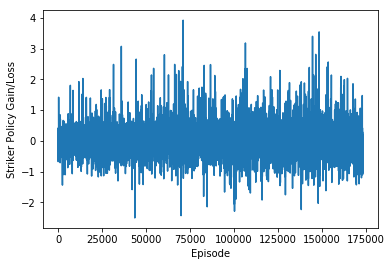

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(policy_loss_value)+1), policy_loss_value)
plt.ylabel('Striker Policy Gain/Loss')
plt.xlabel('Episode')
plt.show()

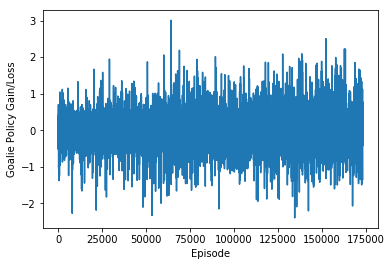

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(policy_loss_value_g)+1), policy_loss_value_g)
plt.ylabel('Goalie Policy Gain/Loss')
plt.xlabel('Episode')
plt.show()

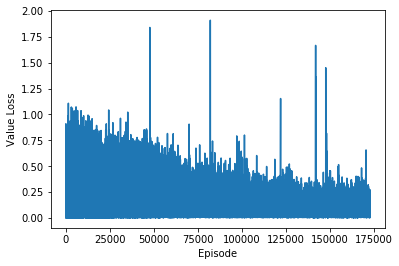

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(value_loss_value)+1), value_loss_value)
plt.ylabel('Value Loss')
plt.xlabel('Episode')
plt.show()

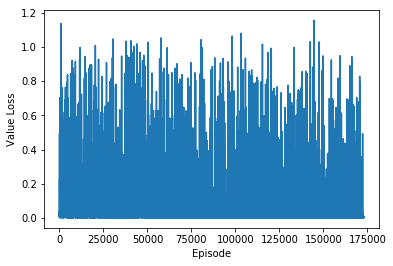

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(value_loss_value_g)+1), value_loss_value_g)
plt.ylabel('Value Loss')
plt.xlabel('Episode')
plt.show()

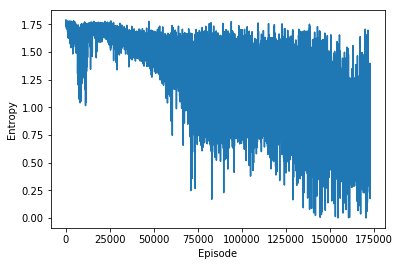

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(entropy_value)+1), entropy_value)
plt.ylabel('Entropy')
plt.xlabel('Episode')
plt.show()

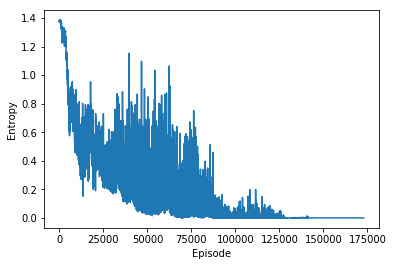

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(entropy_value_g)+1), entropy_value_g)
plt.ylabel('Entropy')
plt.xlabel('Episode')
plt.show()

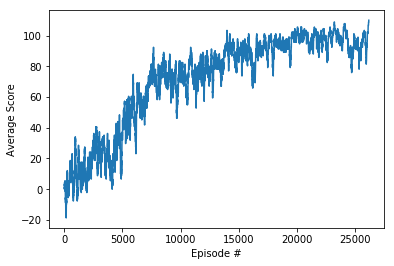

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(rolling_average)+1), rolling_average)
plt.ylabel('Average Score')
plt.xlabel('Episode #')
plt.show()

### Watch The Trained Agents

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

striker_0_actor = Actor(s_state_size, s_action_size, hidden_0, hidden_1).to(device)
goalie_0_actor = Actor(g_state_size, g_action_size, hidden_0, hidden_1).to(device)

# Load the saved training parameters
striker_0_actor.load_state_dict(torch.load('checkpoint_striker_0_actor.pth', map_location='cpu'))
goalie_0_actor.load_state_dict(torch.load('checkpoint_goalie_0_actor.pth', map_location='cpu'))

# Set environment to evalulation mode
env_info = env.reset(train_mode=False)        
g_states = env_info[g_brain_name].vector_observations  
s_states = env_info[s_brain_name].vector_observations  

team_0_score = 0
team_1_score = 0
team_0_delta = 0
team_0_lead = []

print("*** Starting the first episode ***")

for i in range(100):

    g_scores = np.zeros(num_g_agents)                      
    s_scores = np.zeros(num_s_agents)           

    while True:
        states_all = combine_states(g_states, s_states)
        g0_prob, g0_action = act(goalie_0_actor, g_states[0])
        s0_prob, s0_action = act(striker_0_actor, s_states[0])
        g_actions = np.array([g0_action, np.random.choice(g_action_size)])
        s_actions = np.array([s0_action, np.random.choice(s_action_size)])
        actions = dict(zip([g_brain_name, s_brain_name], [g_actions, s_actions]))
        env_info = env.step(actions)                       

        g_next_states = env_info[g_brain_name].vector_observations         
        s_next_states = env_info[s_brain_name].vector_observations

        done = np.any(env_info[g_brain_name].local_done)  
        
        #update scores
        g_rewards = env_info[g_brain_name].rewards  
        s_rewards = env_info[s_brain_name].rewards
        g_scores += g_rewards
        s_scores += s_rewards

        # exit loop if episode finished
        if done:                                           
            break

        # roll over states to next time step
        g_states = g_next_states
        s_states = s_next_states
    
    # calculate team scores and team 0 lead
    team_0_score = round(g_scores[0] + s_scores[0], 2)
    team_1_score = round(g_scores[1] + s_scores[1], 2)
    team_0_delta = round(team_0_score + team_0_delta, 2)
    team_0_lead.append(team_0_delta)
        
    print('Episode {}:\tTrained Team Score: {}      Cumulative Score: {}'.format(i+1, team_0_score, team_0_delta))


*** Starting the first episode ***
Episode 1:	Trained Team Score: 1.1      Cumulative Score: 1.1
Episode 2:	Trained Team Score: 1.1      Cumulative Score: 2.2
Episode 3:	Trained Team Score: 1.1      Cumulative Score: 3.3
Episode 4:	Trained Team Score: 1.1      Cumulative Score: 4.4
Episode 5:	Trained Team Score: 1.1      Cumulative Score: 5.5
Episode 6:	Trained Team Score: 1.1      Cumulative Score: 6.6
Episode 7:	Trained Team Score: 1.1      Cumulative Score: 7.7
Episode 8:	Trained Team Score: 1.1      Cumulative Score: 8.8
Episode 9:	Trained Team Score: 1.1      Cumulative Score: 9.9
Episode 10:	Trained Team Score: 1.1      Cumulative Score: 11.0
Episode 11:	Trained Team Score: 1.1      Cumulative Score: 12.1
Episode 12:	Trained Team Score: 1.1      Cumulative Score: 13.2
Episode 13:	Trained Team Score: 1.1      Cumulative Score: 14.3
Episode 14:	Trained Team Score: 1.1      Cumulative Score: 15.4
Episode 15:	Trained Team Score: 1.1      Cumulative Score: 16.5
Episode 16:	Trained Tea

When finished, you can close the environment.

In [ ]:
#env.close()